In [48]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision
import torch.nn as nn
import torch
import torchvision.utils as vutils

In [22]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms =  transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])


image_dataset = torchvision.datasets.CIFAR10("./", train=True, download=True, transform=data_transforms)
dataloader = torch.utils.data.DataLoader(image_dataset,
                                         batch_size=16,
                                         shuffle=True,
                                         num_workers=4)


use_gpu = torch.cuda.is_available()

Files already downloaded and verified


# Generator

In [42]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

# Generator

class Generator(nn.Module):
    def __init__(self, input_size, ouput_size, factor=2):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(  input_size, factor * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(factor * 8),
            nn.ReLU(True),
            # state size. (factor*8) x 4 x 4
            nn.ConvTranspose2d(factor * 8, factor * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(factor * 4),
            nn.ReLU(True),
            # state size. (factor*4) x 8 x 8
            nn.ConvTranspose2d(factor * 4, factor * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(factor * 2),
            nn.ReLU(True),
            # state size. (factor*2) x 16 x 16
            nn.ConvTranspose2d( factor*2,  ouput_size, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )

    def forward(self, input):
        output = self.main(input)
        return output

# Discriminator

In [37]:
class Discriminator(nn.Module):
    def __init__(self, input_size, factor=2):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(input_size, factor, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(factor, factor * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(factor * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(factor * 2, factor * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(factor * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(factor * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

In [25]:
# Parameters: 

z_dim = 12
batch_size = 16
im_size = 32
n_channels=3

In [54]:
# Input tensors
input = torch.FloatTensor(batch_size, n_channels, im_size, im_size)
noise = torch.FloatTensor(batch_size, z_dim, 1, 1)
label = torch.FloatTensor(batch_size)

# For validation
fixed_noise = torch.FloatTensor(batch_size, z_dim, 1, 1).normal_(0, 1)

# Labels
real_label = 1
fake_label = 0

Optimisation settings

In [55]:
# Loss function
criterion = nn.BCELoss()

# Models
netG = Generator(z_dim, n_channels)

netD = Discriminator(n_channels)

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=1e-5)
optimizerG = optim.Adam(netG.parameters(), lr=1e-5)

Optimisation explained:

In [56]:
inputv.size()

torch.Size([16, 3, 32, 32])

In [57]:
niter = 10

fixed_noise = Variable(fixed_noise)


for epoch in range(niter):
    for i, data in enumerate(dataloader):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        
        # First, gather true images and artificial images
        
        # train with real
        
        netD.zero_grad()
        # Feed the data        
        real_cpu, _ = data
        batch_size = real_cpu.size(0)
            
        input.resize_as_(real_cpu).copy_(real_cpu)
        
        # Fill with same value        
        label.resize_(batch_size).fill_(real_label)
        
        # Prepare for feeding the model         
        inputv = Variable(input)
        labelv = Variable(label)
        
        # Apply discriminator      
        output = netD(inputv)
        errD_real = criterion(output, labelv)
        errD_real.backward()
        D_x = output.data.mean()

        # Train with fake
        
        # Generate data          
        noise.resize_(batch_size, z_dim, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        
        # Upscale data        
        fake = netG(noisev)
        labelv = Variable(label.fill_(fake_label))
        
        # Apply discriminator to generated images         
        output = netD(fake.detach())
        errD_fake = criterion(output, labelv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        
        # Optimize
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        
        netG.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labelv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2))
        
        target_dir = "./"
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                              '%s/real_samples.png' % target_dir,
                              normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.data,
                              '%s/fake_samples_epoch_%03d.png' % (target_dir, epoch),
                              normalize=True)

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][0/3125] Loss_D: 1.4037 Loss_G: 0.5960 D(x): 0.5588 D(G(z)): 0.5537 / 0.5536
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1/3125] Loss_D: 1.4342 Loss_G: 0.6014 D(x): 0.5416 D(G(z)): 0.5530 / 0.5529
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2/3125] Loss_D: 1.3657 Loss_G: 0.6213 D(x): 0.5704 D(G(z)): 0.5418 / 0.5417
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][3/3125] Loss_D: 1.3274 Loss_G: 0.6362 D(x): 0.5771 D(G(z)): 0.5332 / 0.5331
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][4/3125] Loss_D: 1.4614 Loss_G: 0.5793 D(x): 0.5387 D(G(z)): 0.5639 / 0.5638
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][5/3125] Loss_D: 1.4328 Loss_G: 0.6079 D(x): 0.5408 D(G(z)): 0.5501 / 0.5501
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][6/3125] Loss

[0/10][62/3125] Loss_D: 1.3983 Loss_G: 0.5891 D(x): 0.5715 D(G(z)): 0.5602 / 0.5601
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][63/3125] Loss_D: 1.3995 Loss_G: 0.6063 D(x): 0.5598 D(G(z)): 0.5511 / 0.5511
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][64/3125] Loss_D: 1.3997 Loss_G: 0.6012 D(x): 0.5531 D(G(z)): 0.5504 / 0.5503
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][65/3125] Loss_D: 1.3326 Loss_G: 0.6373 D(x): 0.5681 D(G(z)): 0.5314 / 0.5313
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][66/3125] Loss_D: 1.3463 Loss_G: 0.6603 D(x): 0.5621 D(G(z)): 0.5247 / 0.5246
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][67/3125] Loss_D: 1.4570 Loss_G: 0.5562 D(x): 0.5735 D(G(z)): 0.5806 / 0.5805
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][68/3125] Loss_D: 1.3913 Loss_G: 0.6137 D(x): 0.5575 D(G(z)): 0.5461 / 0.546

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][124/3125] Loss_D: 1.3857 Loss_G: 0.6162 D(x): 0.5603 D(G(z)): 0.5452 / 0.5451
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][125/3125] Loss_D: 1.3873 Loss_G: 0.5919 D(x): 0.5666 D(G(z)): 0.5552 / 0.5551
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][126/3125] Loss_D: 1.4025 Loss_G: 0.6124 D(x): 0.5572 D(G(z)): 0.5482 / 0.5481
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][127/3125] Loss_D: 1.4239 Loss_G: 0.5905 D(x): 0.5545 D(G(z)): 0.5576 / 0.5575
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][128/3125] Loss_D: 1.4046 Loss_G: 0.6082 D(x): 0.5546 D(G(z)): 0.5491 / 0.5490
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][129/3125] Loss_D: 1.4060 Loss_G: 0.5828 D(x): 0.5639 D(G(z)): 0.5604 / 0.5603
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][

[0/10][184/3125] Loss_D: 1.4170 Loss_G: 0.6019 D(x): 0.5574 D(G(z)): 0.5544 / 0.5544
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][185/3125] Loss_D: 1.3610 Loss_G: 0.6007 D(x): 0.5939 D(G(z)): 0.5567 / 0.5567
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][186/3125] Loss_D: 1.4089 Loss_G: 0.5767 D(x): 0.5662 D(G(z)): 0.5641 / 0.5640
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][187/3125] Loss_D: 1.4241 Loss_G: 0.5683 D(x): 0.5618 D(G(z)): 0.5680 / 0.5679
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][188/3125] Loss_D: 1.4329 Loss_G: 0.5390 D(x): 0.5830 D(G(z)): 0.5859 / 0.5858
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][189/3125] Loss_D: 1.3612 Loss_G: 0.6066 D(x): 0.5699 D(G(z)): 0.5465 / 0.5464
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][190/3125] Loss_D: 1.3819 Loss_G: 0.5639 D(x): 0.5914 D(G(z)): 0.5707 

[0/10][243/3125] Loss_D: 1.3746 Loss_G: 0.6239 D(x): 0.5548 D(G(z)): 0.5386 / 0.5385
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][244/3125] Loss_D: 1.3865 Loss_G: 0.5637 D(x): 0.5917 D(G(z)): 0.5720 / 0.5719
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][245/3125] Loss_D: 1.4043 Loss_G: 0.5780 D(x): 0.5706 D(G(z)): 0.5643 / 0.5642
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][246/3125] Loss_D: 1.4545 Loss_G: 0.5474 D(x): 0.5658 D(G(z)): 0.5810 / 0.5809
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][247/3125] Loss_D: 1.5443 Loss_G: 0.5083 D(x): 0.5519 D(G(z)): 0.6050 / 0.6049
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][248/3125] Loss_D: 1.4782 Loss_G: 0.5210 D(x): 0.5740 D(G(z)): 0.5968 / 0.5968
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][249/3125] Loss_D: 1.4500 Loss_G: 0.5808 D(x): 0.5495 D(G(z)): 0.5648 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][297/3125] Loss_D: 1.4566 Loss_G: 0.5498 D(x): 0.5650 D(G(z)): 0.5806 / 0.5805
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][298/3125] Loss_D: 1.4540 Loss_G: 0.5624 D(x): 0.5555 D(G(z)): 0.5729 / 0.5728
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][299/3125] Loss_D: 1.4450 Loss_G: 0.5856 D(x): 0.5447 D(G(z)): 0.5603 / 0.5601
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][300/3125] Loss_D: 1.4154 Loss_G: 0.5603 D(x): 0.5814 D(G(z)): 0.5752 / 0.5751
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][301/3125] Loss_D: 1.4053 Loss_G: 0.5655 D(x): 0.5761 D(G(z)): 0.5702 / 0.5701
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][302/3125] Loss_D: 1.4020 Loss_G: 0.5619 D(x): 0.5842 D(G(z)): 0.5732 / 0.5731
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][

[0/10][350/3125] Loss_D: 1.4574 Loss_G: 0.5567 D(x): 0.5528 D(G(z)): 0.5752 / 0.5751
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][351/3125] Loss_D: 1.4157 Loss_G: 0.5596 D(x): 0.5841 D(G(z)): 0.5760 / 0.5759
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][352/3125] Loss_D: 1.4535 Loss_G: 0.5348 D(x): 0.5849 D(G(z)): 0.5911 / 0.5910
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][353/3125] Loss_D: 1.4396 Loss_G: 0.5887 D(x): 0.5525 D(G(z)): 0.5614 / 0.5613
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][354/3125] Loss_D: 1.4110 Loss_G: 0.5649 D(x): 0.5768 D(G(z)): 0.5716 / 0.5715
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][355/3125] Loss_D: 1.4701 Loss_G: 0.5414 D(x): 0.5596 D(G(z)): 0.5839 / 0.5838
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][356/3125] Loss_D: 1.4096 Loss_G: 0.5761 D(x): 0.5700 D(G(z)): 0.5652 

[0/10][411/3125] Loss_D: 1.3876 Loss_G: 0.5894 D(x): 0.5779 D(G(z)): 0.5593 / 0.5592
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][412/3125] Loss_D: 1.4702 Loss_G: 0.5083 D(x): 0.5835 D(G(z)): 0.6025 / 0.6024
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][413/3125] Loss_D: 1.3861 Loss_G: 0.6003 D(x): 0.5625 D(G(z)): 0.5510 / 0.5509
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][414/3125] Loss_D: 1.4511 Loss_G: 0.5462 D(x): 0.5783 D(G(z)): 0.5855 / 0.5854
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][415/3125] Loss_D: 1.3927 Loss_G: 0.6078 D(x): 0.5556 D(G(z)): 0.5476 / 0.5475
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][416/3125] Loss_D: 1.4138 Loss_G: 0.5523 D(x): 0.5885 D(G(z)): 0.5793 / 0.5792
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][417/3125] Loss_D: 1.4402 Loss_G: 0.5484 D(x): 0.5757 D(G(z)): 0.5816 

[0/10][465/3125] Loss_D: 1.4293 Loss_G: 0.5470 D(x): 0.5779 D(G(z)): 0.5807 / 0.5806
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][466/3125] Loss_D: 1.3938 Loss_G: 0.5704 D(x): 0.5803 D(G(z)): 0.5681 / 0.5680
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][467/3125] Loss_D: 1.4652 Loss_G: 0.5241 D(x): 0.5807 D(G(z)): 0.5948 / 0.5947
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][468/3125] Loss_D: 1.4506 Loss_G: 0.5147 D(x): 0.5952 D(G(z)): 0.6006 / 0.6005
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][469/3125] Loss_D: 1.4445 Loss_G: 0.5365 D(x): 0.5761 D(G(z)): 0.5864 / 0.5863
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][470/3125] Loss_D: 1.4189 Loss_G: 0.5530 D(x): 0.5788 D(G(z)): 0.5773 / 0.5772
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][471/3125] Loss_D: 1.4580 Loss_G: 0.5376 D(x): 0.5706 D(G(z)): 0.5870 

[0/10][527/3125] Loss_D: 1.4168 Loss_G: 0.5441 D(x): 0.5871 D(G(z)): 0.5822 / 0.5821
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][528/3125] Loss_D: 1.3602 Loss_G: 0.5678 D(x): 0.6037 D(G(z)): 0.5697 / 0.5696
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][529/3125] Loss_D: 1.4349 Loss_G: 0.5225 D(x): 0.5943 D(G(z)): 0.5951 / 0.5950
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][530/3125] Loss_D: 1.4043 Loss_G: 0.5326 D(x): 0.6113 D(G(z)): 0.5904 / 0.5903
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][531/3125] Loss_D: 1.5202 Loss_G: 0.4974 D(x): 0.5742 D(G(z)): 0.6113 / 0.6112
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][532/3125] Loss_D: 1.4455 Loss_G: 0.5407 D(x): 0.5767 D(G(z)): 0.5855 / 0.5854
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][533/3125] Loss_D: 1.4842 Loss_G: 0.5168 D(x): 0.5756 D(G(z)): 0.5989 

[0/10][586/3125] Loss_D: 1.4311 Loss_G: 0.5354 D(x): 0.5833 D(G(z)): 0.5864 / 0.5863
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][587/3125] Loss_D: 1.4294 Loss_G: 0.5470 D(x): 0.5734 D(G(z)): 0.5796 / 0.5795
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][588/3125] Loss_D: 1.4014 Loss_G: 0.5619 D(x): 0.5813 D(G(z)): 0.5722 / 0.5721
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][589/3125] Loss_D: 1.4305 Loss_G: 0.5698 D(x): 0.5614 D(G(z)): 0.5688 / 0.5687
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][590/3125] Loss_D: 1.4274 Loss_G: 0.5417 D(x): 0.5858 D(G(z)): 0.5841 / 0.5840
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][591/3125] Loss_D: 1.4470 Loss_G: 0.5235 D(x): 0.5872 D(G(z)): 0.5945 / 0.5944
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][592/3125] Loss_D: 1.4903 Loss_G: 0.5036 D(x): 0.5791 D(G(z)): 0.6065 

[0/10][640/3125] Loss_D: 1.4784 Loss_G: 0.5518 D(x): 0.5573 D(G(z)): 0.5813 / 0.5812
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][641/3125] Loss_D: 1.4268 Loss_G: 0.5595 D(x): 0.5735 D(G(z)): 0.5755 / 0.5753
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][642/3125] Loss_D: 1.4190 Loss_G: 0.5447 D(x): 0.5867 D(G(z)): 0.5823 / 0.5822
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][643/3125] Loss_D: 1.4315 Loss_G: 0.5310 D(x): 0.5909 D(G(z)): 0.5899 / 0.5898
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][644/3125] Loss_D: 1.4621 Loss_G: 0.5173 D(x): 0.5856 D(G(z)): 0.5989 / 0.5988
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][645/3125] Loss_D: 1.4621 Loss_G: 0.5279 D(x): 0.5788 D(G(z)): 0.5928 / 0.5927
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][646/3125] Loss_D: 1.5292 Loss_G: 0.4942 D(x): 0.5683 D(G(z)): 0.6127 

[0/10][694/3125] Loss_D: 1.4538 Loss_G: 0.5138 D(x): 0.5914 D(G(z)): 0.6004 / 0.6003
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][695/3125] Loss_D: 1.4334 Loss_G: 0.5574 D(x): 0.5718 D(G(z)): 0.5758 / 0.5757
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][696/3125] Loss_D: 1.4148 Loss_G: 0.5448 D(x): 0.5900 D(G(z)): 0.5825 / 0.5824
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][697/3125] Loss_D: 1.4605 Loss_G: 0.5282 D(x): 0.5742 D(G(z)): 0.5917 / 0.5916
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][698/3125] Loss_D: 1.3936 Loss_G: 0.5517 D(x): 0.5966 D(G(z)): 0.5785 / 0.5783
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][699/3125] Loss_D: 1.4460 Loss_G: 0.5131 D(x): 0.5994 D(G(z)): 0.6015 / 0.6013
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][700/3125] Loss_D: 1.5068 Loss_G: 0.5167 D(x): 0.5630 D(G(z)): 0.5997 

[0/10][748/3125] Loss_D: 1.4126 Loss_G: 0.5556 D(x): 0.5892 D(G(z)): 0.5795 / 0.5794
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][749/3125] Loss_D: 1.4038 Loss_G: 0.5504 D(x): 0.5922 D(G(z)): 0.5798 / 0.5797
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][750/3125] Loss_D: 1.4773 Loss_G: 0.4941 D(x): 0.5951 D(G(z)): 0.6123 / 0.6121
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][751/3125] Loss_D: 1.4367 Loss_G: 0.5629 D(x): 0.5659 D(G(z)): 0.5726 / 0.5725
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][752/3125] Loss_D: 1.4759 Loss_G: 0.5197 D(x): 0.5775 D(G(z)): 0.5980 / 0.5979
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][753/3125] Loss_D: 1.3707 Loss_G: 0.5632 D(x): 0.5990 D(G(z)): 0.5711 / 0.5710
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][754/3125] Loss_D: 1.4160 Loss_G: 0.5419 D(x): 0.5923 D(G(z)): 0.5845 

[0/10][811/3125] Loss_D: 1.5204 Loss_G: 0.4665 D(x): 0.5924 D(G(z)): 0.6281 / 0.6280
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][812/3125] Loss_D: 1.4416 Loss_G: 0.5149 D(x): 0.6024 D(G(z)): 0.6003 / 0.6002
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][813/3125] Loss_D: 1.5048 Loss_G: 0.4932 D(x): 0.5868 D(G(z)): 0.6138 / 0.6137
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][814/3125] Loss_D: 1.4604 Loss_G: 0.5135 D(x): 0.5914 D(G(z)): 0.6005 / 0.6004
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][815/3125] Loss_D: 1.4819 Loss_G: 0.5126 D(x): 0.5780 D(G(z)): 0.6014 / 0.6013
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][816/3125] Loss_D: 1.4514 Loss_G: 0.5138 D(x): 0.5958 D(G(z)): 0.6013 / 0.6012
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][817/3125] Loss_D: 1.5108 Loss_G: 0.5185 D(x): 0.5621 D(G(z)): 0.5993 

[0/10][865/3125] Loss_D: 1.4264 Loss_G: 0.5177 D(x): 0.6051 D(G(z)): 0.5985 / 0.5983
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][866/3125] Loss_D: 1.4907 Loss_G: 0.5116 D(x): 0.5697 D(G(z)): 0.6010 / 0.6009
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][867/3125] Loss_D: 1.4562 Loss_G: 0.5144 D(x): 0.5879 D(G(z)): 0.5995 / 0.5994
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][868/3125] Loss_D: 1.4636 Loss_G: 0.4963 D(x): 0.5988 D(G(z)): 0.6102 / 0.6101
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][869/3125] Loss_D: 1.4068 Loss_G: 0.5286 D(x): 0.6124 D(G(z)): 0.5930 / 0.5929
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][870/3125] Loss_D: 1.4894 Loss_G: 0.5028 D(x): 0.5809 D(G(z)): 0.6068 / 0.6067
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][871/3125] Loss_D: 1.4907 Loss_G: 0.4960 D(x): 0.5851 D(G(z)): 0.6104 

[0/10][929/3125] Loss_D: 1.4386 Loss_G: 0.5098 D(x): 0.6059 D(G(z)): 0.6030 / 0.6029
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][930/3125] Loss_D: 1.4225 Loss_G: 0.5421 D(x): 0.5931 D(G(z)): 0.5857 / 0.5855
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][931/3125] Loss_D: 1.4004 Loss_G: 0.5382 D(x): 0.5971 D(G(z)): 0.5848 / 0.5847
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][932/3125] Loss_D: 1.4538 Loss_G: 0.4916 D(x): 0.6213 D(G(z)): 0.6153 / 0.6152
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][933/3125] Loss_D: 1.4298 Loss_G: 0.5387 D(x): 0.5836 D(G(z)): 0.5856 / 0.5855
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][934/3125] Loss_D: 1.4620 Loss_G: 0.5157 D(x): 0.5849 D(G(z)): 0.5994 / 0.5992
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][935/3125] Loss_D: 1.4178 Loss_G: 0.5346 D(x): 0.5912 D(G(z)): 0.5872 

[0/10][993/3125] Loss_D: 1.5106 Loss_G: 0.4822 D(x): 0.5904 D(G(z)): 0.6203 / 0.6201
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][994/3125] Loss_D: 1.4370 Loss_G: 0.5284 D(x): 0.5901 D(G(z)): 0.5918 / 0.5916
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][995/3125] Loss_D: 1.5023 Loss_G: 0.4873 D(x): 0.5900 D(G(z)): 0.6167 / 0.6165
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][996/3125] Loss_D: 1.4444 Loss_G: 0.5049 D(x): 0.6047 D(G(z)): 0.6057 / 0.6056
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][997/3125] Loss_D: 1.4408 Loss_G: 0.5125 D(x): 0.5998 D(G(z)): 0.6013 / 0.6012
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][998/3125] Loss_D: 1.4643 Loss_G: 0.5381 D(x): 0.5629 D(G(z)): 0.5854 / 0.5853
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][999/3125] Loss_D: 1.4732 Loss_G: 0.4862 D(x): 0.6030 D(G(z)): 0.6165 

[0/10][1046/3125] Loss_D: 1.4895 Loss_G: 0.4952 D(x): 0.5863 D(G(z)): 0.6108 / 0.6106
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1047/3125] Loss_D: 1.4190 Loss_G: 0.5271 D(x): 0.5979 D(G(z)): 0.5913 / 0.5911
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1048/3125] Loss_D: 1.3814 Loss_G: 0.5605 D(x): 0.5956 D(G(z)): 0.5740 / 0.5739
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1049/3125] Loss_D: 1.4511 Loss_G: 0.5081 D(x): 0.5955 D(G(z)): 0.6031 / 0.6030
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1050/3125] Loss_D: 1.4666 Loss_G: 0.4990 D(x): 0.5970 D(G(z)): 0.6088 / 0.6087
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1051/3125] Loss_D: 1.5908 Loss_G: 0.4629 D(x): 0.5607 D(G(z)): 0.6314 / 0.6312
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1052/3125] Loss_D: 1.4467 Loss_G: 0.4830 D(x): 0.6191 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1100/3125] Loss_D: 1.4476 Loss_G: 0.5411 D(x): 0.5772 D(G(z)): 0.5852 / 0.5851
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1101/3125] Loss_D: 1.5204 Loss_G: 0.4837 D(x): 0.5840 D(G(z)): 0.6192 / 0.6190
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1102/3125] Loss_D: 1.5118 Loss_G: 0.4832 D(x): 0.5852 D(G(z)): 0.6185 / 0.6184
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1103/3125] Loss_D: 1.3925 Loss_G: 0.5264 D(x): 0.6185 D(G(z)): 0.5935 / 0.5934
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1104/3125] Loss_D: 1.4232 Loss_G: 0.5420 D(x): 0.5877 D(G(z)): 0.5843 / 0.5841
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1105/3125] Loss_D: 1.4444 Loss_G: 0.5190 D(x): 0.5906 D(G(z)): 0.5963 / 0.5962
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[0/10][1153/3125] Loss_D: 1.4440 Loss_G: 0.5189 D(x): 0.5947 D(G(z)): 0.5976 / 0.5974
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1154/3125] Loss_D: 1.4535 Loss_G: 0.4883 D(x): 0.6160 D(G(z)): 0.6159 / 0.6158
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1155/3125] Loss_D: 1.4086 Loss_G: 0.5237 D(x): 0.6119 D(G(z)): 0.5952 / 0.5951
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1156/3125] Loss_D: 1.4893 Loss_G: 0.4855 D(x): 0.5992 D(G(z)): 0.6176 / 0.6175
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1157/3125] Loss_D: 1.4783 Loss_G: 0.4934 D(x): 0.6041 D(G(z)): 0.6141 / 0.6139
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1158/3125] Loss_D: 1.4279 Loss_G: 0.5240 D(x): 0.5958 D(G(z)): 0.5934 / 0.5932
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1159/3125] Loss_D: 1.4579 Loss_G: 0.4954 D(x): 0.6023 D(G(z)): 

[0/10][1206/3125] Loss_D: 1.3914 Loss_G: 0.5219 D(x): 0.6205 D(G(z)): 0.5951 / 0.5949
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1207/3125] Loss_D: 1.4156 Loss_G: 0.5156 D(x): 0.6115 D(G(z)): 0.5991 / 0.5990
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1208/3125] Loss_D: 1.4628 Loss_G: 0.4889 D(x): 0.6118 D(G(z)): 0.6162 / 0.6160
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1209/3125] Loss_D: 1.3914 Loss_G: 0.5260 D(x): 0.6159 D(G(z)): 0.5929 / 0.5928
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1210/3125] Loss_D: 1.4501 Loss_G: 0.4887 D(x): 0.6178 D(G(z)): 0.6154 / 0.6153
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1211/3125] Loss_D: 1.3897 Loss_G: 0.5280 D(x): 0.6163 D(G(z)): 0.5919 / 0.5917
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1212/3125] Loss_D: 1.4083 Loss_G: 0.5131 D(x): 0.6194 D(G(z)): 

[0/10][1260/3125] Loss_D: 1.4879 Loss_G: 0.4965 D(x): 0.5853 D(G(z)): 0.6102 / 0.6101
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1261/3125] Loss_D: 1.4436 Loss_G: 0.4850 D(x): 0.6221 D(G(z)): 0.6172 / 0.6170
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1262/3125] Loss_D: 1.4485 Loss_G: 0.4973 D(x): 0.6085 D(G(z)): 0.6096 / 0.6095
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1263/3125] Loss_D: 1.4331 Loss_G: 0.4986 D(x): 0.6160 D(G(z)): 0.6093 / 0.6092
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1264/3125] Loss_D: 1.4909 Loss_G: 0.4841 D(x): 0.6029 D(G(z)): 0.6195 / 0.6193
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1265/3125] Loss_D: 1.5015 Loss_G: 0.4709 D(x): 0.6023 D(G(z)): 0.6258 / 0.6256
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1266/3125] Loss_D: 1.4610 Loss_G: 0.4847 D(x): 0.6135 D(G(z)): 

[0/10][1313/3125] Loss_D: 1.3821 Loss_G: 0.5338 D(x): 0.6141 D(G(z)): 0.5879 / 0.5878
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1314/3125] Loss_D: 1.4416 Loss_G: 0.5149 D(x): 0.5974 D(G(z)): 0.5990 / 0.5988
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1315/3125] Loss_D: 1.4341 Loss_G: 0.5103 D(x): 0.6045 D(G(z)): 0.6017 / 0.6015
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1316/3125] Loss_D: 1.3979 Loss_G: 0.5154 D(x): 0.6205 D(G(z)): 0.5987 / 0.5986
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1317/3125] Loss_D: 1.4674 Loss_G: 0.4866 D(x): 0.6103 D(G(z)): 0.6173 / 0.6172
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1318/3125] Loss_D: 1.4267 Loss_G: 0.5188 D(x): 0.6058 D(G(z)): 0.5980 / 0.5979
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1319/3125] Loss_D: 1.4705 Loss_G: 0.4854 D(x): 0.6057 D(G(z)): 

[0/10][1366/3125] Loss_D: 1.3822 Loss_G: 0.5258 D(x): 0.6227 D(G(z)): 0.5930 / 0.5929
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1367/3125] Loss_D: 1.4593 Loss_G: 0.5017 D(x): 0.6023 D(G(z)): 0.6081 / 0.6080
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1368/3125] Loss_D: 1.4026 Loss_G: 0.5196 D(x): 0.6186 D(G(z)): 0.5977 / 0.5975
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1369/3125] Loss_D: 1.4792 Loss_G: 0.4731 D(x): 0.6192 D(G(z)): 0.6254 / 0.6253
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1370/3125] Loss_D: 1.4995 Loss_G: 0.4772 D(x): 0.5973 D(G(z)): 0.6221 / 0.6220
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1371/3125] Loss_D: 1.4173 Loss_G: 0.5111 D(x): 0.6129 D(G(z)): 0.6014 / 0.6013
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1372/3125] Loss_D: 1.4496 Loss_G: 0.5043 D(x): 0.6017 D(G(z)): 

[0/10][1429/3125] Loss_D: 1.4377 Loss_G: 0.4957 D(x): 0.6220 D(G(z)): 0.6120 / 0.6119
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1430/3125] Loss_D: 1.4924 Loss_G: 0.5033 D(x): 0.5745 D(G(z)): 0.6057 / 0.6056
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1431/3125] Loss_D: 1.4860 Loss_G: 0.4953 D(x): 0.5939 D(G(z)): 0.6123 / 0.6122
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1432/3125] Loss_D: 1.3918 Loss_G: 0.5333 D(x): 0.6107 D(G(z)): 0.5885 / 0.5883
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1433/3125] Loss_D: 1.4477 Loss_G: 0.5103 D(x): 0.5984 D(G(z)): 0.6025 / 0.6024
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1434/3125] Loss_D: 1.4937 Loss_G: 0.4848 D(x): 0.5905 D(G(z)): 0.6168 / 0.6166
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1435/3125] Loss_D: 1.4555 Loss_G: 0.5050 D(x): 0.5953 D(G(z)): 

[0/10][1482/3125] Loss_D: 1.4048 Loss_G: 0.5039 D(x): 0.6264 D(G(z)): 0.6055 / 0.6054
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1483/3125] Loss_D: 1.4689 Loss_G: 0.4803 D(x): 0.6165 D(G(z)): 0.6211 / 0.6209
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1484/3125] Loss_D: 1.4253 Loss_G: 0.5242 D(x): 0.5945 D(G(z)): 0.5926 / 0.5925
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1485/3125] Loss_D: 1.4258 Loss_G: 0.5129 D(x): 0.6107 D(G(z)): 0.6006 / 0.6005
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1486/3125] Loss_D: 1.4197 Loss_G: 0.5171 D(x): 0.6112 D(G(z)): 0.5989 / 0.5988
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1487/3125] Loss_D: 1.4119 Loss_G: 0.4996 D(x): 0.6272 D(G(z)): 0.6084 / 0.6083
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1488/3125] Loss_D: 1.4355 Loss_G: 0.4996 D(x): 0.6178 D(G(z)): 

[0/10][1535/3125] Loss_D: 1.3863 Loss_G: 0.5216 D(x): 0.6242 D(G(z)): 0.5955 / 0.5953
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1536/3125] Loss_D: 1.3955 Loss_G: 0.5396 D(x): 0.6051 D(G(z)): 0.5855 / 0.5853
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1537/3125] Loss_D: 1.3774 Loss_G: 0.5244 D(x): 0.6283 D(G(z)): 0.5943 / 0.5942
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1538/3125] Loss_D: 1.4647 Loss_G: 0.4963 D(x): 0.6011 D(G(z)): 0.6105 / 0.6103
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1539/3125] Loss_D: 1.4369 Loss_G: 0.5246 D(x): 0.5947 D(G(z)): 0.5945 / 0.5943
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1540/3125] Loss_D: 1.4639 Loss_G: 0.4927 D(x): 0.6050 D(G(z)): 0.6129 / 0.6128
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1541/3125] Loss_D: 1.4668 Loss_G: 0.4900 D(x): 0.6102 D(G(z)): 

[0/10][1588/3125] Loss_D: 1.4390 Loss_G: 0.4901 D(x): 0.6165 D(G(z)): 0.6133 / 0.6131
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1589/3125] Loss_D: 1.4905 Loss_G: 0.4694 D(x): 0.6128 D(G(z)): 0.6272 / 0.6271
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1590/3125] Loss_D: 1.4177 Loss_G: 0.5225 D(x): 0.6059 D(G(z)): 0.5952 / 0.5951
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1591/3125] Loss_D: 1.4552 Loss_G: 0.5023 D(x): 0.6066 D(G(z)): 0.6084 / 0.6083
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1592/3125] Loss_D: 1.3861 Loss_G: 0.5415 D(x): 0.6064 D(G(z)): 0.5833 / 0.5831
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1593/3125] Loss_D: 1.4080 Loss_G: 0.5025 D(x): 0.6250 D(G(z)): 0.6061 / 0.6060
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1594/3125] Loss_D: 1.3927 Loss_G: 0.5125 D(x): 0.6310 D(G(z)): 

[0/10][1651/3125] Loss_D: 1.4087 Loss_G: 0.5016 D(x): 0.6270 D(G(z)): 0.6070 / 0.6068
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1652/3125] Loss_D: 1.3612 Loss_G: 0.5333 D(x): 0.6320 D(G(z)): 0.5892 / 0.5891
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1653/3125] Loss_D: 1.4311 Loss_G: 0.4800 D(x): 0.6333 D(G(z)): 0.6197 / 0.6195
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1654/3125] Loss_D: 1.3937 Loss_G: 0.4827 D(x): 0.6561 D(G(z)): 0.6184 / 0.6183
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1655/3125] Loss_D: 1.4134 Loss_G: 0.5115 D(x): 0.6188 D(G(z)): 0.6016 / 0.6015
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1656/3125] Loss_D: 1.4275 Loss_G: 0.5043 D(x): 0.6140 D(G(z)): 0.6055 / 0.6053
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1657/3125] Loss_D: 1.4368 Loss_G: 0.4860 D(x): 0.6274 D(G(z)): 

[0/10][1714/3125] Loss_D: 1.4670 Loss_G: 0.4595 D(x): 0.6332 D(G(z)): 0.6326 / 0.6325
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1715/3125] Loss_D: 1.3607 Loss_G: 0.5177 D(x): 0.6416 D(G(z)): 0.5973 / 0.5971
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1716/3125] Loss_D: 1.4107 Loss_G: 0.5267 D(x): 0.6052 D(G(z)): 0.5928 / 0.5926
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1717/3125] Loss_D: 1.4267 Loss_G: 0.4965 D(x): 0.6230 D(G(z)): 0.6107 / 0.6106
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1718/3125] Loss_D: 1.4119 Loss_G: 0.5092 D(x): 0.6174 D(G(z)): 0.6021 / 0.6019
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1719/3125] Loss_D: 1.3934 Loss_G: 0.5210 D(x): 0.6219 D(G(z)): 0.5962 / 0.5960
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1720/3125] Loss_D: 1.4563 Loss_G: 0.4953 D(x): 0.6081 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1768/3125] Loss_D: 1.4006 Loss_G: 0.5045 D(x): 0.6299 D(G(z)): 0.6053 / 0.6052
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1769/3125] Loss_D: 1.3409 Loss_G: 0.5551 D(x): 0.6209 D(G(z)): 0.5757 / 0.5755
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1770/3125] Loss_D: 1.4245 Loss_G: 0.4951 D(x): 0.6249 D(G(z)): 0.6108 / 0.6107
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1771/3125] Loss_D: 1.3734 Loss_G: 0.5477 D(x): 0.6124 D(G(z)): 0.5811 / 0.5810
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1772/3125] Loss_D: 1.4289 Loss_G: 0.5030 D(x): 0.6135 D(G(z)): 0.6065 / 0.6063
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1773/3125] Loss_D: 1.4248 Loss_G: 0.4946 D(x): 0.6275 D(G(z)): 0.6119 / 0.6117
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1831/3125] Loss_D: 1.4095 Loss_G: 0.5062 D(x): 0.6253 D(G(z)): 0.6049 / 0.6047
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1832/3125] Loss_D: 1.3595 Loss_G: 0.5300 D(x): 0.6374 D(G(z)): 0.5913 / 0.5911
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1833/3125] Loss_D: 1.4447 Loss_G: 0.4916 D(x): 0.6161 D(G(z)): 0.6133 / 0.6131
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1834/3125] Loss_D: 1.4521 Loss_G: 0.4821 D(x): 0.6235 D(G(z)): 0.6196 / 0.6194
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1835/3125] Loss_D: 1.3357 Loss_G: 0.5404 D(x): 0.6379 D(G(z)): 0.5842 / 0.5841
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1836/3125] Loss_D: 1.4353 Loss_G: 0.4952 D(x): 0.6171 D(G(z)): 0.6109 / 0.6107
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1885/3125] Loss_D: 1.3557 Loss_G: 0.5073 D(x): 0.6528 D(G(z)): 0.6031 / 0.6030
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1886/3125] Loss_D: 1.4064 Loss_G: 0.5007 D(x): 0.6307 D(G(z)): 0.6078 / 0.6077
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1887/3125] Loss_D: 1.4119 Loss_G: 0.5171 D(x): 0.6129 D(G(z)): 0.5978 / 0.5976
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1888/3125] Loss_D: 1.4451 Loss_G: 0.4909 D(x): 0.6177 D(G(z)): 0.6141 / 0.6140
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1889/3125] Loss_D: 1.3611 Loss_G: 0.5253 D(x): 0.6335 D(G(z)): 0.5924 / 0.5923
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1890/3125] Loss_D: 1.4120 Loss_G: 0.5252 D(x): 0.6059 D(G(z)): 0.5934 / 0.5932
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[0/10][1939/3125] Loss_D: 1.4189 Loss_G: 0.4901 D(x): 0.6312 D(G(z)): 0.6133 / 0.6132
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1940/3125] Loss_D: 1.4985 Loss_G: 0.4908 D(x): 0.5835 D(G(z)): 0.6135 / 0.6133
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1941/3125] Loss_D: 1.4331 Loss_G: 0.4885 D(x): 0.6334 D(G(z)): 0.6161 / 0.6160
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1942/3125] Loss_D: 1.4019 Loss_G: 0.5208 D(x): 0.6207 D(G(z)): 0.5965 / 0.5964
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1943/3125] Loss_D: 1.4299 Loss_G: 0.5187 D(x): 0.6010 D(G(z)): 0.5965 / 0.5964
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1944/3125] Loss_D: 1.4388 Loss_G: 0.4958 D(x): 0.6202 D(G(z)): 0.6117 / 0.6116
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1945/3125] Loss_D: 1.3491 Loss_G: 0.5422 D(x): 0.6273 D(G(z)): 

[0/10][1994/3125] Loss_D: 1.4114 Loss_G: 0.5073 D(x): 0.6206 D(G(z)): 0.6032 / 0.6031
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1995/3125] Loss_D: 1.4386 Loss_G: 0.4896 D(x): 0.6218 D(G(z)): 0.6143 / 0.6142
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1996/3125] Loss_D: 1.4139 Loss_G: 0.4953 D(x): 0.6322 D(G(z)): 0.6108 / 0.6106
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1997/3125] Loss_D: 1.4142 Loss_G: 0.4918 D(x): 0.6342 D(G(z)): 0.6130 / 0.6128
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1998/3125] Loss_D: 1.3859 Loss_G: 0.5130 D(x): 0.6335 D(G(z)): 0.6009 / 0.6008
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][1999/3125] Loss_D: 1.5178 Loss_G: 0.4584 D(x): 0.6053 D(G(z)): 0.6333 / 0.6332
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2000/3125] Loss_D: 1.3844 Loss_G: 0.5099 D(x): 0.6405 D(G(z)): 

[0/10][2047/3125] Loss_D: 1.3987 Loss_G: 0.5022 D(x): 0.6370 D(G(z)): 0.6074 / 0.6072
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2048/3125] Loss_D: 1.4363 Loss_G: 0.5083 D(x): 0.6073 D(G(z)): 0.6032 / 0.6031
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2049/3125] Loss_D: 1.3784 Loss_G: 0.5095 D(x): 0.6424 D(G(z)): 0.6028 / 0.6026
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2050/3125] Loss_D: 1.4379 Loss_G: 0.4843 D(x): 0.6322 D(G(z)): 0.6188 / 0.6187
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2051/3125] Loss_D: 1.3803 Loss_G: 0.5387 D(x): 0.6140 D(G(z)): 0.5847 / 0.5846
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2052/3125] Loss_D: 1.4300 Loss_G: 0.5204 D(x): 0.5983 D(G(z)): 0.5953 / 0.5951
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2053/3125] Loss_D: 1.3448 Loss_G: 0.5303 D(x): 0.6395 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2101/3125] Loss_D: 1.4491 Loss_G: 0.5046 D(x): 0.6027 D(G(z)): 0.6058 / 0.6056
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2102/3125] Loss_D: 1.4186 Loss_G: 0.4952 D(x): 0.6344 D(G(z)): 0.6125 / 0.6123
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2103/3125] Loss_D: 1.3642 Loss_G: 0.5166 D(x): 0.6396 D(G(z)): 0.5977 / 0.5975
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2104/3125] Loss_D: 1.4076 Loss_G: 0.5157 D(x): 0.6143 D(G(z)): 0.5986 / 0.5985
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2105/3125] Loss_D: 1.4048 Loss_G: 0.4930 D(x): 0.6415 D(G(z)): 0.6127 / 0.6125
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2106/3125] Loss_D: 1.4115 Loss_G: 0.5049 D(x): 0.6312 D(G(z)): 0.6071 / 0.6069
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[0/10][2154/3125] Loss_D: 1.3760 Loss_G: 0.5223 D(x): 0.6322 D(G(z)): 0.5958 / 0.5956
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2155/3125] Loss_D: 1.3870 Loss_G: 0.5046 D(x): 0.6377 D(G(z)): 0.6051 / 0.6049
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2156/3125] Loss_D: 1.4144 Loss_G: 0.5048 D(x): 0.6179 D(G(z)): 0.6044 / 0.6043
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2157/3125] Loss_D: 1.3510 Loss_G: 0.5196 D(x): 0.6506 D(G(z)): 0.5974 / 0.5973
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2158/3125] Loss_D: 1.4011 Loss_G: 0.5102 D(x): 0.6278 D(G(z)): 0.6022 / 0.6021
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2159/3125] Loss_D: 1.3415 Loss_G: 0.5239 D(x): 0.6484 D(G(z)): 0.5937 / 0.5935
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2160/3125] Loss_D: 1.4000 Loss_G: 0.5164 D(x): 0.6185 D(G(z)): 

[0/10][2207/3125] Loss_D: 1.3781 Loss_G: 0.5343 D(x): 0.6141 D(G(z)): 0.5868 / 0.5867
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2208/3125] Loss_D: 1.4192 Loss_G: 0.5029 D(x): 0.6185 D(G(z)): 0.6061 / 0.6059
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2209/3125] Loss_D: 1.4009 Loss_G: 0.5148 D(x): 0.6214 D(G(z)): 0.5989 / 0.5987
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2210/3125] Loss_D: 1.3903 Loss_G: 0.5086 D(x): 0.6384 D(G(z)): 0.6037 / 0.6035
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2211/3125] Loss_D: 1.4150 Loss_G: 0.5145 D(x): 0.6135 D(G(z)): 0.5998 / 0.5996
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2212/3125] Loss_D: 1.4041 Loss_G: 0.5059 D(x): 0.6268 D(G(z)): 0.6044 / 0.6042
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2213/3125] Loss_D: 1.3228 Loss_G: 0.5610 D(x): 0.6277 D(G(z)): 

[0/10][2260/3125] Loss_D: 1.3560 Loss_G: 0.5333 D(x): 0.6311 D(G(z)): 0.5881 / 0.5880
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2261/3125] Loss_D: 1.3886 Loss_G: 0.5075 D(x): 0.6355 D(G(z)): 0.6038 / 0.6036
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2262/3125] Loss_D: 1.3622 Loss_G: 0.5254 D(x): 0.6406 D(G(z)): 0.5942 / 0.5940
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2263/3125] Loss_D: 1.3376 Loss_G: 0.5489 D(x): 0.6279 D(G(z)): 0.5789 / 0.5787
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2264/3125] Loss_D: 1.3637 Loss_G: 0.5195 D(x): 0.6438 D(G(z)): 0.5977 / 0.5975
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2265/3125] Loss_D: 1.4178 Loss_G: 0.4935 D(x): 0.6329 D(G(z)): 0.6123 / 0.6121
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2266/3125] Loss_D: 1.3545 Loss_G: 0.5283 D(x): 0.6371 D(G(z)): 

[0/10][2313/3125] Loss_D: 1.4144 Loss_G: 0.5046 D(x): 0.6252 D(G(z)): 0.6062 / 0.6060
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2314/3125] Loss_D: 1.3734 Loss_G: 0.5257 D(x): 0.6295 D(G(z)): 0.5928 / 0.5926
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2315/3125] Loss_D: 1.3476 Loss_G: 0.5265 D(x): 0.6434 D(G(z)): 0.5924 / 0.5923
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2316/3125] Loss_D: 1.4094 Loss_G: 0.5220 D(x): 0.6065 D(G(z)): 0.5944 / 0.5943
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2317/3125] Loss_D: 1.4037 Loss_G: 0.5287 D(x): 0.6099 D(G(z)): 0.5911 / 0.5909
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2318/3125] Loss_D: 1.3337 Loss_G: 0.5363 D(x): 0.6445 D(G(z)): 0.5870 / 0.5869
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2319/3125] Loss_D: 1.3759 Loss_G: 0.5229 D(x): 0.6254 D(G(z)): 

[0/10][2367/3125] Loss_D: 1.3562 Loss_G: 0.5159 D(x): 0.6497 D(G(z)): 0.5993 / 0.5991
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2368/3125] Loss_D: 1.3489 Loss_G: 0.5314 D(x): 0.6409 D(G(z)): 0.5901 / 0.5899
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2369/3125] Loss_D: 1.3943 Loss_G: 0.4967 D(x): 0.6433 D(G(z)): 0.6103 / 0.6102
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2370/3125] Loss_D: 1.3652 Loss_G: 0.5463 D(x): 0.6142 D(G(z)): 0.5805 / 0.5804
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2371/3125] Loss_D: 1.3241 Loss_G: 0.5335 D(x): 0.6502 D(G(z)): 0.5877 / 0.5876
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2372/3125] Loss_D: 1.3911 Loss_G: 0.5010 D(x): 0.6391 D(G(z)): 0.6073 / 0.6071
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2373/3125] Loss_D: 1.3216 Loss_G: 0.5421 D(x): 0.6449 D(G(z)): 

[0/10][2420/3125] Loss_D: 1.3461 Loss_G: 0.5288 D(x): 0.6419 D(G(z)): 0.5911 / 0.5910
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2421/3125] Loss_D: 1.3965 Loss_G: 0.5007 D(x): 0.6380 D(G(z)): 0.6082 / 0.6081
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2422/3125] Loss_D: 1.3263 Loss_G: 0.5534 D(x): 0.6319 D(G(z)): 0.5764 / 0.5762
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2423/3125] Loss_D: 1.3594 Loss_G: 0.5388 D(x): 0.6230 D(G(z)): 0.5847 / 0.5845
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2424/3125] Loss_D: 1.3745 Loss_G: 0.5280 D(x): 0.6294 D(G(z)): 0.5921 / 0.5919
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2425/3125] Loss_D: 1.3280 Loss_G: 0.5345 D(x): 0.6465 D(G(z)): 0.5874 / 0.5872
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2426/3125] Loss_D: 1.3860 Loss_G: 0.5015 D(x): 0.6448 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2475/3125] Loss_D: 1.3937 Loss_G: 0.5173 D(x): 0.6222 D(G(z)): 0.5978 / 0.5976
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2476/3125] Loss_D: 1.4039 Loss_G: 0.5100 D(x): 0.6280 D(G(z)): 0.6031 / 0.6029
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2477/3125] Loss_D: 1.4027 Loss_G: 0.5144 D(x): 0.6188 D(G(z)): 0.5994 / 0.5993
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2478/3125] Loss_D: 1.3578 Loss_G: 0.5093 D(x): 0.6514 D(G(z)): 0.6024 / 0.6023
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2479/3125] Loss_D: 1.3252 Loss_G: 0.5272 D(x): 0.6545 D(G(z)): 0.5913 / 0.5912
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2480/3125] Loss_D: 1.3575 Loss_G: 0.5369 D(x): 0.6305 D(G(z)): 0.5866 / 0.5864
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2538/3125] Loss_D: 1.3668 Loss_G: 0.5266 D(x): 0.6311 D(G(z)): 0.5918 / 0.5916
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2539/3125] Loss_D: 1.3134 Loss_G: 0.5576 D(x): 0.6392 D(G(z)): 0.5745 / 0.5743
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2540/3125] Loss_D: 1.3489 Loss_G: 0.5263 D(x): 0.6438 D(G(z)): 0.5931 / 0.5929
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2541/3125] Loss_D: 1.3871 Loss_G: 0.5170 D(x): 0.6231 D(G(z)): 0.5970 / 0.5968
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2542/3125] Loss_D: 1.3636 Loss_G: 0.5271 D(x): 0.6303 D(G(z)): 0.5915 / 0.5914
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2543/3125] Loss_D: 1.3499 Loss_G: 0.5175 D(x): 0.6495 D(G(z)): 0.5975 / 0.5974
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[0/10][2592/3125] Loss_D: 1.3632 Loss_G: 0.5222 D(x): 0.6360 D(G(z)): 0.5942 / 0.5941
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2593/3125] Loss_D: 1.3806 Loss_G: 0.5138 D(x): 0.6324 D(G(z)): 0.5993 / 0.5991
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2594/3125] Loss_D: 1.3316 Loss_G: 0.5183 D(x): 0.6581 D(G(z)): 0.5965 / 0.5964
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2595/3125] Loss_D: 1.3561 Loss_G: 0.5249 D(x): 0.6445 D(G(z)): 0.5942 / 0.5940
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2596/3125] Loss_D: 1.3906 Loss_G: 0.5356 D(x): 0.6061 D(G(z)): 0.5864 / 0.5862
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2597/3125] Loss_D: 1.3816 Loss_G: 0.5166 D(x): 0.6325 D(G(z)): 0.5982 / 0.5980
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2598/3125] Loss_D: 1.3989 Loss_G: 0.5121 D(x): 0.6242 D(G(z)): 

[0/10][2655/3125] Loss_D: 1.3736 Loss_G: 0.5240 D(x): 0.6287 D(G(z)): 0.5937 / 0.5935
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2656/3125] Loss_D: 1.2985 Loss_G: 0.5526 D(x): 0.6472 D(G(z)): 0.5763 / 0.5762
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2657/3125] Loss_D: 1.3815 Loss_G: 0.5338 D(x): 0.6137 D(G(z)): 0.5879 / 0.5877
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2658/3125] Loss_D: 1.3646 Loss_G: 0.5229 D(x): 0.6369 D(G(z)): 0.5947 / 0.5946
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2659/3125] Loss_D: 1.4017 Loss_G: 0.5082 D(x): 0.6253 D(G(z)): 0.6026 / 0.6025
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2660/3125] Loss_D: 1.3523 Loss_G: 0.5368 D(x): 0.6324 D(G(z)): 0.5864 / 0.5862
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2661/3125] Loss_D: 1.3661 Loss_G: 0.5346 D(x): 0.6230 D(G(z)): 

[0/10][2718/3125] Loss_D: 1.3130 Loss_G: 0.5336 D(x): 0.6569 D(G(z)): 0.5876 / 0.5874
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2719/3125] Loss_D: 1.3296 Loss_G: 0.5231 D(x): 0.6526 D(G(z)): 0.5933 / 0.5931
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2720/3125] Loss_D: 1.3283 Loss_G: 0.5424 D(x): 0.6392 D(G(z)): 0.5826 / 0.5825
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2721/3125] Loss_D: 1.3842 Loss_G: 0.5222 D(x): 0.6247 D(G(z)): 0.5950 / 0.5948
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2722/3125] Loss_D: 1.3291 Loss_G: 0.5289 D(x): 0.6488 D(G(z)): 0.5900 / 0.5898
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2723/3125] Loss_D: 1.3704 Loss_G: 0.5144 D(x): 0.6393 D(G(z)): 0.5995 / 0.5993
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2724/3125] Loss_D: 1.3591 Loss_G: 0.5358 D(x): 0.6240 D(G(z)): 

[0/10][2773/3125] Loss_D: 1.3807 Loss_G: 0.5419 D(x): 0.6079 D(G(z)): 0.5828 / 0.5826
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2774/3125] Loss_D: 1.3808 Loss_G: 0.5173 D(x): 0.6296 D(G(z)): 0.5972 / 0.5970
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2775/3125] Loss_D: 1.3103 Loss_G: 0.5436 D(x): 0.6515 D(G(z)): 0.5822 / 0.5821
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2776/3125] Loss_D: 1.3204 Loss_G: 0.5254 D(x): 0.6641 D(G(z)): 0.5936 / 0.5935
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2777/3125] Loss_D: 1.3206 Loss_G: 0.5490 D(x): 0.6379 D(G(z)): 0.5785 / 0.5784
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2778/3125] Loss_D: 1.3816 Loss_G: 0.5079 D(x): 0.6407 D(G(z)): 0.6035 / 0.6033
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2779/3125] Loss_D: 1.3057 Loss_G: 0.5374 D(x): 0.6594 D(G(z)): 

[0/10][2836/3125] Loss_D: 1.2841 Loss_G: 0.5442 D(x): 0.6700 D(G(z)): 0.5828 / 0.5827
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2837/3125] Loss_D: 1.3365 Loss_G: 0.5265 D(x): 0.6500 D(G(z)): 0.5922 / 0.5920
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2838/3125] Loss_D: 1.3607 Loss_G: 0.5028 D(x): 0.6571 D(G(z)): 0.6064 / 0.6062
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2839/3125] Loss_D: 1.4172 Loss_G: 0.5190 D(x): 0.6108 D(G(z)): 0.5972 / 0.5971
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2840/3125] Loss_D: 1.3330 Loss_G: 0.5206 D(x): 0.6570 D(G(z)): 0.5958 / 0.5956
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2841/3125] Loss_D: 1.3620 Loss_G: 0.5199 D(x): 0.6440 D(G(z)): 0.5969 / 0.5968
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2842/3125] Loss_D: 1.3894 Loss_G: 0.5214 D(x): 0.6257 D(G(z)): 

[0/10][2889/3125] Loss_D: 1.4035 Loss_G: 0.5239 D(x): 0.6111 D(G(z)): 0.5936 / 0.5935
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2890/3125] Loss_D: 1.2919 Loss_G: 0.5407 D(x): 0.6632 D(G(z)): 0.5835 / 0.5833
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2891/3125] Loss_D: 1.3242 Loss_G: 0.5436 D(x): 0.6435 D(G(z)): 0.5827 / 0.5825
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2892/3125] Loss_D: 1.3665 Loss_G: 0.5100 D(x): 0.6466 D(G(z)): 0.6021 / 0.6019
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2893/3125] Loss_D: 1.3747 Loss_G: 0.5397 D(x): 0.6161 D(G(z)): 0.5852 / 0.5850
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2894/3125] Loss_D: 1.3364 Loss_G: 0.5378 D(x): 0.6361 D(G(z)): 0.5848 / 0.5846
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2895/3125] Loss_D: 1.3190 Loss_G: 0.5343 D(x): 0.6506 D(G(z)): 

[0/10][2942/3125] Loss_D: 1.2789 Loss_G: 0.5579 D(x): 0.6570 D(G(z)): 0.5738 / 0.5736
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2943/3125] Loss_D: 1.3475 Loss_G: 0.5312 D(x): 0.6376 D(G(z)): 0.5893 / 0.5891
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2944/3125] Loss_D: 1.3597 Loss_G: 0.5368 D(x): 0.6248 D(G(z)): 0.5855 / 0.5853
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2945/3125] Loss_D: 1.3374 Loss_G: 0.5248 D(x): 0.6509 D(G(z)): 0.5931 / 0.5930
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2946/3125] Loss_D: 1.2401 Loss_G: 0.5692 D(x): 0.6749 D(G(z)): 0.5680 / 0.5678
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2947/3125] Loss_D: 1.3361 Loss_G: 0.5333 D(x): 0.6414 D(G(z)): 0.5878 / 0.5876
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2948/3125] Loss_D: 1.3401 Loss_G: 0.5379 D(x): 0.6384 D(G(z)): 

[0/10][2996/3125] Loss_D: 1.2881 Loss_G: 0.5575 D(x): 0.6536 D(G(z)): 0.5743 / 0.5741
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2997/3125] Loss_D: 1.3271 Loss_G: 0.5371 D(x): 0.6444 D(G(z)): 0.5856 / 0.5854
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2998/3125] Loss_D: 1.3387 Loss_G: 0.5342 D(x): 0.6398 D(G(z)): 0.5873 / 0.5871
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][2999/3125] Loss_D: 1.2857 Loss_G: 0.5474 D(x): 0.6705 D(G(z)): 0.5811 / 0.5809
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][3000/3125] Loss_D: 1.3096 Loss_G: 0.5338 D(x): 0.6595 D(G(z)): 0.5880 / 0.5879
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][3001/3125] Loss_D: 1.3328 Loss_G: 0.5288 D(x): 0.6478 D(G(z)): 0.5903 / 0.5902
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][3002/3125] Loss_D: 1.2996 Loss_G: 0.5572 D(x): 0.6476 D(G(z)): 

[0/10][3049/3125] Loss_D: 1.2995 Loss_G: 0.5564 D(x): 0.6468 D(G(z)): 0.5749 / 0.5748
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][3050/3125] Loss_D: 1.3602 Loss_G: 0.5202 D(x): 0.6435 D(G(z)): 0.5958 / 0.5956
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][3051/3125] Loss_D: 1.3052 Loss_G: 0.5381 D(x): 0.6605 D(G(z)): 0.5856 / 0.5854
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][3052/3125] Loss_D: 1.2772 Loss_G: 0.5471 D(x): 0.6668 D(G(z)): 0.5798 / 0.5796
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][3053/3125] Loss_D: 1.3218 Loss_G: 0.5400 D(x): 0.6457 D(G(z)): 0.5840 / 0.5838
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][3054/3125] Loss_D: 1.3000 Loss_G: 0.5423 D(x): 0.6587 D(G(z)): 0.5834 / 0.5832
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][3055/3125] Loss_D: 1.2874 Loss_G: 0.5609 D(x): 0.6498 D(G(z)): 

[0/10][3102/3125] Loss_D: 1.3006 Loss_G: 0.5702 D(x): 0.6359 D(G(z)): 0.5673 / 0.5672
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][3103/3125] Loss_D: 1.3206 Loss_G: 0.5456 D(x): 0.6417 D(G(z)): 0.5806 / 0.5805
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][3104/3125] Loss_D: 1.3234 Loss_G: 0.5169 D(x): 0.6646 D(G(z)): 0.5973 / 0.5972
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][3105/3125] Loss_D: 1.3083 Loss_G: 0.5465 D(x): 0.6499 D(G(z)): 0.5810 / 0.5808
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][3106/3125] Loss_D: 1.3653 Loss_G: 0.5257 D(x): 0.6319 D(G(z)): 0.5925 / 0.5923
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][3107/3125] Loss_D: 1.3044 Loss_G: 0.5549 D(x): 0.6441 D(G(z)): 0.5756 / 0.5754
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[0/10][3108/3125] Loss_D: 1.3722 Loss_G: 0.5618 D(x): 0.5998 D(G(z)): 

[1/10][32/3125] Loss_D: 1.3229 Loss_G: 0.5316 D(x): 0.6530 D(G(z)): 0.5889 / 0.5888
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][33/3125] Loss_D: 1.2903 Loss_G: 0.5647 D(x): 0.6444 D(G(z)): 0.5702 / 0.5700
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][34/3125] Loss_D: 1.2888 Loss_G: 0.5457 D(x): 0.6612 D(G(z)): 0.5807 / 0.5805
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][35/3125] Loss_D: 1.3925 Loss_G: 0.5211 D(x): 0.6198 D(G(z)): 0.5956 / 0.5954
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][36/3125] Loss_D: 1.3125 Loss_G: 0.5418 D(x): 0.6510 D(G(z)): 0.5834 / 0.5833
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][37/3125] Loss_D: 1.3254 Loss_G: 0.5313 D(x): 0.6508 D(G(z)): 0.5893 / 0.5891
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][38/3125] Loss_D: 1.3271 Loss_G: 0.5298 D(x): 0.6547 D(G(z)): 0.5906 / 0.590

[1/10][88/3125] Loss_D: 1.3179 Loss_G: 0.5469 D(x): 0.6448 D(G(z)): 0.5808 / 0.5807
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][89/3125] Loss_D: 1.3097 Loss_G: 0.5389 D(x): 0.6528 D(G(z)): 0.5845 / 0.5844
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][90/3125] Loss_D: 1.3310 Loss_G: 0.5484 D(x): 0.6346 D(G(z)): 0.5798 / 0.5797
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][91/3125] Loss_D: 1.2996 Loss_G: 0.5381 D(x): 0.6609 D(G(z)): 0.5852 / 0.5850
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][92/3125] Loss_D: 1.3150 Loss_G: 0.5457 D(x): 0.6451 D(G(z)): 0.5810 / 0.5808
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][93/3125] Loss_D: 1.3196 Loss_G: 0.5404 D(x): 0.6514 D(G(z)): 0.5851 / 0.5849
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][94/3125] Loss_D: 1.3118 Loss_G: 0.5521 D(x): 0.6409 D(G(z)): 0.5769 / 0.576

[1/10][143/3125] Loss_D: 1.3269 Loss_G: 0.5491 D(x): 0.6346 D(G(z)): 0.5788 / 0.5786
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][144/3125] Loss_D: 1.3193 Loss_G: 0.5471 D(x): 0.6377 D(G(z)): 0.5791 / 0.5789
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][145/3125] Loss_D: 1.3168 Loss_G: 0.5370 D(x): 0.6539 D(G(z)): 0.5866 / 0.5864
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][146/3125] Loss_D: 1.3535 Loss_G: 0.5186 D(x): 0.6465 D(G(z)): 0.5969 / 0.5967
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][147/3125] Loss_D: 1.2936 Loss_G: 0.5360 D(x): 0.6683 D(G(z)): 0.5867 / 0.5866
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][148/3125] Loss_D: 1.2984 Loss_G: 0.5627 D(x): 0.6411 D(G(z)): 0.5712 / 0.5711
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][149/3125] Loss_D: 1.2625 Loss_G: 0.5772 D(x): 0.6513 D(G(z)): 0.5626 

[1/10][202/3125] Loss_D: 1.2220 Loss_G: 0.5812 D(x): 0.6716 D(G(z)): 0.5598 / 0.5596
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][203/3125] Loss_D: 1.2803 Loss_G: 0.5429 D(x): 0.6713 D(G(z)): 0.5829 / 0.5827
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][204/3125] Loss_D: 1.2907 Loss_G: 0.5532 D(x): 0.6532 D(G(z)): 0.5764 / 0.5762
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][205/3125] Loss_D: 1.3036 Loss_G: 0.5465 D(x): 0.6518 D(G(z)): 0.5806 / 0.5804
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][206/3125] Loss_D: 1.3149 Loss_G: 0.5434 D(x): 0.6490 D(G(z)): 0.5827 / 0.5826
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][207/3125] Loss_D: 1.2422 Loss_G: 0.5701 D(x): 0.6694 D(G(z)): 0.5666 / 0.5664
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][208/3125] Loss_D: 1.3210 Loss_G: 0.5319 D(x): 0.6536 D(G(z)): 0.5887 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][262/3125] Loss_D: 1.3470 Loss_G: 0.5430 D(x): 0.6280 D(G(z)): 0.5827 / 0.5826
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][263/3125] Loss_D: 1.2402 Loss_G: 0.5923 D(x): 0.6515 D(G(z)): 0.5540 / 0.5538
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][264/3125] Loss_D: 1.2821 Loss_G: 0.5313 D(x): 0.6770 D(G(z)): 0.5886 / 0.5884
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][265/3125] Loss_D: 1.2459 Loss_G: 0.5787 D(x): 0.6590 D(G(z)): 0.5616 / 0.5614
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][266/3125] Loss_D: 1.2481 Loss_G: 0.5812 D(x): 0.6562 D(G(z)): 0.5602 / 0.5601
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][267/3125] Loss_D: 1.2992 Loss_G: 0.5467 D(x): 0.6533 D(G(z)): 0.5801 / 0.5799
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][316/3125] Loss_D: 1.3186 Loss_G: 0.5421 D(x): 0.6465 D(G(z)): 0.5831 / 0.5829
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][317/3125] Loss_D: 1.2596 Loss_G: 0.5924 D(x): 0.6498 D(G(z)): 0.5570 / 0.5568
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][318/3125] Loss_D: 1.2784 Loss_G: 0.5700 D(x): 0.6490 D(G(z)): 0.5669 / 0.5668
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][319/3125] Loss_D: 1.3286 Loss_G: 0.5518 D(x): 0.6330 D(G(z)): 0.5776 / 0.5775
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][320/3125] Loss_D: 1.2717 Loss_G: 0.5695 D(x): 0.6588 D(G(z)): 0.5690 / 0.5689
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][321/3125] Loss_D: 1.3172 Loss_G: 0.5498 D(x): 0.6416 D(G(z)): 0.5788 / 0.5787
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][

[1/10][376/3125] Loss_D: 1.2852 Loss_G: 0.5592 D(x): 0.6493 D(G(z)): 0.5723 / 0.5721
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][377/3125] Loss_D: 1.2699 Loss_G: 0.5820 D(x): 0.6414 D(G(z)): 0.5598 / 0.5597
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][378/3125] Loss_D: 1.2600 Loss_G: 0.5555 D(x): 0.6706 D(G(z)): 0.5747 / 0.5745
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][379/3125] Loss_D: 1.2672 Loss_G: 0.5619 D(x): 0.6613 D(G(z)): 0.5715 / 0.5713
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][380/3125] Loss_D: 1.2602 Loss_G: 0.5900 D(x): 0.6468 D(G(z)): 0.5573 / 0.5572
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][381/3125] Loss_D: 1.2916 Loss_G: 0.5486 D(x): 0.6576 D(G(z)): 0.5794 / 0.5792
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][382/3125] Loss_D: 1.3241 Loss_G: 0.5466 D(x): 0.6410 D(G(z)): 0.5805 

[1/10][439/3125] Loss_D: 1.2376 Loss_G: 0.5732 D(x): 0.6708 D(G(z)): 0.5651 / 0.5649
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][440/3125] Loss_D: 1.2254 Loss_G: 0.5755 D(x): 0.6757 D(G(z)): 0.5631 / 0.5630
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][441/3125] Loss_D: 1.2117 Loss_G: 0.6011 D(x): 0.6642 D(G(z)): 0.5497 / 0.5496
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][442/3125] Loss_D: 1.2702 Loss_G: 0.5566 D(x): 0.6642 D(G(z)): 0.5745 / 0.5743
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][443/3125] Loss_D: 1.2920 Loss_G: 0.5733 D(x): 0.6372 D(G(z)): 0.5647 / 0.5645
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][444/3125] Loss_D: 1.2866 Loss_G: 0.5785 D(x): 0.6396 D(G(z)): 0.5631 / 0.5629
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][445/3125] Loss_D: 1.2720 Loss_G: 0.5808 D(x): 0.6422 D(G(z)): 0.5608 

[1/10][502/3125] Loss_D: 1.2457 Loss_G: 0.5684 D(x): 0.6694 D(G(z)): 0.5678 / 0.5676
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][503/3125] Loss_D: 1.2724 Loss_G: 0.5800 D(x): 0.6426 D(G(z)): 0.5613 / 0.5611
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][504/3125] Loss_D: 1.2727 Loss_G: 0.5744 D(x): 0.6510 D(G(z)): 0.5655 / 0.5654
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][505/3125] Loss_D: 1.2815 Loss_G: 0.5695 D(x): 0.6452 D(G(z)): 0.5671 / 0.5669
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][506/3125] Loss_D: 1.2768 Loss_G: 0.5913 D(x): 0.6324 D(G(z)): 0.5555 / 0.5554
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][507/3125] Loss_D: 1.2620 Loss_G: 0.5844 D(x): 0.6470 D(G(z)): 0.5588 / 0.5587
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][508/3125] Loss_D: 1.3014 Loss_G: 0.5508 D(x): 0.6508 D(G(z)): 0.5781 

[1/10][556/3125] Loss_D: 1.2853 Loss_G: 0.5403 D(x): 0.6687 D(G(z)): 0.5839 / 0.5837
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][557/3125] Loss_D: 1.2888 Loss_G: 0.5453 D(x): 0.6667 D(G(z)): 0.5822 / 0.5820
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][558/3125] Loss_D: 1.2666 Loss_G: 0.5847 D(x): 0.6422 D(G(z)): 0.5588 / 0.5586
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][559/3125] Loss_D: 1.2687 Loss_G: 0.5698 D(x): 0.6535 D(G(z)): 0.5666 / 0.5665
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][560/3125] Loss_D: 1.3101 Loss_G: 0.5562 D(x): 0.6390 D(G(z)): 0.5746 / 0.5744
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][561/3125] Loss_D: 1.2982 Loss_G: 0.5587 D(x): 0.6530 D(G(z)): 0.5749 / 0.5747
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][562/3125] Loss_D: 1.2588 Loss_G: 0.5815 D(x): 0.6500 D(G(z)): 0.5605 

[1/10][619/3125] Loss_D: 1.2292 Loss_G: 0.5883 D(x): 0.6675 D(G(z)): 0.5574 / 0.5573
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][620/3125] Loss_D: 1.2938 Loss_G: 0.5418 D(x): 0.6667 D(G(z)): 0.5843 / 0.5841
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][621/3125] Loss_D: 1.3459 Loss_G: 0.5380 D(x): 0.6377 D(G(z)): 0.5858 / 0.5856
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][622/3125] Loss_D: 1.2709 Loss_G: 0.5543 D(x): 0.6680 D(G(z)): 0.5763 / 0.5761
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][623/3125] Loss_D: 1.2241 Loss_G: 0.6110 D(x): 0.6534 D(G(z)): 0.5451 / 0.5450
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][624/3125] Loss_D: 1.3062 Loss_G: 0.5626 D(x): 0.6376 D(G(z)): 0.5710 / 0.5708
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][625/3125] Loss_D: 1.2352 Loss_G: 0.5788 D(x): 0.6683 D(G(z)): 0.5622 

[1/10][673/3125] Loss_D: 1.2974 Loss_G: 0.5505 D(x): 0.6528 D(G(z)): 0.5782 / 0.5780
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][674/3125] Loss_D: 1.2155 Loss_G: 0.5868 D(x): 0.6758 D(G(z)): 0.5580 / 0.5578
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][675/3125] Loss_D: 1.2615 Loss_G: 0.5760 D(x): 0.6522 D(G(z)): 0.5632 / 0.5631
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][676/3125] Loss_D: 1.2468 Loss_G: 0.6113 D(x): 0.6342 D(G(z)): 0.5443 / 0.5441
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][677/3125] Loss_D: 1.2365 Loss_G: 0.5748 D(x): 0.6720 D(G(z)): 0.5648 / 0.5646
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][678/3125] Loss_D: 1.2365 Loss_G: 0.5854 D(x): 0.6622 D(G(z)): 0.5585 / 0.5584
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][679/3125] Loss_D: 1.2580 Loss_G: 0.5733 D(x): 0.6571 D(G(z)): 0.5648 

[1/10][737/3125] Loss_D: 1.2636 Loss_G: 0.5731 D(x): 0.6541 D(G(z)): 0.5654 / 0.5652
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][738/3125] Loss_D: 1.2382 Loss_G: 0.5725 D(x): 0.6713 D(G(z)): 0.5655 / 0.5654
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][739/3125] Loss_D: 1.2639 Loss_G: 0.5945 D(x): 0.6371 D(G(z)): 0.5530 / 0.5529
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][740/3125] Loss_D: 1.2564 Loss_G: 0.5771 D(x): 0.6541 D(G(z)): 0.5624 / 0.5622
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][741/3125] Loss_D: 1.2258 Loss_G: 0.6084 D(x): 0.6497 D(G(z)): 0.5455 / 0.5454
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][742/3125] Loss_D: 1.1783 Loss_G: 0.6225 D(x): 0.6690 D(G(z)): 0.5378 / 0.5376
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][743/3125] Loss_D: 1.2153 Loss_G: 0.6102 D(x): 0.6564 D(G(z)): 0.5450 

[1/10][791/3125] Loss_D: 1.2130 Loss_G: 0.6173 D(x): 0.6515 D(G(z)): 0.5409 / 0.5407
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][792/3125] Loss_D: 1.2038 Loss_G: 0.5880 D(x): 0.6822 D(G(z)): 0.5573 / 0.5571
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][793/3125] Loss_D: 1.2294 Loss_G: 0.5796 D(x): 0.6712 D(G(z)): 0.5615 / 0.5614
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][794/3125] Loss_D: 1.2461 Loss_G: 0.5724 D(x): 0.6648 D(G(z)): 0.5653 / 0.5652
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][795/3125] Loss_D: 1.2090 Loss_G: 0.6006 D(x): 0.6665 D(G(z)): 0.5499 / 0.5497
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][796/3125] Loss_D: 1.2977 Loss_G: 0.5537 D(x): 0.6488 D(G(z)): 0.5762 / 0.5760
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][797/3125] Loss_D: 1.2151 Loss_G: 0.6214 D(x): 0.6459 D(G(z)): 0.5386 

[1/10][855/3125] Loss_D: 1.2627 Loss_G: 0.5795 D(x): 0.6512 D(G(z)): 0.5617 / 0.5615
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][856/3125] Loss_D: 1.2591 Loss_G: 0.5670 D(x): 0.6612 D(G(z)): 0.5682 / 0.5681
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][857/3125] Loss_D: 1.2256 Loss_G: 0.6049 D(x): 0.6562 D(G(z)): 0.5481 / 0.5480
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][858/3125] Loss_D: 1.2787 Loss_G: 0.5565 D(x): 0.6582 D(G(z)): 0.5741 / 0.5740
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][859/3125] Loss_D: 1.2474 Loss_G: 0.5936 D(x): 0.6464 D(G(z)): 0.5531 / 0.5529
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][860/3125] Loss_D: 1.1721 Loss_G: 0.6169 D(x): 0.6803 D(G(z)): 0.5416 / 0.5415
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][861/3125] Loss_D: 1.2358 Loss_G: 0.6060 D(x): 0.6488 D(G(z)): 0.5477 

[1/10][919/3125] Loss_D: 1.2128 Loss_G: 0.6226 D(x): 0.6525 D(G(z)): 0.5393 / 0.5392
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][920/3125] Loss_D: 1.1904 Loss_G: 0.6146 D(x): 0.6731 D(G(z)): 0.5434 / 0.5432
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][921/3125] Loss_D: 1.2221 Loss_G: 0.5874 D(x): 0.6689 D(G(z)): 0.5572 / 0.5570
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][922/3125] Loss_D: 1.2130 Loss_G: 0.5872 D(x): 0.6780 D(G(z)): 0.5578 / 0.5576
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][923/3125] Loss_D: 1.2170 Loss_G: 0.6208 D(x): 0.6486 D(G(z)): 0.5395 / 0.5393
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][924/3125] Loss_D: 1.2316 Loss_G: 0.5913 D(x): 0.6597 D(G(z)): 0.5549 / 0.5547
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][925/3125] Loss_D: 1.3191 Loss_G: 0.5580 D(x): 0.6326 D(G(z)): 0.5736 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][974/3125] Loss_D: 1.2299 Loss_G: 0.5917 D(x): 0.6596 D(G(z)): 0.5541 / 0.5540
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][975/3125] Loss_D: 1.2706 Loss_G: 0.5931 D(x): 0.6372 D(G(z)): 0.5546 / 0.5544
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][976/3125] Loss_D: 1.1967 Loss_G: 0.5871 D(x): 0.6854 D(G(z)): 0.5566 / 0.5564
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][977/3125] Loss_D: 1.2044 Loss_G: 0.5905 D(x): 0.6777 D(G(z)): 0.5554 / 0.5552
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][978/3125] Loss_D: 1.2164 Loss_G: 0.6040 D(x): 0.6611 D(G(z)): 0.5482 / 0.5480
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][979/3125] Loss_D: 1.1625 Loss_G: 0.6446 D(x): 0.6635 D(G(z)): 0.5261 / 0.5260
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][

[1/10][1027/3125] Loss_D: 1.1945 Loss_G: 0.6343 D(x): 0.6519 D(G(z)): 0.5320 / 0.5318
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1028/3125] Loss_D: 1.1955 Loss_G: 0.5909 D(x): 0.6818 D(G(z)): 0.5545 / 0.5543
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1029/3125] Loss_D: 1.1894 Loss_G: 0.6237 D(x): 0.6673 D(G(z)): 0.5390 / 0.5389
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1030/3125] Loss_D: 1.1841 Loss_G: 0.6223 D(x): 0.6689 D(G(z)): 0.5388 / 0.5387
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1031/3125] Loss_D: 1.2206 Loss_G: 0.5981 D(x): 0.6664 D(G(z)): 0.5525 / 0.5523
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1032/3125] Loss_D: 1.1897 Loss_G: 0.6194 D(x): 0.6694 D(G(z)): 0.5407 / 0.5405
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1033/3125] Loss_D: 1.1987 Loss_G: 0.5964 D(x): 0.6795 D(G(z)): 

[1/10][1081/3125] Loss_D: 1.2093 Loss_G: 0.5915 D(x): 0.6759 D(G(z)): 0.5550 / 0.5548
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1082/3125] Loss_D: 1.2260 Loss_G: 0.6036 D(x): 0.6543 D(G(z)): 0.5483 / 0.5481
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1083/3125] Loss_D: 1.1956 Loss_G: 0.5901 D(x): 0.6868 D(G(z)): 0.5559 / 0.5557
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1084/3125] Loss_D: 1.1744 Loss_G: 0.6192 D(x): 0.6796 D(G(z)): 0.5408 / 0.5407
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1085/3125] Loss_D: 1.3017 Loss_G: 0.5901 D(x): 0.6192 D(G(z)): 0.5551 / 0.5549
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1086/3125] Loss_D: 1.1985 Loss_G: 0.6442 D(x): 0.6409 D(G(z)): 0.5260 / 0.5258
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1087/3125] Loss_D: 1.2113 Loss_G: 0.5843 D(x): 0.6814 D(G(z)): 

[1/10][1135/3125] Loss_D: 1.1665 Loss_G: 0.6095 D(x): 0.6897 D(G(z)): 0.5453 / 0.5451
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1136/3125] Loss_D: 1.2383 Loss_G: 0.6024 D(x): 0.6521 D(G(z)): 0.5493 / 0.5492
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1137/3125] Loss_D: 1.1678 Loss_G: 0.6176 D(x): 0.6814 D(G(z)): 0.5410 / 0.5408
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1138/3125] Loss_D: 1.2331 Loss_G: 0.5984 D(x): 0.6540 D(G(z)): 0.5506 / 0.5505
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1139/3125] Loss_D: 1.2427 Loss_G: 0.5981 D(x): 0.6458 D(G(z)): 0.5507 / 0.5505
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1140/3125] Loss_D: 1.2182 Loss_G: 0.5953 D(x): 0.6667 D(G(z)): 0.5527 / 0.5525
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1141/3125] Loss_D: 1.1702 Loss_G: 0.6406 D(x): 0.6611 D(G(z)): 

[1/10][1188/3125] Loss_D: 1.1922 Loss_G: 0.6085 D(x): 0.6740 D(G(z)): 0.5461 / 0.5459
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1189/3125] Loss_D: 1.2183 Loss_G: 0.6075 D(x): 0.6550 D(G(z)): 0.5460 / 0.5458
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1190/3125] Loss_D: 1.1672 Loss_G: 0.6058 D(x): 0.6938 D(G(z)): 0.5478 / 0.5476
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1191/3125] Loss_D: 1.2467 Loss_G: 0.5750 D(x): 0.6645 D(G(z)): 0.5642 / 0.5641
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1192/3125] Loss_D: 1.2035 Loss_G: 0.6219 D(x): 0.6555 D(G(z)): 0.5387 / 0.5385
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1193/3125] Loss_D: 1.2065 Loss_G: 0.5929 D(x): 0.6756 D(G(z)): 0.5543 / 0.5541
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1194/3125] Loss_D: 1.3012 Loss_G: 0.5600 D(x): 0.6432 D(G(z)): 

[1/10][1242/3125] Loss_D: 1.1462 Loss_G: 0.6286 D(x): 0.6884 D(G(z)): 0.5349 / 0.5347
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1243/3125] Loss_D: 1.1815 Loss_G: 0.6033 D(x): 0.6860 D(G(z)): 0.5490 / 0.5489
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1244/3125] Loss_D: 1.2084 Loss_G: 0.6197 D(x): 0.6546 D(G(z)): 0.5403 / 0.5401
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1245/3125] Loss_D: 1.2273 Loss_G: 0.6335 D(x): 0.6326 D(G(z)): 0.5327 / 0.5325
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1246/3125] Loss_D: 1.1824 Loss_G: 0.6188 D(x): 0.6700 D(G(z)): 0.5402 / 0.5400
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1247/3125] Loss_D: 1.1920 Loss_G: 0.6072 D(x): 0.6755 D(G(z)): 0.5461 / 0.5459
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1248/3125] Loss_D: 1.2607 Loss_G: 0.5797 D(x): 0.6510 D(G(z)): 

[1/10][1295/3125] Loss_D: 1.1601 Loss_G: 0.6526 D(x): 0.6629 D(G(z)): 0.5231 / 0.5229
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1296/3125] Loss_D: 1.2141 Loss_G: 0.6168 D(x): 0.6523 D(G(z)): 0.5410 / 0.5408
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1297/3125] Loss_D: 1.1902 Loss_G: 0.6209 D(x): 0.6646 D(G(z)): 0.5391 / 0.5390
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1298/3125] Loss_D: 1.1337 Loss_G: 0.6915 D(x): 0.6508 D(G(z)): 0.5024 / 0.5022
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1299/3125] Loss_D: 1.2340 Loss_G: 0.6191 D(x): 0.6385 D(G(z)): 0.5393 / 0.5391
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1300/3125] Loss_D: 1.2319 Loss_G: 0.5962 D(x): 0.6569 D(G(z)): 0.5526 / 0.5524
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1301/3125] Loss_D: 1.2587 Loss_G: 0.6008 D(x): 0.6403 D(G(z)): 

[1/10][1349/3125] Loss_D: 1.1666 Loss_G: 0.6218 D(x): 0.6801 D(G(z)): 0.5388 / 0.5386
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1350/3125] Loss_D: 1.1972 Loss_G: 0.5979 D(x): 0.6766 D(G(z)): 0.5511 / 0.5509
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1351/3125] Loss_D: 1.1791 Loss_G: 0.6266 D(x): 0.6657 D(G(z)): 0.5357 / 0.5355
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1352/3125] Loss_D: 1.2273 Loss_G: 0.5912 D(x): 0.6621 D(G(z)): 0.5550 / 0.5549
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1353/3125] Loss_D: 1.1335 Loss_G: 0.6506 D(x): 0.6798 D(G(z)): 0.5236 / 0.5234
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1354/3125] Loss_D: 1.1631 Loss_G: 0.6350 D(x): 0.6721 D(G(z)): 0.5316 / 0.5314
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1355/3125] Loss_D: 1.1810 Loss_G: 0.6165 D(x): 0.6761 D(G(z)): 

[1/10][1412/3125] Loss_D: 1.1342 Loss_G: 0.6417 D(x): 0.6867 D(G(z)): 0.5287 / 0.5285
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1413/3125] Loss_D: 1.1921 Loss_G: 0.6200 D(x): 0.6698 D(G(z)): 0.5404 / 0.5403
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1414/3125] Loss_D: 1.1387 Loss_G: 0.6233 D(x): 0.6956 D(G(z)): 0.5373 / 0.5371
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1415/3125] Loss_D: 1.1750 Loss_G: 0.6076 D(x): 0.6849 D(G(z)): 0.5459 / 0.5458
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1416/3125] Loss_D: 1.1778 Loss_G: 0.6199 D(x): 0.6723 D(G(z)): 0.5395 / 0.5393
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1417/3125] Loss_D: 1.2236 Loss_G: 0.6069 D(x): 0.6539 D(G(z)): 0.5469 / 0.5467
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1418/3125] Loss_D: 1.1545 Loss_G: 0.6254 D(x): 0.6865 D(G(z)): 

[1/10][1466/3125] Loss_D: 1.2023 Loss_G: 0.5883 D(x): 0.6833 D(G(z)): 0.5570 / 0.5568
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1467/3125] Loss_D: 1.1867 Loss_G: 0.6016 D(x): 0.6787 D(G(z)): 0.5488 / 0.5486
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1468/3125] Loss_D: 1.1215 Loss_G: 0.6550 D(x): 0.6863 D(G(z)): 0.5219 / 0.5217
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1469/3125] Loss_D: 1.1422 Loss_G: 0.6482 D(x): 0.6791 D(G(z)): 0.5259 / 0.5257
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1470/3125] Loss_D: 1.1832 Loss_G: 0.5981 D(x): 0.6872 D(G(z)): 0.5514 / 0.5512
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1471/3125] Loss_D: 1.1411 Loss_G: 0.6330 D(x): 0.6865 D(G(z)): 0.5319 / 0.5317
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1472/3125] Loss_D: 1.1706 Loss_G: 0.6430 D(x): 0.6613 D(G(z)): 

[1/10][1529/3125] Loss_D: 1.1223 Loss_G: 0.6236 D(x): 0.7090 D(G(z)): 0.5379 / 0.5377
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1530/3125] Loss_D: 1.1893 Loss_G: 0.6310 D(x): 0.6606 D(G(z)): 0.5347 / 0.5345
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1531/3125] Loss_D: 1.0612 Loss_G: 0.6707 D(x): 0.7136 D(G(z)): 0.5129 / 0.5127
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1532/3125] Loss_D: 1.1600 Loss_G: 0.5866 D(x): 0.7117 D(G(z)): 0.5576 / 0.5574
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1533/3125] Loss_D: 1.1644 Loss_G: 0.6282 D(x): 0.6757 D(G(z)): 0.5353 / 0.5350
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1534/3125] Loss_D: 1.1890 Loss_G: 0.6249 D(x): 0.6639 D(G(z)): 0.5372 / 0.5370
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1535/3125] Loss_D: 1.1765 Loss_G: 0.5968 D(x): 0.6933 D(G(z)): 

[1/10][1584/3125] Loss_D: 1.1988 Loss_G: 0.6401 D(x): 0.6455 D(G(z)): 0.5286 / 0.5284
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1585/3125] Loss_D: 1.2133 Loss_G: 0.6383 D(x): 0.6417 D(G(z)): 0.5306 / 0.5304
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1586/3125] Loss_D: 1.1994 Loss_G: 0.5959 D(x): 0.6793 D(G(z)): 0.5528 / 0.5526
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1587/3125] Loss_D: 1.2321 Loss_G: 0.5783 D(x): 0.6713 D(G(z)): 0.5619 / 0.5617
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1588/3125] Loss_D: 1.2156 Loss_G: 0.6355 D(x): 0.6428 D(G(z)): 0.5318 / 0.5316
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1589/3125] Loss_D: 1.2259 Loss_G: 0.6077 D(x): 0.6539 D(G(z)): 0.5470 / 0.5468
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1590/3125] Loss_D: 1.1214 Loss_G: 0.6574 D(x): 0.6866 D(G(z)): 

[1/10][1638/3125] Loss_D: 1.1822 Loss_G: 0.6349 D(x): 0.6615 D(G(z)): 0.5325 / 0.5323
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1639/3125] Loss_D: 1.1967 Loss_G: 0.5883 D(x): 0.6865 D(G(z)): 0.5567 / 0.5564
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1640/3125] Loss_D: 1.1821 Loss_G: 0.6073 D(x): 0.6811 D(G(z)): 0.5464 / 0.5462
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1641/3125] Loss_D: 1.1564 Loss_G: 0.6229 D(x): 0.6869 D(G(z)): 0.5386 / 0.5384
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1642/3125] Loss_D: 1.1221 Loss_G: 0.6695 D(x): 0.6723 D(G(z)): 0.5132 / 0.5130
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1643/3125] Loss_D: 1.1461 Loss_G: 0.6097 D(x): 0.7065 D(G(z)): 0.5462 / 0.5460
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1644/3125] Loss_D: 1.1662 Loss_G: 0.5955 D(x): 0.6997 D(G(z)): 

[1/10][1692/3125] Loss_D: 1.1265 Loss_G: 0.6555 D(x): 0.6818 D(G(z)): 0.5213 / 0.5211
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1693/3125] Loss_D: 1.2176 Loss_G: 0.6077 D(x): 0.6597 D(G(z)): 0.5468 / 0.5466
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1694/3125] Loss_D: 1.2245 Loss_G: 0.6156 D(x): 0.6507 D(G(z)): 0.5425 / 0.5423
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1695/3125] Loss_D: 1.1567 Loss_G: 0.6372 D(x): 0.6726 D(G(z)): 0.5298 / 0.5296
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1696/3125] Loss_D: 1.2232 Loss_G: 0.5784 D(x): 0.6796 D(G(z)): 0.5631 / 0.5629
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1697/3125] Loss_D: 1.2148 Loss_G: 0.5780 D(x): 0.6825 D(G(z)): 0.5622 / 0.5619
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1698/3125] Loss_D: 1.2275 Loss_G: 0.6061 D(x): 0.6545 D(G(z)): 

[1/10][1746/3125] Loss_D: 1.2180 Loss_G: 0.5867 D(x): 0.6750 D(G(z)): 0.5576 / 0.5573
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1747/3125] Loss_D: 1.2097 Loss_G: 0.5983 D(x): 0.6720 D(G(z)): 0.5521 / 0.5519
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1748/3125] Loss_D: 1.1919 Loss_G: 0.6030 D(x): 0.6778 D(G(z)): 0.5488 / 0.5486
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1749/3125] Loss_D: 1.1832 Loss_G: 0.6187 D(x): 0.6766 D(G(z)): 0.5418 / 0.5416
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1750/3125] Loss_D: 1.2667 Loss_G: 0.5636 D(x): 0.6635 D(G(z)): 0.5709 / 0.5707
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1751/3125] Loss_D: 1.1885 Loss_G: 0.5975 D(x): 0.6840 D(G(z)): 0.5516 / 0.5513
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1752/3125] Loss_D: 1.1987 Loss_G: 0.6025 D(x): 0.6754 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1801/3125] Loss_D: 1.2380 Loss_G: 0.5913 D(x): 0.6567 D(G(z)): 0.5550 / 0.5548
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1802/3125] Loss_D: 1.1924 Loss_G: 0.6189 D(x): 0.6700 D(G(z)): 0.5416 / 0.5413
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1803/3125] Loss_D: 1.2123 Loss_G: 0.6027 D(x): 0.6621 D(G(z)): 0.5484 / 0.5481
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1804/3125] Loss_D: 1.2375 Loss_G: 0.6259 D(x): 0.6390 D(G(z)): 0.5375 / 0.5372
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1805/3125] Loss_D: 1.1593 Loss_G: 0.6202 D(x): 0.6879 D(G(z)): 0.5401 / 0.5398
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1806/3125] Loss_D: 1.2034 Loss_G: 0.5924 D(x): 0.6807 D(G(z)): 0.5549 / 0.5547
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[1/10][1855/3125] Loss_D: 1.2358 Loss_G: 0.5933 D(x): 0.6596 D(G(z)): 0.5543 / 0.5540
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1856/3125] Loss_D: 1.2033 Loss_G: 0.6142 D(x): 0.6608 D(G(z)): 0.5430 / 0.5428
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1857/3125] Loss_D: 1.2262 Loss_G: 0.5857 D(x): 0.6705 D(G(z)): 0.5587 / 0.5584
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1858/3125] Loss_D: 1.1320 Loss_G: 0.6564 D(x): 0.6858 D(G(z)): 0.5230 / 0.5227
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1859/3125] Loss_D: 1.2248 Loss_G: 0.6148 D(x): 0.6523 D(G(z)): 0.5438 / 0.5436
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1860/3125] Loss_D: 1.1464 Loss_G: 0.6152 D(x): 0.6946 D(G(z)): 0.5413 / 0.5410
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1861/3125] Loss_D: 1.2594 Loss_G: 0.5854 D(x): 0.6518 D(G(z)): 

[1/10][1909/3125] Loss_D: 1.1883 Loss_G: 0.6011 D(x): 0.6827 D(G(z)): 0.5503 / 0.5500
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1910/3125] Loss_D: 1.2158 Loss_G: 0.6030 D(x): 0.6628 D(G(z)): 0.5484 / 0.5481
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1911/3125] Loss_D: 1.2667 Loss_G: 0.5812 D(x): 0.6455 D(G(z)): 0.5602 / 0.5600
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1912/3125] Loss_D: 1.2912 Loss_G: 0.5684 D(x): 0.6392 D(G(z)): 0.5677 / 0.5674
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1913/3125] Loss_D: 1.2523 Loss_G: 0.5764 D(x): 0.6621 D(G(z)): 0.5639 / 0.5637
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1914/3125] Loss_D: 1.1808 Loss_G: 0.6135 D(x): 0.6760 D(G(z)): 0.5431 / 0.5428
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1915/3125] Loss_D: 1.2075 Loss_G: 0.6229 D(x): 0.6542 D(G(z)): 

[1/10][1964/3125] Loss_D: 1.1712 Loss_G: 0.6123 D(x): 0.6838 D(G(z)): 0.5437 / 0.5434
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1965/3125] Loss_D: 1.2095 Loss_G: 0.5853 D(x): 0.6842 D(G(z)): 0.5595 / 0.5592
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1966/3125] Loss_D: 1.2533 Loss_G: 0.5570 D(x): 0.6762 D(G(z)): 0.5745 / 0.5742
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1967/3125] Loss_D: 1.2641 Loss_G: 0.5887 D(x): 0.6496 D(G(z)): 0.5567 / 0.5564
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1968/3125] Loss_D: 1.1600 Loss_G: 0.6062 D(x): 0.6956 D(G(z)): 0.5470 / 0.5467
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1969/3125] Loss_D: 1.3023 Loss_G: 0.5620 D(x): 0.6461 D(G(z)): 0.5732 / 0.5730
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][1970/3125] Loss_D: 1.2377 Loss_G: 0.5999 D(x): 0.6503 D(G(z)): 

[1/10][2018/3125] Loss_D: 1.2316 Loss_G: 0.5879 D(x): 0.6641 D(G(z)): 0.5568 / 0.5566
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2019/3125] Loss_D: 1.1794 Loss_G: 0.5928 D(x): 0.6925 D(G(z)): 0.5539 / 0.5536
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2020/3125] Loss_D: 1.2996 Loss_G: 0.5630 D(x): 0.6411 D(G(z)): 0.5711 / 0.5708
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2021/3125] Loss_D: 1.1967 Loss_G: 0.5998 D(x): 0.6802 D(G(z)): 0.5516 / 0.5513
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2022/3125] Loss_D: 1.1607 Loss_G: 0.6401 D(x): 0.6723 D(G(z)): 0.5292 / 0.5290
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2023/3125] Loss_D: 1.2044 Loss_G: 0.5878 D(x): 0.6810 D(G(z)): 0.5564 / 0.5562
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2024/3125] Loss_D: 1.2891 Loss_G: 0.5818 D(x): 0.6347 D(G(z)): 

[1/10][2073/3125] Loss_D: 1.2415 Loss_G: 0.5699 D(x): 0.6728 D(G(z)): 0.5670 / 0.5668
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2074/3125] Loss_D: 1.2401 Loss_G: 0.6193 D(x): 0.6341 D(G(z)): 0.5402 / 0.5399
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2075/3125] Loss_D: 1.2659 Loss_G: 0.5747 D(x): 0.6547 D(G(z)): 0.5641 / 0.5638
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2076/3125] Loss_D: 1.2843 Loss_G: 0.5583 D(x): 0.6574 D(G(z)): 0.5741 / 0.5738
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2077/3125] Loss_D: 1.2282 Loss_G: 0.6029 D(x): 0.6516 D(G(z)): 0.5485 / 0.5482
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2078/3125] Loss_D: 1.2675 Loss_G: 0.5661 D(x): 0.6606 D(G(z)): 0.5697 / 0.5694
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2079/3125] Loss_D: 1.2547 Loss_G: 0.5719 D(x): 0.6658 D(G(z)): 

[1/10][2127/3125] Loss_D: 1.2507 Loss_G: 0.6015 D(x): 0.6404 D(G(z)): 0.5491 / 0.5488
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2128/3125] Loss_D: 1.1768 Loss_G: 0.6400 D(x): 0.6582 D(G(z)): 0.5284 / 0.5281
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2129/3125] Loss_D: 1.1913 Loss_G: 0.6004 D(x): 0.6796 D(G(z)): 0.5501 / 0.5499
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2130/3125] Loss_D: 1.2336 Loss_G: 0.5994 D(x): 0.6574 D(G(z)): 0.5511 / 0.5509
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2131/3125] Loss_D: 1.2413 Loss_G: 0.6145 D(x): 0.6429 D(G(z)): 0.5437 / 0.5435
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2132/3125] Loss_D: 1.1974 Loss_G: 0.6098 D(x): 0.6675 D(G(z)): 0.5445 / 0.5442
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2133/3125] Loss_D: 1.2416 Loss_G: 0.5660 D(x): 0.6806 D(G(z)): 

[1/10][2182/3125] Loss_D: 1.1663 Loss_G: 0.6267 D(x): 0.6750 D(G(z)): 0.5353 / 0.5351
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2183/3125] Loss_D: 1.2375 Loss_G: 0.5856 D(x): 0.6644 D(G(z)): 0.5586 / 0.5584
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2184/3125] Loss_D: 1.2044 Loss_G: 0.5758 D(x): 0.6922 D(G(z)): 0.5638 / 0.5635
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2185/3125] Loss_D: 1.2500 Loss_G: 0.5976 D(x): 0.6488 D(G(z)): 0.5521 / 0.5519
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2186/3125] Loss_D: 1.2274 Loss_G: 0.6090 D(x): 0.6509 D(G(z)): 0.5454 / 0.5452
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2187/3125] Loss_D: 1.1599 Loss_G: 0.6038 D(x): 0.6971 D(G(z)): 0.5483 / 0.5481
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2188/3125] Loss_D: 1.2785 Loss_G: 0.5750 D(x): 0.6441 D(G(z)): 

[1/10][2235/3125] Loss_D: 1.2157 Loss_G: 0.5887 D(x): 0.6722 D(G(z)): 0.5562 / 0.5559
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2236/3125] Loss_D: 1.2695 Loss_G: 0.5890 D(x): 0.6379 D(G(z)): 0.5567 / 0.5564
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2237/3125] Loss_D: 1.2479 Loss_G: 0.5738 D(x): 0.6635 D(G(z)): 0.5643 / 0.5640
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2238/3125] Loss_D: 1.2485 Loss_G: 0.5778 D(x): 0.6605 D(G(z)): 0.5625 / 0.5622
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2239/3125] Loss_D: 1.3036 Loss_G: 0.5822 D(x): 0.6216 D(G(z)): 0.5597 / 0.5595
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2240/3125] Loss_D: 1.2278 Loss_G: 0.6091 D(x): 0.6569 D(G(z)): 0.5464 / 0.5461
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2241/3125] Loss_D: 1.2745 Loss_G: 0.5846 D(x): 0.6421 D(G(z)): 

[1/10][2289/3125] Loss_D: 1.2193 Loss_G: 0.5837 D(x): 0.6783 D(G(z)): 0.5602 / 0.5599
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2290/3125] Loss_D: 1.2039 Loss_G: 0.5943 D(x): 0.6754 D(G(z)): 0.5534 / 0.5531
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2291/3125] Loss_D: 1.2441 Loss_G: 0.5787 D(x): 0.6633 D(G(z)): 0.5620 / 0.5617
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2292/3125] Loss_D: 1.1911 Loss_G: 0.5996 D(x): 0.6784 D(G(z)): 0.5500 / 0.5497
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2293/3125] Loss_D: 1.2325 Loss_G: 0.5830 D(x): 0.6667 D(G(z)): 0.5598 / 0.5596
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2294/3125] Loss_D: 1.2856 Loss_G: 0.5418 D(x): 0.6691 D(G(z)): 0.5829 / 0.5827
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2295/3125] Loss_D: 1.2977 Loss_G: 0.5558 D(x): 0.6486 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2343/3125] Loss_D: 1.2510 Loss_G: 0.5895 D(x): 0.6546 D(G(z)): 0.5567 / 0.5564
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2344/3125] Loss_D: 1.1943 Loss_G: 0.5926 D(x): 0.6824 D(G(z)): 0.5541 / 0.5538
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2345/3125] Loss_D: 1.3083 Loss_G: 0.5694 D(x): 0.6324 D(G(z)): 0.5669 / 0.5667
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2346/3125] Loss_D: 1.2036 Loss_G: 0.5901 D(x): 0.6792 D(G(z)): 0.5557 / 0.5555
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2347/3125] Loss_D: 1.2511 Loss_G: 0.5818 D(x): 0.6570 D(G(z)): 0.5607 / 0.5604
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2348/3125] Loss_D: 1.2132 Loss_G: 0.6132 D(x): 0.6558 D(G(z)): 0.5428 / 0.5425
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[1/10][2398/3125] Loss_D: 1.2292 Loss_G: 0.5983 D(x): 0.6660 D(G(z)): 0.5514 / 0.5511
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2399/3125] Loss_D: 1.2203 Loss_G: 0.5986 D(x): 0.6610 D(G(z)): 0.5506 / 0.5504
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2400/3125] Loss_D: 1.2687 Loss_G: 0.6043 D(x): 0.6298 D(G(z)): 0.5477 / 0.5475
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2401/3125] Loss_D: 1.2489 Loss_G: 0.5683 D(x): 0.6702 D(G(z)): 0.5685 / 0.5683
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2402/3125] Loss_D: 1.2578 Loss_G: 0.5903 D(x): 0.6454 D(G(z)): 0.5551 / 0.5548
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2403/3125] Loss_D: 1.2836 Loss_G: 0.5763 D(x): 0.6432 D(G(z)): 0.5632 / 0.5630
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2404/3125] Loss_D: 1.3140 Loss_G: 0.5656 D(x): 0.6279 D(G(z)): 

[1/10][2452/3125] Loss_D: 1.2806 Loss_G: 0.5618 D(x): 0.6526 D(G(z)): 0.5712 / 0.5710
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2453/3125] Loss_D: 1.1977 Loss_G: 0.5779 D(x): 0.6925 D(G(z)): 0.5621 / 0.5619
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2454/3125] Loss_D: 1.2490 Loss_G: 0.5763 D(x): 0.6628 D(G(z)): 0.5640 / 0.5637
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2455/3125] Loss_D: 1.1944 Loss_G: 0.5935 D(x): 0.6835 D(G(z)): 0.5539 / 0.5536
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2456/3125] Loss_D: 1.1661 Loss_G: 0.6570 D(x): 0.6555 D(G(z)): 0.5204 / 0.5201
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2457/3125] Loss_D: 1.1802 Loss_G: 0.6256 D(x): 0.6649 D(G(z)): 0.5358 / 0.5355
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2458/3125] Loss_D: 1.3016 Loss_G: 0.5833 D(x): 0.6246 D(G(z)): 

[1/10][2506/3125] Loss_D: 1.2371 Loss_G: 0.5941 D(x): 0.6554 D(G(z)): 0.5530 / 0.5527
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2507/3125] Loss_D: 1.2371 Loss_G: 0.6258 D(x): 0.6306 D(G(z)): 0.5362 / 0.5360
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2508/3125] Loss_D: 1.2421 Loss_G: 0.5937 D(x): 0.6507 D(G(z)): 0.5534 / 0.5532
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2509/3125] Loss_D: 1.2599 Loss_G: 0.5821 D(x): 0.6530 D(G(z)): 0.5603 / 0.5600
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2510/3125] Loss_D: 1.2191 Loss_G: 0.6021 D(x): 0.6617 D(G(z)): 0.5495 / 0.5492
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2511/3125] Loss_D: 1.2102 Loss_G: 0.5918 D(x): 0.6744 D(G(z)): 0.5549 / 0.5546
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2512/3125] Loss_D: 1.2054 Loss_G: 0.5999 D(x): 0.6694 D(G(z)): 

[1/10][2561/3125] Loss_D: 1.2649 Loss_G: 0.5729 D(x): 0.6523 D(G(z)): 0.5648 / 0.5646
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2562/3125] Loss_D: 1.2179 Loss_G: 0.5792 D(x): 0.6780 D(G(z)): 0.5615 / 0.5612
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2563/3125] Loss_D: 1.2369 Loss_G: 0.5845 D(x): 0.6615 D(G(z)): 0.5584 / 0.5582
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2564/3125] Loss_D: 1.2494 Loss_G: 0.5720 D(x): 0.6644 D(G(z)): 0.5654 / 0.5651
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2565/3125] Loss_D: 1.1734 Loss_G: 0.6044 D(x): 0.6873 D(G(z)): 0.5478 / 0.5475
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2566/3125] Loss_D: 1.2849 Loss_G: 0.5673 D(x): 0.6510 D(G(z)): 0.5692 / 0.5689
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2567/3125] Loss_D: 1.2187 Loss_G: 0.6108 D(x): 0.6507 D(G(z)): 

[1/10][2614/3125] Loss_D: 1.3012 Loss_G: 0.5928 D(x): 0.6181 D(G(z)): 0.5546 / 0.5544
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2615/3125] Loss_D: 1.2785 Loss_G: 0.5783 D(x): 0.6417 D(G(z)): 0.5623 / 0.5620
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2616/3125] Loss_D: 1.2161 Loss_G: 0.5788 D(x): 0.6824 D(G(z)): 0.5621 / 0.5619
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2617/3125] Loss_D: 1.2341 Loss_G: 0.5964 D(x): 0.6552 D(G(z)): 0.5520 / 0.5517
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2618/3125] Loss_D: 1.1899 Loss_G: 0.5932 D(x): 0.6879 D(G(z)): 0.5539 / 0.5537
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2619/3125] Loss_D: 1.2334 Loss_G: 0.5955 D(x): 0.6547 D(G(z)): 0.5526 / 0.5523
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2620/3125] Loss_D: 1.2717 Loss_G: 0.5680 D(x): 0.6516 D(G(z)): 

[1/10][2668/3125] Loss_D: 1.2588 Loss_G: 0.5940 D(x): 0.6425 D(G(z)): 0.5541 / 0.5539
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2669/3125] Loss_D: 1.1989 Loss_G: 0.5943 D(x): 0.6824 D(G(z)): 0.5540 / 0.5537
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2670/3125] Loss_D: 1.2469 Loss_G: 0.5893 D(x): 0.6500 D(G(z)): 0.5554 / 0.5551
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2671/3125] Loss_D: 1.2071 Loss_G: 0.6105 D(x): 0.6594 D(G(z)): 0.5440 / 0.5437
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2672/3125] Loss_D: 1.2020 Loss_G: 0.5910 D(x): 0.6808 D(G(z)): 0.5553 / 0.5551
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2673/3125] Loss_D: 1.2035 Loss_G: 0.6072 D(x): 0.6652 D(G(z)): 0.5462 / 0.5459
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2674/3125] Loss_D: 1.1716 Loss_G: 0.6195 D(x): 0.6773 D(G(z)): 

[1/10][2723/3125] Loss_D: 1.2347 Loss_G: 0.6038 D(x): 0.6466 D(G(z)): 0.5476 / 0.5473
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2724/3125] Loss_D: 1.1800 Loss_G: 0.6107 D(x): 0.6812 D(G(z)): 0.5444 / 0.5442
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2725/3125] Loss_D: 1.2847 Loss_G: 0.5909 D(x): 0.6264 D(G(z)): 0.5550 / 0.5547
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2726/3125] Loss_D: 1.2302 Loss_G: 0.5920 D(x): 0.6610 D(G(z)): 0.5548 / 0.5545
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2727/3125] Loss_D: 1.2231 Loss_G: 0.5825 D(x): 0.6756 D(G(z)): 0.5594 / 0.5591
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2728/3125] Loss_D: 1.2085 Loss_G: 0.6114 D(x): 0.6619 D(G(z)): 0.5442 / 0.5439
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2729/3125] Loss_D: 1.2295 Loss_G: 0.5916 D(x): 0.6618 D(G(z)): 

[1/10][2778/3125] Loss_D: 1.2211 Loss_G: 0.5973 D(x): 0.6613 D(G(z)): 0.5511 / 0.5508
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2779/3125] Loss_D: 1.1560 Loss_G: 0.6533 D(x): 0.6656 D(G(z)): 0.5232 / 0.5229
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2780/3125] Loss_D: 1.2871 Loss_G: 0.5857 D(x): 0.6318 D(G(z)): 0.5576 / 0.5573
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2781/3125] Loss_D: 1.2416 Loss_G: 0.5786 D(x): 0.6639 D(G(z)): 0.5620 / 0.5617
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2782/3125] Loss_D: 1.1832 Loss_G: 0.6058 D(x): 0.6826 D(G(z)): 0.5470 / 0.5467
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2783/3125] Loss_D: 1.2434 Loss_G: 0.5893 D(x): 0.6550 D(G(z)): 0.5557 / 0.5554
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2784/3125] Loss_D: 1.2608 Loss_G: 0.6046 D(x): 0.6328 D(G(z)): 

[1/10][2837/3125] Loss_D: 1.2789 Loss_G: 0.6010 D(x): 0.6253 D(G(z)): 0.5495 / 0.5492
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2838/3125] Loss_D: 1.2368 Loss_G: 0.6182 D(x): 0.6354 D(G(z)): 0.5400 / 0.5397
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2839/3125] Loss_D: 1.2920 Loss_G: 0.5984 D(x): 0.6161 D(G(z)): 0.5504 / 0.5502
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2840/3125] Loss_D: 1.3194 Loss_G: 0.5786 D(x): 0.6189 D(G(z)): 0.5617 / 0.5614
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2841/3125] Loss_D: 1.2309 Loss_G: 0.6214 D(x): 0.6401 D(G(z)): 0.5389 / 0.5386
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2842/3125] Loss_D: 1.1806 Loss_G: 0.5804 D(x): 0.7011 D(G(z)): 0.5603 / 0.5600
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2843/3125] Loss_D: 1.2315 Loss_G: 0.6507 D(x): 0.6175 D(G(z)): 

[1/10][2891/3125] Loss_D: 1.1845 Loss_G: 0.6247 D(x): 0.6646 D(G(z)): 0.5367 / 0.5365
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2892/3125] Loss_D: 1.2524 Loss_G: 0.6413 D(x): 0.6107 D(G(z)): 0.5285 / 0.5282
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2893/3125] Loss_D: 1.2674 Loss_G: 0.5909 D(x): 0.6374 D(G(z)): 0.5549 / 0.5546
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2894/3125] Loss_D: 1.1669 Loss_G: 0.6043 D(x): 0.6901 D(G(z)): 0.5474 / 0.5471
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2895/3125] Loss_D: 1.2243 Loss_G: 0.5886 D(x): 0.6672 D(G(z)): 0.5566 / 0.5563
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2896/3125] Loss_D: 1.2131 Loss_G: 0.5922 D(x): 0.6699 D(G(z)): 0.5540 / 0.5538
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2897/3125] Loss_D: 1.2073 Loss_G: 0.6023 D(x): 0.6691 D(G(z)): 

[1/10][2944/3125] Loss_D: 1.2371 Loss_G: 0.6082 D(x): 0.6429 D(G(z)): 0.5457 / 0.5454
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2945/3125] Loss_D: 1.1986 Loss_G: 0.6393 D(x): 0.6479 D(G(z)): 0.5290 / 0.5287
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2946/3125] Loss_D: 1.1998 Loss_G: 0.6238 D(x): 0.6568 D(G(z)): 0.5380 / 0.5378
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2947/3125] Loss_D: 1.2543 Loss_G: 0.6189 D(x): 0.6301 D(G(z)): 0.5400 / 0.5397
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2948/3125] Loss_D: 1.2771 Loss_G: 0.5951 D(x): 0.6348 D(G(z)): 0.5546 / 0.5543
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2949/3125] Loss_D: 1.2237 Loss_G: 0.6302 D(x): 0.6389 D(G(z)): 0.5344 / 0.5341
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2950/3125] Loss_D: 1.1925 Loss_G: 0.5993 D(x): 0.6775 D(G(z)): 

[1/10][2998/3125] Loss_D: 1.2523 Loss_G: 0.6099 D(x): 0.6332 D(G(z)): 0.5446 / 0.5443
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][2999/3125] Loss_D: 1.2311 Loss_G: 0.6218 D(x): 0.6420 D(G(z)): 0.5399 / 0.5396
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][3000/3125] Loss_D: 1.2542 Loss_G: 0.5970 D(x): 0.6430 D(G(z)): 0.5517 / 0.5514
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][3001/3125] Loss_D: 1.2080 Loss_G: 0.6261 D(x): 0.6485 D(G(z)): 0.5359 / 0.5356
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][3002/3125] Loss_D: 1.2338 Loss_G: 0.5902 D(x): 0.6588 D(G(z)): 0.5555 / 0.5552
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][3003/3125] Loss_D: 1.2186 Loss_G: 0.5995 D(x): 0.6602 D(G(z)): 0.5499 / 0.5496
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][3004/3125] Loss_D: 1.1740 Loss_G: 0.6223 D(x): 0.6734 D(G(z)): 

[1/10][3052/3125] Loss_D: 1.1837 Loss_G: 0.6203 D(x): 0.6691 D(G(z)): 0.5396 / 0.5393
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][3053/3125] Loss_D: 1.2225 Loss_G: 0.6466 D(x): 0.6281 D(G(z)): 0.5264 / 0.5261
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][3054/3125] Loss_D: 1.2395 Loss_G: 0.6206 D(x): 0.6346 D(G(z)): 0.5394 / 0.5392
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][3055/3125] Loss_D: 1.1997 Loss_G: 0.6159 D(x): 0.6650 D(G(z)): 0.5423 / 0.5420
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][3056/3125] Loss_D: 1.1859 Loss_G: 0.6197 D(x): 0.6702 D(G(z)): 0.5401 / 0.5398
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][3057/3125] Loss_D: 1.2374 Loss_G: 0.6180 D(x): 0.6372 D(G(z)): 0.5407 / 0.5404
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][3058/3125] Loss_D: 1.1824 Loss_G: 0.6379 D(x): 0.6572 D(G(z)): 

[1/10][3107/3125] Loss_D: 1.1699 Loss_G: 0.6541 D(x): 0.6561 D(G(z)): 0.5211 / 0.5208
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][3108/3125] Loss_D: 1.2317 Loss_G: 0.6085 D(x): 0.6471 D(G(z)): 0.5457 / 0.5454
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][3109/3125] Loss_D: 1.1557 Loss_G: 0.6411 D(x): 0.6692 D(G(z)): 0.5278 / 0.5275
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][3110/3125] Loss_D: 1.2147 Loss_G: 0.6171 D(x): 0.6528 D(G(z)): 0.5409 / 0.5406
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][3111/3125] Loss_D: 1.2610 Loss_G: 0.6041 D(x): 0.6355 D(G(z)): 0.5481 / 0.5478
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][3112/3125] Loss_D: 1.2409 Loss_G: 0.6294 D(x): 0.6293 D(G(z)): 0.5341 / 0.5338
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[1/10][3113/3125] Loss_D: 1.2031 Loss_G: 0.5863 D(x): 0.6810 D(G(z)): 

[2/10][42/3125] Loss_D: 1.1948 Loss_G: 0.6285 D(x): 0.6565 D(G(z)): 0.5350 / 0.5347
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][43/3125] Loss_D: 1.1751 Loss_G: 0.6313 D(x): 0.6649 D(G(z)): 0.5326 / 0.5323
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][44/3125] Loss_D: 1.2108 Loss_G: 0.6328 D(x): 0.6427 D(G(z)): 0.5324 / 0.5321
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][45/3125] Loss_D: 1.1460 Loss_G: 0.6315 D(x): 0.6842 D(G(z)): 0.5331 / 0.5328
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][46/3125] Loss_D: 1.1967 Loss_G: 0.6206 D(x): 0.6598 D(G(z)): 0.5387 / 0.5384
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][47/3125] Loss_D: 1.2594 Loss_G: 0.6234 D(x): 0.6182 D(G(z)): 0.5375 / 0.5372
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][48/3125] Loss_D: 1.2242 Loss_G: 0.6637 D(x): 0.6192 D(G(z)): 0.5185 / 0.518

[2/10][96/3125] Loss_D: 1.2388 Loss_G: 0.6223 D(x): 0.6335 D(G(z)): 0.5383 / 0.5381
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][97/3125] Loss_D: 1.2639 Loss_G: 0.6145 D(x): 0.6229 D(G(z)): 0.5418 / 0.5415
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][98/3125] Loss_D: 1.2097 Loss_G: 0.6453 D(x): 0.6365 D(G(z)): 0.5255 / 0.5253
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][99/3125] Loss_D: 1.1568 Loss_G: 0.6634 D(x): 0.6541 D(G(z)): 0.5166 / 0.5163
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][100/3125] Loss_D: 1.1828 Loss_G: 0.6443 D(x): 0.6571 D(G(z)): 0.5273 / 0.5271
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][101/3125] Loss_D: 1.1734 Loss_G: 0.6466 D(x): 0.6583 D(G(z)): 0.5250 / 0.5247
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][102/3125] Loss_D: 1.2165 Loss_G: 0.6368 D(x): 0.6409 D(G(z)): 0.5308 / 0.

[2/10][158/3125] Loss_D: 1.1526 Loss_G: 0.6342 D(x): 0.6837 D(G(z)): 0.5333 / 0.5330
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][159/3125] Loss_D: 1.2598 Loss_G: 0.6194 D(x): 0.6226 D(G(z)): 0.5397 / 0.5394
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][160/3125] Loss_D: 1.1800 Loss_G: 0.6346 D(x): 0.6605 D(G(z)): 0.5313 / 0.5310
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][161/3125] Loss_D: 1.1567 Loss_G: 0.6466 D(x): 0.6706 D(G(z)): 0.5262 / 0.5259
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][162/3125] Loss_D: 1.2100 Loss_G: 0.6390 D(x): 0.6405 D(G(z)): 0.5297 / 0.5294
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][163/3125] Loss_D: 1.1432 Loss_G: 0.6482 D(x): 0.6760 D(G(z)): 0.5248 / 0.5245
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][164/3125] Loss_D: 1.2033 Loss_G: 0.6462 D(x): 0.6358 D(G(z)): 0.5254 

[2/10][220/3125] Loss_D: 1.1736 Loss_G: 0.6293 D(x): 0.6698 D(G(z)): 0.5349 / 0.5346
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][221/3125] Loss_D: 1.2124 Loss_G: 0.6411 D(x): 0.6351 D(G(z)): 0.5290 / 0.5287
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][222/3125] Loss_D: 1.2021 Loss_G: 0.6341 D(x): 0.6483 D(G(z)): 0.5324 / 0.5321
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][223/3125] Loss_D: 1.2324 Loss_G: 0.6368 D(x): 0.6267 D(G(z)): 0.5297 / 0.5295
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][224/3125] Loss_D: 1.2211 Loss_G: 0.6478 D(x): 0.6254 D(G(z)): 0.5246 / 0.5243
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][225/3125] Loss_D: 1.2215 Loss_G: 0.6001 D(x): 0.6610 D(G(z)): 0.5502 / 0.5500
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][226/3125] Loss_D: 1.2320 Loss_G: 0.6390 D(x): 0.6295 D(G(z)): 0.5294 

[2/10][281/3125] Loss_D: 1.1628 Loss_G: 0.6571 D(x): 0.6556 D(G(z)): 0.5201 / 0.5198
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][282/3125] Loss_D: 1.2285 Loss_G: 0.6267 D(x): 0.6365 D(G(z)): 0.5358 / 0.5355
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][283/3125] Loss_D: 1.1675 Loss_G: 0.6224 D(x): 0.6795 D(G(z)): 0.5383 / 0.5380
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][284/3125] Loss_D: 1.1764 Loss_G: 0.6349 D(x): 0.6627 D(G(z)): 0.5313 / 0.5310
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][285/3125] Loss_D: 1.1802 Loss_G: 0.6191 D(x): 0.6720 D(G(z)): 0.5397 / 0.5394
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][286/3125] Loss_D: 1.2087 Loss_G: 0.6154 D(x): 0.6550 D(G(z)): 0.5419 / 0.5416
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][287/3125] Loss_D: 1.1334 Loss_G: 0.6570 D(x): 0.6760 D(G(z)): 0.5207 

[2/10][343/3125] Loss_D: 1.2358 Loss_G: 0.6369 D(x): 0.6228 D(G(z)): 0.5303 / 0.5300
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][344/3125] Loss_D: 1.1647 Loss_G: 0.6260 D(x): 0.6749 D(G(z)): 0.5355 / 0.5352
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][345/3125] Loss_D: 1.1277 Loss_G: 0.6645 D(x): 0.6739 D(G(z)): 0.5167 / 0.5164
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][346/3125] Loss_D: 1.1882 Loss_G: 0.6459 D(x): 0.6481 D(G(z)): 0.5254 / 0.5251
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][347/3125] Loss_D: 1.1626 Loss_G: 0.6755 D(x): 0.6481 D(G(z)): 0.5103 / 0.5100
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][348/3125] Loss_D: 1.2898 Loss_G: 0.6191 D(x): 0.6131 D(G(z)): 0.5395 / 0.5392
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][349/3125] Loss_D: 1.1420 Loss_G: 0.6879 D(x): 0.6514 D(G(z)): 0.5042 

[2/10][397/3125] Loss_D: 1.2719 Loss_G: 0.6260 D(x): 0.6103 D(G(z)): 0.5363 / 0.5360
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][398/3125] Loss_D: 1.2003 Loss_G: 0.6409 D(x): 0.6436 D(G(z)): 0.5285 / 0.5282
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][399/3125] Loss_D: 1.2567 Loss_G: 0.6211 D(x): 0.6258 D(G(z)): 0.5391 / 0.5388
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][400/3125] Loss_D: 1.2294 Loss_G: 0.6309 D(x): 0.6340 D(G(z)): 0.5336 / 0.5333
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][401/3125] Loss_D: 1.2398 Loss_G: 0.6420 D(x): 0.6190 D(G(z)): 0.5282 / 0.5279
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][402/3125] Loss_D: 1.1865 Loss_G: 0.6603 D(x): 0.6376 D(G(z)): 0.5184 / 0.5182
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][403/3125] Loss_D: 1.1815 Loss_G: 0.6394 D(x): 0.6604 D(G(z)): 0.5287 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][458/3125] Loss_D: 1.3133 Loss_G: 0.6148 D(x): 0.5974 D(G(z)): 0.5431 / 0.5429
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][459/3125] Loss_D: 1.2889 Loss_G: 0.6316 D(x): 0.5973 D(G(z)): 0.5329 / 0.5326
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][460/3125] Loss_D: 1.2204 Loss_G: 0.6232 D(x): 0.6487 D(G(z)): 0.5376 / 0.5373
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][461/3125] Loss_D: 1.1734 Loss_G: 0.6939 D(x): 0.6260 D(G(z)): 0.5009 / 0.5006
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][462/3125] Loss_D: 1.1399 Loss_G: 0.6813 D(x): 0.6553 D(G(z)): 0.5076 / 0.5073
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][463/3125] Loss_D: 1.2651 Loss_G: 0.6581 D(x): 0.5980 D(G(z)): 0.5196 / 0.5193
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][

[2/10][517/3125] Loss_D: 1.2372 Loss_G: 0.6337 D(x): 0.6236 D(G(z)): 0.5316 / 0.5313
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][518/3125] Loss_D: 1.2365 Loss_G: 0.6040 D(x): 0.6466 D(G(z)): 0.5475 / 0.5472
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][519/3125] Loss_D: 1.1784 Loss_G: 0.6603 D(x): 0.6468 D(G(z)): 0.5191 / 0.5188
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][520/3125] Loss_D: 1.2026 Loss_G: 0.6491 D(x): 0.6382 D(G(z)): 0.5243 / 0.5240
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][521/3125] Loss_D: 1.2015 Loss_G: 0.6216 D(x): 0.6571 D(G(z)): 0.5388 / 0.5385
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][522/3125] Loss_D: 1.2286 Loss_G: 0.6222 D(x): 0.6394 D(G(z)): 0.5382 / 0.5379
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][523/3125] Loss_D: 1.2479 Loss_G: 0.6299 D(x): 0.6219 D(G(z)): 0.5341 

[2/10][571/3125] Loss_D: 1.2501 Loss_G: 0.6234 D(x): 0.6245 D(G(z)): 0.5373 / 0.5369
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][572/3125] Loss_D: 1.2350 Loss_G: 0.6123 D(x): 0.6442 D(G(z)): 0.5436 / 0.5433
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][573/3125] Loss_D: 1.2322 Loss_G: 0.6226 D(x): 0.6384 D(G(z)): 0.5382 / 0.5379
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][574/3125] Loss_D: 1.2285 Loss_G: 0.6294 D(x): 0.6411 D(G(z)): 0.5343 / 0.5340
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][575/3125] Loss_D: 1.1625 Loss_G: 0.6267 D(x): 0.6810 D(G(z)): 0.5364 / 0.5361
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][576/3125] Loss_D: 1.2335 Loss_G: 0.6214 D(x): 0.6389 D(G(z)): 0.5392 / 0.5388
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][577/3125] Loss_D: 1.1795 Loss_G: 0.6468 D(x): 0.6528 D(G(z)): 0.5252 

[2/10][633/3125] Loss_D: 1.1947 Loss_G: 0.6457 D(x): 0.6439 D(G(z)): 0.5251 / 0.5248
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][634/3125] Loss_D: 1.2360 Loss_G: 0.6464 D(x): 0.6208 D(G(z)): 0.5262 / 0.5259
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][635/3125] Loss_D: 1.2573 Loss_G: 0.6133 D(x): 0.6294 D(G(z)): 0.5432 / 0.5430
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][636/3125] Loss_D: 1.2391 Loss_G: 0.6122 D(x): 0.6419 D(G(z)): 0.5436 / 0.5433
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][637/3125] Loss_D: 1.1928 Loss_G: 0.6258 D(x): 0.6575 D(G(z)): 0.5359 / 0.5356
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][638/3125] Loss_D: 1.1819 Loss_G: 0.6251 D(x): 0.6661 D(G(z)): 0.5364 / 0.5361
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][639/3125] Loss_D: 1.2103 Loss_G: 0.6239 D(x): 0.6535 D(G(z)): 0.5387 

[2/10][695/3125] Loss_D: 1.2106 Loss_G: 0.6043 D(x): 0.6650 D(G(z)): 0.5486 / 0.5482
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][696/3125] Loss_D: 1.2233 Loss_G: 0.6275 D(x): 0.6380 D(G(z)): 0.5350 / 0.5347
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][697/3125] Loss_D: 1.2137 Loss_G: 0.6240 D(x): 0.6451 D(G(z)): 0.5369 / 0.5365
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][698/3125] Loss_D: 1.2444 Loss_G: 0.6235 D(x): 0.6329 D(G(z)): 0.5377 / 0.5373
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][699/3125] Loss_D: 1.2289 Loss_G: 0.6144 D(x): 0.6497 D(G(z)): 0.5433 / 0.5430
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][700/3125] Loss_D: 1.2585 Loss_G: 0.6365 D(x): 0.6149 D(G(z)): 0.5312 / 0.5308
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][701/3125] Loss_D: 1.2215 Loss_G: 0.6177 D(x): 0.6448 D(G(z)): 0.5402 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][756/3125] Loss_D: 1.2595 Loss_G: 0.6130 D(x): 0.6289 D(G(z)): 0.5433 / 0.5430
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][757/3125] Loss_D: 1.2682 Loss_G: 0.6302 D(x): 0.6107 D(G(z)): 0.5346 / 0.5343
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][758/3125] Loss_D: 1.2543 Loss_G: 0.6126 D(x): 0.6321 D(G(z)): 0.5442 / 0.5439
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][759/3125] Loss_D: 1.2021 Loss_G: 0.6726 D(x): 0.6225 D(G(z)): 0.5120 / 0.5117
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][760/3125] Loss_D: 1.2540 Loss_G: 0.6120 D(x): 0.6323 D(G(z)): 0.5440 / 0.5437
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][761/3125] Loss_D: 1.2519 Loss_G: 0.5920 D(x): 0.6473 D(G(z)): 0.5546 / 0.5543
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][

[2/10][816/3125] Loss_D: 1.2638 Loss_G: 0.6151 D(x): 0.6261 D(G(z)): 0.5428 / 0.5425
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][817/3125] Loss_D: 1.2248 Loss_G: 0.6154 D(x): 0.6513 D(G(z)): 0.5426 / 0.5423
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][818/3125] Loss_D: 1.2113 Loss_G: 0.6040 D(x): 0.6637 D(G(z)): 0.5478 / 0.5474
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][819/3125] Loss_D: 1.2386 Loss_G: 0.6141 D(x): 0.6428 D(G(z)): 0.5429 / 0.5426
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][820/3125] Loss_D: 1.2415 Loss_G: 0.6221 D(x): 0.6350 D(G(z)): 0.5390 / 0.5386
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][821/3125] Loss_D: 1.1583 Loss_G: 0.6113 D(x): 0.6920 D(G(z)): 0.5439 / 0.5435
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][822/3125] Loss_D: 1.2653 Loss_G: 0.6139 D(x): 0.6260 D(G(z)): 0.5429 

[2/10][870/3125] Loss_D: 1.2792 Loss_G: 0.6232 D(x): 0.6125 D(G(z)): 0.5381 / 0.5377
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][871/3125] Loss_D: 1.2783 Loss_G: 0.6046 D(x): 0.6247 D(G(z)): 0.5475 / 0.5472
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][872/3125] Loss_D: 1.2954 Loss_G: 0.6201 D(x): 0.6034 D(G(z)): 0.5391 / 0.5388
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][873/3125] Loss_D: 1.3152 Loss_G: 0.5868 D(x): 0.6105 D(G(z)): 0.5569 / 0.5566
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][874/3125] Loss_D: 1.2357 Loss_G: 0.5998 D(x): 0.6496 D(G(z)): 0.5504 / 0.5500
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][875/3125] Loss_D: 1.2890 Loss_G: 0.5976 D(x): 0.6278 D(G(z)): 0.5510 / 0.5507
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][876/3125] Loss_D: 1.3287 Loss_G: 0.6184 D(x): 0.5815 D(G(z)): 0.5403 

[2/10][924/3125] Loss_D: 1.2791 Loss_G: 0.6173 D(x): 0.6176 D(G(z)): 0.5421 / 0.5417
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][925/3125] Loss_D: 1.1985 Loss_G: 0.6137 D(x): 0.6646 D(G(z)): 0.5430 / 0.5426
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][926/3125] Loss_D: 1.2587 Loss_G: 0.6045 D(x): 0.6381 D(G(z)): 0.5478 / 0.5475
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][927/3125] Loss_D: 1.2661 Loss_G: 0.6166 D(x): 0.6199 D(G(z)): 0.5409 / 0.5406
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][928/3125] Loss_D: 1.2280 Loss_G: 0.6157 D(x): 0.6458 D(G(z)): 0.5417 / 0.5414
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][929/3125] Loss_D: 1.2711 Loss_G: 0.5787 D(x): 0.6455 D(G(z)): 0.5619 / 0.5615
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][930/3125] Loss_D: 1.2553 Loss_G: 0.6022 D(x): 0.6376 D(G(z)): 0.5495 

[2/10][978/3125] Loss_D: 1.3137 Loss_G: 0.6080 D(x): 0.6019 D(G(z)): 0.5471 / 0.5467
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][979/3125] Loss_D: 1.3379 Loss_G: 0.5800 D(x): 0.6069 D(G(z)): 0.5620 / 0.5616
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][980/3125] Loss_D: 1.2190 Loss_G: 0.6246 D(x): 0.6445 D(G(z)): 0.5373 / 0.5370
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][981/3125] Loss_D: 1.2695 Loss_G: 0.5971 D(x): 0.6377 D(G(z)): 0.5525 / 0.5522
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][982/3125] Loss_D: 1.1779 Loss_G: 0.6385 D(x): 0.6598 D(G(z)): 0.5298 / 0.5294
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][983/3125] Loss_D: 1.2663 Loss_G: 0.6086 D(x): 0.6289 D(G(z)): 0.5462 / 0.5459
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][984/3125] Loss_D: 1.2066 Loss_G: 0.6286 D(x): 0.6515 D(G(z)): 0.5354 

[2/10][1031/3125] Loss_D: 1.3000 Loss_G: 0.6012 D(x): 0.6117 D(G(z)): 0.5495 / 0.5492
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1032/3125] Loss_D: 1.3108 Loss_G: 0.5751 D(x): 0.6246 D(G(z)): 0.5638 / 0.5635
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1033/3125] Loss_D: 1.2455 Loss_G: 0.5912 D(x): 0.6541 D(G(z)): 0.5556 / 0.5552
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1034/3125] Loss_D: 1.2393 Loss_G: 0.6028 D(x): 0.6497 D(G(z)): 0.5486 / 0.5482
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1035/3125] Loss_D: 1.2932 Loss_G: 0.6105 D(x): 0.6187 D(G(z)): 0.5460 / 0.5456
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1036/3125] Loss_D: 1.2511 Loss_G: 0.6032 D(x): 0.6388 D(G(z)): 0.5488 / 0.5484
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1037/3125] Loss_D: 1.3100 Loss_G: 0.6058 D(x): 0.6049 D(G(z)): 

[2/10][1092/3125] Loss_D: 1.2577 Loss_G: 0.6096 D(x): 0.6326 D(G(z)): 0.5453 / 0.5449
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1093/3125] Loss_D: 1.3068 Loss_G: 0.6015 D(x): 0.6068 D(G(z)): 0.5498 / 0.5495
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1094/3125] Loss_D: 1.2346 Loss_G: 0.5999 D(x): 0.6540 D(G(z)): 0.5509 / 0.5506
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1095/3125] Loss_D: 1.3007 Loss_G: 0.5896 D(x): 0.6191 D(G(z)): 0.5560 / 0.5557
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1096/3125] Loss_D: 1.3137 Loss_G: 0.6049 D(x): 0.6024 D(G(z)): 0.5481 / 0.5478
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1097/3125] Loss_D: 1.2505 Loss_G: 0.5842 D(x): 0.6522 D(G(z)): 0.5588 / 0.5585
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1098/3125] Loss_D: 1.2694 Loss_G: 0.6116 D(x): 0.6236 D(G(z)): 

[2/10][1146/3125] Loss_D: 1.2924 Loss_G: 0.5972 D(x): 0.6212 D(G(z)): 0.5517 / 0.5513
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1147/3125] Loss_D: 1.3115 Loss_G: 0.6027 D(x): 0.6046 D(G(z)): 0.5493 / 0.5489
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1148/3125] Loss_D: 1.2879 Loss_G: 0.6005 D(x): 0.6177 D(G(z)): 0.5499 / 0.5496
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1149/3125] Loss_D: 1.3588 Loss_G: 0.5990 D(x): 0.5911 D(G(z)): 0.5506 / 0.5503
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1150/3125] Loss_D: 1.2003 Loss_G: 0.6203 D(x): 0.6579 D(G(z)): 0.5389 / 0.5385
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1151/3125] Loss_D: 1.2895 Loss_G: 0.5910 D(x): 0.6265 D(G(z)): 0.5553 / 0.5550
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1152/3125] Loss_D: 1.2272 Loss_G: 0.6020 D(x): 0.6548 D(G(z)): 

[2/10][1200/3125] Loss_D: 1.3941 Loss_G: 0.5999 D(x): 0.5610 D(G(z)): 0.5509 / 0.5506
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1201/3125] Loss_D: 1.3308 Loss_G: 0.5989 D(x): 0.6035 D(G(z)): 0.5506 / 0.5503
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1202/3125] Loss_D: 1.3296 Loss_G: 0.5733 D(x): 0.6139 D(G(z)): 0.5645 / 0.5642
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1203/3125] Loss_D: 1.3199 Loss_G: 0.5950 D(x): 0.6103 D(G(z)): 0.5539 / 0.5536
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1204/3125] Loss_D: 1.3305 Loss_G: 0.5653 D(x): 0.6226 D(G(z)): 0.5703 / 0.5700
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1205/3125] Loss_D: 1.2456 Loss_G: 0.6480 D(x): 0.6153 D(G(z)): 0.5246 / 0.5242
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1206/3125] Loss_D: 1.2620 Loss_G: 0.5922 D(x): 0.6419 D(G(z)): 

[2/10][1254/3125] Loss_D: 1.3682 Loss_G: 0.5550 D(x): 0.6081 D(G(z)): 0.5756 / 0.5752
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1255/3125] Loss_D: 1.3628 Loss_G: 0.5958 D(x): 0.5792 D(G(z)): 0.5523 / 0.5520
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1256/3125] Loss_D: 1.2115 Loss_G: 0.6341 D(x): 0.6447 D(G(z)): 0.5325 / 0.5321
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1257/3125] Loss_D: 1.2101 Loss_G: 0.6041 D(x): 0.6671 D(G(z)): 0.5491 / 0.5488
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1258/3125] Loss_D: 1.3277 Loss_G: 0.5978 D(x): 0.6018 D(G(z)): 0.5520 / 0.5516
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1259/3125] Loss_D: 1.3211 Loss_G: 0.5968 D(x): 0.6023 D(G(z)): 0.5519 / 0.5515
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1260/3125] Loss_D: 1.3405 Loss_G: 0.5887 D(x): 0.5965 D(G(z)): 

[2/10][1307/3125] Loss_D: 1.3665 Loss_G: 0.5835 D(x): 0.5864 D(G(z)): 0.5599 / 0.5595
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1308/3125] Loss_D: 1.3117 Loss_G: 0.5860 D(x): 0.6144 D(G(z)): 0.5578 / 0.5574
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1309/3125] Loss_D: 1.3806 Loss_G: 0.5809 D(x): 0.5771 D(G(z)): 0.5602 / 0.5598
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1310/3125] Loss_D: 1.2880 Loss_G: 0.5959 D(x): 0.6246 D(G(z)): 0.5529 / 0.5525
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1311/3125] Loss_D: 1.2700 Loss_G: 0.6053 D(x): 0.6241 D(G(z)): 0.5472 / 0.5469
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1312/3125] Loss_D: 1.2953 Loss_G: 0.6105 D(x): 0.6092 D(G(z)): 0.5452 / 0.5449
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1313/3125] Loss_D: 1.2863 Loss_G: 0.5971 D(x): 0.6215 D(G(z)): 

[2/10][1361/3125] Loss_D: 1.2148 Loss_G: 0.6271 D(x): 0.6420 D(G(z)): 0.5354 / 0.5351
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1362/3125] Loss_D: 1.2571 Loss_G: 0.6198 D(x): 0.6226 D(G(z)): 0.5394 / 0.5390
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1363/3125] Loss_D: 1.3507 Loss_G: 0.6050 D(x): 0.5813 D(G(z)): 0.5484 / 0.5481
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1364/3125] Loss_D: 1.2885 Loss_G: 0.5984 D(x): 0.6197 D(G(z)): 0.5510 / 0.5507
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1365/3125] Loss_D: 1.3162 Loss_G: 0.5852 D(x): 0.6205 D(G(z)): 0.5592 / 0.5588
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1366/3125] Loss_D: 1.3131 Loss_G: 0.6087 D(x): 0.5985 D(G(z)): 0.5452 / 0.5448
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1367/3125] Loss_D: 1.2810 Loss_G: 0.6007 D(x): 0.6208 D(G(z)): 

[2/10][1414/3125] Loss_D: 1.3261 Loss_G: 0.6019 D(x): 0.5950 D(G(z)): 0.5487 / 0.5483
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1415/3125] Loss_D: 1.2686 Loss_G: 0.6007 D(x): 0.6314 D(G(z)): 0.5499 / 0.5496
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1416/3125] Loss_D: 1.2932 Loss_G: 0.5903 D(x): 0.6231 D(G(z)): 0.5555 / 0.5552
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1417/3125] Loss_D: 1.2952 Loss_G: 0.6235 D(x): 0.5988 D(G(z)): 0.5380 / 0.5376
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1418/3125] Loss_D: 1.2734 Loss_G: 0.6349 D(x): 0.6044 D(G(z)): 0.5312 / 0.5308
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1419/3125] Loss_D: 1.3370 Loss_G: 0.6092 D(x): 0.5849 D(G(z)): 0.5451 / 0.5448
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1420/3125] Loss_D: 1.3141 Loss_G: 0.6107 D(x): 0.5945 D(G(z)): 

[2/10][1468/3125] Loss_D: 1.2707 Loss_G: 0.6038 D(x): 0.6270 D(G(z)): 0.5484 / 0.5480
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1469/3125] Loss_D: 1.2957 Loss_G: 0.6033 D(x): 0.6142 D(G(z)): 0.5485 / 0.5481
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1470/3125] Loss_D: 1.3063 Loss_G: 0.6121 D(x): 0.5978 D(G(z)): 0.5433 / 0.5429
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1471/3125] Loss_D: 1.2757 Loss_G: 0.6034 D(x): 0.6235 D(G(z)): 0.5483 / 0.5480
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1472/3125] Loss_D: 1.2839 Loss_G: 0.6236 D(x): 0.6045 D(G(z)): 0.5377 / 0.5373
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1473/3125] Loss_D: 1.3019 Loss_G: 0.6117 D(x): 0.6048 D(G(z)): 0.5444 / 0.5441
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1474/3125] Loss_D: 1.2960 Loss_G: 0.6131 D(x): 0.6047 D(G(z)): 

[2/10][1521/3125] Loss_D: 1.3173 Loss_G: 0.6228 D(x): 0.5843 D(G(z)): 0.5374 / 0.5370
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1522/3125] Loss_D: 1.2904 Loss_G: 0.6110 D(x): 0.6118 D(G(z)): 0.5448 / 0.5444
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1523/3125] Loss_D: 1.2724 Loss_G: 0.6223 D(x): 0.6126 D(G(z)): 0.5385 / 0.5382
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1524/3125] Loss_D: 1.3764 Loss_G: 0.6172 D(x): 0.5610 D(G(z)): 0.5409 / 0.5405
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1525/3125] Loss_D: 1.2673 Loss_G: 0.5984 D(x): 0.6335 D(G(z)): 0.5508 / 0.5504
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1526/3125] Loss_D: 1.3498 Loss_G: 0.5884 D(x): 0.5899 D(G(z)): 0.5566 / 0.5563
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1527/3125] Loss_D: 1.3185 Loss_G: 0.6064 D(x): 0.5980 D(G(z)): 

[2/10][1575/3125] Loss_D: 1.3316 Loss_G: 0.6161 D(x): 0.5807 D(G(z)): 0.5411 / 0.5407
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1576/3125] Loss_D: 1.3541 Loss_G: 0.6036 D(x): 0.5773 D(G(z)): 0.5484 / 0.5480
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1577/3125] Loss_D: 1.3515 Loss_G: 0.6029 D(x): 0.5850 D(G(z)): 0.5493 / 0.5490
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1578/3125] Loss_D: 1.3126 Loss_G: 0.6137 D(x): 0.5938 D(G(z)): 0.5427 / 0.5424
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1579/3125] Loss_D: 1.2794 Loss_G: 0.6232 D(x): 0.6057 D(G(z)): 0.5375 / 0.5371
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1580/3125] Loss_D: 1.2959 Loss_G: 0.6211 D(x): 0.5985 D(G(z)): 0.5384 / 0.5380
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1581/3125] Loss_D: 1.3442 Loss_G: 0.6075 D(x): 0.5801 D(G(z)): 

[2/10][1628/3125] Loss_D: 1.2926 Loss_G: 0.6229 D(x): 0.6024 D(G(z)): 0.5381 / 0.5377
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1629/3125] Loss_D: 1.3106 Loss_G: 0.6293 D(x): 0.5841 D(G(z)): 0.5341 / 0.5338
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1630/3125] Loss_D: 1.3542 Loss_G: 0.6077 D(x): 0.5755 D(G(z)): 0.5457 / 0.5453
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1631/3125] Loss_D: 1.3318 Loss_G: 0.6174 D(x): 0.5795 D(G(z)): 0.5406 / 0.5402
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1632/3125] Loss_D: 1.3362 Loss_G: 0.6125 D(x): 0.5866 D(G(z)): 0.5444 / 0.5441
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1633/3125] Loss_D: 1.2834 Loss_G: 0.6287 D(x): 0.5997 D(G(z)): 0.5346 / 0.5342
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1634/3125] Loss_D: 1.3177 Loss_G: 0.5966 D(x): 0.6065 D(G(z)): 

[2/10][1682/3125] Loss_D: 1.3775 Loss_G: 0.6007 D(x): 0.5661 D(G(z)): 0.5495 / 0.5492
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1683/3125] Loss_D: 1.3263 Loss_G: 0.6283 D(x): 0.5746 D(G(z)): 0.5346 / 0.5343
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1684/3125] Loss_D: 1.2955 Loss_G: 0.6267 D(x): 0.5925 D(G(z)): 0.5351 / 0.5348
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1685/3125] Loss_D: 1.2584 Loss_G: 0.6313 D(x): 0.6128 D(G(z)): 0.5330 / 0.5327
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1686/3125] Loss_D: 1.2947 Loss_G: 0.5862 D(x): 0.6238 D(G(z)): 0.5578 / 0.5575
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1687/3125] Loss_D: 1.3423 Loss_G: 0.6000 D(x): 0.5904 D(G(z)): 0.5500 / 0.5496
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1688/3125] Loss_D: 1.2630 Loss_G: 0.6295 D(x): 0.6137 D(G(z)): 

[2/10][1735/3125] Loss_D: 1.3399 Loss_G: 0.6306 D(x): 0.5666 D(G(z)): 0.5334 / 0.5330
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1736/3125] Loss_D: 1.3395 Loss_G: 0.5861 D(x): 0.5970 D(G(z)): 0.5574 / 0.5570
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1737/3125] Loss_D: 1.3421 Loss_G: 0.5852 D(x): 0.5973 D(G(z)): 0.5586 / 0.5582
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1738/3125] Loss_D: 1.3029 Loss_G: 0.6358 D(x): 0.5843 D(G(z)): 0.5307 / 0.5304
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1739/3125] Loss_D: 1.2280 Loss_G: 0.6488 D(x): 0.6190 D(G(z)): 0.5239 / 0.5235
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1740/3125] Loss_D: 1.3309 Loss_G: 0.6145 D(x): 0.5881 D(G(z)): 0.5428 / 0.5424
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1741/3125] Loss_D: 1.3287 Loss_G: 0.6301 D(x): 0.5759 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1789/3125] Loss_D: 1.3724 Loss_G: 0.6364 D(x): 0.5467 D(G(z)): 0.5309 / 0.5306
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1790/3125] Loss_D: 1.3066 Loss_G: 0.6079 D(x): 0.6027 D(G(z)): 0.5463 / 0.5460
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1791/3125] Loss_D: 1.2889 Loss_G: 0.6278 D(x): 0.5975 D(G(z)): 0.5351 / 0.5347
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1792/3125] Loss_D: 1.3131 Loss_G: 0.6097 D(x): 0.5965 D(G(z)): 0.5448 / 0.5444
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1793/3125] Loss_D: 1.2440 Loss_G: 0.6237 D(x): 0.6270 D(G(z)): 0.5374 / 0.5371
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1794/3125] Loss_D: 1.3351 Loss_G: 0.6266 D(x): 0.5757 D(G(z)): 0.5359 / 0.5356
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[2/10][1849/3125] Loss_D: 1.3791 Loss_G: 0.6038 D(x): 0.5633 D(G(z)): 0.5486 / 0.5483
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1850/3125] Loss_D: 1.3095 Loss_G: 0.6147 D(x): 0.5960 D(G(z)): 0.5425 / 0.5421
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1851/3125] Loss_D: 1.3689 Loss_G: 0.6007 D(x): 0.5707 D(G(z)): 0.5494 / 0.5490
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1852/3125] Loss_D: 1.2943 Loss_G: 0.6332 D(x): 0.5901 D(G(z)): 0.5322 / 0.5318
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1853/3125] Loss_D: 1.2749 Loss_G: 0.6346 D(x): 0.6018 D(G(z)): 0.5320 / 0.5316
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1854/3125] Loss_D: 1.4029 Loss_G: 0.6082 D(x): 0.5497 D(G(z)): 0.5458 / 0.5455
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1855/3125] Loss_D: 1.3777 Loss_G: 0.6186 D(x): 0.5531 D(G(z)): 

[2/10][1902/3125] Loss_D: 1.2573 Loss_G: 0.6316 D(x): 0.6130 D(G(z)): 0.5330 / 0.5327
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1903/3125] Loss_D: 1.3004 Loss_G: 0.6030 D(x): 0.6073 D(G(z)): 0.5482 / 0.5478
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1904/3125] Loss_D: 1.3298 Loss_G: 0.6160 D(x): 0.5830 D(G(z)): 0.5414 / 0.5410
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1905/3125] Loss_D: 1.3146 Loss_G: 0.6358 D(x): 0.5780 D(G(z)): 0.5305 / 0.5302
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1906/3125] Loss_D: 1.2894 Loss_G: 0.6331 D(x): 0.5961 D(G(z)): 0.5331 / 0.5328
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1907/3125] Loss_D: 1.2828 Loss_G: 0.6146 D(x): 0.6097 D(G(z)): 0.5424 / 0.5420
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1908/3125] Loss_D: 1.3067 Loss_G: 0.6233 D(x): 0.5886 D(G(z)): 

[2/10][1956/3125] Loss_D: 1.3782 Loss_G: 0.6116 D(x): 0.5594 D(G(z)): 0.5440 / 0.5436
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1957/3125] Loss_D: 1.3205 Loss_G: 0.6360 D(x): 0.5754 D(G(z)): 0.5305 / 0.5302
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1958/3125] Loss_D: 1.2672 Loss_G: 0.6459 D(x): 0.5997 D(G(z)): 0.5265 / 0.5261
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1959/3125] Loss_D: 1.3097 Loss_G: 0.6482 D(x): 0.5727 D(G(z)): 0.5241 / 0.5237
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1960/3125] Loss_D: 1.3401 Loss_G: 0.6004 D(x): 0.5879 D(G(z)): 0.5503 / 0.5500
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1961/3125] Loss_D: 1.4023 Loss_G: 0.6281 D(x): 0.5363 D(G(z)): 0.5345 / 0.5342
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][1962/3125] Loss_D: 1.2819 Loss_G: 0.6235 D(x): 0.6052 D(G(z)): 

[2/10][2009/3125] Loss_D: 1.2738 Loss_G: 0.6445 D(x): 0.5943 D(G(z)): 0.5263 / 0.5260
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2010/3125] Loss_D: 1.3814 Loss_G: 0.6345 D(x): 0.5468 D(G(z)): 0.5313 / 0.5310
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2011/3125] Loss_D: 1.4192 Loss_G: 0.6058 D(x): 0.5471 D(G(z)): 0.5471 / 0.5467
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2012/3125] Loss_D: 1.3443 Loss_G: 0.6483 D(x): 0.5557 D(G(z)): 0.5251 / 0.5247
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2013/3125] Loss_D: 1.3829 Loss_G: 0.6188 D(x): 0.5539 D(G(z)): 0.5404 / 0.5401
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2014/3125] Loss_D: 1.3103 Loss_G: 0.6432 D(x): 0.5762 D(G(z)): 0.5275 / 0.5272
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2015/3125] Loss_D: 1.4047 Loss_G: 0.6304 D(x): 0.5309 D(G(z)): 

[2/10][2063/3125] Loss_D: 1.4154 Loss_G: 0.5947 D(x): 0.5510 D(G(z)): 0.5529 / 0.5526
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2064/3125] Loss_D: 1.2718 Loss_G: 0.6538 D(x): 0.5923 D(G(z)): 0.5219 / 0.5215
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2065/3125] Loss_D: 1.3398 Loss_G: 0.6238 D(x): 0.5707 D(G(z)): 0.5372 / 0.5369
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2066/3125] Loss_D: 1.3543 Loss_G: 0.6271 D(x): 0.5603 D(G(z)): 0.5359 / 0.5355
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2067/3125] Loss_D: 1.4015 Loss_G: 0.6209 D(x): 0.5400 D(G(z)): 0.5382 / 0.5379
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2068/3125] Loss_D: 1.4823 Loss_G: 0.5896 D(x): 0.5194 D(G(z)): 0.5556 / 0.5552
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2069/3125] Loss_D: 1.3184 Loss_G: 0.6591 D(x): 0.5622 D(G(z)): 

[2/10][2123/3125] Loss_D: 1.3139 Loss_G: 0.6458 D(x): 0.5694 D(G(z)): 0.5252 / 0.5249
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2124/3125] Loss_D: 1.2597 Loss_G: 0.6574 D(x): 0.5952 D(G(z)): 0.5193 / 0.5190
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2125/3125] Loss_D: 1.3625 Loss_G: 0.6271 D(x): 0.5571 D(G(z)): 0.5360 / 0.5357
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2126/3125] Loss_D: 1.4684 Loss_G: 0.6247 D(x): 0.5099 D(G(z)): 0.5369 / 0.5366
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2127/3125] Loss_D: 1.3663 Loss_G: 0.6310 D(x): 0.5536 D(G(z)): 0.5343 / 0.5340
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2128/3125] Loss_D: 1.2702 Loss_G: 0.6330 D(x): 0.6024 D(G(z)): 0.5321 / 0.5317
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2129/3125] Loss_D: 1.3267 Loss_G: 0.6180 D(x): 0.5851 D(G(z)): 

[2/10][2177/3125] Loss_D: 1.3450 Loss_G: 0.6284 D(x): 0.5667 D(G(z)): 0.5346 / 0.5343
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2178/3125] Loss_D: 1.3421 Loss_G: 0.6360 D(x): 0.5637 D(G(z)): 0.5312 / 0.5309
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2179/3125] Loss_D: 1.2708 Loss_G: 0.6697 D(x): 0.5790 D(G(z)): 0.5127 / 0.5124
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2180/3125] Loss_D: 1.3623 Loss_G: 0.6379 D(x): 0.5527 D(G(z)): 0.5299 / 0.5296
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2181/3125] Loss_D: 1.3827 Loss_G: 0.6261 D(x): 0.5488 D(G(z)): 0.5362 / 0.5359
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2182/3125] Loss_D: 1.3453 Loss_G: 0.6735 D(x): 0.5374 D(G(z)): 0.5105 / 0.5102
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2183/3125] Loss_D: 1.3879 Loss_G: 0.6472 D(x): 0.5342 D(G(z)): 

[2/10][2238/3125] Loss_D: 1.3065 Loss_G: 0.6677 D(x): 0.5616 D(G(z)): 0.5139 / 0.5136
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2239/3125] Loss_D: 1.2887 Loss_G: 0.6379 D(x): 0.5888 D(G(z)): 0.5297 / 0.5294
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2240/3125] Loss_D: 1.2894 Loss_G: 0.6700 D(x): 0.5700 D(G(z)): 0.5132 / 0.5128
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2241/3125] Loss_D: 1.4211 Loss_G: 0.6486 D(x): 0.5141 D(G(z)): 0.5238 / 0.5234
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2242/3125] Loss_D: 1.3233 Loss_G: 0.6503 D(x): 0.5639 D(G(z)): 0.5230 / 0.5227
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2243/3125] Loss_D: 1.3184 Loss_G: 0.6544 D(x): 0.5630 D(G(z)): 0.5211 / 0.5208
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2244/3125] Loss_D: 1.3469 Loss_G: 0.6286 D(x): 0.5674 D(G(z)): 

[2/10][2293/3125] Loss_D: 1.3136 Loss_G: 0.6729 D(x): 0.5557 D(G(z)): 0.5111 / 0.5108
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2294/3125] Loss_D: 1.3769 Loss_G: 0.6433 D(x): 0.5393 D(G(z)): 0.5269 / 0.5265
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2295/3125] Loss_D: 1.3116 Loss_G: 0.6498 D(x): 0.5701 D(G(z)): 0.5236 / 0.5232
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2296/3125] Loss_D: 1.3549 Loss_G: 0.6359 D(x): 0.5556 D(G(z)): 0.5309 / 0.5305
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2297/3125] Loss_D: 1.2842 Loss_G: 0.6612 D(x): 0.5764 D(G(z)): 0.5177 / 0.5173
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2298/3125] Loss_D: 1.3956 Loss_G: 0.6170 D(x): 0.5434 D(G(z)): 0.5406 / 0.5403
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2299/3125] Loss_D: 1.3464 Loss_G: 0.6334 D(x): 0.5600 D(G(z)): 

[2/10][2346/3125] Loss_D: 1.3482 Loss_G: 0.6520 D(x): 0.5511 D(G(z)): 0.5221 / 0.5218
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2347/3125] Loss_D: 1.2875 Loss_G: 0.6624 D(x): 0.5734 D(G(z)): 0.5163 / 0.5160
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2348/3125] Loss_D: 1.3270 Loss_G: 0.6556 D(x): 0.5578 D(G(z)): 0.5199 / 0.5196
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2349/3125] Loss_D: 1.3722 Loss_G: 0.6243 D(x): 0.5536 D(G(z)): 0.5368 / 0.5365
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2350/3125] Loss_D: 1.2970 Loss_G: 0.6640 D(x): 0.5696 D(G(z)): 0.5159 / 0.5156
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2351/3125] Loss_D: 1.3207 Loss_G: 0.6638 D(x): 0.5579 D(G(z)): 0.5164 / 0.5161
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2352/3125] Loss_D: 1.2899 Loss_G: 0.6841 D(x): 0.5598 D(G(z)): 

[2/10][2400/3125] Loss_D: 1.3149 Loss_G: 0.6769 D(x): 0.5552 D(G(z)): 0.5095 / 0.5092
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2401/3125] Loss_D: 1.3832 Loss_G: 0.6480 D(x): 0.5318 D(G(z)): 0.5246 / 0.5243
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2402/3125] Loss_D: 1.3373 Loss_G: 0.6635 D(x): 0.5478 D(G(z)): 0.5160 / 0.5157
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2403/3125] Loss_D: 1.3539 Loss_G: 0.6724 D(x): 0.5427 D(G(z)): 0.5120 / 0.5117
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2404/3125] Loss_D: 1.3805 Loss_G: 0.6465 D(x): 0.5353 D(G(z)): 0.5255 / 0.5252
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2405/3125] Loss_D: 1.3923 Loss_G: 0.6553 D(x): 0.5245 D(G(z)): 0.5207 / 0.5204
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2406/3125] Loss_D: 1.3536 Loss_G: 0.6752 D(x): 0.5335 D(G(z)): 

[2/10][2453/3125] Loss_D: 1.3303 Loss_G: 0.6799 D(x): 0.5436 D(G(z)): 0.5082 / 0.5079
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2454/3125] Loss_D: 1.3649 Loss_G: 0.6440 D(x): 0.5436 D(G(z)): 0.5268 / 0.5265
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2455/3125] Loss_D: 1.3865 Loss_G: 0.6735 D(x): 0.5196 D(G(z)): 0.5108 / 0.5106
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2456/3125] Loss_D: 1.3639 Loss_G: 0.6746 D(x): 0.5270 D(G(z)): 0.5102 / 0.5100
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2457/3125] Loss_D: 1.4070 Loss_G: 0.6414 D(x): 0.5243 D(G(z)): 0.5279 / 0.5276
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2458/3125] Loss_D: 1.3100 Loss_G: 0.6822 D(x): 0.5519 D(G(z)): 0.5067 / 0.5064
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2459/3125] Loss_D: 1.3363 Loss_G: 0.6598 D(x): 0.5491 D(G(z)): 

[2/10][2514/3125] Loss_D: 1.4051 Loss_G: 0.6341 D(x): 0.5302 D(G(z)): 0.5315 / 0.5312
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2515/3125] Loss_D: 1.3711 Loss_G: 0.6532 D(x): 0.5354 D(G(z)): 0.5215 / 0.5212
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2516/3125] Loss_D: 1.3647 Loss_G: 0.6670 D(x): 0.5320 D(G(z)): 0.5151 / 0.5148
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2517/3125] Loss_D: 1.4004 Loss_G: 0.6364 D(x): 0.5471 D(G(z)): 0.5303 / 0.5300
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2518/3125] Loss_D: 1.3219 Loss_G: 0.6568 D(x): 0.5588 D(G(z)): 0.5197 / 0.5194
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2519/3125] Loss_D: 1.3129 Loss_G: 0.6622 D(x): 0.5603 D(G(z)): 0.5169 / 0.5166
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2520/3125] Loss_D: 1.3401 Loss_G: 0.6750 D(x): 0.5439 D(G(z)): 

[2/10][2568/3125] Loss_D: 1.3270 Loss_G: 0.6681 D(x): 0.5484 D(G(z)): 0.5138 / 0.5136
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2569/3125] Loss_D: 1.3018 Loss_G: 0.6769 D(x): 0.5568 D(G(z)): 0.5090 / 0.5087
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2570/3125] Loss_D: 1.3036 Loss_G: 0.6711 D(x): 0.5607 D(G(z)): 0.5119 / 0.5116
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2571/3125] Loss_D: 1.3573 Loss_G: 0.6770 D(x): 0.5316 D(G(z)): 0.5099 / 0.5096
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2572/3125] Loss_D: 1.3466 Loss_G: 0.6712 D(x): 0.5392 D(G(z)): 0.5123 / 0.5120
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2573/3125] Loss_D: 1.3273 Loss_G: 0.6600 D(x): 0.5536 D(G(z)): 0.5180 / 0.5177
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2574/3125] Loss_D: 1.3563 Loss_G: 0.6819 D(x): 0.5279 D(G(z)): 

[2/10][2621/3125] Loss_D: 1.4470 Loss_G: 0.6602 D(x): 0.5027 D(G(z)): 0.5186 / 0.5183
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2622/3125] Loss_D: 1.3319 Loss_G: 0.6899 D(x): 0.5352 D(G(z)): 0.5027 / 0.5025
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2623/3125] Loss_D: 1.3098 Loss_G: 0.6949 D(x): 0.5457 D(G(z)): 0.5010 / 0.5007
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2624/3125] Loss_D: 1.3897 Loss_G: 0.6642 D(x): 0.5201 D(G(z)): 0.5155 / 0.5152
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2625/3125] Loss_D: 1.3394 Loss_G: 0.6869 D(x): 0.5347 D(G(z)): 0.5045 / 0.5042
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2626/3125] Loss_D: 1.3496 Loss_G: 0.6956 D(x): 0.5239 D(G(z)): 0.5004 / 0.5001
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2627/3125] Loss_D: 1.3870 Loss_G: 0.6622 D(x): 0.5221 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2676/3125] Loss_D: 1.3248 Loss_G: 0.6770 D(x): 0.5471 D(G(z)): 0.5090 / 0.5087
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2677/3125] Loss_D: 1.3557 Loss_G: 0.6768 D(x): 0.5300 D(G(z)): 0.5091 / 0.5088
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2678/3125] Loss_D: 1.4364 Loss_G: 0.6542 D(x): 0.5069 D(G(z)): 0.5214 / 0.5211
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2679/3125] Loss_D: 1.3529 Loss_G: 0.6835 D(x): 0.5287 D(G(z)): 0.5060 / 0.5057
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2680/3125] Loss_D: 1.3923 Loss_G: 0.6879 D(x): 0.5043 D(G(z)): 0.5035 / 0.5033
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2681/3125] Loss_D: 1.4075 Loss_G: 0.6843 D(x): 0.5022 D(G(z)): 0.5052 / 0.5050
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[2/10][2729/3125] Loss_D: 1.3430 Loss_G: 0.6817 D(x): 0.5332 D(G(z)): 0.5070 / 0.5067
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2730/3125] Loss_D: 1.3471 Loss_G: 0.6689 D(x): 0.5397 D(G(z)): 0.5131 / 0.5128
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2731/3125] Loss_D: 1.3266 Loss_G: 0.6979 D(x): 0.5339 D(G(z)): 0.4986 / 0.4984
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2732/3125] Loss_D: 1.3683 Loss_G: 0.6705 D(x): 0.5292 D(G(z)): 0.5125 / 0.5122
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2733/3125] Loss_D: 1.3479 Loss_G: 0.6837 D(x): 0.5335 D(G(z)): 0.5056 / 0.5053
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2734/3125] Loss_D: 1.3602 Loss_G: 0.6843 D(x): 0.5235 D(G(z)): 0.5055 / 0.5052
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2735/3125] Loss_D: 1.3800 Loss_G: 0.6515 D(x): 0.5307 D(G(z)): 

[2/10][2784/3125] Loss_D: 1.3788 Loss_G: 0.6732 D(x): 0.5202 D(G(z)): 0.5113 / 0.5110
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2785/3125] Loss_D: 1.3723 Loss_G: 0.6927 D(x): 0.5124 D(G(z)): 0.5013 / 0.5010
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2786/3125] Loss_D: 1.3419 Loss_G: 0.6973 D(x): 0.5251 D(G(z)): 0.4990 / 0.4987
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2787/3125] Loss_D: 1.3127 Loss_G: 0.7055 D(x): 0.5380 D(G(z)): 0.4950 / 0.4947
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2788/3125] Loss_D: 1.3631 Loss_G: 0.6538 D(x): 0.5374 D(G(z)): 0.5208 / 0.5206
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2789/3125] Loss_D: 1.3492 Loss_G: 0.6781 D(x): 0.5315 D(G(z)): 0.5084 / 0.5082
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2790/3125] Loss_D: 1.3558 Loss_G: 0.6608 D(x): 0.5383 D(G(z)): 

[2/10][2845/3125] Loss_D: 1.3625 Loss_G: 0.6672 D(x): 0.5307 D(G(z)): 0.5142 / 0.5139
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2846/3125] Loss_D: 1.4037 Loss_G: 0.6706 D(x): 0.5101 D(G(z)): 0.5124 / 0.5122
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2847/3125] Loss_D: 1.3502 Loss_G: 0.6841 D(x): 0.5328 D(G(z)): 0.5059 / 0.5057
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2848/3125] Loss_D: 1.4092 Loss_G: 0.6804 D(x): 0.5074 D(G(z)): 0.5073 / 0.5071
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2849/3125] Loss_D: 1.3873 Loss_G: 0.6583 D(x): 0.5237 D(G(z)): 0.5190 / 0.5187
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2850/3125] Loss_D: 1.3517 Loss_G: 0.6877 D(x): 0.5283 D(G(z)): 0.5038 / 0.5035
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2851/3125] Loss_D: 1.3493 Loss_G: 0.6737 D(x): 0.5367 D(G(z)): 

[2/10][2899/3125] Loss_D: 1.3415 Loss_G: 0.6788 D(x): 0.5357 D(G(z)): 0.5084 / 0.5082
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2900/3125] Loss_D: 1.3824 Loss_G: 0.6796 D(x): 0.5130 D(G(z)): 0.5075 / 0.5073
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2901/3125] Loss_D: 1.4167 Loss_G: 0.6838 D(x): 0.4955 D(G(z)): 0.5057 / 0.5055
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2902/3125] Loss_D: 1.3534 Loss_G: 0.6800 D(x): 0.5286 D(G(z)): 0.5074 / 0.5071
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2903/3125] Loss_D: 1.3514 Loss_G: 0.6805 D(x): 0.5279 D(G(z)): 0.5076 / 0.5074
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2904/3125] Loss_D: 1.4269 Loss_G: 0.6842 D(x): 0.4903 D(G(z)): 0.5058 / 0.5055
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2905/3125] Loss_D: 1.3281 Loss_G: 0.6940 D(x): 0.5338 D(G(z)): 

[2/10][2960/3125] Loss_D: 1.3809 Loss_G: 0.6633 D(x): 0.5246 D(G(z)): 0.5162 / 0.5159
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2961/3125] Loss_D: 1.4378 Loss_G: 0.6565 D(x): 0.4992 D(G(z)): 0.5196 / 0.5194
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2962/3125] Loss_D: 1.3893 Loss_G: 0.6973 D(x): 0.5027 D(G(z)): 0.4999 / 0.4997
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2963/3125] Loss_D: 1.4296 Loss_G: 0.6689 D(x): 0.4987 D(G(z)): 0.5134 / 0.5131
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2964/3125] Loss_D: 1.4365 Loss_G: 0.6676 D(x): 0.4927 D(G(z)): 0.5139 / 0.5137
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2965/3125] Loss_D: 1.3068 Loss_G: 0.7142 D(x): 0.5367 D(G(z)): 0.4909 / 0.4907
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][2966/3125] Loss_D: 1.3381 Loss_G: 0.6942 D(x): 0.5329 D(G(z)): 

[2/10][3021/3125] Loss_D: 1.3854 Loss_G: 0.6672 D(x): 0.5187 D(G(z)): 0.5138 / 0.5136
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][3022/3125] Loss_D: 1.3886 Loss_G: 0.6832 D(x): 0.5117 D(G(z)): 0.5065 / 0.5063
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][3023/3125] Loss_D: 1.4218 Loss_G: 0.6874 D(x): 0.4992 D(G(z)): 0.5042 / 0.5040
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][3024/3125] Loss_D: 1.4111 Loss_G: 0.6687 D(x): 0.5051 D(G(z)): 0.5133 / 0.5130
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][3025/3125] Loss_D: 1.3272 Loss_G: 0.6858 D(x): 0.5387 D(G(z)): 0.5048 / 0.5045
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][3026/3125] Loss_D: 1.4106 Loss_G: 0.6778 D(x): 0.5028 D(G(z)): 0.5093 / 0.5090
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][3027/3125] Loss_D: 1.3397 Loss_G: 0.6976 D(x): 0.5276 D(G(z)): 

[2/10][3076/3125] Loss_D: 1.3451 Loss_G: 0.6903 D(x): 0.5257 D(G(z)): 0.5023 / 0.5020
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][3077/3125] Loss_D: 1.3865 Loss_G: 0.6825 D(x): 0.5153 D(G(z)): 0.5066 / 0.5064
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][3078/3125] Loss_D: 1.4273 Loss_G: 0.6847 D(x): 0.4899 D(G(z)): 0.5054 / 0.5052
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][3079/3125] Loss_D: 1.3428 Loss_G: 0.7038 D(x): 0.5239 D(G(z)): 0.4962 / 0.4959
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][3080/3125] Loss_D: 1.3557 Loss_G: 0.6744 D(x): 0.5290 D(G(z)): 0.5101 / 0.5099
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][3081/3125] Loss_D: 1.3439 Loss_G: 0.6917 D(x): 0.5275 D(G(z)): 0.5016 / 0.5014
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[2/10][3082/3125] Loss_D: 1.3702 Loss_G: 0.6976 D(x): 0.5117 D(G(z)): 

[3/10][6/3125] Loss_D: 1.3669 Loss_G: 0.6735 D(x): 0.5262 D(G(z)): 0.5118 / 0.5115
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][7/3125] Loss_D: 1.3997 Loss_G: 0.6616 D(x): 0.5141 D(G(z)): 0.5168 / 0.5166
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][8/3125] Loss_D: 1.4337 Loss_G: 0.6704 D(x): 0.4990 D(G(z)): 0.5127 / 0.5124
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][9/3125] Loss_D: 1.3348 Loss_G: 0.6829 D(x): 0.5359 D(G(z)): 0.5060 / 0.5058
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][10/3125] Loss_D: 1.4765 Loss_G: 0.6448 D(x): 0.4881 D(G(z)): 0.5263 / 0.5261
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][11/3125] Loss_D: 1.4104 Loss_G: 0.6680 D(x): 0.5122 D(G(z)): 0.5137 / 0.5135
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][12/3125] Loss_D: 1.4117 Loss_G: 0.6584 D(x): 0.5109 D(G(z)): 0.5192 / 0.5189
<b

[3/10][60/3125] Loss_D: 1.3273 Loss_G: 0.6846 D(x): 0.5399 D(G(z)): 0.5051 / 0.5049
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][61/3125] Loss_D: 1.3721 Loss_G: 0.6993 D(x): 0.5106 D(G(z)): 0.4978 / 0.4976
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][62/3125] Loss_D: 1.3576 Loss_G: 0.6763 D(x): 0.5272 D(G(z)): 0.5095 / 0.5093
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][63/3125] Loss_D: 1.3687 Loss_G: 0.6725 D(x): 0.5249 D(G(z)): 0.5115 / 0.5113
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][64/3125] Loss_D: 1.5365 Loss_G: 0.6951 D(x): 0.4609 D(G(z)): 0.5001 / 0.4999
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][65/3125] Loss_D: 1.3545 Loss_G: 0.7041 D(x): 0.5159 D(G(z)): 0.4956 / 0.4954
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][66/3125] Loss_D: 1.4033 Loss_G: 0.6620 D(x): 0.5138 D(G(z)): 0.5168 / 0.516

[3/10][114/3125] Loss_D: 1.4274 Loss_G: 0.6752 D(x): 0.4970 D(G(z)): 0.5102 / 0.5099
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][115/3125] Loss_D: 1.2985 Loss_G: 0.6870 D(x): 0.5552 D(G(z)): 0.5045 / 0.5043
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][116/3125] Loss_D: 1.3968 Loss_G: 0.6957 D(x): 0.5020 D(G(z)): 0.5001 / 0.4999
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][117/3125] Loss_D: 1.3959 Loss_G: 0.6693 D(x): 0.5118 D(G(z)): 0.5131 / 0.5129
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][118/3125] Loss_D: 1.4269 Loss_G: 0.6647 D(x): 0.5009 D(G(z)): 0.5153 / 0.5151
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][119/3125] Loss_D: 1.4096 Loss_G: 0.6971 D(x): 0.4960 D(G(z)): 0.4992 / 0.4990
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][120/3125] Loss_D: 1.4118 Loss_G: 0.6774 D(x): 0.5010 D(G(z)): 0.5087 

[3/10][168/3125] Loss_D: 1.3852 Loss_G: 0.6793 D(x): 0.5192 D(G(z)): 0.5076 / 0.5074
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][169/3125] Loss_D: 1.3826 Loss_G: 0.6792 D(x): 0.5141 D(G(z)): 0.5085 / 0.5083
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][170/3125] Loss_D: 1.3937 Loss_G: 0.6730 D(x): 0.5115 D(G(z)): 0.5111 / 0.5110
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][171/3125] Loss_D: 1.4122 Loss_G: 0.6829 D(x): 0.4963 D(G(z)): 0.5058 / 0.5056
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][172/3125] Loss_D: 1.3326 Loss_G: 0.6940 D(x): 0.5306 D(G(z)): 0.5001 / 0.4999
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][173/3125] Loss_D: 1.3770 Loss_G: 0.6712 D(x): 0.5204 D(G(z)): 0.5125 / 0.5123
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][174/3125] Loss_D: 1.3961 Loss_G: 0.7097 D(x): 0.4950 D(G(z)): 0.4927 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][227/3125] Loss_D: 1.3467 Loss_G: 0.6851 D(x): 0.5283 D(G(z)): 0.5049 / 0.5047
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][228/3125] Loss_D: 1.3698 Loss_G: 0.6849 D(x): 0.5201 D(G(z)): 0.5053 / 0.5051
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][229/3125] Loss_D: 1.3736 Loss_G: 0.6648 D(x): 0.5258 D(G(z)): 0.5150 / 0.5148
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][230/3125] Loss_D: 1.3513 Loss_G: 0.6669 D(x): 0.5372 D(G(z)): 0.5144 / 0.5142
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][231/3125] Loss_D: 1.4058 Loss_G: 0.6587 D(x): 0.5150 D(G(z)): 0.5187 / 0.5184
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][232/3125] Loss_D: 1.4132 Loss_G: 0.6908 D(x): 0.4940 D(G(z)): 0.5024 / 0.5022
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][

[3/10][280/3125] Loss_D: 1.3750 Loss_G: 0.6969 D(x): 0.5077 D(G(z)): 0.4991 / 0.4989
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][281/3125] Loss_D: 1.4309 Loss_G: 0.6603 D(x): 0.5015 D(G(z)): 0.5176 / 0.5174
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][282/3125] Loss_D: 1.3636 Loss_G: 0.6818 D(x): 0.5231 D(G(z)): 0.5069 / 0.5067
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][283/3125] Loss_D: 1.3875 Loss_G: 0.6820 D(x): 0.5093 D(G(z)): 0.5062 / 0.5060
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][284/3125] Loss_D: 1.3709 Loss_G: 0.6736 D(x): 0.5223 D(G(z)): 0.5106 / 0.5104
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][285/3125] Loss_D: 1.4515 Loss_G: 0.6561 D(x): 0.4902 D(G(z)): 0.5197 / 0.5195
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][286/3125] Loss_D: 1.3692 Loss_G: 0.6783 D(x): 0.5209 D(G(z)): 0.5082 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][335/3125] Loss_D: 1.4350 Loss_G: 0.6620 D(x): 0.4970 D(G(z)): 0.5171 / 0.5169
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][336/3125] Loss_D: 1.4030 Loss_G: 0.6741 D(x): 0.5052 D(G(z)): 0.5103 / 0.5102
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][337/3125] Loss_D: 1.4090 Loss_G: 0.6610 D(x): 0.5115 D(G(z)): 0.5177 / 0.5175
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][338/3125] Loss_D: 1.4197 Loss_G: 0.6682 D(x): 0.5025 D(G(z)): 0.5135 / 0.5133
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][339/3125] Loss_D: 1.4357 Loss_G: 0.6625 D(x): 0.4981 D(G(z)): 0.5167 / 0.5165
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][340/3125] Loss_D: 1.4174 Loss_G: 0.6379 D(x): 0.5169 D(G(z)): 0.5290 / 0.5288
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][

[3/10][393/3125] Loss_D: 1.3739 Loss_G: 0.6779 D(x): 0.5211 D(G(z)): 0.5091 / 0.5089
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][394/3125] Loss_D: 1.3941 Loss_G: 0.6840 D(x): 0.5051 D(G(z)): 0.5055 / 0.5053
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][395/3125] Loss_D: 1.4157 Loss_G: 0.6691 D(x): 0.5043 D(G(z)): 0.5129 / 0.5127
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][396/3125] Loss_D: 1.4076 Loss_G: 0.6758 D(x): 0.5059 D(G(z)): 0.5097 / 0.5095
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][397/3125] Loss_D: 1.3838 Loss_G: 0.6514 D(x): 0.5284 D(G(z)): 0.5223 / 0.5221
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][398/3125] Loss_D: 1.4017 Loss_G: 0.6659 D(x): 0.5099 D(G(z)): 0.5145 / 0.5143
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][399/3125] Loss_D: 1.3954 Loss_G: 0.6818 D(x): 0.5077 D(G(z)): 0.5068 

[3/10][448/3125] Loss_D: 1.4583 Loss_G: 0.6543 D(x): 0.4909 D(G(z)): 0.5209 / 0.5207
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][449/3125] Loss_D: 1.4409 Loss_G: 0.6512 D(x): 0.5040 D(G(z)): 0.5222 / 0.5220
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][450/3125] Loss_D: 1.4187 Loss_G: 0.6559 D(x): 0.5060 D(G(z)): 0.5196 / 0.5194
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][451/3125] Loss_D: 1.3794 Loss_G: 0.6572 D(x): 0.5290 D(G(z)): 0.5193 / 0.5191
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][452/3125] Loss_D: 1.4938 Loss_G: 0.6709 D(x): 0.4674 D(G(z)): 0.5118 / 0.5116
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][453/3125] Loss_D: 1.4201 Loss_G: 0.6887 D(x): 0.4916 D(G(z)): 0.5034 / 0.5032
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][454/3125] Loss_D: 1.4547 Loss_G: 0.6815 D(x): 0.4834 D(G(z)): 0.5067 

[3/10][508/3125] Loss_D: 1.3912 Loss_G: 0.6740 D(x): 0.5157 D(G(z)): 0.5103 / 0.5101
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][509/3125] Loss_D: 1.4141 Loss_G: 0.6657 D(x): 0.5044 D(G(z)): 0.5148 / 0.5146
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][510/3125] Loss_D: 1.3481 Loss_G: 0.6657 D(x): 0.5389 D(G(z)): 0.5147 / 0.5145
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][511/3125] Loss_D: 1.3826 Loss_G: 0.6597 D(x): 0.5247 D(G(z)): 0.5183 / 0.5181
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][512/3125] Loss_D: 1.4471 Loss_G: 0.6568 D(x): 0.4933 D(G(z)): 0.5198 / 0.5195
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][513/3125] Loss_D: 1.4161 Loss_G: 0.6770 D(x): 0.4992 D(G(z)): 0.5092 / 0.5090
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][514/3125] Loss_D: 1.4055 Loss_G: 0.6612 D(x): 0.5106 D(G(z)): 0.5168 

[3/10][562/3125] Loss_D: 1.4628 Loss_G: 0.6437 D(x): 0.4939 D(G(z)): 0.5265 / 0.5263
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][563/3125] Loss_D: 1.4186 Loss_G: 0.6771 D(x): 0.4965 D(G(z)): 0.5091 / 0.5089
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][564/3125] Loss_D: 1.4165 Loss_G: 0.6810 D(x): 0.4951 D(G(z)): 0.5069 / 0.5067
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][565/3125] Loss_D: 1.4373 Loss_G: 0.6900 D(x): 0.4825 D(G(z)): 0.5025 / 0.5023
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][566/3125] Loss_D: 1.4242 Loss_G: 0.6545 D(x): 0.5062 D(G(z)): 0.5206 / 0.5204
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][567/3125] Loss_D: 1.4333 Loss_G: 0.6458 D(x): 0.5045 D(G(z)): 0.5250 / 0.5248
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][568/3125] Loss_D: 1.4418 Loss_G: 0.6805 D(x): 0.4866 D(G(z)): 0.5069 

[3/10][616/3125] Loss_D: 1.3972 Loss_G: 0.6798 D(x): 0.5075 D(G(z)): 0.5073 / 0.5071
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][617/3125] Loss_D: 1.4460 Loss_G: 0.6567 D(x): 0.4939 D(G(z)): 0.5197 / 0.5195
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][618/3125] Loss_D: 1.4582 Loss_G: 0.6571 D(x): 0.4884 D(G(z)): 0.5189 / 0.5187
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][619/3125] Loss_D: 1.3752 Loss_G: 0.6858 D(x): 0.5140 D(G(z)): 0.5045 / 0.5043
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][620/3125] Loss_D: 1.4354 Loss_G: 0.6554 D(x): 0.5034 D(G(z)): 0.5202 / 0.5200
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][621/3125] Loss_D: 1.4634 Loss_G: 0.6561 D(x): 0.4872 D(G(z)): 0.5195 / 0.5193
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][622/3125] Loss_D: 1.3758 Loss_G: 0.6755 D(x): 0.5178 D(G(z)): 0.5095 

[3/10][670/3125] Loss_D: 1.4019 Loss_G: 0.6599 D(x): 0.5140 D(G(z)): 0.5179 / 0.5177
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][671/3125] Loss_D: 1.3611 Loss_G: 0.6770 D(x): 0.5269 D(G(z)): 0.5092 / 0.5090
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][672/3125] Loss_D: 1.4017 Loss_G: 0.6795 D(x): 0.5052 D(G(z)): 0.5078 / 0.5076
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][673/3125] Loss_D: 1.3827 Loss_G: 0.6862 D(x): 0.5098 D(G(z)): 0.5045 / 0.5043
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][674/3125] Loss_D: 1.4014 Loss_G: 0.6834 D(x): 0.5036 D(G(z)): 0.5058 / 0.5056
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][675/3125] Loss_D: 1.4112 Loss_G: 0.6548 D(x): 0.5111 D(G(z)): 0.5203 / 0.5201
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][676/3125] Loss_D: 1.3798 Loss_G: 0.6666 D(x): 0.5236 D(G(z)): 0.5142 

[3/10][728/3125] Loss_D: 1.4680 Loss_G: 0.6574 D(x): 0.4827 D(G(z)): 0.5193 / 0.5191
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][729/3125] Loss_D: 1.3643 Loss_G: 0.6823 D(x): 0.5200 D(G(z)): 0.5063 / 0.5061
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][730/3125] Loss_D: 1.4096 Loss_G: 0.6580 D(x): 0.5104 D(G(z)): 0.5186 / 0.5184
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][731/3125] Loss_D: 1.3887 Loss_G: 0.6765 D(x): 0.5129 D(G(z)): 0.5092 / 0.5090
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][732/3125] Loss_D: 1.3975 Loss_G: 0.6765 D(x): 0.5084 D(G(z)): 0.5098 / 0.5096
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][733/3125] Loss_D: 1.3675 Loss_G: 0.6864 D(x): 0.5167 D(G(z)): 0.5039 / 0.5038
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][734/3125] Loss_D: 1.4543 Loss_G: 0.6705 D(x): 0.4860 D(G(z)): 0.5121 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][782/3125] Loss_D: 1.3602 Loss_G: 0.6795 D(x): 0.5225 D(G(z)): 0.5075 / 0.5073
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][783/3125] Loss_D: 1.4239 Loss_G: 0.6793 D(x): 0.4943 D(G(z)): 0.5077 / 0.5075
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][784/3125] Loss_D: 1.3806 Loss_G: 0.6798 D(x): 0.5125 D(G(z)): 0.5074 / 0.5072
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][785/3125] Loss_D: 1.3822 Loss_G: 0.6942 D(x): 0.5057 D(G(z)): 0.5000 / 0.4998
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][786/3125] Loss_D: 1.3877 Loss_G: 0.6749 D(x): 0.5126 D(G(z)): 0.5100 / 0.5098
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][787/3125] Loss_D: 1.4080 Loss_G: 0.6781 D(x): 0.5011 D(G(z)): 0.5081 / 0.5079
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][

[3/10][836/3125] Loss_D: 1.3479 Loss_G: 0.6961 D(x): 0.5233 D(G(z)): 0.4999 / 0.4997
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][837/3125] Loss_D: 1.3938 Loss_G: 0.6844 D(x): 0.5044 D(G(z)): 0.5052 / 0.5050
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][838/3125] Loss_D: 1.3286 Loss_G: 0.6849 D(x): 0.5375 D(G(z)): 0.5049 / 0.5047
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][839/3125] Loss_D: 1.3553 Loss_G: 0.6929 D(x): 0.5202 D(G(z)): 0.5009 / 0.5007
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][840/3125] Loss_D: 1.3725 Loss_G: 0.6661 D(x): 0.5256 D(G(z)): 0.5147 / 0.5145
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][841/3125] Loss_D: 1.4344 Loss_G: 0.6702 D(x): 0.4935 D(G(z)): 0.5121 / 0.5120
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][842/3125] Loss_D: 1.3807 Loss_G: 0.6887 D(x): 0.5092 D(G(z)): 0.5029 

[3/10][891/3125] Loss_D: 1.3930 Loss_G: 0.6848 D(x): 0.5055 D(G(z)): 0.5049 / 0.5047
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][892/3125] Loss_D: 1.3863 Loss_G: 0.6904 D(x): 0.5048 D(G(z)): 0.5020 / 0.5018
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][893/3125] Loss_D: 1.4054 Loss_G: 0.6847 D(x): 0.4980 D(G(z)): 0.5048 / 0.5047
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][894/3125] Loss_D: 1.4181 Loss_G: 0.6754 D(x): 0.4954 D(G(z)): 0.5098 / 0.5096
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][895/3125] Loss_D: 1.3891 Loss_G: 0.6821 D(x): 0.5076 D(G(z)): 0.5060 / 0.5058
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][896/3125] Loss_D: 1.4194 Loss_G: 0.6809 D(x): 0.4936 D(G(z)): 0.5066 / 0.5064
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][897/3125] Loss_D: 1.4027 Loss_G: 0.7062 D(x): 0.4916 D(G(z)): 0.4945 

[3/10][946/3125] Loss_D: 1.3711 Loss_G: 0.6801 D(x): 0.5179 D(G(z)): 0.5071 / 0.5069
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][947/3125] Loss_D: 1.3861 Loss_G: 0.6981 D(x): 0.5008 D(G(z)): 0.4982 / 0.4980
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][948/3125] Loss_D: 1.3571 Loss_G: 0.7012 D(x): 0.5153 D(G(z)): 0.4969 / 0.4967
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][949/3125] Loss_D: 1.3939 Loss_G: 0.6969 D(x): 0.5001 D(G(z)): 0.4988 / 0.4986
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][950/3125] Loss_D: 1.4078 Loss_G: 0.6890 D(x): 0.4968 D(G(z)): 0.5028 / 0.5026
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][951/3125] Loss_D: 1.3839 Loss_G: 0.6914 D(x): 0.5074 D(G(z)): 0.5013 / 0.5012
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][952/3125] Loss_D: 1.3627 Loss_G: 0.6863 D(x): 0.5208 D(G(z)): 0.5042 

[3/10][1000/3125] Loss_D: 1.4042 Loss_G: 0.6934 D(x): 0.4992 D(G(z)): 0.5005 / 0.5004
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1001/3125] Loss_D: 1.3095 Loss_G: 0.7084 D(x): 0.5345 D(G(z)): 0.4930 / 0.4928
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1002/3125] Loss_D: 1.4009 Loss_G: 0.7091 D(x): 0.4906 D(G(z)): 0.4926 / 0.4924
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1003/3125] Loss_D: 1.3628 Loss_G: 0.6956 D(x): 0.5136 D(G(z)): 0.4997 / 0.4995
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1004/3125] Loss_D: 1.3710 Loss_G: 0.7005 D(x): 0.5097 D(G(z)): 0.4974 / 0.4972
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1005/3125] Loss_D: 1.4228 Loss_G: 0.7016 D(x): 0.4813 D(G(z)): 0.4969 / 0.4967
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1006/3125] Loss_D: 1.3307 Loss_G: 0.7074 D(x): 0.5253 D(G(z)): 

[3/10][1054/3125] Loss_D: 1.3827 Loss_G: 0.6936 D(x): 0.5054 D(G(z)): 0.5005 / 0.5004
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1055/3125] Loss_D: 1.3645 Loss_G: 0.7081 D(x): 0.5076 D(G(z)): 0.4933 / 0.4931
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1056/3125] Loss_D: 1.4236 Loss_G: 0.6841 D(x): 0.4905 D(G(z)): 0.5050 / 0.5048
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1057/3125] Loss_D: 1.3316 Loss_G: 0.7143 D(x): 0.5248 D(G(z)): 0.4902 / 0.4901
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1058/3125] Loss_D: 1.3090 Loss_G: 0.6968 D(x): 0.5437 D(G(z)): 0.4989 / 0.4987
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1059/3125] Loss_D: 1.3030 Loss_G: 0.7287 D(x): 0.5268 D(G(z)): 0.4830 / 0.4828
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1060/3125] Loss_D: 1.3470 Loss_G: 0.6961 D(x): 0.5218 D(G(z)): 

[3/10][1108/3125] Loss_D: 1.2716 Loss_G: 0.7182 D(x): 0.5512 D(G(z)): 0.4887 / 0.4885
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1109/3125] Loss_D: 1.3526 Loss_G: 0.7155 D(x): 0.5093 D(G(z)): 0.4897 / 0.4895
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1110/3125] Loss_D: 1.3221 Loss_G: 0.7171 D(x): 0.5263 D(G(z)): 0.4889 / 0.4888
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1111/3125] Loss_D: 1.3506 Loss_G: 0.7124 D(x): 0.5132 D(G(z)): 0.4912 / 0.4910
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1112/3125] Loss_D: 1.3283 Loss_G: 0.7125 D(x): 0.5228 D(G(z)): 0.4910 / 0.4909
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1113/3125] Loss_D: 1.3788 Loss_G: 0.7069 D(x): 0.4994 D(G(z)): 0.4937 / 0.4935
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1114/3125] Loss_D: 1.3801 Loss_G: 0.6925 D(x): 0.5093 D(G(z)): 

[3/10][1161/3125] Loss_D: 1.3393 Loss_G: 0.7211 D(x): 0.5156 D(G(z)): 0.4874 / 0.4873
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1162/3125] Loss_D: 1.3501 Loss_G: 0.7133 D(x): 0.5103 D(G(z)): 0.4905 / 0.4904
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1163/3125] Loss_D: 1.2803 Loss_G: 0.7233 D(x): 0.5420 D(G(z)): 0.4860 / 0.4858
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1164/3125] Loss_D: 1.3294 Loss_G: 0.7196 D(x): 0.5186 D(G(z)): 0.4879 / 0.4878
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1165/3125] Loss_D: 1.3595 Loss_G: 0.7019 D(x): 0.5149 D(G(z)): 0.4963 / 0.4961
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1166/3125] Loss_D: 1.3604 Loss_G: 0.7386 D(x): 0.4982 D(G(z)): 0.4785 / 0.4784
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1167/3125] Loss_D: 1.3963 Loss_G: 0.7022 D(x): 0.4940 D(G(z)): 

[3/10][1215/3125] Loss_D: 1.3411 Loss_G: 0.7020 D(x): 0.5210 D(G(z)): 0.4961 / 0.4959
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1216/3125] Loss_D: 1.3372 Loss_G: 0.7178 D(x): 0.5188 D(G(z)): 0.4889 / 0.4887
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1217/3125] Loss_D: 1.3504 Loss_G: 0.7167 D(x): 0.5094 D(G(z)): 0.4894 / 0.4892
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1218/3125] Loss_D: 1.3209 Loss_G: 0.7212 D(x): 0.5232 D(G(z)): 0.4868 / 0.4866
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1219/3125] Loss_D: 1.4218 Loss_G: 0.7045 D(x): 0.4816 D(G(z)): 0.4950 / 0.4948
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1220/3125] Loss_D: 1.3246 Loss_G: 0.7202 D(x): 0.5234 D(G(z)): 0.4876 / 0.4874
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1221/3125] Loss_D: 1.3253 Loss_G: 0.7360 D(x): 0.5162 D(G(z)): 

[3/10][1270/3125] Loss_D: 1.3397 Loss_G: 0.7297 D(x): 0.5116 D(G(z)): 0.4828 / 0.4826
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1271/3125] Loss_D: 1.3064 Loss_G: 0.7182 D(x): 0.5311 D(G(z)): 0.4884 / 0.4882
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1272/3125] Loss_D: 1.3046 Loss_G: 0.7403 D(x): 0.5215 D(G(z)): 0.4775 / 0.4773
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1273/3125] Loss_D: 1.2793 Loss_G: 0.7308 D(x): 0.5407 D(G(z)): 0.4821 / 0.4819
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1274/3125] Loss_D: 1.3195 Loss_G: 0.7250 D(x): 0.5212 D(G(z)): 0.4850 / 0.4848
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1275/3125] Loss_D: 1.3721 Loss_G: 0.7091 D(x): 0.5032 D(G(z)): 0.4929 / 0.4927
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1276/3125] Loss_D: 1.3840 Loss_G: 0.7020 D(x): 0.4997 D(G(z)): 

[3/10][1324/3125] Loss_D: 1.3038 Loss_G: 0.7296 D(x): 0.5264 D(G(z)): 0.4828 / 0.4827
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1325/3125] Loss_D: 1.3644 Loss_G: 0.7572 D(x): 0.4835 D(G(z)): 0.4694 / 0.4692
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1326/3125] Loss_D: 1.2963 Loss_G: 0.7321 D(x): 0.5315 D(G(z)): 0.4818 / 0.4817
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1327/3125] Loss_D: 1.3107 Loss_G: 0.7214 D(x): 0.5277 D(G(z)): 0.4868 / 0.4867
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1328/3125] Loss_D: 1.2905 Loss_G: 0.7341 D(x): 0.5334 D(G(z)): 0.4808 / 0.4807
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1329/3125] Loss_D: 1.3455 Loss_G: 0.7353 D(x): 0.5050 D(G(z)): 0.4801 / 0.4800
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1330/3125] Loss_D: 1.2704 Loss_G: 0.7338 D(x): 0.5436 D(G(z)): 

[3/10][1379/3125] Loss_D: 1.2943 Loss_G: 0.7363 D(x): 0.5300 D(G(z)): 0.4800 / 0.4798
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1380/3125] Loss_D: 1.3345 Loss_G: 0.7295 D(x): 0.5119 D(G(z)): 0.4829 / 0.4828
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1381/3125] Loss_D: 1.3678 Loss_G: 0.7349 D(x): 0.4923 D(G(z)): 0.4800 / 0.4799
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1382/3125] Loss_D: 1.3148 Loss_G: 0.7531 D(x): 0.5147 D(G(z)): 0.4715 / 0.4713
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1383/3125] Loss_D: 1.3472 Loss_G: 0.7438 D(x): 0.5022 D(G(z)): 0.4757 / 0.4755
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1384/3125] Loss_D: 1.2962 Loss_G: 0.7605 D(x): 0.5164 D(G(z)): 0.4681 / 0.4680
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1385/3125] Loss_D: 1.3245 Loss_G: 0.7394 D(x): 0.5133 D(G(z)): 

[3/10][1433/3125] Loss_D: 1.3170 Loss_G: 0.7350 D(x): 0.5201 D(G(z)): 0.4806 / 0.4805
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1434/3125] Loss_D: 1.2665 Loss_G: 0.7442 D(x): 0.5393 D(G(z)): 0.4757 / 0.4756
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1435/3125] Loss_D: 1.2508 Loss_G: 0.7488 D(x): 0.5475 D(G(z)): 0.4737 / 0.4736
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1436/3125] Loss_D: 1.2715 Loss_G: 0.7473 D(x): 0.5369 D(G(z)): 0.4744 / 0.4742
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1437/3125] Loss_D: 1.2825 Loss_G: 0.7597 D(x): 0.5268 D(G(z)): 0.4686 / 0.4685
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1438/3125] Loss_D: 1.2633 Loss_G: 0.7507 D(x): 0.5381 D(G(z)): 0.4725 / 0.4724
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1439/3125] Loss_D: 1.3247 Loss_G: 0.7244 D(x): 0.5196 D(G(z)): 

[3/10][1487/3125] Loss_D: 1.3188 Loss_G: 0.7262 D(x): 0.5218 D(G(z)): 0.4846 / 0.4844
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1488/3125] Loss_D: 1.2689 Loss_G: 0.7480 D(x): 0.5379 D(G(z)): 0.4742 / 0.4740
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1489/3125] Loss_D: 1.2497 Loss_G: 0.7590 D(x): 0.5438 D(G(z)): 0.4696 / 0.4694
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1490/3125] Loss_D: 1.3025 Loss_G: 0.7541 D(x): 0.5157 D(G(z)): 0.4712 / 0.4710
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1491/3125] Loss_D: 1.2319 Loss_G: 0.7674 D(x): 0.5481 D(G(z)): 0.4650 / 0.4648
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1492/3125] Loss_D: 1.2843 Loss_G: 0.7536 D(x): 0.5262 D(G(z)): 0.4715 / 0.4714
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1493/3125] Loss_D: 1.2547 Loss_G: 0.7527 D(x): 0.5422 D(G(z)): 

[3/10][1541/3125] Loss_D: 1.2759 Loss_G: 0.7519 D(x): 0.5315 D(G(z)): 0.4724 / 0.4723
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1542/3125] Loss_D: 1.2912 Loss_G: 0.7475 D(x): 0.5267 D(G(z)): 0.4742 / 0.4740
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1543/3125] Loss_D: 1.2328 Loss_G: 0.7648 D(x): 0.5486 D(G(z)): 0.4660 / 0.4659
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1544/3125] Loss_D: 1.2883 Loss_G: 0.7487 D(x): 0.5270 D(G(z)): 0.4740 / 0.4739
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1545/3125] Loss_D: 1.2828 Loss_G: 0.7560 D(x): 0.5296 D(G(z)): 0.4702 / 0.4700
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1546/3125] Loss_D: 1.2417 Loss_G: 0.7712 D(x): 0.5411 D(G(z)): 0.4629 / 0.4628
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1547/3125] Loss_D: 1.3168 Loss_G: 0.7341 D(x): 0.5213 D(G(z)): 

[3/10][1596/3125] Loss_D: 1.3184 Loss_G: 0.7453 D(x): 0.5129 D(G(z)): 0.4753 / 0.4751
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1597/3125] Loss_D: 1.2746 Loss_G: 0.7651 D(x): 0.5256 D(G(z)): 0.4662 / 0.4660
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1598/3125] Loss_D: 1.3196 Loss_G: 0.7620 D(x): 0.5064 D(G(z)): 0.4680 / 0.4679
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1599/3125] Loss_D: 1.2607 Loss_G: 0.7469 D(x): 0.5431 D(G(z)): 0.4748 / 0.4747
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1600/3125] Loss_D: 1.3001 Loss_G: 0.7519 D(x): 0.5223 D(G(z)): 0.4728 / 0.4727
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1601/3125] Loss_D: 1.2634 Loss_G: 0.7572 D(x): 0.5357 D(G(z)): 0.4696 / 0.4695
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1602/3125] Loss_D: 1.2847 Loss_G: 0.7448 D(x): 0.5307 D(G(z)): 

[3/10][1649/3125] Loss_D: 1.3272 Loss_G: 0.7440 D(x): 0.5109 D(G(z)): 0.4758 / 0.4757
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1650/3125] Loss_D: 1.2478 Loss_G: 0.7656 D(x): 0.5443 D(G(z)): 0.4659 / 0.4657
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1651/3125] Loss_D: 1.3002 Loss_G: 0.7481 D(x): 0.5215 D(G(z)): 0.4741 / 0.4739
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1652/3125] Loss_D: 1.2810 Loss_G: 0.7731 D(x): 0.5198 D(G(z)): 0.4628 / 0.4626
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1653/3125] Loss_D: 1.2447 Loss_G: 0.7477 D(x): 0.5515 D(G(z)): 0.4746 / 0.4744
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1654/3125] Loss_D: 1.2234 Loss_G: 0.7974 D(x): 0.5393 D(G(z)): 0.4513 / 0.4512
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1655/3125] Loss_D: 1.2857 Loss_G: 0.7711 D(x): 0.5221 D(G(z)): 

[3/10][1703/3125] Loss_D: 1.2678 Loss_G: 0.7520 D(x): 0.5375 D(G(z)): 0.4727 / 0.4725
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1704/3125] Loss_D: 1.2793 Loss_G: 0.7557 D(x): 0.5291 D(G(z)): 0.4710 / 0.4708
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1705/3125] Loss_D: 1.2220 Loss_G: 0.7678 D(x): 0.5541 D(G(z)): 0.4650 / 0.4648
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1706/3125] Loss_D: 1.3021 Loss_G: 0.7350 D(x): 0.5262 D(G(z)): 0.4802 / 0.4801
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1707/3125] Loss_D: 1.2614 Loss_G: 0.7602 D(x): 0.5341 D(G(z)): 0.4682 / 0.4680
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1708/3125] Loss_D: 1.3196 Loss_G: 0.7480 D(x): 0.5114 D(G(z)): 0.4743 / 0.4741
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1709/3125] Loss_D: 1.2571 Loss_G: 0.7654 D(x): 0.5405 D(G(z)): 

[3/10][1758/3125] Loss_D: 1.2899 Loss_G: 0.7529 D(x): 0.5222 D(G(z)): 0.4716 / 0.4714
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1759/3125] Loss_D: 1.2328 Loss_G: 0.7719 D(x): 0.5450 D(G(z)): 0.4633 / 0.4632
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1760/3125] Loss_D: 1.2794 Loss_G: 0.7499 D(x): 0.5307 D(G(z)): 0.4734 / 0.4732
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1761/3125] Loss_D: 1.3301 Loss_G: 0.7726 D(x): 0.4988 D(G(z)): 0.4628 / 0.4627
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1762/3125] Loss_D: 1.2969 Loss_G: 0.7692 D(x): 0.5131 D(G(z)): 0.4647 / 0.4645
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1763/3125] Loss_D: 1.2930 Loss_G: 0.7519 D(x): 0.5264 D(G(z)): 0.4729 / 0.4727
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1764/3125] Loss_D: 1.2546 Loss_G: 0.7486 D(x): 0.5453 D(G(z)): 

[3/10][1812/3125] Loss_D: 1.2459 Loss_G: 0.7744 D(x): 0.5362 D(G(z)): 0.4619 / 0.4617
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1813/3125] Loss_D: 1.2933 Loss_G: 0.7590 D(x): 0.5193 D(G(z)): 0.4692 / 0.4690
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1814/3125] Loss_D: 1.2825 Loss_G: 0.7698 D(x): 0.5226 D(G(z)): 0.4647 / 0.4645
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1815/3125] Loss_D: 1.2388 Loss_G: 0.7569 D(x): 0.5489 D(G(z)): 0.4701 / 0.4699
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1816/3125] Loss_D: 1.2905 Loss_G: 0.7649 D(x): 0.5197 D(G(z)): 0.4668 / 0.4666
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1817/3125] Loss_D: 1.2488 Loss_G: 0.7645 D(x): 0.5432 D(G(z)): 0.4666 / 0.4664
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1818/3125] Loss_D: 1.2716 Loss_G: 0.7479 D(x): 0.5372 D(G(z)): 

[3/10][1867/3125] Loss_D: 1.2732 Loss_G: 0.7441 D(x): 0.5368 D(G(z)): 0.4760 / 0.4758
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1868/3125] Loss_D: 1.2698 Loss_G: 0.7375 D(x): 0.5442 D(G(z)): 0.4796 / 0.4794
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1869/3125] Loss_D: 1.2953 Loss_G: 0.7659 D(x): 0.5156 D(G(z)): 0.4657 / 0.4655
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1870/3125] Loss_D: 1.1905 Loss_G: 0.7908 D(x): 0.5604 D(G(z)): 0.4541 / 0.4539
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1871/3125] Loss_D: 1.2612 Loss_G: 0.7442 D(x): 0.5437 D(G(z)): 0.4760 / 0.4758
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1872/3125] Loss_D: 1.2957 Loss_G: 0.7570 D(x): 0.5212 D(G(z)): 0.4704 / 0.4702
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1873/3125] Loss_D: 1.3216 Loss_G: 0.7498 D(x): 0.5105 D(G(z)): 

[3/10][1921/3125] Loss_D: 1.2829 Loss_G: 0.7467 D(x): 0.5329 D(G(z)): 0.4762 / 0.4759
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1922/3125] Loss_D: 1.2385 Loss_G: 0.7408 D(x): 0.5586 D(G(z)): 0.4780 / 0.4778
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1923/3125] Loss_D: 1.2258 Loss_G: 0.7659 D(x): 0.5526 D(G(z)): 0.4659 / 0.4657
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1924/3125] Loss_D: 1.2004 Loss_G: 0.7732 D(x): 0.5623 D(G(z)): 0.4628 / 0.4627
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1925/3125] Loss_D: 1.2880 Loss_G: 0.7457 D(x): 0.5282 D(G(z)): 0.4752 / 0.4750
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1926/3125] Loss_D: 1.3054 Loss_G: 0.7615 D(x): 0.5118 D(G(z)): 0.4676 / 0.4675
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1927/3125] Loss_D: 1.2898 Loss_G: 0.7445 D(x): 0.5276 D(G(z)): 

[3/10][1976/3125] Loss_D: 1.3454 Loss_G: 0.7196 D(x): 0.5121 D(G(z)): 0.4877 / 0.4875
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1977/3125] Loss_D: 1.2840 Loss_G: 0.7655 D(x): 0.5205 D(G(z)): 0.4658 / 0.4656
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1978/3125] Loss_D: 1.2610 Loss_G: 0.7562 D(x): 0.5379 D(G(z)): 0.4705 / 0.4702
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1979/3125] Loss_D: 1.2374 Loss_G: 0.7509 D(x): 0.5530 D(G(z)): 0.4732 / 0.4729
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1980/3125] Loss_D: 1.2885 Loss_G: 0.7400 D(x): 0.5304 D(G(z)): 0.4779 / 0.4777
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1981/3125] Loss_D: 1.2706 Loss_G: 0.7646 D(x): 0.5293 D(G(z)): 0.4667 / 0.4665
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][1982/3125] Loss_D: 1.2582 Loss_G: 0.7556 D(x): 0.5400 D(G(z)): 

[3/10][2030/3125] Loss_D: 1.2207 Loss_G: 0.7597 D(x): 0.5573 D(G(z)): 0.4685 / 0.4682
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2031/3125] Loss_D: 1.3032 Loss_G: 0.7417 D(x): 0.5224 D(G(z)): 0.4773 / 0.4771
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2032/3125] Loss_D: 1.2716 Loss_G: 0.7590 D(x): 0.5332 D(G(z)): 0.4695 / 0.4693
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2033/3125] Loss_D: 1.2997 Loss_G: 0.7288 D(x): 0.5358 D(G(z)): 0.4836 / 0.4833
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2034/3125] Loss_D: 1.3148 Loss_G: 0.7343 D(x): 0.5200 D(G(z)): 0.4810 / 0.4808
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2035/3125] Loss_D: 1.2784 Loss_G: 0.7287 D(x): 0.5418 D(G(z)): 0.4837 / 0.4834
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2036/3125] Loss_D: 1.3736 Loss_G: 0.7408 D(x): 0.4900 D(G(z)): 

[3/10][2085/3125] Loss_D: 1.2684 Loss_G: 0.7528 D(x): 0.5357 D(G(z)): 0.4720 / 0.4717
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2086/3125] Loss_D: 1.2884 Loss_G: 0.7288 D(x): 0.5391 D(G(z)): 0.4841 / 0.4839
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2087/3125] Loss_D: 1.2921 Loss_G: 0.7352 D(x): 0.5315 D(G(z)): 0.4807 / 0.4804
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2088/3125] Loss_D: 1.2891 Loss_G: 0.7375 D(x): 0.5319 D(G(z)): 0.4794 / 0.4791
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2089/3125] Loss_D: 1.3043 Loss_G: 0.7315 D(x): 0.5254 D(G(z)): 0.4819 / 0.4817
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2090/3125] Loss_D: 1.2771 Loss_G: 0.7570 D(x): 0.5306 D(G(z)): 0.4701 / 0.4698
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2091/3125] Loss_D: 1.3875 Loss_G: 0.7215 D(x): 0.4905 D(G(z)): 

[3/10][2139/3125] Loss_D: 1.2483 Loss_G: 0.7252 D(x): 0.5615 D(G(z)): 0.4849 / 0.4846
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2140/3125] Loss_D: 1.3115 Loss_G: 0.7457 D(x): 0.5157 D(G(z)): 0.4753 / 0.4751
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2141/3125] Loss_D: 1.2690 Loss_G: 0.7291 D(x): 0.5461 D(G(z)): 0.4832 / 0.4829
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2142/3125] Loss_D: 1.2673 Loss_G: 0.7525 D(x): 0.5385 D(G(z)): 0.4722 / 0.4719
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2143/3125] Loss_D: 1.2752 Loss_G: 0.7173 D(x): 0.5491 D(G(z)): 0.4894 / 0.4891
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2144/3125] Loss_D: 1.3024 Loss_G: 0.7228 D(x): 0.5324 D(G(z)): 0.4869 / 0.4866
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2145/3125] Loss_D: 1.3641 Loss_G: 0.7379 D(x): 0.4939 D(G(z)): 

[3/10][2194/3125] Loss_D: 1.3154 Loss_G: 0.7719 D(x): 0.5065 D(G(z)): 0.4633 / 0.4630
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2195/3125] Loss_D: 1.2852 Loss_G: 0.7141 D(x): 0.5451 D(G(z)): 0.4905 / 0.4902
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2196/3125] Loss_D: 1.3277 Loss_G: 0.7253 D(x): 0.5172 D(G(z)): 0.4852 / 0.4849
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2197/3125] Loss_D: 1.3052 Loss_G: 0.7299 D(x): 0.5288 D(G(z)): 0.4830 / 0.4828
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2198/3125] Loss_D: 1.3293 Loss_G: 0.7264 D(x): 0.5174 D(G(z)): 0.4848 / 0.4845
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2199/3125] Loss_D: 1.3204 Loss_G: 0.7397 D(x): 0.5140 D(G(z)): 0.4780 / 0.4778
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2200/3125] Loss_D: 1.2394 Loss_G: 0.7324 D(x): 0.5619 D(G(z)): 

[3/10][2248/3125] Loss_D: 1.3319 Loss_G: 0.7454 D(x): 0.5075 D(G(z)): 0.4757 / 0.4754
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2249/3125] Loss_D: 1.2931 Loss_G: 0.7333 D(x): 0.5320 D(G(z)): 0.4810 / 0.4807
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2250/3125] Loss_D: 1.2546 Loss_G: 0.7427 D(x): 0.5495 D(G(z)): 0.4774 / 0.4771
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2251/3125] Loss_D: 1.3323 Loss_G: 0.7341 D(x): 0.5108 D(G(z)): 0.4807 / 0.4805
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2252/3125] Loss_D: 1.3448 Loss_G: 0.7192 D(x): 0.5107 D(G(z)): 0.4879 / 0.4876
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2253/3125] Loss_D: 1.3108 Loss_G: 0.7078 D(x): 0.5347 D(G(z)): 0.4934 / 0.4931
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2254/3125] Loss_D: 1.2952 Loss_G: 0.7047 D(x): 0.5444 D(G(z)): 

[3/10][2302/3125] Loss_D: 1.3482 Loss_G: 0.6862 D(x): 0.5268 D(G(z)): 0.5043 / 0.5040
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2303/3125] Loss_D: 1.2917 Loss_G: 0.7082 D(x): 0.5436 D(G(z)): 0.4931 / 0.4928
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2304/3125] Loss_D: 1.3808 Loss_G: 0.7105 D(x): 0.5011 D(G(z)): 0.4925 / 0.4923
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2305/3125] Loss_D: 1.3158 Loss_G: 0.7323 D(x): 0.5225 D(G(z)): 0.4821 / 0.4818
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2306/3125] Loss_D: 1.2641 Loss_G: 0.7649 D(x): 0.5324 D(G(z)): 0.4662 / 0.4660
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2307/3125] Loss_D: 1.3191 Loss_G: 0.7181 D(x): 0.5257 D(G(z)): 0.4885 / 0.4882
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2308/3125] Loss_D: 1.3314 Loss_G: 0.7379 D(x): 0.5092 D(G(z)): 

[3/10][2357/3125] Loss_D: 1.3028 Loss_G: 0.7338 D(x): 0.5278 D(G(z)): 0.4808 / 0.4805
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2358/3125] Loss_D: 1.2659 Loss_G: 0.7637 D(x): 0.5305 D(G(z)): 0.4667 / 0.4665
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2359/3125] Loss_D: 1.3737 Loss_G: 0.7008 D(x): 0.5074 D(G(z)): 0.4973 / 0.4971
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2360/3125] Loss_D: 1.2364 Loss_G: 0.7371 D(x): 0.5601 D(G(z)): 0.4793 / 0.4790
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2361/3125] Loss_D: 1.3303 Loss_G: 0.7316 D(x): 0.5136 D(G(z)): 0.4820 / 0.4818
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2362/3125] Loss_D: 1.3299 Loss_G: 0.7423 D(x): 0.5091 D(G(z)): 0.4776 / 0.4774
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2363/3125] Loss_D: 1.2384 Loss_G: 0.7593 D(x): 0.5493 D(G(z)): 

[3/10][2416/3125] Loss_D: 1.2613 Loss_G: 0.7182 D(x): 0.5568 D(G(z)): 0.4887 / 0.4884
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2417/3125] Loss_D: 1.3120 Loss_G: 0.7683 D(x): 0.5072 D(G(z)): 0.4650 / 0.4648
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2418/3125] Loss_D: 1.2510 Loss_G: 0.7582 D(x): 0.5432 D(G(z)): 0.4698 / 0.4695
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2419/3125] Loss_D: 1.3270 Loss_G: 0.7361 D(x): 0.5136 D(G(z)): 0.4795 / 0.4792
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2420/3125] Loss_D: 1.2881 Loss_G: 0.7319 D(x): 0.5357 D(G(z)): 0.4819 / 0.4817
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2421/3125] Loss_D: 1.3184 Loss_G: 0.7271 D(x): 0.5217 D(G(z)): 0.4841 / 0.4839
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2422/3125] Loss_D: 1.2945 Loss_G: 0.7375 D(x): 0.5299 D(G(z)): 

[3/10][2471/3125] Loss_D: 1.3275 Loss_G: 0.7311 D(x): 0.5145 D(G(z)): 0.4822 / 0.4819
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2472/3125] Loss_D: 1.2641 Loss_G: 0.7348 D(x): 0.5482 D(G(z)): 0.4809 / 0.4807
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2473/3125] Loss_D: 1.3391 Loss_G: 0.7600 D(x): 0.4953 D(G(z)): 0.4688 / 0.4686
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2474/3125] Loss_D: 1.2878 Loss_G: 0.7714 D(x): 0.5173 D(G(z)): 0.4629 / 0.4627
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2475/3125] Loss_D: 1.3159 Loss_G: 0.7365 D(x): 0.5174 D(G(z)): 0.4793 / 0.4791
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2476/3125] Loss_D: 1.3312 Loss_G: 0.7464 D(x): 0.5066 D(G(z)): 0.4751 / 0.4749
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2477/3125] Loss_D: 1.2812 Loss_G: 0.7419 D(x): 0.5333 D(G(z)): 

[3/10][2525/3125] Loss_D: 1.3636 Loss_G: 0.7367 D(x): 0.4944 D(G(z)): 0.4797 / 0.4795
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2526/3125] Loss_D: 1.2857 Loss_G: 0.7520 D(x): 0.5284 D(G(z)): 0.4726 / 0.4724
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2527/3125] Loss_D: 1.3086 Loss_G: 0.7324 D(x): 0.5258 D(G(z)): 0.4824 / 0.4821
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2528/3125] Loss_D: 1.3191 Loss_G: 0.7040 D(x): 0.5316 D(G(z)): 0.4953 / 0.4951
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2529/3125] Loss_D: 1.2732 Loss_G: 0.7569 D(x): 0.5321 D(G(z)): 0.4701 / 0.4699
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2530/3125] Loss_D: 1.2599 Loss_G: 0.7360 D(x): 0.5473 D(G(z)): 0.4798 / 0.4796
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2531/3125] Loss_D: 1.3177 Loss_G: 0.7111 D(x): 0.5304 D(G(z)): 

[3/10][2580/3125] Loss_D: 1.3206 Loss_G: 0.7269 D(x): 0.5209 D(G(z)): 0.4841 / 0.4839
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2581/3125] Loss_D: 1.2786 Loss_G: 0.7311 D(x): 0.5419 D(G(z)): 0.4820 / 0.4818
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2582/3125] Loss_D: 1.4022 Loss_G: 0.7090 D(x): 0.4901 D(G(z)): 0.4931 / 0.4929
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2583/3125] Loss_D: 1.2694 Loss_G: 0.7370 D(x): 0.5417 D(G(z)): 0.4796 / 0.4794
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2584/3125] Loss_D: 1.3060 Loss_G: 0.7269 D(x): 0.5283 D(G(z)): 0.4843 / 0.4840
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2585/3125] Loss_D: 1.3247 Loss_G: 0.7100 D(x): 0.5256 D(G(z)): 0.4922 / 0.4919
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2586/3125] Loss_D: 1.3098 Loss_G: 0.7344 D(x): 0.5232 D(G(z)): 

[3/10][2634/3125] Loss_D: 1.3490 Loss_G: 0.7062 D(x): 0.5170 D(G(z)): 0.4943 / 0.4941
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2635/3125] Loss_D: 1.2774 Loss_G: 0.7233 D(x): 0.5456 D(G(z)): 0.4862 / 0.4860
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2636/3125] Loss_D: 1.2632 Loss_G: 0.7337 D(x): 0.5471 D(G(z)): 0.4809 / 0.4806
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2637/3125] Loss_D: 1.3185 Loss_G: 0.7266 D(x): 0.5245 D(G(z)): 0.4847 / 0.4845
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2638/3125] Loss_D: 1.2943 Loss_G: 0.7604 D(x): 0.5186 D(G(z)): 0.4690 / 0.4688
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2639/3125] Loss_D: 1.2557 Loss_G: 0.7258 D(x): 0.5560 D(G(z)): 0.4850 / 0.4848
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2640/3125] Loss_D: 1.3701 Loss_G: 0.7013 D(x): 0.5081 D(G(z)): 

[3/10][2689/3125] Loss_D: 1.3074 Loss_G: 0.7515 D(x): 0.5169 D(G(z)): 0.4725 / 0.4723
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2690/3125] Loss_D: 1.3664 Loss_G: 0.7463 D(x): 0.4907 D(G(z)): 0.4753 / 0.4751
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2691/3125] Loss_D: 1.3096 Loss_G: 0.7296 D(x): 0.5246 D(G(z)): 0.4831 / 0.4829
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2692/3125] Loss_D: 1.3475 Loss_G: 0.6917 D(x): 0.5236 D(G(z)): 0.5013 / 0.5011
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2693/3125] Loss_D: 1.3165 Loss_G: 0.7105 D(x): 0.5305 D(G(z)): 0.4925 / 0.4923
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2694/3125] Loss_D: 1.2893 Loss_G: 0.7224 D(x): 0.5401 D(G(z)): 0.4866 / 0.4864
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2695/3125] Loss_D: 1.2678 Loss_G: 0.7463 D(x): 0.5402 D(G(z)): 

[3/10][2743/3125] Loss_D: 1.3717 Loss_G: 0.6889 D(x): 0.5126 D(G(z)): 0.5030 / 0.5027
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2744/3125] Loss_D: 1.2748 Loss_G: 0.7172 D(x): 0.5502 D(G(z)): 0.4893 / 0.4891
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2745/3125] Loss_D: 1.3639 Loss_G: 0.6974 D(x): 0.5116 D(G(z)): 0.4986 / 0.4984
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2746/3125] Loss_D: 1.3374 Loss_G: 0.6870 D(x): 0.5330 D(G(z)): 0.5046 / 0.5043
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2747/3125] Loss_D: 1.3403 Loss_G: 0.7061 D(x): 0.5218 D(G(z)): 0.4951 / 0.4949
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2748/3125] Loss_D: 1.3750 Loss_G: 0.7037 D(x): 0.5038 D(G(z)): 0.4958 / 0.4956
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2749/3125] Loss_D: 1.3953 Loss_G: 0.6984 D(x): 0.4983 D(G(z)): 

[3/10][2798/3125] Loss_D: 1.3186 Loss_G: 0.7284 D(x): 0.5206 D(G(z)): 0.4836 / 0.4834
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2799/3125] Loss_D: 1.3540 Loss_G: 0.6947 D(x): 0.5189 D(G(z)): 0.5005 / 0.5003
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2800/3125] Loss_D: 1.3760 Loss_G: 0.7336 D(x): 0.4908 D(G(z)): 0.4811 / 0.4809
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2801/3125] Loss_D: 1.4049 Loss_G: 0.6716 D(x): 0.5051 D(G(z)): 0.5116 / 0.5114
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2802/3125] Loss_D: 1.3390 Loss_G: 0.6954 D(x): 0.5279 D(G(z)): 0.5003 / 0.5001
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2803/3125] Loss_D: 1.3054 Loss_G: 0.6892 D(x): 0.5503 D(G(z)): 0.5034 / 0.5032
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2804/3125] Loss_D: 1.3418 Loss_G: 0.7139 D(x): 0.5178 D(G(z)): 

[3/10][2852/3125] Loss_D: 1.4057 Loss_G: 0.6762 D(x): 0.5019 D(G(z)): 0.5092 / 0.5090
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2853/3125] Loss_D: 1.4473 Loss_G: 0.6471 D(x): 0.5009 D(G(z)): 0.5252 / 0.5249
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2854/3125] Loss_D: 1.3936 Loss_G: 0.6782 D(x): 0.5095 D(G(z)): 0.5086 / 0.5084
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2855/3125] Loss_D: 1.4396 Loss_G: 0.6673 D(x): 0.4924 D(G(z)): 0.5141 / 0.5139
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2856/3125] Loss_D: 1.4956 Loss_G: 0.6413 D(x): 0.4780 D(G(z)): 0.5275 / 0.5273
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2857/3125] Loss_D: 1.3771 Loss_G: 0.6786 D(x): 0.5169 D(G(z)): 0.5083 / 0.5081
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2858/3125] Loss_D: 1.4010 Loss_G: 0.6880 D(x): 0.5002 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2907/3125] Loss_D: 1.3388 Loss_G: 0.7211 D(x): 0.5171 D(G(z)): 0.4882 / 0.4880
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2908/3125] Loss_D: 1.3750 Loss_G: 0.6770 D(x): 0.5197 D(G(z)): 0.5098 / 0.5095
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2909/3125] Loss_D: 1.3989 Loss_G: 0.6828 D(x): 0.5030 D(G(z)): 0.5062 / 0.5061
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2910/3125] Loss_D: 1.4186 Loss_G: 0.6697 D(x): 0.5004 D(G(z)): 0.5135 / 0.5133
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2911/3125] Loss_D: 1.4600 Loss_G: 0.6730 D(x): 0.4775 D(G(z)): 0.5110 / 0.5108
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2912/3125] Loss_D: 1.4209 Loss_G: 0.6596 D(x): 0.5036 D(G(z)): 0.5178 / 0.5176
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[3/10][2962/3125] Loss_D: 1.4211 Loss_G: 0.7055 D(x): 0.4831 D(G(z)): 0.4954 / 0.4952
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2963/3125] Loss_D: 1.4171 Loss_G: 0.6787 D(x): 0.4986 D(G(z)): 0.5079 / 0.5077
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2964/3125] Loss_D: 1.4200 Loss_G: 0.6930 D(x): 0.4871 D(G(z)): 0.5014 / 0.5012
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2965/3125] Loss_D: 1.3558 Loss_G: 0.6927 D(x): 0.5205 D(G(z)): 0.5016 / 0.5014
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2966/3125] Loss_D: 1.4054 Loss_G: 0.6576 D(x): 0.5128 D(G(z)): 0.5190 / 0.5187
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2967/3125] Loss_D: 1.3681 Loss_G: 0.6524 D(x): 0.5354 D(G(z)): 0.5217 / 0.5215
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][2968/3125] Loss_D: 1.3751 Loss_G: 0.6505 D(x): 0.5330 D(G(z)): 

[3/10][3016/3125] Loss_D: 1.4290 Loss_G: 0.6521 D(x): 0.5039 D(G(z)): 0.5218 / 0.5216
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][3017/3125] Loss_D: 1.4175 Loss_G: 0.7012 D(x): 0.4836 D(G(z)): 0.4971 / 0.4969
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][3018/3125] Loss_D: 1.3965 Loss_G: 0.6517 D(x): 0.5199 D(G(z)): 0.5221 / 0.5219
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][3019/3125] Loss_D: 1.5200 Loss_G: 0.6249 D(x): 0.4745 D(G(z)): 0.5361 / 0.5359
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][3020/3125] Loss_D: 1.3769 Loss_G: 0.6923 D(x): 0.5094 D(G(z)): 0.5015 / 0.5013
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][3021/3125] Loss_D: 1.3922 Loss_G: 0.6570 D(x): 0.5191 D(G(z)): 0.5193 / 0.5191
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][3022/3125] Loss_D: 1.3926 Loss_G: 0.6815 D(x): 0.5066 D(G(z)): 

[3/10][3071/3125] Loss_D: 1.4540 Loss_G: 0.6668 D(x): 0.4831 D(G(z)): 0.5145 / 0.5143
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][3072/3125] Loss_D: 1.3581 Loss_G: 0.6820 D(x): 0.5236 D(G(z)): 0.5067 / 0.5066
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][3073/3125] Loss_D: 1.4205 Loss_G: 0.6884 D(x): 0.4903 D(G(z)): 0.5035 / 0.5033
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][3074/3125] Loss_D: 1.4181 Loss_G: 0.6517 D(x): 0.5103 D(G(z)): 0.5221 / 0.5219
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][3075/3125] Loss_D: 1.4349 Loss_G: 0.6461 D(x): 0.5036 D(G(z)): 0.5248 / 0.5246
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][3076/3125] Loss_D: 1.4441 Loss_G: 0.6657 D(x): 0.4901 D(G(z)): 0.5151 / 0.5149
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[3/10][3077/3125] Loss_D: 1.4512 Loss_G: 0.6567 D(x): 0.4906 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][0/3125] Loss_D: 1.5142 Loss_G: 0.6640 D(x): 0.4571 D(G(z)): 0.5156 / 0.5154
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1/3125] Loss_D: 1.5169 Loss_G: 0.6629 D(x): 0.4605 D(G(z)): 0.5165 / 0.5164
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2/3125] Loss_D: 1.4461 Loss_G: 0.6415 D(x): 0.5018 D(G(z)): 0.5279 / 0.5277
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][3/3125] Loss_D: 1.3731 Loss_G: 0.7100 D(x): 0.5005 D(G(z)): 0.4923 / 0.4921
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][4/3125] Loss_D: 1.4189 Loss_G: 0.6973 D(x): 0.4859 D(G(z)): 0.4990 / 0.4989
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][5/3125] Loss_D: 1.4527 Loss_G: 0.6599 D(x): 0.4877 D(G(z)): 0.5176 / 0.5175
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][6/3125] Loss

[4/10][59/3125] Loss_D: 1.4742 Loss_G: 0.6446 D(x): 0.4853 D(G(z)): 0.5254 / 0.5252
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][60/3125] Loss_D: 1.4846 Loss_G: 0.6354 D(x): 0.4859 D(G(z)): 0.5306 / 0.5304
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][61/3125] Loss_D: 1.3956 Loss_G: 0.6689 D(x): 0.5117 D(G(z)): 0.5135 / 0.5133
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][62/3125] Loss_D: 1.4713 Loss_G: 0.6489 D(x): 0.4842 D(G(z)): 0.5232 / 0.5230
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][63/3125] Loss_D: 1.4039 Loss_G: 0.6436 D(x): 0.5215 D(G(z)): 0.5262 / 0.5260
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][64/3125] Loss_D: 1.3868 Loss_G: 0.6735 D(x): 0.5127 D(G(z)): 0.5110 / 0.5108
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][65/3125] Loss_D: 1.4675 Loss_G: 0.6821 D(x): 0.4702 D(G(z)): 0.5067 / 0.506

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][114/3125] Loss_D: 1.4266 Loss_G: 0.6431 D(x): 0.5106 D(G(z)): 0.5265 / 0.5263
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][115/3125] Loss_D: 1.4647 Loss_G: 0.6422 D(x): 0.4914 D(G(z)): 0.5271 / 0.5269
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][116/3125] Loss_D: 1.4495 Loss_G: 0.6685 D(x): 0.4881 D(G(z)): 0.5146 / 0.5144
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][117/3125] Loss_D: 1.4447 Loss_G: 0.6464 D(x): 0.4997 D(G(z)): 0.5246 / 0.5245
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][118/3125] Loss_D: 1.4235 Loss_G: 0.6521 D(x): 0.5062 D(G(z)): 0.5216 / 0.5214
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][119/3125] Loss_D: 1.4220 Loss_G: 0.6641 D(x): 0.5015 D(G(z)): 0.5158 / 0.5157
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][

[4/10][175/3125] Loss_D: 1.5133 Loss_G: 0.6683 D(x): 0.4566 D(G(z)): 0.5134 / 0.5132
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][176/3125] Loss_D: 1.4484 Loss_G: 0.6699 D(x): 0.4851 D(G(z)): 0.5127 / 0.5126
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][177/3125] Loss_D: 1.4863 Loss_G: 0.6522 D(x): 0.4743 D(G(z)): 0.5217 / 0.5215
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][178/3125] Loss_D: 1.4616 Loss_G: 0.6483 D(x): 0.4882 D(G(z)): 0.5234 / 0.5233
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][179/3125] Loss_D: 1.3927 Loss_G: 0.6512 D(x): 0.5221 D(G(z)): 0.5220 / 0.5218
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][180/3125] Loss_D: 1.4357 Loss_G: 0.6443 D(x): 0.5037 D(G(z)): 0.5259 / 0.5257
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][181/3125] Loss_D: 1.4745 Loss_G: 0.6148 D(x): 0.5018 D(G(z)): 0.5416 

[4/10][229/3125] Loss_D: 1.4955 Loss_G: 0.6349 D(x): 0.4806 D(G(z)): 0.5306 / 0.5305
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][230/3125] Loss_D: 1.4697 Loss_G: 0.6512 D(x): 0.4861 D(G(z)): 0.5227 / 0.5225
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][231/3125] Loss_D: 1.4459 Loss_G: 0.6569 D(x): 0.4921 D(G(z)): 0.5190 / 0.5188
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][232/3125] Loss_D: 1.4936 Loss_G: 0.6298 D(x): 0.4831 D(G(z)): 0.5334 / 0.5332
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][233/3125] Loss_D: 1.5056 Loss_G: 0.6352 D(x): 0.4757 D(G(z)): 0.5304 / 0.5303
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][234/3125] Loss_D: 1.5051 Loss_G: 0.6527 D(x): 0.4679 D(G(z)): 0.5215 / 0.5213
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][235/3125] Loss_D: 1.4793 Loss_G: 0.6518 D(x): 0.4784 D(G(z)): 0.5217 

[4/10][293/3125] Loss_D: 1.4721 Loss_G: 0.6472 D(x): 0.4843 D(G(z)): 0.5244 / 0.5242
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][294/3125] Loss_D: 1.4673 Loss_G: 0.6688 D(x): 0.4765 D(G(z)): 0.5129 / 0.5127
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][295/3125] Loss_D: 1.5088 Loss_G: 0.6211 D(x): 0.4809 D(G(z)): 0.5380 / 0.5378
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][296/3125] Loss_D: 1.3931 Loss_G: 0.6768 D(x): 0.5070 D(G(z)): 0.5088 / 0.5086
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][297/3125] Loss_D: 1.4928 Loss_G: 0.6365 D(x): 0.4795 D(G(z)): 0.5297 / 0.5295
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][298/3125] Loss_D: 1.5046 Loss_G: 0.6498 D(x): 0.4690 D(G(z)): 0.5230 / 0.5228
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][299/3125] Loss_D: 1.4501 Loss_G: 0.6636 D(x): 0.4857 D(G(z)): 0.5158 

[4/10][347/3125] Loss_D: 1.4634 Loss_G: 0.6644 D(x): 0.4801 D(G(z)): 0.5156 / 0.5154
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][348/3125] Loss_D: 1.3827 Loss_G: 0.6610 D(x): 0.5218 D(G(z)): 0.5173 / 0.5171
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][349/3125] Loss_D: 1.4362 Loss_G: 0.6666 D(x): 0.4932 D(G(z)): 0.5147 / 0.5145
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][350/3125] Loss_D: 1.4852 Loss_G: 0.6525 D(x): 0.4759 D(G(z)): 0.5217 / 0.5215
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][351/3125] Loss_D: 1.4688 Loss_G: 0.6723 D(x): 0.4740 D(G(z)): 0.5111 / 0.5110
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][352/3125] Loss_D: 1.4146 Loss_G: 0.6621 D(x): 0.5052 D(G(z)): 0.5164 / 0.5163
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][353/3125] Loss_D: 1.4247 Loss_G: 0.6379 D(x): 0.5122 D(G(z)): 0.5291 

[4/10][401/3125] Loss_D: 1.4246 Loss_G: 0.6666 D(x): 0.4983 D(G(z)): 0.5147 / 0.5145
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][402/3125] Loss_D: 1.4286 Loss_G: 0.6599 D(x): 0.4998 D(G(z)): 0.5180 / 0.5179
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][403/3125] Loss_D: 1.4380 Loss_G: 0.6504 D(x): 0.4994 D(G(z)): 0.5226 / 0.5224
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][404/3125] Loss_D: 1.4898 Loss_G: 0.6671 D(x): 0.4662 D(G(z)): 0.5141 / 0.5140
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][405/3125] Loss_D: 1.4011 Loss_G: 0.6732 D(x): 0.5074 D(G(z)): 0.5111 / 0.5109
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][406/3125] Loss_D: 1.4393 Loss_G: 0.6784 D(x): 0.4856 D(G(z)): 0.5088 / 0.5086
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][407/3125] Loss_D: 1.5107 Loss_G: 0.6386 D(x): 0.4707 D(G(z)): 0.5287 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][456/3125] Loss_D: 1.4056 Loss_G: 0.6811 D(x): 0.4997 D(G(z)): 0.5070 / 0.5069
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][457/3125] Loss_D: 1.4231 Loss_G: 0.6490 D(x): 0.5074 D(G(z)): 0.5232 / 0.5231
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][458/3125] Loss_D: 1.4857 Loss_G: 0.6613 D(x): 0.4702 D(G(z)): 0.5171 / 0.5169
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][459/3125] Loss_D: 1.4448 Loss_G: 0.6648 D(x): 0.4901 D(G(z)): 0.5156 / 0.5155
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][460/3125] Loss_D: 1.4798 Loss_G: 0.6636 D(x): 0.4720 D(G(z)): 0.5156 / 0.5154
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][461/3125] Loss_D: 1.4156 Loss_G: 0.6776 D(x): 0.4952 D(G(z)): 0.5085 / 0.5084
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][

[4/10][509/3125] Loss_D: 1.4754 Loss_G: 0.6394 D(x): 0.4869 D(G(z)): 0.5281 / 0.5279
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][510/3125] Loss_D: 1.4227 Loss_G: 0.6741 D(x): 0.4939 D(G(z)): 0.5105 / 0.5103
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][511/3125] Loss_D: 1.4635 Loss_G: 0.6505 D(x): 0.4878 D(G(z)): 0.5225 / 0.5223
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][512/3125] Loss_D: 1.4108 Loss_G: 0.6781 D(x): 0.4974 D(G(z)): 0.5081 / 0.5080
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][513/3125] Loss_D: 1.4645 Loss_G: 0.6654 D(x): 0.4790 D(G(z)): 0.5149 / 0.5148
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][514/3125] Loss_D: 1.4679 Loss_G: 0.6650 D(x): 0.4798 D(G(z)): 0.5150 / 0.5148
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][515/3125] Loss_D: 1.4325 Loss_G: 0.6652 D(x): 0.4954 D(G(z)): 0.5150 

[4/10][573/3125] Loss_D: 1.4468 Loss_G: 0.6550 D(x): 0.4915 D(G(z)): 0.5200 / 0.5198
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][574/3125] Loss_D: 1.4695 Loss_G: 0.6658 D(x): 0.4790 D(G(z)): 0.5162 / 0.5161
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][575/3125] Loss_D: 1.4337 Loss_G: 0.6591 D(x): 0.4974 D(G(z)): 0.5182 / 0.5180
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][576/3125] Loss_D: 1.4844 Loss_G: 0.6504 D(x): 0.4769 D(G(z)): 0.5231 / 0.5229
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][577/3125] Loss_D: 1.4761 Loss_G: 0.6707 D(x): 0.4710 D(G(z)): 0.5122 / 0.5120
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][578/3125] Loss_D: 1.4773 Loss_G: 0.6659 D(x): 0.4745 D(G(z)): 0.5150 / 0.5148
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][579/3125] Loss_D: 1.4831 Loss_G: 0.6672 D(x): 0.4686 D(G(z)): 0.5136 

[4/10][627/3125] Loss_D: 1.4632 Loss_G: 0.6525 D(x): 0.4856 D(G(z)): 0.5216 / 0.5214
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][628/3125] Loss_D: 1.4311 Loss_G: 0.6754 D(x): 0.4910 D(G(z)): 0.5101 / 0.5099
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][629/3125] Loss_D: 1.4735 Loss_G: 0.6799 D(x): 0.4669 D(G(z)): 0.5074 / 0.5072
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][630/3125] Loss_D: 1.4738 Loss_G: 0.6489 D(x): 0.4829 D(G(z)): 0.5232 / 0.5230
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][631/3125] Loss_D: 1.4877 Loss_G: 0.6551 D(x): 0.4731 D(G(z)): 0.5202 / 0.5200
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][632/3125] Loss_D: 1.4633 Loss_G: 0.6488 D(x): 0.4878 D(G(z)): 0.5238 / 0.5236
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][633/3125] Loss_D: 1.4613 Loss_G: 0.6499 D(x): 0.4878 D(G(z)): 0.5230 

[4/10][682/3125] Loss_D: 1.4431 Loss_G: 0.6789 D(x): 0.4829 D(G(z)): 0.5080 / 0.5078
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][683/3125] Loss_D: 1.4663 Loss_G: 0.6714 D(x): 0.4748 D(G(z)): 0.5119 / 0.5117
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][684/3125] Loss_D: 1.5230 Loss_G: 0.6510 D(x): 0.4595 D(G(z)): 0.5221 / 0.5219
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][685/3125] Loss_D: 1.4498 Loss_G: 0.6868 D(x): 0.4773 D(G(z)): 0.5043 / 0.5041
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][686/3125] Loss_D: 1.4303 Loss_G: 0.6614 D(x): 0.4979 D(G(z)): 0.5168 / 0.5166
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][687/3125] Loss_D: 1.4637 Loss_G: 0.7102 D(x): 0.4615 D(G(z)): 0.4929 / 0.4927
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][688/3125] Loss_D: 1.4607 Loss_G: 0.6778 D(x): 0.4744 D(G(z)): 0.5084 

[4/10][736/3125] Loss_D: 1.4205 Loss_G: 0.6871 D(x): 0.4904 D(G(z)): 0.5045 / 0.5043
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][737/3125] Loss_D: 1.4863 Loss_G: 0.6540 D(x): 0.4743 D(G(z)): 0.5209 / 0.5208
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][738/3125] Loss_D: 1.4563 Loss_G: 0.7011 D(x): 0.4656 D(G(z)): 0.4971 / 0.4970
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][739/3125] Loss_D: 1.4603 Loss_G: 0.6714 D(x): 0.4785 D(G(z)): 0.5122 / 0.5120
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][740/3125] Loss_D: 1.4290 Loss_G: 0.6599 D(x): 0.5008 D(G(z)): 0.5186 / 0.5184
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][741/3125] Loss_D: 1.4982 Loss_G: 0.6540 D(x): 0.4686 D(G(z)): 0.5208 / 0.5207
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][742/3125] Loss_D: 1.4727 Loss_G: 0.6789 D(x): 0.4695 D(G(z)): 0.5083 

[4/10][791/3125] Loss_D: 1.4907 Loss_G: 0.6642 D(x): 0.4671 D(G(z)): 0.5156 / 0.5155
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][792/3125] Loss_D: 1.4861 Loss_G: 0.6670 D(x): 0.4688 D(G(z)): 0.5140 / 0.5139
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][793/3125] Loss_D: 1.4462 Loss_G: 0.6740 D(x): 0.4843 D(G(z)): 0.5106 / 0.5105
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][794/3125] Loss_D: 1.4760 Loss_G: 0.6961 D(x): 0.4600 D(G(z)): 0.5005 / 0.5003
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][795/3125] Loss_D: 1.4760 Loss_G: 0.6486 D(x): 0.4838 D(G(z)): 0.5238 / 0.5237
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][796/3125] Loss_D: 1.4746 Loss_G: 0.6778 D(x): 0.4672 D(G(z)): 0.5085 / 0.5084
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][797/3125] Loss_D: 1.4992 Loss_G: 0.6799 D(x): 0.4539 D(G(z)): 0.5071 

[4/10][845/3125] Loss_D: 1.4552 Loss_G: 0.6873 D(x): 0.4723 D(G(z)): 0.5034 / 0.5033
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][846/3125] Loss_D: 1.4521 Loss_G: 0.6780 D(x): 0.4784 D(G(z)): 0.5087 / 0.5085
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][847/3125] Loss_D: 1.3942 Loss_G: 0.6839 D(x): 0.5058 D(G(z)): 0.5059 / 0.5057
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][848/3125] Loss_D: 1.5317 Loss_G: 0.7083 D(x): 0.4299 D(G(z)): 0.4938 / 0.4936
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][849/3125] Loss_D: 1.4234 Loss_G: 0.6727 D(x): 0.4955 D(G(z)): 0.5110 / 0.5109
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][850/3125] Loss_D: 1.4379 Loss_G: 0.6720 D(x): 0.4874 D(G(z)): 0.5112 / 0.5110
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][851/3125] Loss_D: 1.4303 Loss_G: 0.7017 D(x): 0.4761 D(G(z)): 0.4962 

[4/10][900/3125] Loss_D: 1.4304 Loss_G: 0.6960 D(x): 0.4816 D(G(z)): 0.4998 / 0.4997
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][901/3125] Loss_D: 1.4723 Loss_G: 0.6755 D(x): 0.4700 D(G(z)): 0.5096 / 0.5095
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][902/3125] Loss_D: 1.5531 Loss_G: 0.6498 D(x): 0.4451 D(G(z)): 0.5228 / 0.5227
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][903/3125] Loss_D: 1.4760 Loss_G: 0.6553 D(x): 0.4784 D(G(z)): 0.5198 / 0.5197
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][904/3125] Loss_D: 1.4761 Loss_G: 0.6758 D(x): 0.4685 D(G(z)): 0.5095 / 0.5093
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][905/3125] Loss_D: 1.4666 Loss_G: 0.6615 D(x): 0.4799 D(G(z)): 0.5167 / 0.5165
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][906/3125] Loss_D: 1.4591 Loss_G: 0.6820 D(x): 0.4731 D(G(z)): 0.5062 

[4/10][954/3125] Loss_D: 1.4395 Loss_G: 0.6678 D(x): 0.4888 D(G(z)): 0.5134 / 0.5132
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][955/3125] Loss_D: 1.5504 Loss_G: 0.6608 D(x): 0.4426 D(G(z)): 0.5175 / 0.5173
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][956/3125] Loss_D: 1.4307 Loss_G: 0.6904 D(x): 0.4838 D(G(z)): 0.5027 / 0.5025
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][957/3125] Loss_D: 1.4411 Loss_G: 0.6712 D(x): 0.4868 D(G(z)): 0.5117 / 0.5115
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][958/3125] Loss_D: 1.4690 Loss_G: 0.6745 D(x): 0.4722 D(G(z)): 0.5103 / 0.5102
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][959/3125] Loss_D: 1.4779 Loss_G: 0.6644 D(x): 0.4738 D(G(z)): 0.5160 / 0.5158
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][960/3125] Loss_D: 1.4346 Loss_G: 0.6892 D(x): 0.4819 D(G(z)): 0.5029 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1009/3125] Loss_D: 1.4600 Loss_G: 0.6782 D(x): 0.4754 D(G(z)): 0.5089 / 0.5087
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1010/3125] Loss_D: 1.4537 Loss_G: 0.6563 D(x): 0.4895 D(G(z)): 0.5203 / 0.5201
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1011/3125] Loss_D: 1.4569 Loss_G: 0.6963 D(x): 0.4679 D(G(z)): 0.4995 / 0.4994
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1012/3125] Loss_D: 1.4455 Loss_G: 0.6752 D(x): 0.4835 D(G(z)): 0.5097 / 0.5096
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1013/3125] Loss_D: 1.4354 Loss_G: 0.6721 D(x): 0.4895 D(G(z)): 0.5117 / 0.5115
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1014/3125] Loss_D: 1.4228 Loss_G: 0.6991 D(x): 0.4836 D(G(z)): 0.4983 / 0.4981
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[4/10][1063/3125] Loss_D: 1.4481 Loss_G: 0.6866 D(x): 0.4769 D(G(z)): 0.5043 / 0.5041
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1064/3125] Loss_D: 1.4922 Loss_G: 0.6704 D(x): 0.4634 D(G(z)): 0.5127 / 0.5126
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1065/3125] Loss_D: 1.4524 Loss_G: 0.6689 D(x): 0.4831 D(G(z)): 0.5133 / 0.5132
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1066/3125] Loss_D: 1.5117 Loss_G: 0.6667 D(x): 0.4559 D(G(z)): 0.5141 / 0.5139
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1067/3125] Loss_D: 1.4600 Loss_G: 0.6764 D(x): 0.4769 D(G(z)): 0.5100 / 0.5098
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1068/3125] Loss_D: 1.4610 Loss_G: 0.6889 D(x): 0.4682 D(G(z)): 0.5029 / 0.5027
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1069/3125] Loss_D: 1.5052 Loss_G: 0.6934 D(x): 0.4477 D(G(z)): 

[4/10][1116/3125] Loss_D: 1.4599 Loss_G: 0.6842 D(x): 0.4717 D(G(z)): 0.5054 / 0.5052
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1117/3125] Loss_D: 1.4495 Loss_G: 0.6718 D(x): 0.4826 D(G(z)): 0.5115 / 0.5113
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1118/3125] Loss_D: 1.4778 Loss_G: 0.6771 D(x): 0.4669 D(G(z)): 0.5087 / 0.5085
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1119/3125] Loss_D: 1.4942 Loss_G: 0.6879 D(x): 0.4540 D(G(z)): 0.5034 / 0.5032
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1120/3125] Loss_D: 1.5175 Loss_G: 0.6622 D(x): 0.4568 D(G(z)): 0.5168 / 0.5166
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1121/3125] Loss_D: 1.4533 Loss_G: 0.6806 D(x): 0.4778 D(G(z)): 0.5074 / 0.5072
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1122/3125] Loss_D: 1.4479 Loss_G: 0.6947 D(x): 0.4722 D(G(z)): 

[4/10][1170/3125] Loss_D: 1.4607 Loss_G: 0.6999 D(x): 0.4650 D(G(z)): 0.4975 / 0.4973
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1171/3125] Loss_D: 1.4873 Loss_G: 0.6957 D(x): 0.4540 D(G(z)): 0.4995 / 0.4994
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1172/3125] Loss_D: 1.4430 Loss_G: 0.6702 D(x): 0.4865 D(G(z)): 0.5126 / 0.5124
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1173/3125] Loss_D: 1.3930 Loss_G: 0.6902 D(x): 0.5021 D(G(z)): 0.5024 / 0.5023
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1174/3125] Loss_D: 1.5212 Loss_G: 0.6681 D(x): 0.4512 D(G(z)): 0.5133 / 0.5131
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1175/3125] Loss_D: 1.4445 Loss_G: 0.6811 D(x): 0.4816 D(G(z)): 0.5072 / 0.5070
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1176/3125] Loss_D: 1.4525 Loss_G: 0.6713 D(x): 0.4812 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1224/3125] Loss_D: 1.4197 Loss_G: 0.6940 D(x): 0.4868 D(G(z)): 0.5009 / 0.5007
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1225/3125] Loss_D: 1.4399 Loss_G: 0.6686 D(x): 0.4896 D(G(z)): 0.5132 / 0.5131
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1226/3125] Loss_D: 1.4774 Loss_G: 0.7092 D(x): 0.4532 D(G(z)): 0.4934 / 0.4933
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1227/3125] Loss_D: 1.4874 Loss_G: 0.7137 D(x): 0.4463 D(G(z)): 0.4912 / 0.4910
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1228/3125] Loss_D: 1.4107 Loss_G: 0.7090 D(x): 0.4832 D(G(z)): 0.4933 / 0.4931
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1229/3125] Loss_D: 1.4751 Loss_G: 0.6761 D(x): 0.4678 D(G(z)): 0.5092 / 0.5090
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1277/3125] Loss_D: 1.4536 Loss_G: 0.6635 D(x): 0.4857 D(G(z)): 0.5160 / 0.5158
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1278/3125] Loss_D: 1.4611 Loss_G: 0.6943 D(x): 0.4663 D(G(z)): 0.5003 / 0.5002
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1279/3125] Loss_D: 1.4704 Loss_G: 0.6722 D(x): 0.4735 D(G(z)): 0.5118 / 0.5117
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1280/3125] Loss_D: 1.4781 Loss_G: 0.7034 D(x): 0.4533 D(G(z)): 0.4957 / 0.4955
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1281/3125] Loss_D: 1.4478 Loss_G: 0.7066 D(x): 0.4674 D(G(z)): 0.4945 / 0.4944
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1282/3125] Loss_D: 1.4961 Loss_G: 0.6673 D(x): 0.4639 D(G(z)): 0.5137 / 0.5136
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[4/10][1337/3125] Loss_D: 1.5562 Loss_G: 0.7057 D(x): 0.4192 D(G(z)): 0.4946 / 0.4945
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1338/3125] Loss_D: 1.4713 Loss_G: 0.6800 D(x): 0.4702 D(G(z)): 0.5075 / 0.5073
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1339/3125] Loss_D: 1.5062 Loss_G: 0.6773 D(x): 0.4533 D(G(z)): 0.5087 / 0.5086
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1340/3125] Loss_D: 1.5268 Loss_G: 0.6836 D(x): 0.4426 D(G(z)): 0.5057 / 0.5056
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1341/3125] Loss_D: 1.4284 Loss_G: 0.6899 D(x): 0.4852 D(G(z)): 0.5029 / 0.5028
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1342/3125] Loss_D: 1.4993 Loss_G: 0.6950 D(x): 0.4505 D(G(z)): 0.5006 / 0.5004
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1343/3125] Loss_D: 1.4846 Loss_G: 0.6887 D(x): 0.4583 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1392/3125] Loss_D: 1.4454 Loss_G: 0.7239 D(x): 0.4600 D(G(z)): 0.4857 / 0.4856
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1393/3125] Loss_D: 1.4332 Loss_G: 0.6918 D(x): 0.4802 D(G(z)): 0.5013 / 0.5011
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1394/3125] Loss_D: 1.4464 Loss_G: 0.7009 D(x): 0.4695 D(G(z)): 0.4967 / 0.4966
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1395/3125] Loss_D: 1.4717 Loss_G: 0.7018 D(x): 0.4596 D(G(z)): 0.4966 / 0.4964
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1396/3125] Loss_D: 1.4494 Loss_G: 0.6908 D(x): 0.4736 D(G(z)): 0.5022 / 0.5021
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1397/3125] Loss_D: 1.4637 Loss_G: 0.6895 D(x): 0.4668 D(G(z)): 0.5027 / 0.5026
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[4/10][1453/3125] Loss_D: 1.4469 Loss_G: 0.6763 D(x): 0.4812 D(G(z)): 0.5091 / 0.5090
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1454/3125] Loss_D: 1.4407 Loss_G: 0.7158 D(x): 0.4664 D(G(z)): 0.4900 / 0.4898
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1455/3125] Loss_D: 1.4340 Loss_G: 0.7057 D(x): 0.4750 D(G(z)): 0.4947 / 0.4945
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1456/3125] Loss_D: 1.5140 Loss_G: 0.6829 D(x): 0.4478 D(G(z)): 0.5059 / 0.5058
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1457/3125] Loss_D: 1.4619 Loss_G: 0.6832 D(x): 0.4714 D(G(z)): 0.5062 / 0.5060
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1458/3125] Loss_D: 1.4785 Loss_G: 0.6770 D(x): 0.4665 D(G(z)): 0.5085 / 0.5084
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1459/3125] Loss_D: 1.4072 Loss_G: 0.7150 D(x): 0.4831 D(G(z)): 

[4/10][1506/3125] Loss_D: 1.4420 Loss_G: 0.7118 D(x): 0.4679 D(G(z)): 0.4919 / 0.4917
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1507/3125] Loss_D: 1.4611 Loss_G: 0.6927 D(x): 0.4679 D(G(z)): 0.5008 / 0.5007
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1508/3125] Loss_D: 1.4521 Loss_G: 0.6884 D(x): 0.4735 D(G(z)): 0.5035 / 0.5033
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1509/3125] Loss_D: 1.4449 Loss_G: 0.6883 D(x): 0.4765 D(G(z)): 0.5034 / 0.5032
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1510/3125] Loss_D: 1.4914 Loss_G: 0.6876 D(x): 0.4557 D(G(z)): 0.5037 / 0.5036
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1511/3125] Loss_D: 1.4373 Loss_G: 0.7066 D(x): 0.4706 D(G(z)): 0.4938 / 0.4937
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1512/3125] Loss_D: 1.4881 Loss_G: 0.7096 D(x): 0.4496 D(G(z)): 

[4/10][1560/3125] Loss_D: 1.4679 Loss_G: 0.7221 D(x): 0.4511 D(G(z)): 0.4867 / 0.4866
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1561/3125] Loss_D: 1.4471 Loss_G: 0.7025 D(x): 0.4702 D(G(z)): 0.4968 / 0.4966
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1562/3125] Loss_D: 1.4950 Loss_G: 0.6909 D(x): 0.4522 D(G(z)): 0.5017 / 0.5015
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1563/3125] Loss_D: 1.4590 Loss_G: 0.7091 D(x): 0.4618 D(G(z)): 0.4932 / 0.4931
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1564/3125] Loss_D: 1.4395 Loss_G: 0.6948 D(x): 0.4752 D(G(z)): 0.4997 / 0.4996
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1565/3125] Loss_D: 1.5204 Loss_G: 0.6906 D(x): 0.4414 D(G(z)): 0.5024 / 0.5023
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1566/3125] Loss_D: 1.4698 Loss_G: 0.6922 D(x): 0.4645 D(G(z)): 

[4/10][1613/3125] Loss_D: 1.4916 Loss_G: 0.6894 D(x): 0.4549 D(G(z)): 0.5032 / 0.5031
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1614/3125] Loss_D: 1.4835 Loss_G: 0.6912 D(x): 0.4595 D(G(z)): 0.5016 / 0.5014
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1615/3125] Loss_D: 1.4718 Loss_G: 0.6863 D(x): 0.4647 D(G(z)): 0.5043 / 0.5042
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1616/3125] Loss_D: 1.5084 Loss_G: 0.6847 D(x): 0.4484 D(G(z)): 0.5049 / 0.5048
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1617/3125] Loss_D: 1.4743 Loss_G: 0.6928 D(x): 0.4613 D(G(z)): 0.5010 / 0.5009
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1618/3125] Loss_D: 1.4719 Loss_G: 0.7125 D(x): 0.4529 D(G(z)): 0.4911 / 0.4910
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1619/3125] Loss_D: 1.4740 Loss_G: 0.6915 D(x): 0.4650 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1669/3125] Loss_D: 1.5162 Loss_G: 0.6722 D(x): 0.4509 D(G(z)): 0.5115 / 0.5114
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1670/3125] Loss_D: 1.4714 Loss_G: 0.6977 D(x): 0.4618 D(G(z)): 0.4991 / 0.4990
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1671/3125] Loss_D: 1.4493 Loss_G: 0.6878 D(x): 0.4756 D(G(z)): 0.5034 / 0.5033
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1672/3125] Loss_D: 1.4227 Loss_G: 0.7238 D(x): 0.4712 D(G(z)): 0.4860 / 0.4859
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1673/3125] Loss_D: 1.4954 Loss_G: 0.6964 D(x): 0.4502 D(G(z)): 0.4994 / 0.4993
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1674/3125] Loss_D: 1.4714 Loss_G: 0.6729 D(x): 0.4737 D(G(z)): 0.5114 / 0.5113
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[4/10][1722/3125] Loss_D: 1.4390 Loss_G: 0.6954 D(x): 0.4764 D(G(z)): 0.4998 / 0.4997
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1723/3125] Loss_D: 1.4425 Loss_G: 0.6943 D(x): 0.4745 D(G(z)): 0.5001 / 0.5000
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1724/3125] Loss_D: 1.4558 Loss_G: 0.7058 D(x): 0.4632 D(G(z)): 0.4947 / 0.4946
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1725/3125] Loss_D: 1.4594 Loss_G: 0.6944 D(x): 0.4679 D(G(z)): 0.5006 / 0.5005
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1726/3125] Loss_D: 1.4521 Loss_G: 0.6731 D(x): 0.4811 D(G(z)): 0.5109 / 0.5108
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1727/3125] Loss_D: 1.4700 Loss_G: 0.6968 D(x): 0.4610 D(G(z)): 0.4992 / 0.4991
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1728/3125] Loss_D: 1.4016 Loss_G: 0.7046 D(x): 0.4896 D(G(z)): 

[4/10][1778/3125] Loss_D: 1.4600 Loss_G: 0.6840 D(x): 0.4714 D(G(z)): 0.5057 / 0.5056
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1779/3125] Loss_D: 1.4251 Loss_G: 0.6790 D(x): 0.4926 D(G(z)): 0.5083 / 0.5082
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1780/3125] Loss_D: 1.4345 Loss_G: 0.6885 D(x): 0.4814 D(G(z)): 0.5033 / 0.5031
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1781/3125] Loss_D: 1.4764 Loss_G: 0.7132 D(x): 0.4519 D(G(z)): 0.4913 / 0.4911
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1782/3125] Loss_D: 1.4888 Loss_G: 0.6963 D(x): 0.4537 D(G(z)): 0.4994 / 0.4993
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1783/3125] Loss_D: 1.4282 Loss_G: 0.6868 D(x): 0.4859 D(G(z)): 0.5040 / 0.5039
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1784/3125] Loss_D: 1.4464 Loss_G: 0.6910 D(x): 0.4746 D(G(z)): 

[4/10][1833/3125] Loss_D: 1.4756 Loss_G: 0.6815 D(x): 0.4654 D(G(z)): 0.5069 / 0.5067
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1834/3125] Loss_D: 1.4695 Loss_G: 0.7102 D(x): 0.4568 D(G(z)): 0.4924 / 0.4923
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1835/3125] Loss_D: 1.4852 Loss_G: 0.6984 D(x): 0.4536 D(G(z)): 0.4983 / 0.4982
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1836/3125] Loss_D: 1.4588 Loss_G: 0.6667 D(x): 0.4799 D(G(z)): 0.5138 / 0.5136
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1837/3125] Loss_D: 1.4835 Loss_G: 0.6874 D(x): 0.4596 D(G(z)): 0.5044 / 0.5043
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1838/3125] Loss_D: 1.4547 Loss_G: 0.7068 D(x): 0.4636 D(G(z)): 0.4945 / 0.4944
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1839/3125] Loss_D: 1.4466 Loss_G: 0.6923 D(x): 0.4754 D(G(z)): 

[4/10][1887/3125] Loss_D: 1.4266 Loss_G: 0.7057 D(x): 0.4795 D(G(z)): 0.4951 / 0.4950
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1888/3125] Loss_D: 1.4755 Loss_G: 0.6845 D(x): 0.4666 D(G(z)): 0.5053 / 0.5052
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1889/3125] Loss_D: 1.4675 Loss_G: 0.6874 D(x): 0.4670 D(G(z)): 0.5038 / 0.5036
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1890/3125] Loss_D: 1.4339 Loss_G: 0.7010 D(x): 0.4785 D(G(z)): 0.4982 / 0.4981
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1891/3125] Loss_D: 1.4373 Loss_G: 0.7036 D(x): 0.4745 D(G(z)): 0.4964 / 0.4963
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1892/3125] Loss_D: 1.4385 Loss_G: 0.6784 D(x): 0.4846 D(G(z)): 0.5082 / 0.5081
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1893/3125] Loss_D: 1.4959 Loss_G: 0.6760 D(x): 0.4589 D(G(z)): 

[4/10][1940/3125] Loss_D: 1.4893 Loss_G: 0.6820 D(x): 0.4580 D(G(z)): 0.5062 / 0.5061
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1941/3125] Loss_D: 1.4303 Loss_G: 0.7017 D(x): 0.4788 D(G(z)): 0.4969 / 0.4969
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1942/3125] Loss_D: 1.4753 Loss_G: 0.6774 D(x): 0.4671 D(G(z)): 0.5088 / 0.5088
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1943/3125] Loss_D: 1.4689 Loss_G: 0.7096 D(x): 0.4579 D(G(z)): 0.4931 / 0.4930
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1944/3125] Loss_D: 1.4874 Loss_G: 0.6917 D(x): 0.4560 D(G(z)): 0.5017 / 0.5016
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1945/3125] Loss_D: 1.4514 Loss_G: 0.6772 D(x): 0.4797 D(G(z)): 0.5086 / 0.5085
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1946/3125] Loss_D: 1.4327 Loss_G: 0.6847 D(x): 0.4834 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1995/3125] Loss_D: 1.4562 Loss_G: 0.7269 D(x): 0.4558 D(G(z)): 0.4848 / 0.4847
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1996/3125] Loss_D: 1.5151 Loss_G: 0.6738 D(x): 0.4511 D(G(z)): 0.5109 / 0.5108
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1997/3125] Loss_D: 1.4457 Loss_G: 0.7045 D(x): 0.4692 D(G(z)): 0.4951 / 0.4950
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1998/3125] Loss_D: 1.4901 Loss_G: 0.6764 D(x): 0.4601 D(G(z)): 0.5090 / 0.5089
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][1999/3125] Loss_D: 1.4602 Loss_G: 0.6967 D(x): 0.4667 D(G(z)): 0.4992 / 0.4991
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2000/3125] Loss_D: 1.4798 Loss_G: 0.6859 D(x): 0.4614 D(G(z)): 0.5048 / 0.5047
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[4/10][2050/3125] Loss_D: 1.4110 Loss_G: 0.7294 D(x): 0.4751 D(G(z)): 0.4834 / 0.4833
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2051/3125] Loss_D: 1.4332 Loss_G: 0.6920 D(x): 0.4794 D(G(z)): 0.5011 / 0.5011
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2052/3125] Loss_D: 1.4757 Loss_G: 0.6770 D(x): 0.4685 D(G(z)): 0.5085 / 0.5084
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2053/3125] Loss_D: 1.4602 Loss_G: 0.6924 D(x): 0.4693 D(G(z)): 0.5019 / 0.5019
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2054/3125] Loss_D: 1.4973 Loss_G: 0.6689 D(x): 0.4622 D(G(z)): 0.5132 / 0.5131
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2055/3125] Loss_D: 1.4700 Loss_G: 0.6961 D(x): 0.4651 D(G(z)): 0.5016 / 0.5015
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2056/3125] Loss_D: 1.4351 Loss_G: 0.7104 D(x): 0.4723 D(G(z)): 

[4/10][2103/3125] Loss_D: 1.4713 Loss_G: 0.6993 D(x): 0.4609 D(G(z)): 0.4983 / 0.4982
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2104/3125] Loss_D: 1.4128 Loss_G: 0.6904 D(x): 0.4925 D(G(z)): 0.5021 / 0.5020
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2105/3125] Loss_D: 1.4774 Loss_G: 0.6939 D(x): 0.4607 D(G(z)): 0.5009 / 0.5008
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2106/3125] Loss_D: 1.4922 Loss_G: 0.6672 D(x): 0.4653 D(G(z)): 0.5143 / 0.5142
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2107/3125] Loss_D: 1.4375 Loss_G: 0.6896 D(x): 0.4802 D(G(z)): 0.5026 / 0.5025
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2108/3125] Loss_D: 1.5049 Loss_G: 0.6602 D(x): 0.4618 D(G(z)): 0.5172 / 0.5171
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2109/3125] Loss_D: 1.5097 Loss_G: 0.6842 D(x): 0.4480 D(G(z)): 

[4/10][2158/3125] Loss_D: 1.4638 Loss_G: 0.6928 D(x): 0.4656 D(G(z)): 0.5012 / 0.5011
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2159/3125] Loss_D: 1.4769 Loss_G: 0.6734 D(x): 0.4697 D(G(z)): 0.5113 / 0.5112
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2160/3125] Loss_D: 1.4162 Loss_G: 0.7240 D(x): 0.4749 D(G(z)): 0.4862 / 0.4861
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2161/3125] Loss_D: 1.4905 Loss_G: 0.6845 D(x): 0.4576 D(G(z)): 0.5053 / 0.5052
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2162/3125] Loss_D: 1.5141 Loss_G: 0.6584 D(x): 0.4581 D(G(z)): 0.5182 / 0.5181
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2163/3125] Loss_D: 1.4750 Loss_G: 0.6829 D(x): 0.4660 D(G(z)): 0.5065 / 0.5064
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2164/3125] Loss_D: 1.4472 Loss_G: 0.7011 D(x): 0.4693 D(G(z)): 

[4/10][2212/3125] Loss_D: 1.5133 Loss_G: 0.6789 D(x): 0.4520 D(G(z)): 0.5086 / 0.5086
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2213/3125] Loss_D: 1.4578 Loss_G: 0.6821 D(x): 0.4745 D(G(z)): 0.5061 / 0.5060
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2214/3125] Loss_D: 1.4606 Loss_G: 0.6885 D(x): 0.4727 D(G(z)): 0.5035 / 0.5034
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2215/3125] Loss_D: 1.4328 Loss_G: 0.6733 D(x): 0.4913 D(G(z)): 0.5112 / 0.5111
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2216/3125] Loss_D: 1.4969 Loss_G: 0.6643 D(x): 0.4646 D(G(z)): 0.5159 / 0.5158
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2217/3125] Loss_D: 1.4844 Loss_G: 0.6591 D(x): 0.4732 D(G(z)): 0.5180 / 0.5179
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2218/3125] Loss_D: 1.4472 Loss_G: 0.6872 D(x): 0.4770 D(G(z)): 

[4/10][2267/3125] Loss_D: 1.4788 Loss_G: 0.6726 D(x): 0.4679 D(G(z)): 0.5113 / 0.5112
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2268/3125] Loss_D: 1.4834 Loss_G: 0.6698 D(x): 0.4675 D(G(z)): 0.5126 / 0.5125
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2269/3125] Loss_D: 1.4685 Loss_G: 0.6767 D(x): 0.4722 D(G(z)): 0.5090 / 0.5089
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2270/3125] Loss_D: 1.4662 Loss_G: 0.6749 D(x): 0.4733 D(G(z)): 0.5101 / 0.5100
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2271/3125] Loss_D: 1.4910 Loss_G: 0.6591 D(x): 0.4704 D(G(z)): 0.5179 / 0.5178
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2272/3125] Loss_D: 1.5125 Loss_G: 0.6758 D(x): 0.4516 D(G(z)): 0.5098 / 0.5097
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2273/3125] Loss_D: 1.4381 Loss_G: 0.6767 D(x): 0.4872 D(G(z)): 

[4/10][2321/3125] Loss_D: 1.5083 Loss_G: 0.6733 D(x): 0.4560 D(G(z)): 0.5108 / 0.5108
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2322/3125] Loss_D: 1.5424 Loss_G: 0.6556 D(x): 0.4474 D(G(z)): 0.5197 / 0.5197
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2323/3125] Loss_D: 1.4746 Loss_G: 0.6823 D(x): 0.4663 D(G(z)): 0.5060 / 0.5060
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2324/3125] Loss_D: 1.4941 Loss_G: 0.6560 D(x): 0.4687 D(G(z)): 0.5194 / 0.5193
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2325/3125] Loss_D: 1.4634 Loss_G: 0.6763 D(x): 0.4745 D(G(z)): 0.5100 / 0.5099
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2326/3125] Loss_D: 1.4968 Loss_G: 0.6770 D(x): 0.4591 D(G(z)): 0.5091 / 0.5090
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2327/3125] Loss_D: 1.4598 Loss_G: 0.6769 D(x): 0.4772 D(G(z)): 

[4/10][2377/3125] Loss_D: 1.4659 Loss_G: 0.6862 D(x): 0.4691 D(G(z)): 0.5048 / 0.5047
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2378/3125] Loss_D: 1.4196 Loss_G: 0.6845 D(x): 0.4920 D(G(z)): 0.5055 / 0.5055
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2379/3125] Loss_D: 1.4780 Loss_G: 0.7017 D(x): 0.4569 D(G(z)): 0.4971 / 0.4970
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2380/3125] Loss_D: 1.4907 Loss_G: 0.6671 D(x): 0.4670 D(G(z)): 0.5143 / 0.5142
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2381/3125] Loss_D: 1.4089 Loss_G: 0.6868 D(x): 0.4949 D(G(z)): 0.5039 / 0.5039
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2382/3125] Loss_D: 1.4857 Loss_G: 0.6808 D(x): 0.4622 D(G(z)): 0.5074 / 0.5073
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2383/3125] Loss_D: 1.4276 Loss_G: 0.6901 D(x): 0.4865 D(G(z)): 

[4/10][2432/3125] Loss_D: 1.5019 Loss_G: 0.6862 D(x): 0.4535 D(G(z)): 0.5053 / 0.5052
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2433/3125] Loss_D: 1.4447 Loss_G: 0.6675 D(x): 0.4876 D(G(z)): 0.5139 / 0.5139
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2434/3125] Loss_D: 1.4743 Loss_G: 0.6653 D(x): 0.4772 D(G(z)): 0.5153 / 0.5152
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2435/3125] Loss_D: 1.4195 Loss_G: 0.6950 D(x): 0.4866 D(G(z)): 0.5004 / 0.5003
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2436/3125] Loss_D: 1.4739 Loss_G: 0.6873 D(x): 0.4636 D(G(z)): 0.5036 / 0.5036
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2437/3125] Loss_D: 1.4584 Loss_G: 0.6663 D(x): 0.4826 D(G(z)): 0.5149 / 0.5148
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2438/3125] Loss_D: 1.4431 Loss_G: 0.6865 D(x): 0.4800 D(G(z)): 

[4/10][2489/3125] Loss_D: 1.4687 Loss_G: 0.6938 D(x): 0.4650 D(G(z)): 0.5011 / 0.5010
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2490/3125] Loss_D: 1.4616 Loss_G: 0.6666 D(x): 0.4803 D(G(z)): 0.5142 / 0.5141
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2491/3125] Loss_D: 1.4885 Loss_G: 0.6836 D(x): 0.4622 D(G(z)): 0.5067 / 0.5066
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2492/3125] Loss_D: 1.4727 Loss_G: 0.6823 D(x): 0.4676 D(G(z)): 0.5065 / 0.5064
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2493/3125] Loss_D: 1.4911 Loss_G: 0.6721 D(x): 0.4644 D(G(z)): 0.5121 / 0.5120
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2494/3125] Loss_D: 1.4289 Loss_G: 0.6935 D(x): 0.4833 D(G(z)): 0.5011 / 0.5010
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2495/3125] Loss_D: 1.4831 Loss_G: 0.6670 D(x): 0.4694 D(G(z)): 

[4/10][2544/3125] Loss_D: 1.4350 Loss_G: 0.6854 D(x): 0.4843 D(G(z)): 0.5047 / 0.5046
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2545/3125] Loss_D: 1.4534 Loss_G: 0.6689 D(x): 0.4839 D(G(z)): 0.5131 / 0.5130
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2546/3125] Loss_D: 1.4850 Loss_G: 0.6687 D(x): 0.4687 D(G(z)): 0.5133 / 0.5132
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2547/3125] Loss_D: 1.4620 Loss_G: 0.6718 D(x): 0.4787 D(G(z)): 0.5122 / 0.5121
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2548/3125] Loss_D: 1.4833 Loss_G: 0.6624 D(x): 0.4732 D(G(z)): 0.5173 / 0.5172
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2549/3125] Loss_D: 1.4718 Loss_G: 0.7008 D(x): 0.4606 D(G(z)): 0.4969 / 0.4968
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2550/3125] Loss_D: 1.4709 Loss_G: 0.6813 D(x): 0.4696 D(G(z)): 

[4/10][2599/3125] Loss_D: 1.4855 Loss_G: 0.6708 D(x): 0.4675 D(G(z)): 0.5124 / 0.5123
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2600/3125] Loss_D: 1.5086 Loss_G: 0.6776 D(x): 0.4537 D(G(z)): 0.5092 / 0.5091
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2601/3125] Loss_D: 1.4677 Loss_G: 0.6693 D(x): 0.4758 D(G(z)): 0.5130 / 0.5129
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2602/3125] Loss_D: 1.5136 Loss_G: 0.6658 D(x): 0.4571 D(G(z)): 0.5150 / 0.5149
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2603/3125] Loss_D: 1.4228 Loss_G: 0.6964 D(x): 0.4858 D(G(z)): 0.5004 / 0.5004
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2604/3125] Loss_D: 1.4315 Loss_G: 0.6812 D(x): 0.4885 D(G(z)): 0.5072 / 0.5071
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2605/3125] Loss_D: 1.4473 Loss_G: 0.6847 D(x): 0.4786 D(G(z)): 

[4/10][2652/3125] Loss_D: 1.4340 Loss_G: 0.6762 D(x): 0.4887 D(G(z)): 0.5097 / 0.5096
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2653/3125] Loss_D: 1.5384 Loss_G: 0.6638 D(x): 0.4457 D(G(z)): 0.5159 / 0.5158
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2654/3125] Loss_D: 1.4517 Loss_G: 0.6870 D(x): 0.4755 D(G(z)): 0.5046 / 0.5045
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2655/3125] Loss_D: 1.4437 Loss_G: 0.7078 D(x): 0.4706 D(G(z)): 0.4945 / 0.4944
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2656/3125] Loss_D: 1.5462 Loss_G: 0.6493 D(x): 0.4497 D(G(z)): 0.5233 / 0.5232
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2657/3125] Loss_D: 1.4463 Loss_G: 0.6697 D(x): 0.4844 D(G(z)): 0.5127 / 0.5126
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2658/3125] Loss_D: 1.4477 Loss_G: 0.6724 D(x): 0.4847 D(G(z)): 

[4/10][2705/3125] Loss_D: 1.4970 Loss_G: 0.6685 D(x): 0.4628 D(G(z)): 0.5137 / 0.5137
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2706/3125] Loss_D: 1.4948 Loss_G: 0.6669 D(x): 0.4657 D(G(z)): 0.5149 / 0.5148
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2707/3125] Loss_D: 1.5127 Loss_G: 0.6481 D(x): 0.4670 D(G(z)): 0.5244 / 0.5243
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2708/3125] Loss_D: 1.4641 Loss_G: 0.6477 D(x): 0.4904 D(G(z)): 0.5247 / 0.5246
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2709/3125] Loss_D: 1.5032 Loss_G: 0.6609 D(x): 0.4645 D(G(z)): 0.5180 / 0.5179
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2710/3125] Loss_D: 1.5073 Loss_G: 0.6563 D(x): 0.4637 D(G(z)): 0.5193 / 0.5193
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2711/3125] Loss_D: 1.5220 Loss_G: 0.6717 D(x): 0.4531 D(G(z)): 

[4/10][2759/3125] Loss_D: 1.4789 Loss_G: 0.6537 D(x): 0.4793 D(G(z)): 0.5213 / 0.5212
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2760/3125] Loss_D: 1.4809 Loss_G: 0.6736 D(x): 0.4671 D(G(z)): 0.5110 / 0.5109
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2761/3125] Loss_D: 1.5279 Loss_G: 0.6641 D(x): 0.4513 D(G(z)): 0.5161 / 0.5160
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2762/3125] Loss_D: 1.4838 Loss_G: 0.6552 D(x): 0.4763 D(G(z)): 0.5205 / 0.5204
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2763/3125] Loss_D: 1.4674 Loss_G: 0.6664 D(x): 0.4778 D(G(z)): 0.5145 / 0.5144
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2764/3125] Loss_D: 1.5101 Loss_G: 0.6644 D(x): 0.4593 D(G(z)): 0.5158 / 0.5157
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2765/3125] Loss_D: 1.4238 Loss_G: 0.7099 D(x): 0.4797 D(G(z)): 

[4/10][2813/3125] Loss_D: 1.4592 Loss_G: 0.6656 D(x): 0.4862 D(G(z)): 0.5173 / 0.5172
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2814/3125] Loss_D: 1.5170 Loss_G: 0.6539 D(x): 0.4610 D(G(z)): 0.5216 / 0.5216
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2815/3125] Loss_D: 1.4831 Loss_G: 0.6595 D(x): 0.4760 D(G(z)): 0.5191 / 0.5190
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2816/3125] Loss_D: 1.5203 Loss_G: 0.6480 D(x): 0.4627 D(G(z)): 0.5244 / 0.5243
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2817/3125] Loss_D: 1.4786 Loss_G: 0.6527 D(x): 0.4787 D(G(z)): 0.5216 / 0.5215
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2818/3125] Loss_D: 1.5034 Loss_G: 0.6459 D(x): 0.4729 D(G(z)): 0.5262 / 0.5262
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2819/3125] Loss_D: 1.4567 Loss_G: 0.6731 D(x): 0.4797 D(G(z)): 

[4/10][2867/3125] Loss_D: 1.4626 Loss_G: 0.6674 D(x): 0.4790 D(G(z)): 0.5139 / 0.5138
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2868/3125] Loss_D: 1.4553 Loss_G: 0.6671 D(x): 0.4828 D(G(z)): 0.5141 / 0.5140
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2869/3125] Loss_D: 1.4838 Loss_G: 0.6461 D(x): 0.4803 D(G(z)): 0.5251 / 0.5250
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2870/3125] Loss_D: 1.4945 Loss_G: 0.6492 D(x): 0.4756 D(G(z)): 0.5243 / 0.5242
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2871/3125] Loss_D: 1.4333 Loss_G: 0.6920 D(x): 0.4818 D(G(z)): 0.5018 / 0.5017
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2872/3125] Loss_D: 1.4268 Loss_G: 0.6951 D(x): 0.4831 D(G(z)): 0.5003 / 0.5002
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2873/3125] Loss_D: 1.4523 Loss_G: 0.6854 D(x): 0.4770 D(G(z)): 

[4/10][2927/3125] Loss_D: 1.5082 Loss_G: 0.6396 D(x): 0.4733 D(G(z)): 0.5288 / 0.5287
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2928/3125] Loss_D: 1.4946 Loss_G: 0.6688 D(x): 0.4651 D(G(z)): 0.5139 / 0.5138
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2929/3125] Loss_D: 1.4631 Loss_G: 0.6573 D(x): 0.4852 D(G(z)): 0.5196 / 0.5195
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2930/3125] Loss_D: 1.4615 Loss_G: 0.6698 D(x): 0.4790 D(G(z)): 0.5129 / 0.5129
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2931/3125] Loss_D: 1.5306 Loss_G: 0.6324 D(x): 0.4664 D(G(z)): 0.5324 / 0.5323
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2932/3125] Loss_D: 1.4614 Loss_G: 0.6680 D(x): 0.4802 D(G(z)): 0.5140 / 0.5139
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2933/3125] Loss_D: 1.4100 Loss_G: 0.7001 D(x): 0.4919 D(G(z)): 

[4/10][2981/3125] Loss_D: 1.4857 Loss_G: 0.6738 D(x): 0.4678 D(G(z)): 0.5119 / 0.5118
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2982/3125] Loss_D: 1.4581 Loss_G: 0.6748 D(x): 0.4765 D(G(z)): 0.5102 / 0.5101
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2983/3125] Loss_D: 1.5305 Loss_G: 0.6450 D(x): 0.4605 D(G(z)): 0.5261 / 0.5260
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2984/3125] Loss_D: 1.4829 Loss_G: 0.6665 D(x): 0.4716 D(G(z)): 0.5152 / 0.5151
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2985/3125] Loss_D: 1.4541 Loss_G: 0.6693 D(x): 0.4850 D(G(z)): 0.5143 / 0.5143
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2986/3125] Loss_D: 1.4872 Loss_G: 0.6684 D(x): 0.4674 D(G(z)): 0.5136 / 0.5135
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][2987/3125] Loss_D: 1.5029 Loss_G: 0.6548 D(x): 0.4661 D(G(z)): 

[4/10][3034/3125] Loss_D: 1.4689 Loss_G: 0.6694 D(x): 0.4823 D(G(z)): 0.5171 / 0.5170
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][3035/3125] Loss_D: 1.3813 Loss_G: 0.6925 D(x): 0.5069 D(G(z)): 0.5017 / 0.5016
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][3036/3125] Loss_D: 1.4624 Loss_G: 0.6616 D(x): 0.4829 D(G(z)): 0.5172 / 0.5171
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][3037/3125] Loss_D: 1.4955 Loss_G: 0.6648 D(x): 0.4669 D(G(z)): 0.5165 / 0.5164
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][3038/3125] Loss_D: 1.4761 Loss_G: 0.6648 D(x): 0.4739 D(G(z)): 0.5154 / 0.5153
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][3039/3125] Loss_D: 1.4494 Loss_G: 0.6710 D(x): 0.4858 D(G(z)): 0.5126 / 0.5125
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][3040/3125] Loss_D: 1.4674 Loss_G: 0.6582 D(x): 0.4822 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][3088/3125] Loss_D: 1.4420 Loss_G: 0.6860 D(x): 0.4803 D(G(z)): 0.5047 / 0.5046
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][3089/3125] Loss_D: 1.4493 Loss_G: 0.6686 D(x): 0.4854 D(G(z)): 0.5139 / 0.5138
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][3090/3125] Loss_D: 1.4800 Loss_G: 0.6579 D(x): 0.4779 D(G(z)): 0.5197 / 0.5196
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][3091/3125] Loss_D: 1.4760 Loss_G: 0.6403 D(x): 0.4880 D(G(z)): 0.5279 / 0.5278
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][3092/3125] Loss_D: 1.4805 Loss_G: 0.6797 D(x): 0.4648 D(G(z)): 0.5080 / 0.5079
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[4/10][3093/3125] Loss_D: 1.5204 Loss_G: 0.6646 D(x): 0.4544 D(G(z)): 0.5162 / 0.5160
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[5/10][19/3125] Loss_D: 1.4343 Loss_G: 0.6724 D(x): 0.4911 D(G(z)): 0.5118 / 0.5117
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][20/3125] Loss_D: 1.4445 Loss_G: 0.6727 D(x): 0.4865 D(G(z)): 0.5120 / 0.5119
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][21/3125] Loss_D: 1.4644 Loss_G: 0.6805 D(x): 0.4730 D(G(z)): 0.5078 / 0.5077
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][22/3125] Loss_D: 1.4723 Loss_G: 0.6632 D(x): 0.4761 D(G(z)): 0.5162 / 0.5161
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][23/3125] Loss_D: 1.4318 Loss_G: 0.6821 D(x): 0.4882 D(G(z)): 0.5073 / 0.5072
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][24/3125] Loss_D: 1.4767 Loss_G: 0.6488 D(x): 0.4855 D(G(z)): 0.5254 / 0.5253
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][25/3125] Loss_D: 1.4369 Loss_G: 0.6629 D(x): 0.4958 D(G(z)): 0.5169 / 0.516

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][77/3125] Loss_D: 1.4714 Loss_G: 0.6638 D(x): 0.4790 D(G(z)): 0.5170 / 0.5169
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][78/3125] Loss_D: 1.4701 Loss_G: 0.6508 D(x): 0.4845 D(G(z)): 0.5228 / 0.5227
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][79/3125] Loss_D: 1.4655 Loss_G: 0.6495 D(x): 0.4886 D(G(z)): 0.5239 / 0.5238
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][80/3125] Loss_D: 1.4380 Loss_G: 0.6847 D(x): 0.4861 D(G(z)): 0.5062 / 0.5061
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][81/3125] Loss_D: 1.4246 Loss_G: 0.6767 D(x): 0.4932 D(G(z)): 0.5095 / 0.5095
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][82/3125] Loss_D: 1.5201 Loss_G: 0.6492 D(x): 0.4655 D(G(z)): 0.5246 / 0.5245
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][83/312

[5/10][130/3125] Loss_D: 1.4687 Loss_G: 0.6507 D(x): 0.4845 D(G(z)): 0.5227 / 0.5226
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][131/3125] Loss_D: 1.4781 Loss_G: 0.6537 D(x): 0.4795 D(G(z)): 0.5216 / 0.5215
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][132/3125] Loss_D: 1.4635 Loss_G: 0.6860 D(x): 0.4698 D(G(z)): 0.5045 / 0.5044
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][133/3125] Loss_D: 1.4842 Loss_G: 0.6678 D(x): 0.4690 D(G(z)): 0.5141 / 0.5140
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][134/3125] Loss_D: 1.4259 Loss_G: 0.6748 D(x): 0.4944 D(G(z)): 0.5111 / 0.5110
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][135/3125] Loss_D: 1.5178 Loss_G: 0.6377 D(x): 0.4688 D(G(z)): 0.5295 / 0.5294
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][136/3125] Loss_D: 1.4617 Loss_G: 0.6770 D(x): 0.4752 D(G(z)): 0.5098 

[5/10][184/3125] Loss_D: 1.4645 Loss_G: 0.6484 D(x): 0.4882 D(G(z)): 0.5244 / 0.5243
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][185/3125] Loss_D: 1.4715 Loss_G: 0.6631 D(x): 0.4795 D(G(z)): 0.5180 / 0.5179
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][186/3125] Loss_D: 1.4689 Loss_G: 0.6449 D(x): 0.4881 D(G(z)): 0.5255 / 0.5254
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][187/3125] Loss_D: 1.4694 Loss_G: 0.6604 D(x): 0.4808 D(G(z)): 0.5184 / 0.5184
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][188/3125] Loss_D: 1.5032 Loss_G: 0.6412 D(x): 0.4739 D(G(z)): 0.5283 / 0.5282
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][189/3125] Loss_D: 1.4697 Loss_G: 0.6589 D(x): 0.4822 D(G(z)): 0.5194 / 0.5193
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][190/3125] Loss_D: 1.4808 Loss_G: 0.6835 D(x): 0.4636 D(G(z)): 0.5066 

[5/10][238/3125] Loss_D: 1.4851 Loss_G: 0.6579 D(x): 0.4744 D(G(z)): 0.5190 / 0.5189
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][239/3125] Loss_D: 1.4825 Loss_G: 0.6455 D(x): 0.4800 D(G(z)): 0.5252 / 0.5251
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][240/3125] Loss_D: 1.4754 Loss_G: 0.6338 D(x): 0.4908 D(G(z)): 0.5318 / 0.5317
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][241/3125] Loss_D: 1.4948 Loss_G: 0.6326 D(x): 0.4817 D(G(z)): 0.5320 / 0.5319
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][242/3125] Loss_D: 1.4671 Loss_G: 0.6483 D(x): 0.4880 D(G(z)): 0.5246 / 0.5245
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][243/3125] Loss_D: 1.4594 Loss_G: 0.6617 D(x): 0.4841 D(G(z)): 0.5172 / 0.5171
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][244/3125] Loss_D: 1.4832 Loss_G: 0.6434 D(x): 0.4826 D(G(z)): 0.5267 

[5/10][292/3125] Loss_D: 1.4570 Loss_G: 0.6702 D(x): 0.4805 D(G(z)): 0.5129 / 0.5128
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][293/3125] Loss_D: 1.4580 Loss_G: 0.6635 D(x): 0.4838 D(G(z)): 0.5160 / 0.5159
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][294/3125] Loss_D: 1.4887 Loss_G: 0.6481 D(x): 0.4764 D(G(z)): 0.5242 / 0.5241
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][295/3125] Loss_D: 1.4358 Loss_G: 0.6573 D(x): 0.4989 D(G(z)): 0.5195 / 0.5194
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][296/3125] Loss_D: 1.4673 Loss_G: 0.6558 D(x): 0.4826 D(G(z)): 0.5200 / 0.5199
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][297/3125] Loss_D: 1.4683 Loss_G: 0.6557 D(x): 0.4830 D(G(z)): 0.5201 / 0.5200
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][298/3125] Loss_D: 1.4566 Loss_G: 0.6747 D(x): 0.4780 D(G(z)): 0.5103 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][353/3125] Loss_D: 1.4807 Loss_G: 0.6593 D(x): 0.4741 D(G(z)): 0.5182 / 0.5181
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][354/3125] Loss_D: 1.4685 Loss_G: 0.6542 D(x): 0.4822 D(G(z)): 0.5207 / 0.5207
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][355/3125] Loss_D: 1.4518 Loss_G: 0.6490 D(x): 0.4943 D(G(z)): 0.5235 / 0.5234
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][356/3125] Loss_D: 1.4550 Loss_G: 0.6622 D(x): 0.4852 D(G(z)): 0.5168 / 0.5167
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][357/3125] Loss_D: 1.4453 Loss_G: 0.6508 D(x): 0.4957 D(G(z)): 0.5226 / 0.5226
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][358/3125] Loss_D: 1.4731 Loss_G: 0.6666 D(x): 0.4754 D(G(z)): 0.5147 / 0.5147
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][413/3125] Loss_D: 1.4497 Loss_G: 0.6821 D(x): 0.4781 D(G(z)): 0.5064 / 0.5063
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][414/3125] Loss_D: 1.5127 Loss_G: 0.6333 D(x): 0.4734 D(G(z)): 0.5316 / 0.5315
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][415/3125] Loss_D: 1.4882 Loss_G: 0.6402 D(x): 0.4812 D(G(z)): 0.5283 / 0.5282
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][416/3125] Loss_D: 1.4889 Loss_G: 0.6320 D(x): 0.4839 D(G(z)): 0.5324 / 0.5323
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][417/3125] Loss_D: 1.4445 Loss_G: 0.6600 D(x): 0.4918 D(G(z)): 0.5182 / 0.5181
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][418/3125] Loss_D: 1.4897 Loss_G: 0.6472 D(x): 0.4768 D(G(z)): 0.5245 / 0.5244
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][

[5/10][466/3125] Loss_D: 1.4932 Loss_G: 0.6322 D(x): 0.4829 D(G(z)): 0.5324 / 0.5323
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][467/3125] Loss_D: 1.4603 Loss_G: 0.6480 D(x): 0.4883 D(G(z)): 0.5235 / 0.5234
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][468/3125] Loss_D: 1.4641 Loss_G: 0.6415 D(x): 0.4915 D(G(z)): 0.5274 / 0.5273
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][469/3125] Loss_D: 1.4531 Loss_G: 0.6464 D(x): 0.4941 D(G(z)): 0.5247 / 0.5246
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][470/3125] Loss_D: 1.5006 Loss_G: 0.6331 D(x): 0.4784 D(G(z)): 0.5318 / 0.5317
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][471/3125] Loss_D: 1.4808 Loss_G: 0.6383 D(x): 0.4841 D(G(z)): 0.5288 / 0.5287
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][472/3125] Loss_D: 1.4844 Loss_G: 0.6491 D(x): 0.4780 D(G(z)): 0.5237 

[5/10][520/3125] Loss_D: 1.4842 Loss_G: 0.6386 D(x): 0.4825 D(G(z)): 0.5286 / 0.5285
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][521/3125] Loss_D: 1.4752 Loss_G: 0.6385 D(x): 0.4877 D(G(z)): 0.5292 / 0.5291
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][522/3125] Loss_D: 1.4921 Loss_G: 0.6341 D(x): 0.4822 D(G(z)): 0.5313 / 0.5312
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][523/3125] Loss_D: 1.4918 Loss_G: 0.6564 D(x): 0.4707 D(G(z)): 0.5194 / 0.5194
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][524/3125] Loss_D: 1.4753 Loss_G: 0.6362 D(x): 0.4901 D(G(z)): 0.5303 / 0.5302
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][525/3125] Loss_D: 1.4680 Loss_G: 0.6437 D(x): 0.4873 D(G(z)): 0.5260 / 0.5259
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][526/3125] Loss_D: 1.4825 Loss_G: 0.6313 D(x): 0.4878 D(G(z)): 0.5326 

[5/10][574/3125] Loss_D: 1.4616 Loss_G: 0.6501 D(x): 0.4883 D(G(z)): 0.5227 / 0.5226
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][575/3125] Loss_D: 1.4645 Loss_G: 0.6429 D(x): 0.4910 D(G(z)): 0.5266 / 0.5265
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][576/3125] Loss_D: 1.4646 Loss_G: 0.6432 D(x): 0.4911 D(G(z)): 0.5269 / 0.5268
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][577/3125] Loss_D: 1.4591 Loss_G: 0.6485 D(x): 0.4914 D(G(z)): 0.5240 / 0.5239
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][578/3125] Loss_D: 1.4263 Loss_G: 0.6547 D(x): 0.5025 D(G(z)): 0.5205 / 0.5204
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][579/3125] Loss_D: 1.4519 Loss_G: 0.6498 D(x): 0.4931 D(G(z)): 0.5229 / 0.5228
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][580/3125] Loss_D: 1.4626 Loss_G: 0.6427 D(x): 0.4907 D(G(z)): 0.5264 

[5/10][634/3125] Loss_D: 1.4514 Loss_G: 0.6452 D(x): 0.4949 D(G(z)): 0.5252 / 0.5251
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][635/3125] Loss_D: 1.4751 Loss_G: 0.6308 D(x): 0.4918 D(G(z)): 0.5331 / 0.5330
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][636/3125] Loss_D: 1.4706 Loss_G: 0.6598 D(x): 0.4781 D(G(z)): 0.5176 / 0.5175
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][637/3125] Loss_D: 1.4777 Loss_G: 0.6402 D(x): 0.4854 D(G(z)): 0.5277 / 0.5276
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][638/3125] Loss_D: 1.4681 Loss_G: 0.6484 D(x): 0.4845 D(G(z)): 0.5233 / 0.5232
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][639/3125] Loss_D: 1.4529 Loss_G: 0.6462 D(x): 0.4951 D(G(z)): 0.5249 / 0.5248
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][640/3125] Loss_D: 1.4802 Loss_G: 0.6338 D(x): 0.4869 D(G(z)): 0.5310 

[5/10][688/3125] Loss_D: 1.4684 Loss_G: 0.6564 D(x): 0.4816 D(G(z)): 0.5195 / 0.5194
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][689/3125] Loss_D: 1.4565 Loss_G: 0.6617 D(x): 0.4839 D(G(z)): 0.5166 / 0.5165
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][690/3125] Loss_D: 1.4729 Loss_G: 0.6437 D(x): 0.4853 D(G(z)): 0.5260 / 0.5259
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][691/3125] Loss_D: 1.4786 Loss_G: 0.6427 D(x): 0.4840 D(G(z)): 0.5266 / 0.5265
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][692/3125] Loss_D: 1.4722 Loss_G: 0.6502 D(x): 0.4821 D(G(z)): 0.5224 / 0.5223
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][693/3125] Loss_D: 1.4761 Loss_G: 0.6494 D(x): 0.4797 D(G(z)): 0.5227 / 0.5226
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][694/3125] Loss_D: 1.4571 Loss_G: 0.6525 D(x): 0.4893 D(G(z)): 0.5216 

[5/10][746/3125] Loss_D: 1.4966 Loss_G: 0.6561 D(x): 0.4678 D(G(z)): 0.5197 / 0.5197
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][747/3125] Loss_D: 1.4867 Loss_G: 0.6322 D(x): 0.4846 D(G(z)): 0.5318 / 0.5317
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][748/3125] Loss_D: 1.4791 Loss_G: 0.6379 D(x): 0.4858 D(G(z)): 0.5290 / 0.5289
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][749/3125] Loss_D: 1.4776 Loss_G: 0.6477 D(x): 0.4810 D(G(z)): 0.5238 / 0.5237
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][750/3125] Loss_D: 1.4890 Loss_G: 0.6434 D(x): 0.4773 D(G(z)): 0.5260 / 0.5259
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][751/3125] Loss_D: 1.4564 Loss_G: 0.6643 D(x): 0.4836 D(G(z)): 0.5159 / 0.5158
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][752/3125] Loss_D: 1.4516 Loss_G: 0.6467 D(x): 0.4939 D(G(z)): 0.5244 

[5/10][800/3125] Loss_D: 1.4780 Loss_G: 0.6461 D(x): 0.4817 D(G(z)): 0.5247 / 0.5246
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][801/3125] Loss_D: 1.4935 Loss_G: 0.6468 D(x): 0.4736 D(G(z)): 0.5244 / 0.5243
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][802/3125] Loss_D: 1.4518 Loss_G: 0.6515 D(x): 0.4921 D(G(z)): 0.5218 / 0.5217
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][803/3125] Loss_D: 1.4480 Loss_G: 0.6525 D(x): 0.4918 D(G(z)): 0.5212 / 0.5211
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][804/3125] Loss_D: 1.5032 Loss_G: 0.6346 D(x): 0.4753 D(G(z)): 0.5306 / 0.5306
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][805/3125] Loss_D: 1.4622 Loss_G: 0.6547 D(x): 0.4856 D(G(z)): 0.5202 / 0.5201
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][806/3125] Loss_D: 1.4569 Loss_G: 0.6575 D(x): 0.4854 D(G(z)): 0.5187 

[5/10][857/3125] Loss_D: 1.4661 Loss_G: 0.6477 D(x): 0.4869 D(G(z)): 0.5241 / 0.5240
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][858/3125] Loss_D: 1.4188 Loss_G: 0.6811 D(x): 0.4938 D(G(z)): 0.5074 / 0.5073
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][859/3125] Loss_D: 1.4806 Loss_G: 0.6463 D(x): 0.4807 D(G(z)): 0.5246 / 0.5245
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][860/3125] Loss_D: 1.4753 Loss_G: 0.6430 D(x): 0.4854 D(G(z)): 0.5265 / 0.5264
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][861/3125] Loss_D: 1.4556 Loss_G: 0.6584 D(x): 0.4862 D(G(z)): 0.5185 / 0.5184
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][862/3125] Loss_D: 1.4441 Loss_G: 0.6437 D(x): 0.4998 D(G(z)): 0.5262 / 0.5261
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][863/3125] Loss_D: 1.4492 Loss_G: 0.6637 D(x): 0.4857 D(G(z)): 0.5153 

[5/10][911/3125] Loss_D: 1.5025 Loss_G: 0.6427 D(x): 0.4715 D(G(z)): 0.5263 / 0.5262
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][912/3125] Loss_D: 1.4605 Loss_G: 0.6375 D(x): 0.4937 D(G(z)): 0.5291 / 0.5290
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][913/3125] Loss_D: 1.4710 Loss_G: 0.6467 D(x): 0.4852 D(G(z)): 0.5244 / 0.5243
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][914/3125] Loss_D: 1.4525 Loss_G: 0.6523 D(x): 0.4906 D(G(z)): 0.5212 / 0.5211
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][915/3125] Loss_D: 1.4673 Loss_G: 0.6644 D(x): 0.4779 D(G(z)): 0.5153 / 0.5152
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][916/3125] Loss_D: 1.4887 Loss_G: 0.6484 D(x): 0.4753 D(G(z)): 0.5233 / 0.5232
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][917/3125] Loss_D: 1.4561 Loss_G: 0.6544 D(x): 0.4869 D(G(z)): 0.5203 

[5/10][966/3125] Loss_D: 1.4406 Loss_G: 0.6431 D(x): 0.5013 D(G(z)): 0.5264 / 0.5263
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][967/3125] Loss_D: 1.4621 Loss_G: 0.6526 D(x): 0.4861 D(G(z)): 0.5214 / 0.5213
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][968/3125] Loss_D: 1.4702 Loss_G: 0.6405 D(x): 0.4891 D(G(z)): 0.5277 / 0.5276
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][969/3125] Loss_D: 1.4806 Loss_G: 0.6521 D(x): 0.4781 D(G(z)): 0.5218 / 0.5217
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][970/3125] Loss_D: 1.4605 Loss_G: 0.6429 D(x): 0.4914 D(G(z)): 0.5264 / 0.5263
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][971/3125] Loss_D: 1.4827 Loss_G: 0.6419 D(x): 0.4814 D(G(z)): 0.5268 / 0.5267
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][972/3125] Loss_D: 1.5190 Loss_G: 0.6259 D(x): 0.4726 D(G(z)): 0.5353 

[5/10][1020/3125] Loss_D: 1.4788 Loss_G: 0.6326 D(x): 0.4879 D(G(z)): 0.5316 / 0.5315
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1021/3125] Loss_D: 1.4399 Loss_G: 0.6746 D(x): 0.4858 D(G(z)): 0.5105 / 0.5105
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1022/3125] Loss_D: 1.4710 Loss_G: 0.6388 D(x): 0.4882 D(G(z)): 0.5284 / 0.5283
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1023/3125] Loss_D: 1.4811 Loss_G: 0.6384 D(x): 0.4834 D(G(z)): 0.5285 / 0.5284
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1024/3125] Loss_D: 1.4655 Loss_G: 0.6417 D(x): 0.4903 D(G(z)): 0.5268 / 0.5267
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1025/3125] Loss_D: 1.4764 Loss_G: 0.6460 D(x): 0.4828 D(G(z)): 0.5246 / 0.5245
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1026/3125] Loss_D: 1.4924 Loss_G: 0.6370 D(x): 0.4792 D(G(z)): 

[5/10][1075/3125] Loss_D: 1.4634 Loss_G: 0.6403 D(x): 0.4922 D(G(z)): 0.5277 / 0.5276
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1076/3125] Loss_D: 1.4776 Loss_G: 0.6451 D(x): 0.4821 D(G(z)): 0.5252 / 0.5251
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1077/3125] Loss_D: 1.4970 Loss_G: 0.6478 D(x): 0.4717 D(G(z)): 0.5239 / 0.5238
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1078/3125] Loss_D: 1.4606 Loss_G: 0.6559 D(x): 0.4847 D(G(z)): 0.5197 / 0.5196
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1079/3125] Loss_D: 1.4664 Loss_G: 0.6580 D(x): 0.4813 D(G(z)): 0.5186 / 0.5185
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1080/3125] Loss_D: 1.4393 Loss_G: 0.6405 D(x): 0.5031 D(G(z)): 0.5275 / 0.5275
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1081/3125] Loss_D: 1.4809 Loss_G: 0.6462 D(x): 0.4802 D(G(z)): 

[5/10][1128/3125] Loss_D: 1.4681 Loss_G: 0.6391 D(x): 0.4903 D(G(z)): 0.5284 / 0.5283
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1129/3125] Loss_D: 1.4649 Loss_G: 0.6404 D(x): 0.4898 D(G(z)): 0.5276 / 0.5275
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1130/3125] Loss_D: 1.4631 Loss_G: 0.6416 D(x): 0.4914 D(G(z)): 0.5269 / 0.5268
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1131/3125] Loss_D: 1.4666 Loss_G: 0.6480 D(x): 0.4864 D(G(z)): 0.5236 / 0.5236
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1132/3125] Loss_D: 1.4795 Loss_G: 0.6469 D(x): 0.4797 D(G(z)): 0.5241 / 0.5240
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1133/3125] Loss_D: 1.4684 Loss_G: 0.6403 D(x): 0.4894 D(G(z)): 0.5275 / 0.5274
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1134/3125] Loss_D: 1.4759 Loss_G: 0.6437 D(x): 0.4849 D(G(z)): 

[5/10][1183/3125] Loss_D: 1.4770 Loss_G: 0.6453 D(x): 0.4825 D(G(z)): 0.5253 / 0.5253
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1184/3125] Loss_D: 1.4363 Loss_G: 0.6567 D(x): 0.4961 D(G(z)): 0.5193 / 0.5192
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1185/3125] Loss_D: 1.4490 Loss_G: 0.6459 D(x): 0.4956 D(G(z)): 0.5249 / 0.5248
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1186/3125] Loss_D: 1.4740 Loss_G: 0.6426 D(x): 0.4853 D(G(z)): 0.5264 / 0.5263
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1187/3125] Loss_D: 1.4773 Loss_G: 0.6439 D(x): 0.4836 D(G(z)): 0.5259 / 0.5258
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1188/3125] Loss_D: 1.4513 Loss_G: 0.6615 D(x): 0.4855 D(G(z)): 0.5165 / 0.5164
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1189/3125] Loss_D: 1.4511 Loss_G: 0.6599 D(x): 0.4874 D(G(z)): 

[5/10][1237/3125] Loss_D: 1.4744 Loss_G: 0.6588 D(x): 0.4767 D(G(z)): 0.5180 / 0.5180
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1238/3125] Loss_D: 1.4468 Loss_G: 0.6515 D(x): 0.4934 D(G(z)): 0.5217 / 0.5217
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1239/3125] Loss_D: 1.5066 Loss_G: 0.6313 D(x): 0.4759 D(G(z)): 0.5322 / 0.5321
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1240/3125] Loss_D: 1.4588 Loss_G: 0.6580 D(x): 0.4848 D(G(z)): 0.5188 / 0.5188
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1241/3125] Loss_D: 1.4714 Loss_G: 0.6608 D(x): 0.4772 D(G(z)): 0.5171 / 0.5170
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1242/3125] Loss_D: 1.4762 Loss_G: 0.6489 D(x): 0.4807 D(G(z)): 0.5233 / 0.5233
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1243/3125] Loss_D: 1.4846 Loss_G: 0.6460 D(x): 0.4782 D(G(z)): 

[5/10][1292/3125] Loss_D: 1.4493 Loss_G: 0.6507 D(x): 0.4920 D(G(z)): 0.5222 / 0.5221
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1293/3125] Loss_D: 1.4628 Loss_G: 0.6462 D(x): 0.4888 D(G(z)): 0.5247 / 0.5246
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1294/3125] Loss_D: 1.4471 Loss_G: 0.6511 D(x): 0.4935 D(G(z)): 0.5220 / 0.5219
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1295/3125] Loss_D: 1.4423 Loss_G: 0.6584 D(x): 0.4927 D(G(z)): 0.5186 / 0.5185
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1296/3125] Loss_D: 1.4614 Loss_G: 0.6493 D(x): 0.4881 D(G(z)): 0.5231 / 0.5230
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1297/3125] Loss_D: 1.4883 Loss_G: 0.6489 D(x): 0.4759 D(G(z)): 0.5236 / 0.5235
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1298/3125] Loss_D: 1.4399 Loss_G: 0.6748 D(x): 0.4864 D(G(z)): 

[5/10][1346/3125] Loss_D: 1.4476 Loss_G: 0.6525 D(x): 0.4920 D(G(z)): 0.5212 / 0.5211
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1347/3125] Loss_D: 1.4436 Loss_G: 0.6586 D(x): 0.4913 D(G(z)): 0.5181 / 0.5180
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1348/3125] Loss_D: 1.4338 Loss_G: 0.6542 D(x): 0.4989 D(G(z)): 0.5204 / 0.5203
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1349/3125] Loss_D: 1.4480 Loss_G: 0.6662 D(x): 0.4858 D(G(z)): 0.5144 / 0.5143
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1350/3125] Loss_D: 1.4514 Loss_G: 0.6498 D(x): 0.4925 D(G(z)): 0.5230 / 0.5229
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1351/3125] Loss_D: 1.4351 Loss_G: 0.6538 D(x): 0.4981 D(G(z)): 0.5208 / 0.5207
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1352/3125] Loss_D: 1.4732 Loss_G: 0.6328 D(x): 0.4908 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1400/3125] Loss_D: 1.4557 Loss_G: 0.6533 D(x): 0.4883 D(G(z)): 0.5209 / 0.5208
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1401/3125] Loss_D: 1.4568 Loss_G: 0.6462 D(x): 0.4909 D(G(z)): 0.5244 / 0.5243
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1402/3125] Loss_D: 1.4468 Loss_G: 0.6518 D(x): 0.4934 D(G(z)): 0.5217 / 0.5216
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1403/3125] Loss_D: 1.4568 Loss_G: 0.6440 D(x): 0.4934 D(G(z)): 0.5258 / 0.5257
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1404/3125] Loss_D: 1.4543 Loss_G: 0.6648 D(x): 0.4837 D(G(z)): 0.5151 / 0.5150
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1405/3125] Loss_D: 1.4409 Loss_G: 0.6545 D(x): 0.4953 D(G(z)): 0.5203 / 0.5203
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[5/10][1453/3125] Loss_D: 1.4714 Loss_G: 0.6510 D(x): 0.4816 D(G(z)): 0.5219 / 0.5218
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1454/3125] Loss_D: 1.4386 Loss_G: 0.6570 D(x): 0.4947 D(G(z)): 0.5190 / 0.5189
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1455/3125] Loss_D: 1.4639 Loss_G: 0.6509 D(x): 0.4855 D(G(z)): 0.5221 / 0.5220
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1456/3125] Loss_D: 1.4844 Loss_G: 0.6473 D(x): 0.4779 D(G(z)): 0.5238 / 0.5237
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1457/3125] Loss_D: 1.4602 Loss_G: 0.6584 D(x): 0.4838 D(G(z)): 0.5184 / 0.5184
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1458/3125] Loss_D: 1.4368 Loss_G: 0.6702 D(x): 0.4897 D(G(z)): 0.5127 / 0.5126
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1459/3125] Loss_D: 1.4567 Loss_G: 0.6522 D(x): 0.4887 D(G(z)): 

[5/10][1507/3125] Loss_D: 1.4641 Loss_G: 0.6484 D(x): 0.4870 D(G(z)): 0.5236 / 0.5235
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1508/3125] Loss_D: 1.4511 Loss_G: 0.6629 D(x): 0.4861 D(G(z)): 0.5159 / 0.5159
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1509/3125] Loss_D: 1.4674 Loss_G: 0.6622 D(x): 0.4777 D(G(z)): 0.5162 / 0.5161
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1510/3125] Loss_D: 1.4536 Loss_G: 0.6574 D(x): 0.4881 D(G(z)): 0.5193 / 0.5192
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1511/3125] Loss_D: 1.4368 Loss_G: 0.6625 D(x): 0.4927 D(G(z)): 0.5162 / 0.5161
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1512/3125] Loss_D: 1.4760 Loss_G: 0.6665 D(x): 0.4738 D(G(z)): 0.5149 / 0.5148
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1513/3125] Loss_D: 1.4651 Loss_G: 0.6477 D(x): 0.4869 D(G(z)): 

[5/10][1562/3125] Loss_D: 1.4940 Loss_G: 0.6491 D(x): 0.4719 D(G(z)): 0.5229 / 0.5228
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1563/3125] Loss_D: 1.4689 Loss_G: 0.6449 D(x): 0.4854 D(G(z)): 0.5250 / 0.5249
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1564/3125] Loss_D: 1.4733 Loss_G: 0.6511 D(x): 0.4815 D(G(z)): 0.5222 / 0.5221
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1565/3125] Loss_D: 1.4389 Loss_G: 0.6679 D(x): 0.4889 D(G(z)): 0.5134 / 0.5134
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1566/3125] Loss_D: 1.4636 Loss_G: 0.6506 D(x): 0.4864 D(G(z)): 0.5224 / 0.5224
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1567/3125] Loss_D: 1.4585 Loss_G: 0.6517 D(x): 0.4875 D(G(z)): 0.5214 / 0.5214
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1568/3125] Loss_D: 1.4510 Loss_G: 0.6567 D(x): 0.4887 D(G(z)): 

[5/10][1616/3125] Loss_D: 1.4666 Loss_G: 0.6472 D(x): 0.4868 D(G(z)): 0.5243 / 0.5242
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1617/3125] Loss_D: 1.4413 Loss_G: 0.6575 D(x): 0.4932 D(G(z)): 0.5189 / 0.5188
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1618/3125] Loss_D: 1.4882 Loss_G: 0.6448 D(x): 0.4769 D(G(z)): 0.5253 / 0.5252
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1619/3125] Loss_D: 1.4257 Loss_G: 0.6710 D(x): 0.4940 D(G(z)): 0.5119 / 0.5119
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1620/3125] Loss_D: 1.4697 Loss_G: 0.6516 D(x): 0.4824 D(G(z)): 0.5217 / 0.5216
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1621/3125] Loss_D: 1.4633 Loss_G: 0.6485 D(x): 0.4865 D(G(z)): 0.5231 / 0.5230
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1622/3125] Loss_D: 1.4717 Loss_G: 0.6600 D(x): 0.4771 D(G(z)): 

[5/10][1671/3125] Loss_D: 1.4848 Loss_G: 0.6608 D(x): 0.4702 D(G(z)): 0.5171 / 0.5170
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1672/3125] Loss_D: 1.4464 Loss_G: 0.6574 D(x): 0.4912 D(G(z)): 0.5190 / 0.5190
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1673/3125] Loss_D: 1.4604 Loss_G: 0.6602 D(x): 0.4824 D(G(z)): 0.5172 / 0.5171
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1674/3125] Loss_D: 1.4584 Loss_G: 0.6534 D(x): 0.4869 D(G(z)): 0.5208 / 0.5208
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1675/3125] Loss_D: 1.4917 Loss_G: 0.6645 D(x): 0.4663 D(G(z)): 0.5151 / 0.5150
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1676/3125] Loss_D: 1.4846 Loss_G: 0.6568 D(x): 0.4723 D(G(z)): 0.5189 / 0.5188
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1677/3125] Loss_D: 1.4769 Loss_G: 0.6477 D(x): 0.4810 D(G(z)): 

[5/10][1725/3125] Loss_D: 1.4242 Loss_G: 0.6712 D(x): 0.4943 D(G(z)): 0.5119 / 0.5118
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1726/3125] Loss_D: 1.4430 Loss_G: 0.6541 D(x): 0.4949 D(G(z)): 0.5206 / 0.5206
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1727/3125] Loss_D: 1.4559 Loss_G: 0.6556 D(x): 0.4872 D(G(z)): 0.5199 / 0.5198
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1728/3125] Loss_D: 1.4444 Loss_G: 0.6542 D(x): 0.4937 D(G(z)): 0.5205 / 0.5205
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1729/3125] Loss_D: 1.4379 Loss_G: 0.6567 D(x): 0.4946 D(G(z)): 0.5190 / 0.5189
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1730/3125] Loss_D: 1.4591 Loss_G: 0.6668 D(x): 0.4800 D(G(z)): 0.5138 / 0.5137
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1731/3125] Loss_D: 1.4347 Loss_G: 0.6609 D(x): 0.4950 D(G(z)): 

[5/10][1780/3125] Loss_D: 1.4572 Loss_G: 0.6672 D(x): 0.4812 D(G(z)): 0.5140 / 0.5139
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1781/3125] Loss_D: 1.4513 Loss_G: 0.6586 D(x): 0.4874 D(G(z)): 0.5182 / 0.5181
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1782/3125] Loss_D: 1.4445 Loss_G: 0.6663 D(x): 0.4872 D(G(z)): 0.5142 / 0.5142
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1783/3125] Loss_D: 1.4355 Loss_G: 0.6574 D(x): 0.4956 D(G(z)): 0.5186 / 0.5185
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1784/3125] Loss_D: 1.4568 Loss_G: 0.6586 D(x): 0.4855 D(G(z)): 0.5181 / 0.5181
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1785/3125] Loss_D: 1.4295 Loss_G: 0.6716 D(x): 0.4915 D(G(z)): 0.5114 / 0.5113
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1786/3125] Loss_D: 1.4126 Loss_G: 0.6663 D(x): 0.5026 D(G(z)): 

[5/10][1834/3125] Loss_D: 1.4303 Loss_G: 0.6615 D(x): 0.4954 D(G(z)): 0.5164 / 0.5164
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1835/3125] Loss_D: 1.4436 Loss_G: 0.6681 D(x): 0.4874 D(G(z)): 0.5135 / 0.5134
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1836/3125] Loss_D: 1.4567 Loss_G: 0.6546 D(x): 0.4863 D(G(z)): 0.5200 / 0.5199
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1837/3125] Loss_D: 1.4202 Loss_G: 0.6584 D(x): 0.5028 D(G(z)): 0.5183 / 0.5182
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1838/3125] Loss_D: 1.4524 Loss_G: 0.6781 D(x): 0.4779 D(G(z)): 0.5084 / 0.5083
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1839/3125] Loss_D: 1.4438 Loss_G: 0.6536 D(x): 0.4940 D(G(z)): 0.5207 / 0.5207
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1840/3125] Loss_D: 1.4361 Loss_G: 0.6517 D(x): 0.4983 D(G(z)): 

[5/10][1889/3125] Loss_D: 1.4614 Loss_G: 0.6629 D(x): 0.4809 D(G(z)): 0.5157 / 0.5156
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1890/3125] Loss_D: 1.4385 Loss_G: 0.6654 D(x): 0.4907 D(G(z)): 0.5148 / 0.5147
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1891/3125] Loss_D: 1.4617 Loss_G: 0.6601 D(x): 0.4827 D(G(z)): 0.5176 / 0.5175
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1892/3125] Loss_D: 1.4474 Loss_G: 0.6479 D(x): 0.4952 D(G(z)): 0.5236 / 0.5235
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1893/3125] Loss_D: 1.4767 Loss_G: 0.6590 D(x): 0.4757 D(G(z)): 0.5179 / 0.5179
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1894/3125] Loss_D: 1.4562 Loss_G: 0.6482 D(x): 0.4914 D(G(z)): 0.5238 / 0.5237
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1895/3125] Loss_D: 1.4477 Loss_G: 0.6604 D(x): 0.4887 D(G(z)): 

[5/10][1943/3125] Loss_D: 1.4438 Loss_G: 0.6695 D(x): 0.4859 D(G(z)): 0.5125 / 0.5124
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1944/3125] Loss_D: 1.4118 Loss_G: 0.6742 D(x): 0.4990 D(G(z)): 0.5104 / 0.5103
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1945/3125] Loss_D: 1.4644 Loss_G: 0.6575 D(x): 0.4821 D(G(z)): 0.5186 / 0.5185
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1946/3125] Loss_D: 1.4672 Loss_G: 0.6565 D(x): 0.4814 D(G(z)): 0.5193 / 0.5192
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1947/3125] Loss_D: 1.4737 Loss_G: 0.6553 D(x): 0.4785 D(G(z)): 0.5197 / 0.5197
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1948/3125] Loss_D: 1.4351 Loss_G: 0.6547 D(x): 0.4980 D(G(z)): 0.5205 / 0.5204
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1949/3125] Loss_D: 1.4557 Loss_G: 0.6604 D(x): 0.4843 D(G(z)): 

[5/10][1998/3125] Loss_D: 1.4428 Loss_G: 0.6645 D(x): 0.4887 D(G(z)): 0.5151 / 0.5150
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][1999/3125] Loss_D: 1.4270 Loss_G: 0.6631 D(x): 0.4972 D(G(z)): 0.5160 / 0.5159
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2000/3125] Loss_D: 1.4552 Loss_G: 0.6748 D(x): 0.4775 D(G(z)): 0.5098 / 0.5097
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2001/3125] Loss_D: 1.4475 Loss_G: 0.6593 D(x): 0.4892 D(G(z)): 0.5176 / 0.5175
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2002/3125] Loss_D: 1.4234 Loss_G: 0.6686 D(x): 0.4967 D(G(z)): 0.5132 / 0.5132
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2003/3125] Loss_D: 1.4544 Loss_G: 0.6588 D(x): 0.4861 D(G(z)): 0.5179 / 0.5178
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2004/3125] Loss_D: 1.4547 Loss_G: 0.6545 D(x): 0.4886 D(G(z)): 

[5/10][2052/3125] Loss_D: 1.4581 Loss_G: 0.6618 D(x): 0.4820 D(G(z)): 0.5163 / 0.5163
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2053/3125] Loss_D: 1.4441 Loss_G: 0.6695 D(x): 0.4859 D(G(z)): 0.5126 / 0.5126
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2054/3125] Loss_D: 1.4531 Loss_G: 0.6564 D(x): 0.4881 D(G(z)): 0.5194 / 0.5194
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2055/3125] Loss_D: 1.4216 Loss_G: 0.6747 D(x): 0.4933 D(G(z)): 0.5098 / 0.5098
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2056/3125] Loss_D: 1.4649 Loss_G: 0.6573 D(x): 0.4815 D(G(z)): 0.5188 / 0.5188
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2057/3125] Loss_D: 1.4258 Loss_G: 0.6655 D(x): 0.4965 D(G(z)): 0.5146 / 0.5145
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2058/3125] Loss_D: 1.4472 Loss_G: 0.6676 D(x): 0.4852 D(G(z)): 

[5/10][2106/3125] Loss_D: 1.4361 Loss_G: 0.6579 D(x): 0.4949 D(G(z)): 0.5184 / 0.5183
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2107/3125] Loss_D: 1.4290 Loss_G: 0.6688 D(x): 0.4937 D(G(z)): 0.5132 / 0.5131
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2108/3125] Loss_D: 1.4701 Loss_G: 0.6527 D(x): 0.4814 D(G(z)): 0.5210 / 0.5210
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2109/3125] Loss_D: 1.4134 Loss_G: 0.6684 D(x): 0.5013 D(G(z)): 0.5132 / 0.5131
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2110/3125] Loss_D: 1.4710 Loss_G: 0.6584 D(x): 0.4783 D(G(z)): 0.5184 / 0.5183
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2111/3125] Loss_D: 1.4245 Loss_G: 0.6673 D(x): 0.4969 D(G(z)): 0.5141 / 0.5141
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2112/3125] Loss_D: 1.4194 Loss_G: 0.6689 D(x): 0.4981 D(G(z)): 

[5/10][2161/3125] Loss_D: 1.4541 Loss_G: 0.6596 D(x): 0.4856 D(G(z)): 0.5176 / 0.5176
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2162/3125] Loss_D: 1.4349 Loss_G: 0.6671 D(x): 0.4917 D(G(z)): 0.5139 / 0.5138
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2163/3125] Loss_D: 1.4428 Loss_G: 0.6551 D(x): 0.4943 D(G(z)): 0.5204 / 0.5204
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2164/3125] Loss_D: 1.4307 Loss_G: 0.6773 D(x): 0.4877 D(G(z)): 0.5085 / 0.5084
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2165/3125] Loss_D: 1.4146 Loss_G: 0.6732 D(x): 0.4984 D(G(z)): 0.5106 / 0.5106
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2166/3125] Loss_D: 1.4737 Loss_G: 0.6523 D(x): 0.4811 D(G(z)): 0.5218 / 0.5217
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2167/3125] Loss_D: 1.4271 Loss_G: 0.6687 D(x): 0.4945 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2215/3125] Loss_D: 1.4357 Loss_G: 0.6764 D(x): 0.4863 D(G(z)): 0.5092 / 0.5092
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2216/3125] Loss_D: 1.4459 Loss_G: 0.6600 D(x): 0.4901 D(G(z)): 0.5175 / 0.5174
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2217/3125] Loss_D: 1.4624 Loss_G: 0.6641 D(x): 0.4798 D(G(z)): 0.5155 / 0.5154
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2218/3125] Loss_D: 1.4513 Loss_G: 0.6635 D(x): 0.4864 D(G(z)): 0.5162 / 0.5162
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2219/3125] Loss_D: 1.4550 Loss_G: 0.6630 D(x): 0.4835 D(G(z)): 0.5159 / 0.5159
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2220/3125] Loss_D: 1.4491 Loss_G: 0.6572 D(x): 0.4893 D(G(z)): 0.5189 / 0.5188
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[5/10][2268/3125] Loss_D: 1.4439 Loss_G: 0.6564 D(x): 0.4924 D(G(z)): 0.5194 / 0.5194
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2269/3125] Loss_D: 1.4303 Loss_G: 0.6625 D(x): 0.4963 D(G(z)): 0.5165 / 0.5164
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2270/3125] Loss_D: 1.4366 Loss_G: 0.6587 D(x): 0.4948 D(G(z)): 0.5181 / 0.5181
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2271/3125] Loss_D: 1.4262 Loss_G: 0.6627 D(x): 0.4971 D(G(z)): 0.5159 / 0.5158
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2272/3125] Loss_D: 1.4449 Loss_G: 0.6630 D(x): 0.4878 D(G(z)): 0.5157 / 0.5156
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2273/3125] Loss_D: 1.4162 Loss_G: 0.6709 D(x): 0.4986 D(G(z)): 0.5121 / 0.5120
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2274/3125] Loss_D: 1.4314 Loss_G: 0.6684 D(x): 0.4917 D(G(z)): 

[5/10][2322/3125] Loss_D: 1.4448 Loss_G: 0.6628 D(x): 0.4891 D(G(z)): 0.5161 / 0.5160
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2323/3125] Loss_D: 1.4408 Loss_G: 0.6608 D(x): 0.4928 D(G(z)): 0.5178 / 0.5177
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2324/3125] Loss_D: 1.4349 Loss_G: 0.6538 D(x): 0.4988 D(G(z)): 0.5209 / 0.5208
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2325/3125] Loss_D: 1.4584 Loss_G: 0.6648 D(x): 0.4816 D(G(z)): 0.5152 / 0.5151
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2326/3125] Loss_D: 1.4280 Loss_G: 0.6640 D(x): 0.4953 D(G(z)): 0.5152 / 0.5151
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2327/3125] Loss_D: 1.4445 Loss_G: 0.6556 D(x): 0.4921 D(G(z)): 0.5197 / 0.5197
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2328/3125] Loss_D: 1.4230 Loss_G: 0.6671 D(x): 0.4967 D(G(z)): 

[5/10][2376/3125] Loss_D: 1.4195 Loss_G: 0.6684 D(x): 0.4982 D(G(z)): 0.5133 / 0.5132
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2377/3125] Loss_D: 1.4487 Loss_G: 0.6713 D(x): 0.4828 D(G(z)): 0.5115 / 0.5114
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2378/3125] Loss_D: 1.4520 Loss_G: 0.6577 D(x): 0.4886 D(G(z)): 0.5188 / 0.5187
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2379/3125] Loss_D: 1.4541 Loss_G: 0.6585 D(x): 0.4866 D(G(z)): 0.5181 / 0.5181
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2380/3125] Loss_D: 1.4535 Loss_G: 0.6595 D(x): 0.4856 D(G(z)): 0.5175 / 0.5174
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2381/3125] Loss_D: 1.4423 Loss_G: 0.6703 D(x): 0.4857 D(G(z)): 0.5120 / 0.5119
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2382/3125] Loss_D: 1.4528 Loss_G: 0.6633 D(x): 0.4839 D(G(z)): 

[5/10][2430/3125] Loss_D: 1.4366 Loss_G: 0.6603 D(x): 0.4944 D(G(z)): 0.5176 / 0.5176
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2431/3125] Loss_D: 1.4206 Loss_G: 0.6830 D(x): 0.4901 D(G(z)): 0.5056 / 0.5056
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2432/3125] Loss_D: 1.4183 Loss_G: 0.6754 D(x): 0.4949 D(G(z)): 0.5096 / 0.5095
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2433/3125] Loss_D: 1.4378 Loss_G: 0.6690 D(x): 0.4897 D(G(z)): 0.5133 / 0.5132
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2434/3125] Loss_D: 1.4237 Loss_G: 0.6649 D(x): 0.4982 D(G(z)): 0.5150 / 0.5149
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2435/3125] Loss_D: 1.4407 Loss_G: 0.6622 D(x): 0.4902 D(G(z)): 0.5160 / 0.5160
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2436/3125] Loss_D: 1.4338 Loss_G: 0.6527 D(x): 0.4989 D(G(z)): 

[5/10][2484/3125] Loss_D: 1.4052 Loss_G: 0.6678 D(x): 0.5052 D(G(z)): 0.5131 / 0.5131
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2485/3125] Loss_D: 1.4373 Loss_G: 0.6692 D(x): 0.4892 D(G(z)): 0.5129 / 0.5128
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2486/3125] Loss_D: 1.4183 Loss_G: 0.6711 D(x): 0.4965 D(G(z)): 0.5116 / 0.5115
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2487/3125] Loss_D: 1.4439 Loss_G: 0.6623 D(x): 0.4894 D(G(z)): 0.5162 / 0.5161
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2488/3125] Loss_D: 1.4613 Loss_G: 0.6528 D(x): 0.4858 D(G(z)): 0.5213 / 0.5212
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2489/3125] Loss_D: 1.4251 Loss_G: 0.6601 D(x): 0.4999 D(G(z)): 0.5172 / 0.5172
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2490/3125] Loss_D: 1.4537 Loss_G: 0.6627 D(x): 0.4850 D(G(z)): 

[5/10][2537/3125] Loss_D: 1.4067 Loss_G: 0.6763 D(x): 0.5008 D(G(z)): 0.5093 / 0.5092
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2538/3125] Loss_D: 1.4367 Loss_G: 0.6598 D(x): 0.4948 D(G(z)): 0.5178 / 0.5177
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2539/3125] Loss_D: 1.4498 Loss_G: 0.6681 D(x): 0.4842 D(G(z)): 0.5136 / 0.5135
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2540/3125] Loss_D: 1.4454 Loss_G: 0.6614 D(x): 0.4892 D(G(z)): 0.5167 / 0.5166
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2541/3125] Loss_D: 1.4267 Loss_G: 0.6597 D(x): 0.4998 D(G(z)): 0.5177 / 0.5177
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2542/3125] Loss_D: 1.4343 Loss_G: 0.6684 D(x): 0.4914 D(G(z)): 0.5135 / 0.5135
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2543/3125] Loss_D: 1.4526 Loss_G: 0.6616 D(x): 0.4856 D(G(z)): 

[5/10][2592/3125] Loss_D: 1.4157 Loss_G: 0.6730 D(x): 0.4980 D(G(z)): 0.5109 / 0.5108
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2593/3125] Loss_D: 1.4311 Loss_G: 0.6588 D(x): 0.4978 D(G(z)): 0.5182 / 0.5182
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2594/3125] Loss_D: 1.4390 Loss_G: 0.6595 D(x): 0.4936 D(G(z)): 0.5179 / 0.5179
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2595/3125] Loss_D: 1.4234 Loss_G: 0.6704 D(x): 0.4952 D(G(z)): 0.5123 / 0.5122
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2596/3125] Loss_D: 1.4278 Loss_G: 0.6642 D(x): 0.4957 D(G(z)): 0.5151 / 0.5151
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2597/3125] Loss_D: 1.4319 Loss_G: 0.6607 D(x): 0.4958 D(G(z)): 0.5171 / 0.5171
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2598/3125] Loss_D: 1.4112 Loss_G: 0.6730 D(x): 0.5002 D(G(z)): 

[5/10][2646/3125] Loss_D: 1.4277 Loss_G: 0.6628 D(x): 0.4965 D(G(z)): 0.5159 / 0.5159
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2647/3125] Loss_D: 1.4417 Loss_G: 0.6532 D(x): 0.4953 D(G(z)): 0.5209 / 0.5209
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2648/3125] Loss_D: 1.4241 Loss_G: 0.6698 D(x): 0.4951 D(G(z)): 0.5125 / 0.5124
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2649/3125] Loss_D: 1.4382 Loss_G: 0.6638 D(x): 0.4922 D(G(z)): 0.5158 / 0.5157
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2650/3125] Loss_D: 1.4497 Loss_G: 0.6626 D(x): 0.4865 D(G(z)): 0.5162 / 0.5161
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2651/3125] Loss_D: 1.4318 Loss_G: 0.6597 D(x): 0.4959 D(G(z)): 0.5174 / 0.5173
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2652/3125] Loss_D: 1.4496 Loss_G: 0.6510 D(x): 0.4927 D(G(z)): 

[5/10][2700/3125] Loss_D: 1.4490 Loss_G: 0.6630 D(x): 0.4868 D(G(z)): 0.5161 / 0.5160
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2701/3125] Loss_D: 1.4161 Loss_G: 0.6614 D(x): 0.5034 D(G(z)): 0.5167 / 0.5167
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2702/3125] Loss_D: 1.4371 Loss_G: 0.6595 D(x): 0.4945 D(G(z)): 0.5179 / 0.5179
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2703/3125] Loss_D: 1.4202 Loss_G: 0.6646 D(x): 0.5004 D(G(z)): 0.5154 / 0.5154
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2704/3125] Loss_D: 1.4436 Loss_G: 0.6481 D(x): 0.4970 D(G(z)): 0.5235 / 0.5235
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2705/3125] Loss_D: 1.4677 Loss_G: 0.6544 D(x): 0.4822 D(G(z)): 0.5206 / 0.5206
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2706/3125] Loss_D: 1.4338 Loss_G: 0.6560 D(x): 0.4974 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2755/3125] Loss_D: 1.4288 Loss_G: 0.6630 D(x): 0.4967 D(G(z)): 0.5161 / 0.5160
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2756/3125] Loss_D: 1.4404 Loss_G: 0.6581 D(x): 0.4937 D(G(z)): 0.5183 / 0.5182
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2757/3125] Loss_D: 1.4589 Loss_G: 0.6510 D(x): 0.4881 D(G(z)): 0.5223 / 0.5222
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2758/3125] Loss_D: 1.4074 Loss_G: 0.6721 D(x): 0.5025 D(G(z)): 0.5115 / 0.5114
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2759/3125] Loss_D: 1.4311 Loss_G: 0.6658 D(x): 0.4934 D(G(z)): 0.5143 / 0.5143
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2760/3125] Loss_D: 1.4409 Loss_G: 0.6562 D(x): 0.4948 D(G(z)): 0.5197 / 0.5196
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[5/10][2808/3125] Loss_D: 1.4140 Loss_G: 0.6774 D(x): 0.4966 D(G(z)): 0.5088 / 0.5087
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2809/3125] Loss_D: 1.4461 Loss_G: 0.6592 D(x): 0.4899 D(G(z)): 0.5179 / 0.5178
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2810/3125] Loss_D: 1.4477 Loss_G: 0.6626 D(x): 0.4870 D(G(z)): 0.5161 / 0.5161
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2811/3125] Loss_D: 1.4358 Loss_G: 0.6507 D(x): 0.4989 D(G(z)): 0.5222 / 0.5221
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2812/3125] Loss_D: 1.4306 Loss_G: 0.6582 D(x): 0.4985 D(G(z)): 0.5187 / 0.5187
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2813/3125] Loss_D: 1.4465 Loss_G: 0.6468 D(x): 0.4959 D(G(z)): 0.5242 / 0.5242
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2814/3125] Loss_D: 1.4493 Loss_G: 0.6603 D(x): 0.4876 D(G(z)): 

[5/10][2863/3125] Loss_D: 1.4309 Loss_G: 0.6560 D(x): 0.4990 D(G(z)): 0.5196 / 0.5196
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2864/3125] Loss_D: 1.4234 Loss_G: 0.6645 D(x): 0.4979 D(G(z)): 0.5151 / 0.5151
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2865/3125] Loss_D: 1.4323 Loss_G: 0.6669 D(x): 0.4926 D(G(z)): 0.5139 / 0.5139
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2866/3125] Loss_D: 1.4423 Loss_G: 0.6398 D(x): 0.5022 D(G(z)): 0.5280 / 0.5279
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2867/3125] Loss_D: 1.4578 Loss_G: 0.6498 D(x): 0.4887 D(G(z)): 0.5225 / 0.5224
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2868/3125] Loss_D: 1.4316 Loss_G: 0.6556 D(x): 0.4986 D(G(z)): 0.5197 / 0.5196
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2869/3125] Loss_D: 1.4368 Loss_G: 0.6608 D(x): 0.4942 D(G(z)): 

[5/10][2917/3125] Loss_D: 1.4302 Loss_G: 0.6556 D(x): 0.4995 D(G(z)): 0.5197 / 0.5197
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2918/3125] Loss_D: 1.4328 Loss_G: 0.6487 D(x): 0.5022 D(G(z)): 0.5230 / 0.5230
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2919/3125] Loss_D: 1.4130 Loss_G: 0.6632 D(x): 0.5038 D(G(z)): 0.5158 / 0.5157
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2920/3125] Loss_D: 1.4271 Loss_G: 0.6531 D(x): 0.5017 D(G(z)): 0.5208 / 0.5207
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2921/3125] Loss_D: 1.4285 Loss_G: 0.6617 D(x): 0.4979 D(G(z)): 0.5168 / 0.5168
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2922/3125] Loss_D: 1.4448 Loss_G: 0.6532 D(x): 0.4937 D(G(z)): 0.5208 / 0.5208
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2923/3125] Loss_D: 1.4524 Loss_G: 0.6611 D(x): 0.4864 D(G(z)): 

[5/10][2971/3125] Loss_D: 1.4193 Loss_G: 0.6574 D(x): 0.5042 D(G(z)): 0.5189 / 0.5189
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2972/3125] Loss_D: 1.4445 Loss_G: 0.6579 D(x): 0.4922 D(G(z)): 0.5189 / 0.5189
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2973/3125] Loss_D: 1.4225 Loss_G: 0.6659 D(x): 0.4978 D(G(z)): 0.5145 / 0.5145
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2974/3125] Loss_D: 1.4392 Loss_G: 0.6560 D(x): 0.4950 D(G(z)): 0.5194 / 0.5194
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2975/3125] Loss_D: 1.4285 Loss_G: 0.6610 D(x): 0.4975 D(G(z)): 0.5169 / 0.5168
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2976/3125] Loss_D: 1.4432 Loss_G: 0.6640 D(x): 0.4892 D(G(z)): 0.5156 / 0.5155
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][2977/3125] Loss_D: 1.4176 Loss_G: 0.6703 D(x): 0.4984 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][3025/3125] Loss_D: 1.4374 Loss_G: 0.6621 D(x): 0.4923 D(G(z)): 0.5162 / 0.5161
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][3026/3125] Loss_D: 1.4238 Loss_G: 0.6656 D(x): 0.4976 D(G(z)): 0.5146 / 0.5146
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][3027/3125] Loss_D: 1.4229 Loss_G: 0.6613 D(x): 0.5002 D(G(z)): 0.5169 / 0.5169
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][3028/3125] Loss_D: 1.4637 Loss_G: 0.6421 D(x): 0.4906 D(G(z)): 0.5267 / 0.5267
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][3029/3125] Loss_D: 1.4603 Loss_G: 0.6405 D(x): 0.4930 D(G(z)): 0.5277 / 0.5276
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][3030/3125] Loss_D: 1.4296 Loss_G: 0.6606 D(x): 0.4968 D(G(z)): 0.5169 / 0.5168
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][3078/3125] Loss_D: 1.4355 Loss_G: 0.6446 D(x): 0.5027 D(G(z)): 0.5254 / 0.5254
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][3079/3125] Loss_D: 1.4422 Loss_G: 0.6483 D(x): 0.4984 D(G(z)): 0.5237 / 0.5237
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][3080/3125] Loss_D: 1.4169 Loss_G: 0.6570 D(x): 0.5051 D(G(z)): 0.5188 / 0.5188
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][3081/3125] Loss_D: 1.4438 Loss_G: 0.6454 D(x): 0.4977 D(G(z)): 0.5249 / 0.5248
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][3082/3125] Loss_D: 1.4169 Loss_G: 0.6587 D(x): 0.5044 D(G(z)): 0.5181 / 0.5181
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[5/10][3083/3125] Loss_D: 1.4175 Loss_G: 0.6671 D(x): 0.5009 D(G(z)): 0.5142 / 0.5141
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[6/10][10/3125] Loss_D: 1.4427 Loss_G: 0.6491 D(x): 0.4961 D(G(z)): 0.5229 / 0.5228
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][11/3125] Loss_D: 1.4370 Loss_G: 0.6572 D(x): 0.4956 D(G(z)): 0.5190 / 0.5190
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][12/3125] Loss_D: 1.4100 Loss_G: 0.6628 D(x): 0.5066 D(G(z)): 0.5165 / 0.5164
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][13/3125] Loss_D: 1.4566 Loss_G: 0.6513 D(x): 0.4881 D(G(z)): 0.5218 / 0.5217
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][14/3125] Loss_D: 1.4305 Loss_G: 0.6592 D(x): 0.4974 D(G(z)): 0.5178 / 0.5178
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][15/3125] Loss_D: 1.4349 Loss_G: 0.6582 D(x): 0.4960 D(G(z)): 0.5185 / 0.5185
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][16/3125] Loss_D: 1.4355 Loss_G: 0.6512 D(x): 0.4989 D(G(z)): 0.5220 / 0.521

[6/10][68/3125] Loss_D: 1.4239 Loss_G: 0.6522 D(x): 0.5048 D(G(z)): 0.5218 / 0.5217
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][69/3125] Loss_D: 1.4466 Loss_G: 0.6508 D(x): 0.4939 D(G(z)): 0.5222 / 0.5222
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][70/3125] Loss_D: 1.4564 Loss_G: 0.6476 D(x): 0.4907 D(G(z)): 0.5237 / 0.5236
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][71/3125] Loss_D: 1.4330 Loss_G: 0.6564 D(x): 0.4968 D(G(z)): 0.5190 / 0.5189
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][72/3125] Loss_D: 1.4404 Loss_G: 0.6532 D(x): 0.4959 D(G(z)): 0.5210 / 0.5209
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][73/3125] Loss_D: 1.4372 Loss_G: 0.6437 D(x): 0.5018 D(G(z)): 0.5256 / 0.5256
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][74/3125] Loss_D: 1.4362 Loss_G: 0.6626 D(x): 0.4928 D(G(z)): 0.5161 / 0.516

[6/10][124/3125] Loss_D: 1.4344 Loss_G: 0.6604 D(x): 0.4940 D(G(z)): 0.5169 / 0.5168
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][125/3125] Loss_D: 1.4315 Loss_G: 0.6560 D(x): 0.4980 D(G(z)): 0.5192 / 0.5192
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][126/3125] Loss_D: 1.4231 Loss_G: 0.6456 D(x): 0.5083 D(G(z)): 0.5247 / 0.5247
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][127/3125] Loss_D: 1.4314 Loss_G: 0.6545 D(x): 0.4995 D(G(z)): 0.5202 / 0.5202
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][128/3125] Loss_D: 1.4323 Loss_G: 0.6552 D(x): 0.4986 D(G(z)): 0.5199 / 0.5198
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][129/3125] Loss_D: 1.4368 Loss_G: 0.6551 D(x): 0.4960 D(G(z)): 0.5196 / 0.5196
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][130/3125] Loss_D: 1.4230 Loss_G: 0.6529 D(x): 0.5042 D(G(z)): 0.5210 

[6/10][183/3125] Loss_D: 1.4115 Loss_G: 0.6526 D(x): 0.5111 D(G(z)): 0.5214 / 0.5214
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][184/3125] Loss_D: 1.4370 Loss_G: 0.6479 D(x): 0.5008 D(G(z)): 0.5238 / 0.5238
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][185/3125] Loss_D: 1.4250 Loss_G: 0.6606 D(x): 0.4996 D(G(z)): 0.5172 / 0.5172
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][186/3125] Loss_D: 1.4306 Loss_G: 0.6636 D(x): 0.4950 D(G(z)): 0.5155 / 0.5155
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][187/3125] Loss_D: 1.4366 Loss_G: 0.6439 D(x): 0.5023 D(G(z)): 0.5257 / 0.5256
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][188/3125] Loss_D: 1.4451 Loss_G: 0.6565 D(x): 0.4913 D(G(z)): 0.5190 / 0.5189
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][189/3125] Loss_D: 1.4238 Loss_G: 0.6549 D(x): 0.5026 D(G(z)): 0.5199 

[6/10][239/3125] Loss_D: 1.4221 Loss_G: 0.6573 D(x): 0.5023 D(G(z)): 0.5186 / 0.5186
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][240/3125] Loss_D: 1.4257 Loss_G: 0.6584 D(x): 0.5000 D(G(z)): 0.5183 / 0.5182
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][241/3125] Loss_D: 1.4132 Loss_G: 0.6596 D(x): 0.5056 D(G(z)): 0.5176 / 0.5176
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][242/3125] Loss_D: 1.4532 Loss_G: 0.6549 D(x): 0.4882 D(G(z)): 0.5200 / 0.5200
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][243/3125] Loss_D: 1.4269 Loss_G: 0.6480 D(x): 0.5050 D(G(z)): 0.5237 / 0.5236
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][244/3125] Loss_D: 1.4359 Loss_G: 0.6428 D(x): 0.5034 D(G(z)): 0.5264 / 0.5263
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][245/3125] Loss_D: 1.4513 Loss_G: 0.6479 D(x): 0.4926 D(G(z)): 0.5235 

[6/10][297/3125] Loss_D: 1.4274 Loss_G: 0.6580 D(x): 0.4997 D(G(z)): 0.5185 / 0.5185
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][298/3125] Loss_D: 1.4241 Loss_G: 0.6406 D(x): 0.5101 D(G(z)): 0.5273 / 0.5272
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][299/3125] Loss_D: 1.4457 Loss_G: 0.6488 D(x): 0.4957 D(G(z)): 0.5231 / 0.5230
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][300/3125] Loss_D: 1.4223 Loss_G: 0.6508 D(x): 0.5054 D(G(z)): 0.5219 / 0.5219
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][301/3125] Loss_D: 1.4337 Loss_G: 0.6532 D(x): 0.4993 D(G(z)): 0.5210 / 0.5210
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][302/3125] Loss_D: 1.4043 Loss_G: 0.6730 D(x): 0.5029 D(G(z)): 0.5106 / 0.5106
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][303/3125] Loss_D: 1.4190 Loss_G: 0.6584 D(x): 0.5029 D(G(z)): 0.5181 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][351/3125] Loss_D: 1.4243 Loss_G: 0.6472 D(x): 0.5071 D(G(z)): 0.5240 / 0.5240
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][352/3125] Loss_D: 1.4407 Loss_G: 0.6427 D(x): 0.5009 D(G(z)): 0.5263 / 0.5262
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][353/3125] Loss_D: 1.4068 Loss_G: 0.6762 D(x): 0.5003 D(G(z)): 0.5092 / 0.5091
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][354/3125] Loss_D: 1.4227 Loss_G: 0.6531 D(x): 0.5039 D(G(z)): 0.5208 / 0.5207
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][355/3125] Loss_D: 1.4265 Loss_G: 0.6562 D(x): 0.5005 D(G(z)): 0.5191 / 0.5191
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][356/3125] Loss_D: 1.4197 Loss_G: 0.6638 D(x): 0.5006 D(G(z)): 0.5156 / 0.5156
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][

[6/10][405/3125] Loss_D: 1.4068 Loss_G: 0.6594 D(x): 0.5084 D(G(z)): 0.5174 / 0.5173
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][406/3125] Loss_D: 1.4068 Loss_G: 0.6638 D(x): 0.5072 D(G(z)): 0.5158 / 0.5157
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][407/3125] Loss_D: 1.4432 Loss_G: 0.6546 D(x): 0.4940 D(G(z)): 0.5203 / 0.5202
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][408/3125] Loss_D: 1.4224 Loss_G: 0.6625 D(x): 0.4992 D(G(z)): 0.5160 / 0.5159
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][409/3125] Loss_D: 1.4348 Loss_G: 0.6614 D(x): 0.4944 D(G(z)): 0.5168 / 0.5167
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][410/3125] Loss_D: 1.4565 Loss_G: 0.6344 D(x): 0.4982 D(G(z)): 0.5308 / 0.5308
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][411/3125] Loss_D: 1.4285 Loss_G: 0.6584 D(x): 0.4991 D(G(z)): 0.5183 

[6/10][459/3125] Loss_D: 1.4198 Loss_G: 0.6540 D(x): 0.5051 D(G(z)): 0.5204 / 0.5203
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][460/3125] Loss_D: 1.4272 Loss_G: 0.6488 D(x): 0.5048 D(G(z)): 0.5233 / 0.5232
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][461/3125] Loss_D: 1.4416 Loss_G: 0.6508 D(x): 0.4966 D(G(z)): 0.5222 / 0.5222
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][462/3125] Loss_D: 1.4104 Loss_G: 0.6633 D(x): 0.5053 D(G(z)): 0.5157 / 0.5156
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][463/3125] Loss_D: 1.4186 Loss_G: 0.6467 D(x): 0.5092 D(G(z)): 0.5240 / 0.5239
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][464/3125] Loss_D: 1.4317 Loss_G: 0.6580 D(x): 0.4971 D(G(z)): 0.5183 / 0.5182
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][465/3125] Loss_D: 1.4290 Loss_G: 0.6482 D(x): 0.5034 D(G(z)): 0.5233 

[6/10][515/3125] Loss_D: 1.4138 Loss_G: 0.6547 D(x): 0.5081 D(G(z)): 0.5200 / 0.5200
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][516/3125] Loss_D: 1.4272 Loss_G: 0.6556 D(x): 0.5005 D(G(z)): 0.5197 / 0.5196
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][517/3125] Loss_D: 1.4106 Loss_G: 0.6513 D(x): 0.5112 D(G(z)): 0.5218 / 0.5217
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][518/3125] Loss_D: 1.4127 Loss_G: 0.6530 D(x): 0.5094 D(G(z)): 0.5209 / 0.5208
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][519/3125] Loss_D: 1.3986 Loss_G: 0.6662 D(x): 0.5097 D(G(z)): 0.5142 / 0.5141
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][520/3125] Loss_D: 1.4282 Loss_G: 0.6540 D(x): 0.5010 D(G(z)): 0.5205 / 0.5205
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][521/3125] Loss_D: 1.4344 Loss_G: 0.6448 D(x): 0.5027 D(G(z)): 0.5253 

[6/10][569/3125] Loss_D: 1.4063 Loss_G: 0.6502 D(x): 0.5144 D(G(z)): 0.5225 / 0.5224
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][570/3125] Loss_D: 1.4247 Loss_G: 0.6497 D(x): 0.5045 D(G(z)): 0.5224 / 0.5224
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][571/3125] Loss_D: 1.4262 Loss_G: 0.6514 D(x): 0.5033 D(G(z)): 0.5217 / 0.5216
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][572/3125] Loss_D: 1.4277 Loss_G: 0.6488 D(x): 0.5044 D(G(z)): 0.5233 / 0.5232
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][573/3125] Loss_D: 1.4121 Loss_G: 0.6583 D(x): 0.5068 D(G(z)): 0.5182 / 0.5181
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][574/3125] Loss_D: 1.4226 Loss_G: 0.6526 D(x): 0.5047 D(G(z)): 0.5211 / 0.5210
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][575/3125] Loss_D: 1.4072 Loss_G: 0.6585 D(x): 0.5090 D(G(z)): 0.5180 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][627/3125] Loss_D: 1.4198 Loss_G: 0.6540 D(x): 0.5052 D(G(z)): 0.5204 / 0.5203
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][628/3125] Loss_D: 1.4176 Loss_G: 0.6498 D(x): 0.5089 D(G(z)): 0.5226 / 0.5226
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][629/3125] Loss_D: 1.4121 Loss_G: 0.6625 D(x): 0.5049 D(G(z)): 0.5162 / 0.5161
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][630/3125] Loss_D: 1.4184 Loss_G: 0.6570 D(x): 0.5041 D(G(z)): 0.5187 / 0.5187
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][631/3125] Loss_D: 1.4182 Loss_G: 0.6499 D(x): 0.5078 D(G(z)): 0.5225 / 0.5224
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][632/3125] Loss_D: 1.4173 Loss_G: 0.6595 D(x): 0.5034 D(G(z)): 0.5175 / 0.5174
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][

[6/10][680/3125] Loss_D: 1.4390 Loss_G: 0.6518 D(x): 0.4979 D(G(z)): 0.5221 / 0.5221
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][681/3125] Loss_D: 1.3992 Loss_G: 0.6641 D(x): 0.5100 D(G(z)): 0.5152 / 0.5151
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][682/3125] Loss_D: 1.3987 Loss_G: 0.6613 D(x): 0.5117 D(G(z)): 0.5165 / 0.5164
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][683/3125] Loss_D: 1.4160 Loss_G: 0.6514 D(x): 0.5087 D(G(z)): 0.5218 / 0.5217
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][684/3125] Loss_D: 1.4134 Loss_G: 0.6598 D(x): 0.5058 D(G(z)): 0.5176 / 0.5175
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][685/3125] Loss_D: 1.4093 Loss_G: 0.6600 D(x): 0.5076 D(G(z)): 0.5174 / 0.5173
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][686/3125] Loss_D: 1.4109 Loss_G: 0.6518 D(x): 0.5108 D(G(z)): 0.5215 

[6/10][738/3125] Loss_D: 1.4369 Loss_G: 0.6502 D(x): 0.4994 D(G(z)): 0.5226 / 0.5225
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][739/3125] Loss_D: 1.4293 Loss_G: 0.6595 D(x): 0.4974 D(G(z)): 0.5176 / 0.5175
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][740/3125] Loss_D: 1.4115 Loss_G: 0.6556 D(x): 0.5083 D(G(z)): 0.5195 / 0.5194
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][741/3125] Loss_D: 1.4387 Loss_G: 0.6475 D(x): 0.5006 D(G(z)): 0.5239 / 0.5238
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][742/3125] Loss_D: 1.4302 Loss_G: 0.6664 D(x): 0.4937 D(G(z)): 0.5139 / 0.5138
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][743/3125] Loss_D: 1.4297 Loss_G: 0.6550 D(x): 0.5007 D(G(z)): 0.5201 / 0.5200
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][744/3125] Loss_D: 1.4233 Loss_G: 0.6587 D(x): 0.5020 D(G(z)): 0.5181 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][795/3125] Loss_D: 1.4153 Loss_G: 0.6548 D(x): 0.5070 D(G(z)): 0.5199 / 0.5199
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][796/3125] Loss_D: 1.4183 Loss_G: 0.6653 D(x): 0.5000 D(G(z)): 0.5146 / 0.5145
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][797/3125] Loss_D: 1.4133 Loss_G: 0.6629 D(x): 0.5036 D(G(z)): 0.5157 / 0.5157
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][798/3125] Loss_D: 1.4145 Loss_G: 0.6525 D(x): 0.5095 D(G(z)): 0.5214 / 0.5213
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][799/3125] Loss_D: 1.4227 Loss_G: 0.6508 D(x): 0.5061 D(G(z)): 0.5222 / 0.5222
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][800/3125] Loss_D: 1.4035 Loss_G: 0.6603 D(x): 0.5104 D(G(z)): 0.5172 / 0.5172
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][

[6/10][850/3125] Loss_D: 1.3954 Loss_G: 0.6592 D(x): 0.5142 D(G(z)): 0.5175 / 0.5174
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][851/3125] Loss_D: 1.4335 Loss_G: 0.6546 D(x): 0.4992 D(G(z)): 0.5201 / 0.5201
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][852/3125] Loss_D: 1.4049 Loss_G: 0.6615 D(x): 0.5095 D(G(z)): 0.5168 / 0.5168
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][853/3125] Loss_D: 1.4122 Loss_G: 0.6609 D(x): 0.5052 D(G(z)): 0.5168 / 0.5168
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][854/3125] Loss_D: 1.4114 Loss_G: 0.6667 D(x): 0.5029 D(G(z)): 0.5139 / 0.5139
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][855/3125] Loss_D: 1.4323 Loss_G: 0.6448 D(x): 0.5040 D(G(z)): 0.5252 / 0.5251
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][856/3125] Loss_D: 1.4171 Loss_G: 0.6710 D(x): 0.4976 D(G(z)): 0.5115 

[6/10][906/3125] Loss_D: 1.4154 Loss_G: 0.6459 D(x): 0.5120 D(G(z)): 0.5247 / 0.5247
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][907/3125] Loss_D: 1.4099 Loss_G: 0.6609 D(x): 0.5075 D(G(z)): 0.5173 / 0.5172
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][908/3125] Loss_D: 1.4211 Loss_G: 0.6532 D(x): 0.5045 D(G(z)): 0.5206 / 0.5205
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][909/3125] Loss_D: 1.4094 Loss_G: 0.6563 D(x): 0.5097 D(G(z)): 0.5195 / 0.5194
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][910/3125] Loss_D: 1.4180 Loss_G: 0.6680 D(x): 0.4991 D(G(z)): 0.5132 / 0.5131
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][911/3125] Loss_D: 1.4168 Loss_G: 0.6576 D(x): 0.5052 D(G(z)): 0.5187 / 0.5187
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][912/3125] Loss_D: 1.3943 Loss_G: 0.6668 D(x): 0.5116 D(G(z)): 0.5140 

[6/10][963/3125] Loss_D: 1.3942 Loss_G: 0.6635 D(x): 0.5135 D(G(z)): 0.5157 / 0.5156
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][964/3125] Loss_D: 1.4080 Loss_G: 0.6640 D(x): 0.5059 D(G(z)): 0.5153 / 0.5152
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][965/3125] Loss_D: 1.4246 Loss_G: 0.6468 D(x): 0.5068 D(G(z)): 0.5243 / 0.5243
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][966/3125] Loss_D: 1.4002 Loss_G: 0.6601 D(x): 0.5123 D(G(z)): 0.5176 / 0.5175
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][967/3125] Loss_D: 1.4245 Loss_G: 0.6443 D(x): 0.5087 D(G(z)): 0.5256 / 0.5255
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][968/3125] Loss_D: 1.4022 Loss_G: 0.6598 D(x): 0.5121 D(G(z)): 0.5179 / 0.5178
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][969/3125] Loss_D: 1.4165 Loss_G: 0.6715 D(x): 0.4982 D(G(z)): 0.5116 

[6/10][1019/3125] Loss_D: 1.3948 Loss_G: 0.6626 D(x): 0.5132 D(G(z)): 0.5161 / 0.5160
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1020/3125] Loss_D: 1.4051 Loss_G: 0.6727 D(x): 0.5029 D(G(z)): 0.5109 / 0.5108
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1021/3125] Loss_D: 1.4165 Loss_G: 0.6577 D(x): 0.5053 D(G(z)): 0.5185 / 0.5184
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1022/3125] Loss_D: 1.4082 Loss_G: 0.6634 D(x): 0.5065 D(G(z)): 0.5159 / 0.5159
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1023/3125] Loss_D: 1.4010 Loss_G: 0.6551 D(x): 0.5151 D(G(z)): 0.5200 / 0.5199
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1024/3125] Loss_D: 1.3923 Loss_G: 0.6515 D(x): 0.5216 D(G(z)): 0.5220 / 0.5219
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1025/3125] Loss_D: 1.4082 Loss_G: 0.6510 D(x): 0.5137 D(G(z)): 

[6/10][1072/3125] Loss_D: 1.4035 Loss_G: 0.6601 D(x): 0.5106 D(G(z)): 0.5173 / 0.5172
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1073/3125] Loss_D: 1.4083 Loss_G: 0.6605 D(x): 0.5079 D(G(z)): 0.5173 / 0.5172
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1074/3125] Loss_D: 1.3847 Loss_G: 0.6699 D(x): 0.5148 D(G(z)): 0.5123 / 0.5123
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1075/3125] Loss_D: 1.3963 Loss_G: 0.6754 D(x): 0.5057 D(G(z)): 0.5095 / 0.5094
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1076/3125] Loss_D: 1.4383 Loss_G: 0.6467 D(x): 0.5002 D(G(z)): 0.5245 / 0.5244
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1077/3125] Loss_D: 1.4060 Loss_G: 0.6559 D(x): 0.5119 D(G(z)): 0.5198 / 0.5197
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1078/3125] Loss_D: 1.4095 Loss_G: 0.6633 D(x): 0.5060 D(G(z)): 

[6/10][1125/3125] Loss_D: 1.4096 Loss_G: 0.6525 D(x): 0.5117 D(G(z)): 0.5215 / 0.5214
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1126/3125] Loss_D: 1.4170 Loss_G: 0.6540 D(x): 0.5069 D(G(z)): 0.5205 / 0.5204
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1127/3125] Loss_D: 1.4059 Loss_G: 0.6634 D(x): 0.5074 D(G(z)): 0.5156 / 0.5155
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1128/3125] Loss_D: 1.4038 Loss_G: 0.6507 D(x): 0.5159 D(G(z)): 0.5225 / 0.5225
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1129/3125] Loss_D: 1.3914 Loss_G: 0.6632 D(x): 0.5155 D(G(z)): 0.5162 / 0.5161
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1130/3125] Loss_D: 1.3980 Loss_G: 0.6601 D(x): 0.5128 D(G(z)): 0.5172 / 0.5171
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1131/3125] Loss_D: 1.4064 Loss_G: 0.6629 D(x): 0.5075 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1179/3125] Loss_D: 1.4008 Loss_G: 0.6576 D(x): 0.5131 D(G(z)): 0.5187 / 0.5186
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1180/3125] Loss_D: 1.4185 Loss_G: 0.6464 D(x): 0.5108 D(G(z)): 0.5246 / 0.5246
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1181/3125] Loss_D: 1.4077 Loss_G: 0.6542 D(x): 0.5117 D(G(z)): 0.5205 / 0.5204
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1182/3125] Loss_D: 1.4061 Loss_G: 0.6628 D(x): 0.5075 D(G(z)): 0.5159 / 0.5158
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1183/3125] Loss_D: 1.3928 Loss_G: 0.6582 D(x): 0.5172 D(G(z)): 0.5184 / 0.5184
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1184/3125] Loss_D: 1.3881 Loss_G: 0.6663 D(x): 0.5146 D(G(z)): 0.5141 / 0.5141
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[6/10][1236/3125] Loss_D: 1.4297 Loss_G: 0.6604 D(x): 0.4978 D(G(z)): 0.5175 / 0.5175
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1237/3125] Loss_D: 1.4047 Loss_G: 0.6598 D(x): 0.5111 D(G(z)): 0.5179 / 0.5179
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1238/3125] Loss_D: 1.4072 Loss_G: 0.6673 D(x): 0.5042 D(G(z)): 0.5134 / 0.5134
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1239/3125] Loss_D: 1.3815 Loss_G: 0.6712 D(x): 0.5160 D(G(z)): 0.5118 / 0.5118
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1240/3125] Loss_D: 1.4332 Loss_G: 0.6570 D(x): 0.4975 D(G(z)): 0.5189 / 0.5189
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1241/3125] Loss_D: 1.4312 Loss_G: 0.6527 D(x): 0.5012 D(G(z)): 0.5216 / 0.5215
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1242/3125] Loss_D: 1.3968 Loss_G: 0.6589 D(x): 0.5146 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1290/3125] Loss_D: 1.4220 Loss_G: 0.6540 D(x): 0.5052 D(G(z)): 0.5207 / 0.5206
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1291/3125] Loss_D: 1.4066 Loss_G: 0.6633 D(x): 0.5072 D(G(z)): 0.5156 / 0.5156
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1292/3125] Loss_D: 1.4067 Loss_G: 0.6539 D(x): 0.5124 D(G(z)): 0.5206 / 0.5206
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1293/3125] Loss_D: 1.3922 Loss_G: 0.6602 D(x): 0.5160 D(G(z)): 0.5173 / 0.5172
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1294/3125] Loss_D: 1.4243 Loss_G: 0.6504 D(x): 0.5062 D(G(z)): 0.5227 / 0.5227
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1295/3125] Loss_D: 1.4096 Loss_G: 0.6705 D(x): 0.5023 D(G(z)): 0.5122 / 0.5121
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[6/10][1346/3125] Loss_D: 1.4245 Loss_G: 0.6578 D(x): 0.5014 D(G(z)): 0.5186 / 0.5185
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1347/3125] Loss_D: 1.3936 Loss_G: 0.6637 D(x): 0.5134 D(G(z)): 0.5155 / 0.5154
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1348/3125] Loss_D: 1.3815 Loss_G: 0.6657 D(x): 0.5189 D(G(z)): 0.5146 / 0.5146
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1349/3125] Loss_D: 1.4149 Loss_G: 0.6654 D(x): 0.5029 D(G(z)): 0.5152 / 0.5152
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1350/3125] Loss_D: 1.4058 Loss_G: 0.6706 D(x): 0.5037 D(G(z)): 0.5121 / 0.5120
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1351/3125] Loss_D: 1.4037 Loss_G: 0.6560 D(x): 0.5133 D(G(z)): 0.5199 / 0.5198
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1352/3125] Loss_D: 1.3904 Loss_G: 0.6608 D(x): 0.5179 D(G(z)): 

[6/10][1400/3125] Loss_D: 1.4154 Loss_G: 0.6516 D(x): 0.5097 D(G(z)): 0.5220 / 0.5220
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1401/3125] Loss_D: 1.4085 Loss_G: 0.6681 D(x): 0.5039 D(G(z)): 0.5134 / 0.5133
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1402/3125] Loss_D: 1.3969 Loss_G: 0.6624 D(x): 0.5139 D(G(z)): 0.5168 / 0.5168
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1403/3125] Loss_D: 1.4249 Loss_G: 0.6581 D(x): 0.5014 D(G(z)): 0.5186 / 0.5185
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1404/3125] Loss_D: 1.4092 Loss_G: 0.6503 D(x): 0.5135 D(G(z)): 0.5227 / 0.5226
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1405/3125] Loss_D: 1.4092 Loss_G: 0.6569 D(x): 0.5099 D(G(z)): 0.5193 / 0.5192
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1406/3125] Loss_D: 1.4069 Loss_G: 0.6608 D(x): 0.5097 D(G(z)): 

[6/10][1454/3125] Loss_D: 1.4290 Loss_G: 0.6582 D(x): 0.4997 D(G(z)): 0.5185 / 0.5185
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1455/3125] Loss_D: 1.4069 Loss_G: 0.6613 D(x): 0.5086 D(G(z)): 0.5170 / 0.5170
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1456/3125] Loss_D: 1.4070 Loss_G: 0.6610 D(x): 0.5083 D(G(z)): 0.5170 / 0.5169
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1457/3125] Loss_D: 1.3884 Loss_G: 0.6588 D(x): 0.5192 D(G(z)): 0.5182 / 0.5182
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1458/3125] Loss_D: 1.4142 Loss_G: 0.6555 D(x): 0.5094 D(G(z)): 0.5206 / 0.5205
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1459/3125] Loss_D: 1.4102 Loss_G: 0.6660 D(x): 0.5047 D(G(z)): 0.5146 / 0.5145
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1460/3125] Loss_D: 1.3967 Loss_G: 0.6566 D(x): 0.5156 D(G(z)): 

[6/10][1508/3125] Loss_D: 1.4328 Loss_G: 0.6574 D(x): 0.4974 D(G(z)): 0.5187 / 0.5187
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1509/3125] Loss_D: 1.3934 Loss_G: 0.6580 D(x): 0.5183 D(G(z)): 0.5191 / 0.5191
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1510/3125] Loss_D: 1.3867 Loss_G: 0.6503 D(x): 0.5259 D(G(z)): 0.5228 / 0.5227
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1511/3125] Loss_D: 1.4022 Loss_G: 0.6567 D(x): 0.5128 D(G(z)): 0.5190 / 0.5189
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1512/3125] Loss_D: 1.3918 Loss_G: 0.6483 D(x): 0.5232 D(G(z)): 0.5236 / 0.5236
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1513/3125] Loss_D: 1.4237 Loss_G: 0.6623 D(x): 0.5006 D(G(z)): 0.5168 / 0.5167
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1514/3125] Loss_D: 1.4352 Loss_G: 0.6492 D(x): 0.5011 D(G(z)): 

[6/10][1562/3125] Loss_D: 1.4401 Loss_G: 0.6507 D(x): 0.4968 D(G(z)): 0.5222 / 0.5222
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1563/3125] Loss_D: 1.3983 Loss_G: 0.6623 D(x): 0.5120 D(G(z)): 0.5165 / 0.5164
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1564/3125] Loss_D: 1.3916 Loss_G: 0.6581 D(x): 0.5178 D(G(z)): 0.5185 / 0.5185
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1565/3125] Loss_D: 1.4002 Loss_G: 0.6517 D(x): 0.5173 D(G(z)): 0.5220 / 0.5220
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1566/3125] Loss_D: 1.3862 Loss_G: 0.6587 D(x): 0.5206 D(G(z)): 0.5181 / 0.5180
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1567/3125] Loss_D: 1.4219 Loss_G: 0.6649 D(x): 0.5000 D(G(z)): 0.5153 / 0.5152
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1568/3125] Loss_D: 1.3809 Loss_G: 0.6606 D(x): 0.5214 D(G(z)): 

[6/10][1616/3125] Loss_D: 1.4018 Loss_G: 0.6467 D(x): 0.5201 D(G(z)): 0.5249 / 0.5248
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1617/3125] Loss_D: 1.4062 Loss_G: 0.6636 D(x): 0.5073 D(G(z)): 0.5157 / 0.5156
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1618/3125] Loss_D: 1.3871 Loss_G: 0.6603 D(x): 0.5184 D(G(z)): 0.5173 / 0.5172
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1619/3125] Loss_D: 1.4010 Loss_G: 0.6474 D(x): 0.5197 D(G(z)): 0.5244 / 0.5243
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1620/3125] Loss_D: 1.4013 Loss_G: 0.6561 D(x): 0.5141 D(G(z)): 0.5197 / 0.5196
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1621/3125] Loss_D: 1.4026 Loss_G: 0.6541 D(x): 0.5155 D(G(z)): 0.5208 / 0.5207
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1622/3125] Loss_D: 1.4122 Loss_G: 0.6471 D(x): 0.5139 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1670/3125] Loss_D: 1.4087 Loss_G: 0.6497 D(x): 0.5139 D(G(z)): 0.5228 / 0.5227
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1671/3125] Loss_D: 1.4157 Loss_G: 0.6616 D(x): 0.5043 D(G(z)): 0.5169 / 0.5168
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1672/3125] Loss_D: 1.4079 Loss_G: 0.6563 D(x): 0.5113 D(G(z)): 0.5198 / 0.5197
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1673/3125] Loss_D: 1.4148 Loss_G: 0.6589 D(x): 0.5065 D(G(z)): 0.5183 / 0.5183
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1674/3125] Loss_D: 1.4134 Loss_G: 0.6440 D(x): 0.5155 D(G(z)): 0.5260 / 0.5260
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1675/3125] Loss_D: 1.4153 Loss_G: 0.6565 D(x): 0.5069 D(G(z)): 0.5191 / 0.5191
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[6/10][1726/3125] Loss_D: 1.4009 Loss_G: 0.6625 D(x): 0.5109 D(G(z)): 0.5164 / 0.5164
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1727/3125] Loss_D: 1.4097 Loss_G: 0.6612 D(x): 0.5068 D(G(z)): 0.5169 / 0.5168
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1728/3125] Loss_D: 1.4079 Loss_G: 0.6478 D(x): 0.5153 D(G(z)): 0.5239 / 0.5238
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1729/3125] Loss_D: 1.4068 Loss_G: 0.6446 D(x): 0.5178 D(G(z)): 0.5255 / 0.5254
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1730/3125] Loss_D: 1.3916 Loss_G: 0.6684 D(x): 0.5122 D(G(z)): 0.5131 / 0.5130
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1731/3125] Loss_D: 1.3982 Loss_G: 0.6562 D(x): 0.5164 D(G(z)): 0.5199 / 0.5198
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1732/3125] Loss_D: 1.3926 Loss_G: 0.6648 D(x): 0.5142 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1780/3125] Loss_D: 1.4002 Loss_G: 0.6628 D(x): 0.5118 D(G(z)): 0.5163 / 0.5163
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1781/3125] Loss_D: 1.4287 Loss_G: 0.6412 D(x): 0.5081 D(G(z)): 0.5273 / 0.5273
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1782/3125] Loss_D: 1.3991 Loss_G: 0.6627 D(x): 0.5110 D(G(z)): 0.5160 / 0.5159
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1783/3125] Loss_D: 1.4023 Loss_G: 0.6512 D(x): 0.5176 D(G(z)): 0.5227 / 0.5227
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1784/3125] Loss_D: 1.4109 Loss_G: 0.6506 D(x): 0.5128 D(G(z)): 0.5224 / 0.5224
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1785/3125] Loss_D: 1.4204 Loss_G: 0.6524 D(x): 0.5067 D(G(z)): 0.5216 / 0.5215
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1833/3125] Loss_D: 1.4010 Loss_G: 0.6541 D(x): 0.5149 D(G(z)): 0.5204 / 0.5203
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1834/3125] Loss_D: 1.3981 Loss_G: 0.6699 D(x): 0.5079 D(G(z)): 0.5123 / 0.5122
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1835/3125] Loss_D: 1.4018 Loss_G: 0.6600 D(x): 0.5119 D(G(z)): 0.5177 / 0.5176
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1836/3125] Loss_D: 1.3916 Loss_G: 0.6615 D(x): 0.5163 D(G(z)): 0.5168 / 0.5168
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1837/3125] Loss_D: 1.3922 Loss_G: 0.6502 D(x): 0.5221 D(G(z)): 0.5227 / 0.5227
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1838/3125] Loss_D: 1.3998 Loss_G: 0.6605 D(x): 0.5134 D(G(z)): 0.5178 / 0.5177
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1886/3125] Loss_D: 1.4241 Loss_G: 0.6438 D(x): 0.5096 D(G(z)): 0.5261 / 0.5260
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1887/3125] Loss_D: 1.3871 Loss_G: 0.6612 D(x): 0.5180 D(G(z)): 0.5167 / 0.5166
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1888/3125] Loss_D: 1.3998 Loss_G: 0.6643 D(x): 0.5109 D(G(z)): 0.5153 / 0.5152
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1889/3125] Loss_D: 1.4006 Loss_G: 0.6543 D(x): 0.5158 D(G(z)): 0.5206 / 0.5205
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1890/3125] Loss_D: 1.4126 Loss_G: 0.6481 D(x): 0.5130 D(G(z)): 0.5237 / 0.5236
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1891/3125] Loss_D: 1.3910 Loss_G: 0.6648 D(x): 0.5147 D(G(z)): 0.5151 / 0.5151
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[6/10][1945/3125] Loss_D: 1.3877 Loss_G: 0.6565 D(x): 0.5205 D(G(z)): 0.5191 / 0.5191
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1946/3125] Loss_D: 1.3941 Loss_G: 0.6517 D(x): 0.5193 D(G(z)): 0.5215 / 0.5214
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1947/3125] Loss_D: 1.3819 Loss_G: 0.6602 D(x): 0.5211 D(G(z)): 0.5172 / 0.5172
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1948/3125] Loss_D: 1.4207 Loss_G: 0.6505 D(x): 0.5075 D(G(z)): 0.5225 / 0.5224
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1949/3125] Loss_D: 1.3964 Loss_G: 0.6585 D(x): 0.5159 D(G(z)): 0.5185 / 0.5184
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1950/3125] Loss_D: 1.3775 Loss_G: 0.6619 D(x): 0.5237 D(G(z)): 0.5166 / 0.5166
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1951/3125] Loss_D: 1.4093 Loss_G: 0.6692 D(x): 0.5031 D(G(z)): 

[6/10][1998/3125] Loss_D: 1.3874 Loss_G: 0.6564 D(x): 0.5222 D(G(z)): 0.5196 / 0.5195
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][1999/3125] Loss_D: 1.3854 Loss_G: 0.6614 D(x): 0.5187 D(G(z)): 0.5166 / 0.5166
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2000/3125] Loss_D: 1.4054 Loss_G: 0.6627 D(x): 0.5090 D(G(z)): 0.5161 / 0.5161
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2001/3125] Loss_D: 1.4037 Loss_G: 0.6500 D(x): 0.5171 D(G(z)): 0.5230 / 0.5229
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2002/3125] Loss_D: 1.3943 Loss_G: 0.6623 D(x): 0.5146 D(G(z)): 0.5164 / 0.5164
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2003/3125] Loss_D: 1.4169 Loss_G: 0.6512 D(x): 0.5082 D(G(z)): 0.5219 / 0.5218
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2004/3125] Loss_D: 1.3973 Loss_G: 0.6657 D(x): 0.5113 D(G(z)): 

[6/10][2051/3125] Loss_D: 1.4103 Loss_G: 0.6528 D(x): 0.5119 D(G(z)): 0.5212 / 0.5212
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2052/3125] Loss_D: 1.4177 Loss_G: 0.6498 D(x): 0.5088 D(G(z)): 0.5227 / 0.5226
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2053/3125] Loss_D: 1.3869 Loss_G: 0.6560 D(x): 0.5212 D(G(z)): 0.5195 / 0.5194
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2054/3125] Loss_D: 1.4049 Loss_G: 0.6512 D(x): 0.5147 D(G(z)): 0.5221 / 0.5221
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2055/3125] Loss_D: 1.3878 Loss_G: 0.6621 D(x): 0.5182 D(G(z)): 0.5166 / 0.5165
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2056/3125] Loss_D: 1.4203 Loss_G: 0.6522 D(x): 0.5063 D(G(z)): 0.5215 / 0.5214
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2057/3125] Loss_D: 1.3857 Loss_G: 0.6554 D(x): 0.5218 D(G(z)): 

[6/10][2109/3125] Loss_D: 1.3866 Loss_G: 0.6504 D(x): 0.5239 D(G(z)): 0.5223 / 0.5222
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2110/3125] Loss_D: 1.4255 Loss_G: 0.6489 D(x): 0.5062 D(G(z)): 0.5233 / 0.5232
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2111/3125] Loss_D: 1.4006 Loss_G: 0.6597 D(x): 0.5126 D(G(z)): 0.5179 / 0.5178
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2112/3125] Loss_D: 1.4130 Loss_G: 0.6482 D(x): 0.5124 D(G(z)): 0.5238 / 0.5237
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2113/3125] Loss_D: 1.4125 Loss_G: 0.6568 D(x): 0.5084 D(G(z)): 0.5192 / 0.5191
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2114/3125] Loss_D: 1.3840 Loss_G: 0.6640 D(x): 0.5187 D(G(z)): 0.5156 / 0.5156
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2115/3125] Loss_D: 1.3961 Loss_G: 0.6756 D(x): 0.5066 D(G(z)): 

[6/10][2163/3125] Loss_D: 1.4042 Loss_G: 0.6603 D(x): 0.5108 D(G(z)): 0.5176 / 0.5175
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2164/3125] Loss_D: 1.4079 Loss_G: 0.6532 D(x): 0.5121 D(G(z)): 0.5210 / 0.5209
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2165/3125] Loss_D: 1.4167 Loss_G: 0.6580 D(x): 0.5052 D(G(z)): 0.5186 / 0.5185
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2166/3125] Loss_D: 1.3957 Loss_G: 0.6559 D(x): 0.5163 D(G(z)): 0.5195 / 0.5194
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2167/3125] Loss_D: 1.4134 Loss_G: 0.6553 D(x): 0.5086 D(G(z)): 0.5201 / 0.5200
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2168/3125] Loss_D: 1.3772 Loss_G: 0.6630 D(x): 0.5224 D(G(z)): 0.5159 / 0.5158
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2169/3125] Loss_D: 1.3806 Loss_G: 0.6672 D(x): 0.5185 D(G(z)): 

[6/10][2217/3125] Loss_D: 1.4003 Loss_G: 0.6649 D(x): 0.5102 D(G(z)): 0.5150 / 0.5150
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2218/3125] Loss_D: 1.3996 Loss_G: 0.6608 D(x): 0.5122 D(G(z)): 0.5170 / 0.5169
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2219/3125] Loss_D: 1.4145 Loss_G: 0.6542 D(x): 0.5085 D(G(z)): 0.5206 / 0.5206
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2220/3125] Loss_D: 1.4106 Loss_G: 0.6459 D(x): 0.5149 D(G(z)): 0.5248 / 0.5248
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2221/3125] Loss_D: 1.3990 Loss_G: 0.6573 D(x): 0.5148 D(G(z)): 0.5190 / 0.5190
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2222/3125] Loss_D: 1.3830 Loss_G: 0.6608 D(x): 0.5215 D(G(z)): 0.5173 / 0.5173
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2223/3125] Loss_D: 1.4063 Loss_G: 0.6512 D(x): 0.5140 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2272/3125] Loss_D: 1.4167 Loss_G: 0.6516 D(x): 0.5084 D(G(z)): 0.5218 / 0.5217
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2273/3125] Loss_D: 1.3787 Loss_G: 0.6663 D(x): 0.5206 D(G(z)): 0.5145 / 0.5145
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2274/3125] Loss_D: 1.3999 Loss_G: 0.6524 D(x): 0.5167 D(G(z)): 0.5214 / 0.5213
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2275/3125] Loss_D: 1.4050 Loss_G: 0.6564 D(x): 0.5121 D(G(z)): 0.5193 / 0.5192
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2276/3125] Loss_D: 1.4040 Loss_G: 0.6576 D(x): 0.5116 D(G(z)): 0.5187 / 0.5186
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2277/3125] Loss_D: 1.3864 Loss_G: 0.6615 D(x): 0.5180 D(G(z)): 0.5165 / 0.5164
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[6/10][2325/3125] Loss_D: 1.4033 Loss_G: 0.6565 D(x): 0.5126 D(G(z)): 0.5189 / 0.5189
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2326/3125] Loss_D: 1.3721 Loss_G: 0.6554 D(x): 0.5302 D(G(z)): 0.5200 / 0.5200
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2327/3125] Loss_D: 1.4210 Loss_G: 0.6515 D(x): 0.5065 D(G(z)): 0.5219 / 0.5218
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2328/3125] Loss_D: 1.4075 Loss_G: 0.6554 D(x): 0.5110 D(G(z)): 0.5198 / 0.5198
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2329/3125] Loss_D: 1.4087 Loss_G: 0.6445 D(x): 0.5165 D(G(z)): 0.5255 / 0.5254
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2330/3125] Loss_D: 1.4061 Loss_G: 0.6668 D(x): 0.5060 D(G(z)): 0.5138 / 0.5137
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2331/3125] Loss_D: 1.3858 Loss_G: 0.6692 D(x): 0.5149 D(G(z)): 

[6/10][2380/3125] Loss_D: 1.3970 Loss_G: 0.6501 D(x): 0.5196 D(G(z)): 0.5228 / 0.5227
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2381/3125] Loss_D: 1.4090 Loss_G: 0.6583 D(x): 0.5093 D(G(z)): 0.5183 / 0.5182
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2382/3125] Loss_D: 1.3882 Loss_G: 0.6551 D(x): 0.5202 D(G(z)): 0.5198 / 0.5197
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2383/3125] Loss_D: 1.4148 Loss_G: 0.6609 D(x): 0.5052 D(G(z)): 0.5170 / 0.5170
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2384/3125] Loss_D: 1.4041 Loss_G: 0.6592 D(x): 0.5102 D(G(z)): 0.5177 / 0.5176
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2385/3125] Loss_D: 1.4148 Loss_G: 0.6559 D(x): 0.5076 D(G(z)): 0.5199 / 0.5199
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2386/3125] Loss_D: 1.4249 Loss_G: 0.6523 D(x): 0.5042 D(G(z)): 

[6/10][2434/3125] Loss_D: 1.3808 Loss_G: 0.6620 D(x): 0.5206 D(G(z)): 0.5164 / 0.5163
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2435/3125] Loss_D: 1.4112 Loss_G: 0.6545 D(x): 0.5104 D(G(z)): 0.5207 / 0.5206
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2436/3125] Loss_D: 1.4010 Loss_G: 0.6467 D(x): 0.5191 D(G(z)): 0.5244 / 0.5244
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2437/3125] Loss_D: 1.4037 Loss_G: 0.6579 D(x): 0.5112 D(G(z)): 0.5185 / 0.5185
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2438/3125] Loss_D: 1.4050 Loss_G: 0.6515 D(x): 0.5139 D(G(z)): 0.5216 / 0.5216
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2439/3125] Loss_D: 1.4036 Loss_G: 0.6557 D(x): 0.5129 D(G(z)): 0.5197 / 0.5197
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2440/3125] Loss_D: 1.3770 Loss_G: 0.6754 D(x): 0.5161 D(G(z)): 

[6/10][2488/3125] Loss_D: 1.3884 Loss_G: 0.6578 D(x): 0.5197 D(G(z)): 0.5186 / 0.5186
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2489/3125] Loss_D: 1.4058 Loss_G: 0.6605 D(x): 0.5088 D(G(z)): 0.5170 / 0.5169
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2490/3125] Loss_D: 1.3996 Loss_G: 0.6506 D(x): 0.5177 D(G(z)): 0.5222 / 0.5222
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2491/3125] Loss_D: 1.3892 Loss_G: 0.6615 D(x): 0.5172 D(G(z)): 0.5167 / 0.5166
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2492/3125] Loss_D: 1.3884 Loss_G: 0.6691 D(x): 0.5135 D(G(z)): 0.5127 / 0.5126
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2493/3125] Loss_D: 1.3996 Loss_G: 0.6611 D(x): 0.5132 D(G(z)): 0.5173 / 0.5173
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2494/3125] Loss_D: 1.4030 Loss_G: 0.6644 D(x): 0.5087 D(G(z)): 

[6/10][2541/3125] Loss_D: 1.4156 Loss_G: 0.6456 D(x): 0.5127 D(G(z)): 0.5250 / 0.5249
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2542/3125] Loss_D: 1.3914 Loss_G: 0.6747 D(x): 0.5093 D(G(z)): 0.5100 / 0.5100
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2543/3125] Loss_D: 1.3850 Loss_G: 0.6568 D(x): 0.5222 D(G(z)): 0.5194 / 0.5194
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2544/3125] Loss_D: 1.4265 Loss_G: 0.6537 D(x): 0.5022 D(G(z)): 0.5207 / 0.5206
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2545/3125] Loss_D: 1.3850 Loss_G: 0.6536 D(x): 0.5229 D(G(z)): 0.5205 / 0.5204
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2546/3125] Loss_D: 1.3637 Loss_G: 0.6671 D(x): 0.5272 D(G(z)): 0.5139 / 0.5138
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2547/3125] Loss_D: 1.4161 Loss_G: 0.6599 D(x): 0.5053 D(G(z)): 

[6/10][2596/3125] Loss_D: 1.3991 Loss_G: 0.6606 D(x): 0.5133 D(G(z)): 0.5175 / 0.5175
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2597/3125] Loss_D: 1.3839 Loss_G: 0.6577 D(x): 0.5220 D(G(z)): 0.5186 / 0.5185
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2598/3125] Loss_D: 1.3998 Loss_G: 0.6578 D(x): 0.5132 D(G(z)): 0.5184 / 0.5184
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2599/3125] Loss_D: 1.4046 Loss_G: 0.6664 D(x): 0.5060 D(G(z)): 0.5140 / 0.5139
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2600/3125] Loss_D: 1.4289 Loss_G: 0.6596 D(x): 0.4978 D(G(z)): 0.5177 / 0.5176
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2601/3125] Loss_D: 1.3987 Loss_G: 0.6535 D(x): 0.5162 D(G(z)): 0.5206 / 0.5206
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2602/3125] Loss_D: 1.4166 Loss_G: 0.6477 D(x): 0.5100 D(G(z)): 

[6/10][2650/3125] Loss_D: 1.4071 Loss_G: 0.6467 D(x): 0.5152 D(G(z)): 0.5241 / 0.5240
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2651/3125] Loss_D: 1.3809 Loss_G: 0.6640 D(x): 0.5213 D(G(z)): 0.5159 / 0.5159
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2652/3125] Loss_D: 1.3956 Loss_G: 0.6498 D(x): 0.5197 D(G(z)): 0.5227 / 0.5226
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2653/3125] Loss_D: 1.4020 Loss_G: 0.6545 D(x): 0.5146 D(G(z)): 0.5205 / 0.5204
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2654/3125] Loss_D: 1.3966 Loss_G: 0.6443 D(x): 0.5227 D(G(z)): 0.5256 / 0.5256
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2655/3125] Loss_D: 1.3871 Loss_G: 0.6701 D(x): 0.5134 D(G(z)): 0.5123 / 0.5123
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2656/3125] Loss_D: 1.3652 Loss_G: 0.6786 D(x): 0.5197 D(G(z)): 

[6/10][2704/3125] Loss_D: 1.3892 Loss_G: 0.6514 D(x): 0.5225 D(G(z)): 0.5219 / 0.5218
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2705/3125] Loss_D: 1.4013 Loss_G: 0.6588 D(x): 0.5123 D(G(z)): 0.5181 / 0.5181
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2706/3125] Loss_D: 1.4146 Loss_G: 0.6576 D(x): 0.5063 D(G(z)): 0.5187 / 0.5186
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2707/3125] Loss_D: 1.3889 Loss_G: 0.6673 D(x): 0.5137 D(G(z)): 0.5135 / 0.5135
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2708/3125] Loss_D: 1.3984 Loss_G: 0.6663 D(x): 0.5104 D(G(z)): 0.5142 / 0.5142
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2709/3125] Loss_D: 1.3951 Loss_G: 0.6543 D(x): 0.5198 D(G(z)): 0.5209 / 0.5209
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2710/3125] Loss_D: 1.4078 Loss_G: 0.6449 D(x): 0.5159 D(G(z)): 

[6/10][2758/3125] Loss_D: 1.4199 Loss_G: 0.6490 D(x): 0.5081 D(G(z)): 0.5230 / 0.5230
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2759/3125] Loss_D: 1.4146 Loss_G: 0.6526 D(x): 0.5091 D(G(z)): 0.5213 / 0.5212
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2760/3125] Loss_D: 1.3962 Loss_G: 0.6609 D(x): 0.5136 D(G(z)): 0.5170 / 0.5169
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2761/3125] Loss_D: 1.4018 Loss_G: 0.6675 D(x): 0.5074 D(G(z)): 0.5135 / 0.5135
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2762/3125] Loss_D: 1.4134 Loss_G: 0.6615 D(x): 0.5049 D(G(z)): 0.5165 / 0.5164
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2763/3125] Loss_D: 1.3952 Loss_G: 0.6650 D(x): 0.5117 D(G(z)): 0.5149 / 0.5148
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2764/3125] Loss_D: 1.3902 Loss_G: 0.6559 D(x): 0.5188 D(G(z)): 

[6/10][2811/3125] Loss_D: 1.3909 Loss_G: 0.6599 D(x): 0.5168 D(G(z)): 0.5174 / 0.5173
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2812/3125] Loss_D: 1.3829 Loss_G: 0.6771 D(x): 0.5123 D(G(z)): 0.5089 / 0.5088
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2813/3125] Loss_D: 1.3944 Loss_G: 0.6721 D(x): 0.5088 D(G(z)): 0.5111 / 0.5111
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2814/3125] Loss_D: 1.4130 Loss_G: 0.6551 D(x): 0.5076 D(G(z)): 0.5198 / 0.5197
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2815/3125] Loss_D: 1.4079 Loss_G: 0.6594 D(x): 0.5087 D(G(z)): 0.5179 / 0.5178
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2816/3125] Loss_D: 1.4089 Loss_G: 0.6535 D(x): 0.5113 D(G(z)): 0.5207 / 0.5206
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2817/3125] Loss_D: 1.4056 Loss_G: 0.6651 D(x): 0.5073 D(G(z)): 

[6/10][2865/3125] Loss_D: 1.3647 Loss_G: 0.6829 D(x): 0.5180 D(G(z)): 0.5057 / 0.5057
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2866/3125] Loss_D: 1.3940 Loss_G: 0.6658 D(x): 0.5123 D(G(z)): 0.5142 / 0.5141
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2867/3125] Loss_D: 1.4057 Loss_G: 0.6663 D(x): 0.5067 D(G(z)): 0.5145 / 0.5144
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2868/3125] Loss_D: 1.4031 Loss_G: 0.6634 D(x): 0.5089 D(G(z)): 0.5157 / 0.5157
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2869/3125] Loss_D: 1.4033 Loss_G: 0.6495 D(x): 0.5159 D(G(z)): 0.5228 / 0.5227
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2870/3125] Loss_D: 1.3884 Loss_G: 0.6713 D(x): 0.5114 D(G(z)): 0.5114 / 0.5114
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2871/3125] Loss_D: 1.4182 Loss_G: 0.6725 D(x): 0.4969 D(G(z)): 

[6/10][2919/3125] Loss_D: 1.3977 Loss_G: 0.6656 D(x): 0.5106 D(G(z)): 0.5146 / 0.5145
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2920/3125] Loss_D: 1.3801 Loss_G: 0.6747 D(x): 0.5144 D(G(z)): 0.5099 / 0.5099
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2921/3125] Loss_D: 1.4178 Loss_G: 0.6602 D(x): 0.5023 D(G(z)): 0.5171 / 0.5170
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2922/3125] Loss_D: 1.3896 Loss_G: 0.6651 D(x): 0.5155 D(G(z)): 0.5150 / 0.5150
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2923/3125] Loss_D: 1.3817 Loss_G: 0.6546 D(x): 0.5249 D(G(z)): 0.5203 / 0.5202
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2924/3125] Loss_D: 1.3858 Loss_G: 0.6735 D(x): 0.5122 D(G(z)): 0.5104 / 0.5104
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2925/3125] Loss_D: 1.3899 Loss_G: 0.6592 D(x): 0.5182 D(G(z)): 

[6/10][2974/3125] Loss_D: 1.4259 Loss_G: 0.6618 D(x): 0.4991 D(G(z)): 0.5167 / 0.5166
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2975/3125] Loss_D: 1.3819 Loss_G: 0.6591 D(x): 0.5221 D(G(z)): 0.5180 / 0.5179
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2976/3125] Loss_D: 1.3934 Loss_G: 0.6580 D(x): 0.5168 D(G(z)): 0.5185 / 0.5185
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2977/3125] Loss_D: 1.3756 Loss_G: 0.6851 D(x): 0.5112 D(G(z)): 0.5046 / 0.5045
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2978/3125] Loss_D: 1.3974 Loss_G: 0.6678 D(x): 0.5091 D(G(z)): 0.5133 / 0.5133
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2979/3125] Loss_D: 1.4008 Loss_G: 0.6684 D(x): 0.5072 D(G(z)): 0.5132 / 0.5131
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][2980/3125] Loss_D: 1.3939 Loss_G: 0.6598 D(x): 0.5150 D(G(z)): 

[6/10][3028/3125] Loss_D: 1.4040 Loss_G: 0.6662 D(x): 0.5069 D(G(z)): 0.5143 / 0.5143
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][3029/3125] Loss_D: 1.4191 Loss_G: 0.6632 D(x): 0.5007 D(G(z)): 0.5158 / 0.5157
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][3030/3125] Loss_D: 1.4273 Loss_G: 0.6495 D(x): 0.5040 D(G(z)): 0.5230 / 0.5229
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][3031/3125] Loss_D: 1.4033 Loss_G: 0.6661 D(x): 0.5075 D(G(z)): 0.5142 / 0.5141
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][3032/3125] Loss_D: 1.3950 Loss_G: 0.6611 D(x): 0.5134 D(G(z)): 0.5166 / 0.5166
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][3033/3125] Loss_D: 1.3771 Loss_G: 0.6608 D(x): 0.5241 D(G(z)): 0.5172 / 0.5171
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][3034/3125] Loss_D: 1.4102 Loss_G: 0.6612 D(x): 0.5061 D(G(z)): 

[6/10][3083/3125] Loss_D: 1.4157 Loss_G: 0.6567 D(x): 0.5060 D(G(z)): 0.5192 / 0.5191
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][3084/3125] Loss_D: 1.3999 Loss_G: 0.6580 D(x): 0.5130 D(G(z)): 0.5185 / 0.5184
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][3085/3125] Loss_D: 1.3804 Loss_G: 0.6741 D(x): 0.5156 D(G(z)): 0.5107 / 0.5107
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][3086/3125] Loss_D: 1.4021 Loss_G: 0.6663 D(x): 0.5074 D(G(z)): 0.5141 / 0.5140
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][3087/3125] Loss_D: 1.3792 Loss_G: 0.6764 D(x): 0.5141 D(G(z)): 0.5089 / 0.5088
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][3088/3125] Loss_D: 1.3934 Loss_G: 0.6580 D(x): 0.5163 D(G(z)): 0.5183 / 0.5183
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[6/10][3089/3125] Loss_D: 1.4024 Loss_G: 0.6626 D(x): 0.5101 D(G(z)): 

[7/10][15/3125] Loss_D: 1.3981 Loss_G: 0.6735 D(x): 0.5055 D(G(z)): 0.5103 / 0.5103
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][16/3125] Loss_D: 1.3724 Loss_G: 0.6744 D(x): 0.5185 D(G(z)): 0.5100 / 0.5099
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][17/3125] Loss_D: 1.4201 Loss_G: 0.6585 D(x): 0.5036 D(G(z)): 0.5183 / 0.5183
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][18/3125] Loss_D: 1.4059 Loss_G: 0.6675 D(x): 0.5049 D(G(z)): 0.5135 / 0.5135
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][19/3125] Loss_D: 1.3741 Loss_G: 0.6714 D(x): 0.5197 D(G(z)): 0.5117 / 0.5117
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][20/3125] Loss_D: 1.3825 Loss_G: 0.6821 D(x): 0.5101 D(G(z)): 0.5064 / 0.5063
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][21/3125] Loss_D: 1.3843 Loss_G: 0.6837 D(x): 0.5077 D(G(z)): 0.5055 / 0.505

[7/10][70/3125] Loss_D: 1.4004 Loss_G: 0.6757 D(x): 0.5032 D(G(z)): 0.5092 / 0.5092
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][71/3125] Loss_D: 1.4014 Loss_G: 0.6703 D(x): 0.5063 D(G(z)): 0.5122 / 0.5121
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][72/3125] Loss_D: 1.3871 Loss_G: 0.6694 D(x): 0.5147 D(G(z)): 0.5130 / 0.5129
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][73/3125] Loss_D: 1.3941 Loss_G: 0.6688 D(x): 0.5109 D(G(z)): 0.5130 / 0.5129
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][74/3125] Loss_D: 1.3948 Loss_G: 0.6605 D(x): 0.5153 D(G(z)): 0.5174 / 0.5174
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][75/3125] Loss_D: 1.3966 Loss_G: 0.6776 D(x): 0.5047 D(G(z)): 0.5085 / 0.5085
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][76/3125] Loss_D: 1.4060 Loss_G: 0.6659 D(x): 0.5055 D(G(z)): 0.5143 / 0.514

[7/10][124/3125] Loss_D: 1.4035 Loss_G: 0.6582 D(x): 0.5106 D(G(z)): 0.5181 / 0.5180
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][125/3125] Loss_D: 1.3950 Loss_G: 0.6709 D(x): 0.5100 D(G(z)): 0.5121 / 0.5121
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][126/3125] Loss_D: 1.4020 Loss_G: 0.6646 D(x): 0.5085 D(G(z)): 0.5149 / 0.5148
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][127/3125] Loss_D: 1.4018 Loss_G: 0.6545 D(x): 0.5139 D(G(z)): 0.5202 / 0.5202
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][128/3125] Loss_D: 1.3624 Loss_G: 0.6721 D(x): 0.5246 D(G(z)): 0.5111 / 0.5111
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][129/3125] Loss_D: 1.3867 Loss_G: 0.6829 D(x): 0.5069 D(G(z)): 0.5058 / 0.5057
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][130/3125] Loss_D: 1.3800 Loss_G: 0.6765 D(x): 0.5134 D(G(z)): 0.5090 

[7/10][186/3125] Loss_D: 1.3784 Loss_G: 0.6762 D(x): 0.5144 D(G(z)): 0.5092 / 0.5091
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][187/3125] Loss_D: 1.4006 Loss_G: 0.6660 D(x): 0.5083 D(G(z)): 0.5142 / 0.5141
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][188/3125] Loss_D: 1.3762 Loss_G: 0.6712 D(x): 0.5178 D(G(z)): 0.5115 / 0.5114
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][189/3125] Loss_D: 1.4008 Loss_G: 0.6527 D(x): 0.5154 D(G(z)): 0.5210 / 0.5210
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][190/3125] Loss_D: 1.3993 Loss_G: 0.6741 D(x): 0.5053 D(G(z)): 0.5102 / 0.5101
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][191/3125] Loss_D: 1.3881 Loss_G: 0.6664 D(x): 0.5150 D(G(z)): 0.5142 / 0.5142
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][192/3125] Loss_D: 1.4048 Loss_G: 0.6726 D(x): 0.5032 D(G(z)): 0.5112 

[7/10][249/3125] Loss_D: 1.4301 Loss_G: 0.6571 D(x): 0.4985 D(G(z)): 0.5190 / 0.5189
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][250/3125] Loss_D: 1.3902 Loss_G: 0.6667 D(x): 0.5140 D(G(z)): 0.5142 / 0.5142
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][251/3125] Loss_D: 1.3835 Loss_G: 0.6768 D(x): 0.5121 D(G(z)): 0.5089 / 0.5089
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][252/3125] Loss_D: 1.3620 Loss_G: 0.6755 D(x): 0.5234 D(G(z)): 0.5096 / 0.5095
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][253/3125] Loss_D: 1.3888 Loss_G: 0.6658 D(x): 0.5143 D(G(z)): 0.5144 / 0.5143
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][254/3125] Loss_D: 1.4046 Loss_G: 0.6712 D(x): 0.5046 D(G(z)): 0.5116 / 0.5115
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][255/3125] Loss_D: 1.3954 Loss_G: 0.6654 D(x): 0.5117 D(G(z)): 0.5147 

[7/10][304/3125] Loss_D: 1.3981 Loss_G: 0.6632 D(x): 0.5117 D(G(z)): 0.5160 / 0.5160
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][305/3125] Loss_D: 1.4044 Loss_G: 0.6586 D(x): 0.5107 D(G(z)): 0.5183 / 0.5182
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][306/3125] Loss_D: 1.4089 Loss_G: 0.6625 D(x): 0.5066 D(G(z)): 0.5162 / 0.5162
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][307/3125] Loss_D: 1.3907 Loss_G: 0.6600 D(x): 0.5171 D(G(z)): 0.5175 / 0.5174
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][308/3125] Loss_D: 1.3729 Loss_G: 0.6810 D(x): 0.5144 D(G(z)): 0.5065 / 0.5065
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][309/3125] Loss_D: 1.4111 Loss_G: 0.6720 D(x): 0.5004 D(G(z)): 0.5113 / 0.5112
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][310/3125] Loss_D: 1.3890 Loss_G: 0.6685 D(x): 0.5128 D(G(z)): 0.5130 

[7/10][359/3125] Loss_D: 1.3853 Loss_G: 0.6686 D(x): 0.5144 D(G(z)): 0.5129 / 0.5128
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][360/3125] Loss_D: 1.4079 Loss_G: 0.6632 D(x): 0.5066 D(G(z)): 0.5159 / 0.5158
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][361/3125] Loss_D: 1.3615 Loss_G: 0.6759 D(x): 0.5229 D(G(z)): 0.5091 / 0.5090
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][362/3125] Loss_D: 1.4069 Loss_G: 0.6643 D(x): 0.5062 D(G(z)): 0.5152 / 0.5151
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][363/3125] Loss_D: 1.4001 Loss_G: 0.6653 D(x): 0.5099 D(G(z)): 0.5150 / 0.5150
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][364/3125] Loss_D: 1.4011 Loss_G: 0.6635 D(x): 0.5099 D(G(z)): 0.5158 / 0.5157
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][365/3125] Loss_D: 1.4047 Loss_G: 0.6505 D(x): 0.5158 D(G(z)): 0.5226 

[7/10][413/3125] Loss_D: 1.4093 Loss_G: 0.6798 D(x): 0.4965 D(G(z)): 0.5071 / 0.5071
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][414/3125] Loss_D: 1.3984 Loss_G: 0.6754 D(x): 0.5043 D(G(z)): 0.5094 / 0.5093
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][415/3125] Loss_D: 1.4230 Loss_G: 0.6609 D(x): 0.5005 D(G(z)): 0.5172 / 0.5171
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][416/3125] Loss_D: 1.3898 Loss_G: 0.6695 D(x): 0.5125 D(G(z)): 0.5126 / 0.5126
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][417/3125] Loss_D: 1.3644 Loss_G: 0.6711 D(x): 0.5250 D(G(z)): 0.5118 / 0.5118
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][418/3125] Loss_D: 1.3971 Loss_G: 0.6539 D(x): 0.5167 D(G(z)): 0.5206 / 0.5205
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][419/3125] Loss_D: 1.4018 Loss_G: 0.6558 D(x): 0.5147 D(G(z)): 0.5200 

[7/10][468/3125] Loss_D: 1.3874 Loss_G: 0.6630 D(x): 0.5178 D(G(z)): 0.5162 / 0.5161
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][469/3125] Loss_D: 1.4241 Loss_G: 0.6500 D(x): 0.5057 D(G(z)): 0.5227 / 0.5226
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][470/3125] Loss_D: 1.3869 Loss_G: 0.6595 D(x): 0.5194 D(G(z)): 0.5177 / 0.5176
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][471/3125] Loss_D: 1.4001 Loss_G: 0.6618 D(x): 0.5110 D(G(z)): 0.5163 / 0.5163
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][472/3125] Loss_D: 1.4085 Loss_G: 0.6601 D(x): 0.5081 D(G(z)): 0.5174 / 0.5173
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][473/3125] Loss_D: 1.4156 Loss_G: 0.6577 D(x): 0.5061 D(G(z)): 0.5188 / 0.5187
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][474/3125] Loss_D: 1.4013 Loss_G: 0.6675 D(x): 0.5074 D(G(z)): 0.5137 

[7/10][522/3125] Loss_D: 1.3961 Loss_G: 0.6631 D(x): 0.5128 D(G(z)): 0.5161 / 0.5160
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][523/3125] Loss_D: 1.4037 Loss_G: 0.6541 D(x): 0.5136 D(G(z)): 0.5206 / 0.5205
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][524/3125] Loss_D: 1.3964 Loss_G: 0.6619 D(x): 0.5128 D(G(z)): 0.5164 / 0.5163
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][525/3125] Loss_D: 1.4177 Loss_G: 0.6672 D(x): 0.4995 D(G(z)): 0.5137 / 0.5136
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][526/3125] Loss_D: 1.4217 Loss_G: 0.6464 D(x): 0.5090 D(G(z)): 0.5245 / 0.5244
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][527/3125] Loss_D: 1.4036 Loss_G: 0.6520 D(x): 0.5143 D(G(z)): 0.5215 / 0.5214
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][528/3125] Loss_D: 1.4108 Loss_G: 0.6597 D(x): 0.5065 D(G(z)): 0.5175 

[7/10][577/3125] Loss_D: 1.4122 Loss_G: 0.6568 D(x): 0.5084 D(G(z)): 0.5195 / 0.5194
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][578/3125] Loss_D: 1.4147 Loss_G: 0.6696 D(x): 0.4991 D(G(z)): 0.5123 / 0.5123
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][579/3125] Loss_D: 1.4140 Loss_G: 0.6546 D(x): 0.5085 D(G(z)): 0.5203 / 0.5202
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][580/3125] Loss_D: 1.3996 Loss_G: 0.6616 D(x): 0.5117 D(G(z)): 0.5167 / 0.5167
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][581/3125] Loss_D: 1.4136 Loss_G: 0.6688 D(x): 0.5003 D(G(z)): 0.5129 / 0.5128
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][582/3125] Loss_D: 1.4197 Loss_G: 0.6628 D(x): 0.5004 D(G(z)): 0.5158 / 0.5157
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][583/3125] Loss_D: 1.4004 Loss_G: 0.6598 D(x): 0.5126 D(G(z)): 0.5178 

[7/10][631/3125] Loss_D: 1.3805 Loss_G: 0.6628 D(x): 0.5208 D(G(z)): 0.5161 / 0.5160
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][632/3125] Loss_D: 1.3844 Loss_G: 0.6680 D(x): 0.5157 D(G(z)): 0.5132 / 0.5132
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][633/3125] Loss_D: 1.4000 Loss_G: 0.6657 D(x): 0.5093 D(G(z)): 0.5145 / 0.5144
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][634/3125] Loss_D: 1.4187 Loss_G: 0.6635 D(x): 0.5003 D(G(z)): 0.5155 / 0.5154
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][635/3125] Loss_D: 1.4109 Loss_G: 0.6489 D(x): 0.5128 D(G(z)): 0.5232 / 0.5231
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][636/3125] Loss_D: 1.4155 Loss_G: 0.6527 D(x): 0.5084 D(G(z)): 0.5211 / 0.5211
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][637/3125] Loss_D: 1.4095 Loss_G: 0.6559 D(x): 0.5101 D(G(z)): 0.5195 

[7/10][686/3125] Loss_D: 1.4088 Loss_G: 0.6594 D(x): 0.5084 D(G(z)): 0.5181 / 0.5181
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][687/3125] Loss_D: 1.4032 Loss_G: 0.6558 D(x): 0.5124 D(G(z)): 0.5195 / 0.5194
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][688/3125] Loss_D: 1.4212 Loss_G: 0.6552 D(x): 0.5042 D(G(z)): 0.5201 / 0.5200
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][689/3125] Loss_D: 1.3938 Loss_G: 0.6629 D(x): 0.5142 D(G(z)): 0.5160 / 0.5160
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][690/3125] Loss_D: 1.3989 Loss_G: 0.6547 D(x): 0.5162 D(G(z)): 0.5205 / 0.5204
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][691/3125] Loss_D: 1.4420 Loss_G: 0.6485 D(x): 0.4972 D(G(z)): 0.5235 / 0.5234
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][692/3125] Loss_D: 1.4202 Loss_G: 0.6652 D(x): 0.4991 D(G(z)): 0.5149 

[7/10][740/3125] Loss_D: 1.3906 Loss_G: 0.6642 D(x): 0.5148 D(G(z)): 0.5154 / 0.5154
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][741/3125] Loss_D: 1.4281 Loss_G: 0.6522 D(x): 0.5022 D(G(z)): 0.5214 / 0.5213
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][742/3125] Loss_D: 1.4130 Loss_G: 0.6710 D(x): 0.4998 D(G(z)): 0.5119 / 0.5118
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][743/3125] Loss_D: 1.4137 Loss_G: 0.6574 D(x): 0.5077 D(G(z)): 0.5193 / 0.5192
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][744/3125] Loss_D: 1.4168 Loss_G: 0.6560 D(x): 0.5064 D(G(z)): 0.5197 / 0.5196
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][745/3125] Loss_D: 1.3938 Loss_G: 0.6629 D(x): 0.5143 D(G(z)): 0.5163 / 0.5162
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][746/3125] Loss_D: 1.4182 Loss_G: 0.6522 D(x): 0.5077 D(G(z)): 0.5218 

[7/10][795/3125] Loss_D: 1.4016 Loss_G: 0.6591 D(x): 0.5126 D(G(z)): 0.5182 / 0.5182
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][796/3125] Loss_D: 1.4265 Loss_G: 0.6474 D(x): 0.5058 D(G(z)): 0.5241 / 0.5240
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][797/3125] Loss_D: 1.3917 Loss_G: 0.6622 D(x): 0.5152 D(G(z)): 0.5163 / 0.5163
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][798/3125] Loss_D: 1.4037 Loss_G: 0.6650 D(x): 0.5081 D(G(z)): 0.5152 / 0.5151
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][799/3125] Loss_D: 1.4007 Loss_G: 0.6618 D(x): 0.5113 D(G(z)): 0.5166 / 0.5165
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][800/3125] Loss_D: 1.4156 Loss_G: 0.6419 D(x): 0.5145 D(G(z)): 0.5268 / 0.5267
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][801/3125] Loss_D: 1.4109 Loss_G: 0.6643 D(x): 0.5039 D(G(z)): 0.5153 

[7/10][849/3125] Loss_D: 1.4351 Loss_G: 0.6514 D(x): 0.4988 D(G(z)): 0.5218 / 0.5217
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][850/3125] Loss_D: 1.4258 Loss_G: 0.6440 D(x): 0.5088 D(G(z)): 0.5260 / 0.5260
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][851/3125] Loss_D: 1.4140 Loss_G: 0.6604 D(x): 0.5052 D(G(z)): 0.5175 / 0.5174
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][852/3125] Loss_D: 1.4052 Loss_G: 0.6687 D(x): 0.5057 D(G(z)): 0.5133 / 0.5133
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][853/3125] Loss_D: 1.4038 Loss_G: 0.6660 D(x): 0.5069 D(G(z)): 0.5144 / 0.5144
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][854/3125] Loss_D: 1.4008 Loss_G: 0.6626 D(x): 0.5105 D(G(z)): 0.5162 / 0.5161
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][855/3125] Loss_D: 1.4208 Loss_G: 0.6506 D(x): 0.5069 D(G(z)): 0.5224 

[7/10][903/3125] Loss_D: 1.4109 Loss_G: 0.6488 D(x): 0.5126 D(G(z)): 0.5233 / 0.5232
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][904/3125] Loss_D: 1.4337 Loss_G: 0.6430 D(x): 0.5046 D(G(z)): 0.5264 / 0.5263
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][905/3125] Loss_D: 1.4135 Loss_G: 0.6572 D(x): 0.5065 D(G(z)): 0.5189 / 0.5188
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][906/3125] Loss_D: 1.4338 Loss_G: 0.6548 D(x): 0.4983 D(G(z)): 0.5202 / 0.5201
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][907/3125] Loss_D: 1.3918 Loss_G: 0.6704 D(x): 0.5109 D(G(z)): 0.5123 / 0.5122
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][908/3125] Loss_D: 1.4268 Loss_G: 0.6470 D(x): 0.5059 D(G(z)): 0.5243 / 0.5243
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][909/3125] Loss_D: 1.4023 Loss_G: 0.6461 D(x): 0.5190 D(G(z)): 0.5248 

[7/10][958/3125] Loss_D: 1.4108 Loss_G: 0.6635 D(x): 0.5055 D(G(z)): 0.5160 / 0.5159
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][959/3125] Loss_D: 1.4029 Loss_G: 0.6505 D(x): 0.5159 D(G(z)): 0.5224 / 0.5223
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][960/3125] Loss_D: 1.4371 Loss_G: 0.6561 D(x): 0.4951 D(G(z)): 0.5193 / 0.5192
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][961/3125] Loss_D: 1.4065 Loss_G: 0.6524 D(x): 0.5128 D(G(z)): 0.5214 / 0.5213
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][962/3125] Loss_D: 1.4179 Loss_G: 0.6613 D(x): 0.5024 D(G(z)): 0.5169 / 0.5168
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][963/3125] Loss_D: 1.4348 Loss_G: 0.6510 D(x): 0.4996 D(G(z)): 0.5223 / 0.5222
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][964/3125] Loss_D: 1.4366 Loss_G: 0.6425 D(x): 0.5036 D(G(z)): 0.5266 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1012/3125] Loss_D: 1.3991 Loss_G: 0.6626 D(x): 0.5113 D(G(z)): 0.5161 / 0.5161
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1013/3125] Loss_D: 1.4251 Loss_G: 0.6474 D(x): 0.5070 D(G(z)): 0.5242 / 0.5241
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1014/3125] Loss_D: 1.4278 Loss_G: 0.6474 D(x): 0.5052 D(G(z)): 0.5242 / 0.5241
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1015/3125] Loss_D: 1.4126 Loss_G: 0.6681 D(x): 0.5012 D(G(z)): 0.5133 / 0.5132
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1016/3125] Loss_D: 1.4227 Loss_G: 0.6521 D(x): 0.5050 D(G(z)): 0.5217 / 0.5217
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1017/3125] Loss_D: 1.4202 Loss_G: 0.6557 D(x): 0.5039 D(G(z)): 0.5195 / 0.5195
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[7/10][1066/3125] Loss_D: 1.4114 Loss_G: 0.6540 D(x): 0.5093 D(G(z)): 0.5205 / 0.5204
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1067/3125] Loss_D: 1.4097 Loss_G: 0.6606 D(x): 0.5064 D(G(z)): 0.5170 / 0.5169
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1068/3125] Loss_D: 1.4217 Loss_G: 0.6554 D(x): 0.5034 D(G(z)): 0.5198 / 0.5198
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1069/3125] Loss_D: 1.4162 Loss_G: 0.6555 D(x): 0.5060 D(G(z)): 0.5196 / 0.5195
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1070/3125] Loss_D: 1.4106 Loss_G: 0.6744 D(x): 0.4994 D(G(z)): 0.5104 / 0.5103
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1071/3125] Loss_D: 1.4071 Loss_G: 0.6659 D(x): 0.5052 D(G(z)): 0.5144 / 0.5143
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1072/3125] Loss_D: 1.3922 Loss_G: 0.6697 D(x): 0.5106 D(G(z)): 

[7/10][1129/3125] Loss_D: 1.3931 Loss_G: 0.6691 D(x): 0.5112 D(G(z)): 0.5131 / 0.5131
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1130/3125] Loss_D: 1.3984 Loss_G: 0.6496 D(x): 0.5185 D(G(z)): 0.5228 / 0.5227
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1131/3125] Loss_D: 1.4319 Loss_G: 0.6537 D(x): 0.4992 D(G(z)): 0.5207 / 0.5206
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1132/3125] Loss_D: 1.4149 Loss_G: 0.6614 D(x): 0.5049 D(G(z)): 0.5174 / 0.5173
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1133/3125] Loss_D: 1.4280 Loss_G: 0.6480 D(x): 0.5045 D(G(z)): 0.5237 / 0.5236
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1134/3125] Loss_D: 1.4185 Loss_G: 0.6565 D(x): 0.5048 D(G(z)): 0.5195 / 0.5194
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1135/3125] Loss_D: 1.3934 Loss_G: 0.6579 D(x): 0.5164 D(G(z)): 

[7/10][1184/3125] Loss_D: 1.4090 Loss_G: 0.6612 D(x): 0.5065 D(G(z)): 0.5166 / 0.5166
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1185/3125] Loss_D: 1.4232 Loss_G: 0.6473 D(x): 0.5069 D(G(z)): 0.5238 / 0.5238
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1186/3125] Loss_D: 1.4020 Loss_G: 0.6617 D(x): 0.5100 D(G(z)): 0.5166 / 0.5166
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1187/3125] Loss_D: 1.4175 Loss_G: 0.6568 D(x): 0.5052 D(G(z)): 0.5193 / 0.5192
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1188/3125] Loss_D: 1.4236 Loss_G: 0.6438 D(x): 0.5089 D(G(z)): 0.5258 / 0.5257
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1189/3125] Loss_D: 1.4269 Loss_G: 0.6501 D(x): 0.5042 D(G(z)): 0.5226 / 0.5225
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1190/3125] Loss_D: 1.4014 Loss_G: 0.6649 D(x): 0.5094 D(G(z)): 

[7/10][1238/3125] Loss_D: 1.4160 Loss_G: 0.6618 D(x): 0.5029 D(G(z)): 0.5166 / 0.5165
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1239/3125] Loss_D: 1.3934 Loss_G: 0.6666 D(x): 0.5116 D(G(z)): 0.5140 / 0.5139
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1240/3125] Loss_D: 1.3888 Loss_G: 0.6637 D(x): 0.5152 D(G(z)): 0.5152 / 0.5152
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1241/3125] Loss_D: 1.3889 Loss_G: 0.6844 D(x): 0.5052 D(G(z)): 0.5054 / 0.5053
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1242/3125] Loss_D: 1.4221 Loss_G: 0.6569 D(x): 0.5022 D(G(z)): 0.5189 / 0.5188
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1243/3125] Loss_D: 1.4258 Loss_G: 0.6489 D(x): 0.5052 D(G(z)): 0.5233 / 0.5232
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1244/3125] Loss_D: 1.3968 Loss_G: 0.6699 D(x): 0.5080 D(G(z)): 

[7/10][1293/3125] Loss_D: 1.4231 Loss_G: 0.6541 D(x): 0.5029 D(G(z)): 0.5203 / 0.5202
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1294/3125] Loss_D: 1.4156 Loss_G: 0.6466 D(x): 0.5119 D(G(z)): 0.5246 / 0.5245
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1295/3125] Loss_D: 1.4180 Loss_G: 0.6443 D(x): 0.5112 D(G(z)): 0.5255 / 0.5254
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1296/3125] Loss_D: 1.4148 Loss_G: 0.6473 D(x): 0.5116 D(G(z)): 0.5240 / 0.5239
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1297/3125] Loss_D: 1.4356 Loss_G: 0.6472 D(x): 0.5008 D(G(z)): 0.5240 / 0.5239
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1298/3125] Loss_D: 1.3938 Loss_G: 0.6552 D(x): 0.5174 D(G(z)): 0.5198 / 0.5197
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1299/3125] Loss_D: 1.4485 Loss_G: 0.6339 D(x): 0.5018 D(G(z)): 

[7/10][1347/3125] Loss_D: 1.3862 Loss_G: 0.6572 D(x): 0.5197 D(G(z)): 0.5185 / 0.5184
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1348/3125] Loss_D: 1.4176 Loss_G: 0.6622 D(x): 0.5027 D(G(z)): 0.5167 / 0.5166
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1349/3125] Loss_D: 1.3997 Loss_G: 0.6554 D(x): 0.5147 D(G(z)): 0.5199 / 0.5198
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1350/3125] Loss_D: 1.4313 Loss_G: 0.6472 D(x): 0.5025 D(G(z)): 0.5239 / 0.5238
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1351/3125] Loss_D: 1.4129 Loss_G: 0.6422 D(x): 0.5150 D(G(z)): 0.5266 / 0.5265
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1352/3125] Loss_D: 1.4140 Loss_G: 0.6460 D(x): 0.5119 D(G(z)): 0.5245 / 0.5244
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1353/3125] Loss_D: 1.4224 Loss_G: 0.6524 D(x): 0.5044 D(G(z)): 

[7/10][1401/3125] Loss_D: 1.4144 Loss_G: 0.6465 D(x): 0.5115 D(G(z)): 0.5242 / 0.5241
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1402/3125] Loss_D: 1.4003 Loss_G: 0.6620 D(x): 0.5101 D(G(z)): 0.5162 / 0.5161
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1403/3125] Loss_D: 1.4005 Loss_G: 0.6571 D(x): 0.5130 D(G(z)): 0.5188 / 0.5188
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1404/3125] Loss_D: 1.4218 Loss_G: 0.6474 D(x): 0.5074 D(G(z)): 0.5237 / 0.5236
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1405/3125] Loss_D: 1.4061 Loss_G: 0.6589 D(x): 0.5095 D(G(z)): 0.5180 / 0.5179
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1406/3125] Loss_D: 1.4187 Loss_G: 0.6498 D(x): 0.5080 D(G(z)): 0.5226 / 0.5226
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1407/3125] Loss_D: 1.4403 Loss_G: 0.6319 D(x): 0.5069 D(G(z)): 

[7/10][1456/3125] Loss_D: 1.4207 Loss_G: 0.6550 D(x): 0.5034 D(G(z)): 0.5197 / 0.5197
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1457/3125] Loss_D: 1.4077 Loss_G: 0.6520 D(x): 0.5126 D(G(z)): 0.5217 / 0.5217
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1458/3125] Loss_D: 1.4095 Loss_G: 0.6541 D(x): 0.5100 D(G(z)): 0.5203 / 0.5203
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1459/3125] Loss_D: 1.4220 Loss_G: 0.6385 D(x): 0.5126 D(G(z)): 0.5285 / 0.5285
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1460/3125] Loss_D: 1.4028 Loss_G: 0.6588 D(x): 0.5109 D(G(z)): 0.5180 / 0.5179
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1461/3125] Loss_D: 1.4099 Loss_G: 0.6520 D(x): 0.5111 D(G(z)): 0.5214 / 0.5214
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1462/3125] Loss_D: 1.4044 Loss_G: 0.6674 D(x): 0.5058 D(G(z)): 

[7/10][1511/3125] Loss_D: 1.3973 Loss_G: 0.6629 D(x): 0.5119 D(G(z)): 0.5161 / 0.5160
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1512/3125] Loss_D: 1.4236 Loss_G: 0.6460 D(x): 0.5067 D(G(z)): 0.5243 / 0.5243
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1513/3125] Loss_D: 1.4089 Loss_G: 0.6523 D(x): 0.5116 D(G(z)): 0.5214 / 0.5213
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1514/3125] Loss_D: 1.4086 Loss_G: 0.6438 D(x): 0.5163 D(G(z)): 0.5257 / 0.5256
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1515/3125] Loss_D: 1.4259 Loss_G: 0.6378 D(x): 0.5106 D(G(z)): 0.5289 / 0.5288
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1516/3125] Loss_D: 1.3964 Loss_G: 0.6606 D(x): 0.5128 D(G(z)): 0.5168 / 0.5168
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1517/3125] Loss_D: 1.4241 Loss_G: 0.6559 D(x): 0.5013 D(G(z)): 

[7/10][1567/3125] Loss_D: 1.4066 Loss_G: 0.6572 D(x): 0.5096 D(G(z)): 0.5187 / 0.5186
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1568/3125] Loss_D: 1.4173 Loss_G: 0.6440 D(x): 0.5112 D(G(z)): 0.5255 / 0.5254
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1569/3125] Loss_D: 1.4120 Loss_G: 0.6507 D(x): 0.5105 D(G(z)): 0.5221 / 0.5220
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1570/3125] Loss_D: 1.4135 Loss_G: 0.6432 D(x): 0.5138 D(G(z)): 0.5259 / 0.5259
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1571/3125] Loss_D: 1.4105 Loss_G: 0.6610 D(x): 0.5057 D(G(z)): 0.5167 / 0.5166
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1572/3125] Loss_D: 1.4192 Loss_G: 0.6689 D(x): 0.4973 D(G(z)): 0.5128 / 0.5127
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1573/3125] Loss_D: 1.4289 Loss_G: 0.6571 D(x): 0.4988 D(G(z)): 

[7/10][1621/3125] Loss_D: 1.3974 Loss_G: 0.6556 D(x): 0.5152 D(G(z)): 0.5195 / 0.5194
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1622/3125] Loss_D: 1.3760 Loss_G: 0.6692 D(x): 0.5189 D(G(z)): 0.5126 / 0.5125
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1623/3125] Loss_D: 1.4123 Loss_G: 0.6476 D(x): 0.5116 D(G(z)): 0.5236 / 0.5235
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1624/3125] Loss_D: 1.3913 Loss_G: 0.6730 D(x): 0.5088 D(G(z)): 0.5106 / 0.5105
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1625/3125] Loss_D: 1.4044 Loss_G: 0.6557 D(x): 0.5116 D(G(z)): 0.5195 / 0.5194
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1626/3125] Loss_D: 1.4055 Loss_G: 0.6540 D(x): 0.5123 D(G(z)): 0.5203 / 0.5202
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1627/3125] Loss_D: 1.4316 Loss_G: 0.6480 D(x): 0.5017 D(G(z)): 

[7/10][1675/3125] Loss_D: 1.4271 Loss_G: 0.6467 D(x): 0.5050 D(G(z)): 0.5241 / 0.5241
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1676/3125] Loss_D: 1.3894 Loss_G: 0.6690 D(x): 0.5125 D(G(z)): 0.5127 / 0.5126
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1677/3125] Loss_D: 1.4281 Loss_G: 0.6432 D(x): 0.5063 D(G(z)): 0.5258 / 0.5258
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1678/3125] Loss_D: 1.4087 Loss_G: 0.6599 D(x): 0.5073 D(G(z)): 0.5174 / 0.5174
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1679/3125] Loss_D: 1.4021 Loss_G: 0.6525 D(x): 0.5144 D(G(z)): 0.5211 / 0.5210
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1680/3125] Loss_D: 1.4024 Loss_G: 0.6514 D(x): 0.5155 D(G(z)): 0.5219 / 0.5219
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1681/3125] Loss_D: 1.4035 Loss_G: 0.6562 D(x): 0.5121 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1729/3125] Loss_D: 1.4286 Loss_G: 0.6464 D(x): 0.5043 D(G(z)): 0.5242 / 0.5242
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1730/3125] Loss_D: 1.4175 Loss_G: 0.6475 D(x): 0.5091 D(G(z)): 0.5237 / 0.5236
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1731/3125] Loss_D: 1.3953 Loss_G: 0.6624 D(x): 0.5124 D(G(z)): 0.5160 / 0.5159
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1732/3125] Loss_D: 1.3920 Loss_G: 0.6657 D(x): 0.5124 D(G(z)): 0.5143 / 0.5143
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1733/3125] Loss_D: 1.3883 Loss_G: 0.6708 D(x): 0.5116 D(G(z)): 0.5117 / 0.5117
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1734/3125] Loss_D: 1.3911 Loss_G: 0.6674 D(x): 0.5123 D(G(z)): 0.5136 / 0.5136
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1784/3125] Loss_D: 1.4052 Loss_G: 0.6535 D(x): 0.5120 D(G(z)): 0.5205 / 0.5204
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1785/3125] Loss_D: 1.4105 Loss_G: 0.6664 D(x): 0.5023 D(G(z)): 0.5138 / 0.5137
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1786/3125] Loss_D: 1.4216 Loss_G: 0.6530 D(x): 0.5041 D(G(z)): 0.5207 / 0.5206
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1787/3125] Loss_D: 1.3982 Loss_G: 0.6745 D(x): 0.5043 D(G(z)): 0.5097 / 0.5097
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1788/3125] Loss_D: 1.3940 Loss_G: 0.6661 D(x): 0.5113 D(G(z)): 0.5142 / 0.5141
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1789/3125] Loss_D: 1.4330 Loss_G: 0.6351 D(x): 0.5086 D(G(z)): 0.5303 / 0.5302
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[7/10][1837/3125] Loss_D: 1.4131 Loss_G: 0.6617 D(x): 0.5041 D(G(z)): 0.5164 / 0.5163
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1838/3125] Loss_D: 1.4089 Loss_G: 0.6615 D(x): 0.5058 D(G(z)): 0.5163 / 0.5163
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1839/3125] Loss_D: 1.3911 Loss_G: 0.6600 D(x): 0.5156 D(G(z)): 0.5170 / 0.5170
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1840/3125] Loss_D: 1.3983 Loss_G: 0.6698 D(x): 0.5072 D(G(z)): 0.5122 / 0.5122
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1841/3125] Loss_D: 1.4218 Loss_G: 0.6494 D(x): 0.5058 D(G(z)): 0.5226 / 0.5225
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1842/3125] Loss_D: 1.4102 Loss_G: 0.6493 D(x): 0.5120 D(G(z)): 0.5227 / 0.5226
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1843/3125] Loss_D: 1.4352 Loss_G: 0.6581 D(x): 0.4951 D(G(z)): 

[7/10][1891/3125] Loss_D: 1.4457 Loss_G: 0.6403 D(x): 0.4989 D(G(z)): 0.5274 / 0.5273
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1892/3125] Loss_D: 1.4078 Loss_G: 0.6631 D(x): 0.5054 D(G(z)): 0.5155 / 0.5154
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1893/3125] Loss_D: 1.4051 Loss_G: 0.6631 D(x): 0.5067 D(G(z)): 0.5154 / 0.5154
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1894/3125] Loss_D: 1.4062 Loss_G: 0.6580 D(x): 0.5095 D(G(z)): 0.5183 / 0.5182
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1895/3125] Loss_D: 1.4086 Loss_G: 0.6486 D(x): 0.5130 D(G(z)): 0.5230 / 0.5230
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1896/3125] Loss_D: 1.4055 Loss_G: 0.6594 D(x): 0.5086 D(G(z)): 0.5174 / 0.5173
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1897/3125] Loss_D: 1.4147 Loss_G: 0.6644 D(x): 0.5011 D(G(z)): 

[7/10][1946/3125] Loss_D: 1.4040 Loss_G: 0.6615 D(x): 0.5082 D(G(z)): 0.5163 / 0.5163
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1947/3125] Loss_D: 1.4095 Loss_G: 0.6533 D(x): 0.5105 D(G(z)): 0.5207 / 0.5206
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1948/3125] Loss_D: 1.4220 Loss_G: 0.6554 D(x): 0.5023 D(G(z)): 0.5195 / 0.5194
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1949/3125] Loss_D: 1.4094 Loss_G: 0.6486 D(x): 0.5124 D(G(z)): 0.5229 / 0.5229
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1950/3125] Loss_D: 1.4000 Loss_G: 0.6636 D(x): 0.5096 D(G(z)): 0.5155 / 0.5154
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1951/3125] Loss_D: 1.3989 Loss_G: 0.6579 D(x): 0.5127 D(G(z)): 0.5181 / 0.5181
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][1952/3125] Loss_D: 1.4118 Loss_G: 0.6568 D(x): 0.5070 D(G(z)): 

[7/10][2002/3125] Loss_D: 1.4230 Loss_G: 0.6539 D(x): 0.5031 D(G(z)): 0.5204 / 0.5203
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2003/3125] Loss_D: 1.4202 Loss_G: 0.6684 D(x): 0.4965 D(G(z)): 0.5128 / 0.5127
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2004/3125] Loss_D: 1.3978 Loss_G: 0.6623 D(x): 0.5110 D(G(z)): 0.5158 / 0.5158
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2005/3125] Loss_D: 1.3895 Loss_G: 0.6628 D(x): 0.5151 D(G(z)): 0.5157 / 0.5156
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2006/3125] Loss_D: 1.3988 Loss_G: 0.6531 D(x): 0.5154 D(G(z)): 0.5206 / 0.5205
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2007/3125] Loss_D: 1.4145 Loss_G: 0.6582 D(x): 0.5045 D(G(z)): 0.5179 / 0.5179
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2008/3125] Loss_D: 1.3998 Loss_G: 0.6678 D(x): 0.5071 D(G(z)): 

[7/10][2056/3125] Loss_D: 1.3788 Loss_G: 0.6782 D(x): 0.5123 D(G(z)): 0.5079 / 0.5079
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2057/3125] Loss_D: 1.3835 Loss_G: 0.6724 D(x): 0.5127 D(G(z)): 0.5107 / 0.5107
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2058/3125] Loss_D: 1.4016 Loss_G: 0.6544 D(x): 0.5133 D(G(z)): 0.5199 / 0.5199
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2059/3125] Loss_D: 1.4048 Loss_G: 0.6561 D(x): 0.5110 D(G(z)): 0.5192 / 0.5191
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2060/3125] Loss_D: 1.4013 Loss_G: 0.6671 D(x): 0.5065 D(G(z)): 0.5134 / 0.5134
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2061/3125] Loss_D: 1.4087 Loss_G: 0.6502 D(x): 0.5121 D(G(z)): 0.5221 / 0.5220
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2062/3125] Loss_D: 1.3938 Loss_G: 0.6622 D(x): 0.5131 D(G(z)): 

[7/10][2110/3125] Loss_D: 1.3936 Loss_G: 0.6647 D(x): 0.5118 D(G(z)): 0.5146 / 0.5145
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2111/3125] Loss_D: 1.3852 Loss_G: 0.6849 D(x): 0.5058 D(G(z)): 0.5046 / 0.5045
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2112/3125] Loss_D: 1.4180 Loss_G: 0.6597 D(x): 0.5024 D(G(z)): 0.5173 / 0.5173
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2113/3125] Loss_D: 1.4248 Loss_G: 0.6477 D(x): 0.5051 D(G(z)): 0.5234 / 0.5233
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2114/3125] Loss_D: 1.3794 Loss_G: 0.6746 D(x): 0.5138 D(G(z)): 0.5096 / 0.5096
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2115/3125] Loss_D: 1.4050 Loss_G: 0.6688 D(x): 0.5041 D(G(z)): 0.5126 / 0.5126
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2116/3125] Loss_D: 1.3972 Loss_G: 0.6631 D(x): 0.5110 D(G(z)): 

[7/10][2165/3125] Loss_D: 1.4156 Loss_G: 0.6604 D(x): 0.5033 D(G(z)): 0.5170 / 0.5169
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2166/3125] Loss_D: 1.4157 Loss_G: 0.6574 D(x): 0.5045 D(G(z)): 0.5184 / 0.5183
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2167/3125] Loss_D: 1.4134 Loss_G: 0.6645 D(x): 0.5018 D(G(z)): 0.5148 / 0.5147
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2168/3125] Loss_D: 1.3949 Loss_G: 0.6688 D(x): 0.5089 D(G(z)): 0.5125 / 0.5124
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2169/3125] Loss_D: 1.4074 Loss_G: 0.6702 D(x): 0.5019 D(G(z)): 0.5118 / 0.5118
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2170/3125] Loss_D: 1.3865 Loss_G: 0.6773 D(x): 0.5086 D(G(z)): 0.5082 / 0.5081
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2171/3125] Loss_D: 1.3982 Loss_G: 0.6677 D(x): 0.5078 D(G(z)): 

[7/10][2219/3125] Loss_D: 1.4119 Loss_G: 0.6579 D(x): 0.5063 D(G(z)): 0.5182 / 0.5182
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2220/3125] Loss_D: 1.3937 Loss_G: 0.6685 D(x): 0.5098 D(G(z)): 0.5127 / 0.5127
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2221/3125] Loss_D: 1.3931 Loss_G: 0.6650 D(x): 0.5119 D(G(z)): 0.5145 / 0.5145
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2222/3125] Loss_D: 1.4047 Loss_G: 0.6625 D(x): 0.5074 D(G(z)): 0.5158 / 0.5157
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2223/3125] Loss_D: 1.4241 Loss_G: 0.6581 D(x): 0.5000 D(G(z)): 0.5180 / 0.5180
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2224/3125] Loss_D: 1.4158 Loss_G: 0.6711 D(x): 0.4976 D(G(z)): 0.5115 / 0.5115
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2225/3125] Loss_D: 1.4025 Loss_G: 0.6651 D(x): 0.5069 D(G(z)): 

[7/10][2274/3125] Loss_D: 1.4076 Loss_G: 0.6676 D(x): 0.5031 D(G(z)): 0.5132 / 0.5131
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2275/3125] Loss_D: 1.4216 Loss_G: 0.6509 D(x): 0.5050 D(G(z)): 0.5218 / 0.5217
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2276/3125] Loss_D: 1.3887 Loss_G: 0.6665 D(x): 0.5133 D(G(z)): 0.5138 / 0.5137
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2277/3125] Loss_D: 1.4083 Loss_G: 0.6584 D(x): 0.5076 D(G(z)): 0.5179 / 0.5178
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2278/3125] Loss_D: 1.4080 Loss_G: 0.6662 D(x): 0.5033 D(G(z)): 0.5138 / 0.5137
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2279/3125] Loss_D: 1.4123 Loss_G: 0.6524 D(x): 0.5090 D(G(z)): 0.5210 / 0.5209
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2280/3125] Loss_D: 1.4207 Loss_G: 0.6560 D(x): 0.5027 D(G(z)): 

[7/10][2328/3125] Loss_D: 1.4024 Loss_G: 0.6631 D(x): 0.5080 D(G(z)): 0.5153 / 0.5153
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2329/3125] Loss_D: 1.4085 Loss_G: 0.6642 D(x): 0.5045 D(G(z)): 0.5148 / 0.5148
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2330/3125] Loss_D: 1.4279 Loss_G: 0.6544 D(x): 0.5000 D(G(z)): 0.5200 / 0.5199
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2331/3125] Loss_D: 1.4086 Loss_G: 0.6643 D(x): 0.5044 D(G(z)): 0.5149 / 0.5148
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2332/3125] Loss_D: 1.4066 Loss_G: 0.6686 D(x): 0.5032 D(G(z)): 0.5126 / 0.5126
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2333/3125] Loss_D: 1.4068 Loss_G: 0.6769 D(x): 0.4985 D(G(z)): 0.5083 / 0.5083
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2334/3125] Loss_D: 1.4062 Loss_G: 0.6669 D(x): 0.5040 D(G(z)): 

[7/10][2383/3125] Loss_D: 1.4138 Loss_G: 0.6651 D(x): 0.5016 D(G(z)): 0.5146 / 0.5145
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2384/3125] Loss_D: 1.3777 Loss_G: 0.6746 D(x): 0.5143 D(G(z)): 0.5095 / 0.5095
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2385/3125] Loss_D: 1.4132 Loss_G: 0.6668 D(x): 0.5007 D(G(z)): 0.5135 / 0.5135
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2386/3125] Loss_D: 1.4179 Loss_G: 0.6666 D(x): 0.4985 D(G(z)): 0.5136 / 0.5136
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2387/3125] Loss_D: 1.4207 Loss_G: 0.6523 D(x): 0.5047 D(G(z)): 0.5210 / 0.5210
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2388/3125] Loss_D: 1.4066 Loss_G: 0.6671 D(x): 0.5040 D(G(z)): 0.5134 / 0.5134
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2389/3125] Loss_D: 1.3924 Loss_G: 0.6621 D(x): 0.5138 D(G(z)): 

[7/10][2436/3125] Loss_D: 1.4103 Loss_G: 0.6676 D(x): 0.5018 D(G(z)): 0.5131 / 0.5131
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2437/3125] Loss_D: 1.4013 Loss_G: 0.6733 D(x): 0.5032 D(G(z)): 0.5102 / 0.5102
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2438/3125] Loss_D: 1.4173 Loss_G: 0.6674 D(x): 0.4985 D(G(z)): 0.5132 / 0.5132
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2439/3125] Loss_D: 1.3992 Loss_G: 0.6705 D(x): 0.5054 D(G(z)): 0.5116 / 0.5115
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2440/3125] Loss_D: 1.4114 Loss_G: 0.6619 D(x): 0.5041 D(G(z)): 0.5160 / 0.5159
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2441/3125] Loss_D: 1.4077 Loss_G: 0.6736 D(x): 0.4999 D(G(z)): 0.5100 / 0.5100
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2442/3125] Loss_D: 1.4175 Loss_G: 0.6602 D(x): 0.5017 D(G(z)): 

[7/10][2490/3125] Loss_D: 1.4020 Loss_G: 0.6683 D(x): 0.5053 D(G(z)): 0.5127 / 0.5126
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2491/3125] Loss_D: 1.3959 Loss_G: 0.6755 D(x): 0.5047 D(G(z)): 0.5091 / 0.5090
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2492/3125] Loss_D: 1.3936 Loss_G: 0.6738 D(x): 0.5071 D(G(z)): 0.5100 / 0.5100
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2493/3125] Loss_D: 1.3933 Loss_G: 0.6744 D(x): 0.5065 D(G(z)): 0.5096 / 0.5096
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2494/3125] Loss_D: 1.4067 Loss_G: 0.6733 D(x): 0.5003 D(G(z)): 0.5101 / 0.5101
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2495/3125] Loss_D: 1.4062 Loss_G: 0.6593 D(x): 0.5082 D(G(z)): 0.5174 / 0.5174
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2496/3125] Loss_D: 1.3968 Loss_G: 0.6807 D(x): 0.5016 D(G(z)): 

[7/10][2551/3125] Loss_D: 1.4083 Loss_G: 0.6739 D(x): 0.4993 D(G(z)): 0.5099 / 0.5098
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2552/3125] Loss_D: 1.3989 Loss_G: 0.6742 D(x): 0.5039 D(G(z)): 0.5098 / 0.5098
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2553/3125] Loss_D: 1.4087 Loss_G: 0.6644 D(x): 0.5041 D(G(z)): 0.5147 / 0.5147
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2554/3125] Loss_D: 1.4099 Loss_G: 0.6675 D(x): 0.5020 D(G(z)): 0.5132 / 0.5132
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2555/3125] Loss_D: 1.4327 Loss_G: 0.6622 D(x): 0.4935 D(G(z)): 0.5160 / 0.5159
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2556/3125] Loss_D: 1.3923 Loss_G: 0.6718 D(x): 0.5086 D(G(z)): 0.5109 / 0.5109
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2557/3125] Loss_D: 1.4119 Loss_G: 0.6675 D(x): 0.5012 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2605/3125] Loss_D: 1.4325 Loss_G: 0.6640 D(x): 0.4925 D(G(z)): 0.5150 / 0.5149
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2606/3125] Loss_D: 1.4216 Loss_G: 0.6585 D(x): 0.5008 D(G(z)): 0.5178 / 0.5177
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2607/3125] Loss_D: 1.4173 Loss_G: 0.6619 D(x): 0.5012 D(G(z)): 0.5160 / 0.5160
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2608/3125] Loss_D: 1.4073 Loss_G: 0.6743 D(x): 0.4996 D(G(z)): 0.5097 / 0.5096
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2609/3125] Loss_D: 1.4081 Loss_G: 0.6648 D(x): 0.5042 D(G(z)): 0.5145 / 0.5145
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2610/3125] Loss_D: 1.4071 Loss_G: 0.6668 D(x): 0.5035 D(G(z)): 0.5135 / 0.5135
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[7/10][2658/3125] Loss_D: 1.3973 Loss_G: 0.6647 D(x): 0.5096 D(G(z)): 0.5145 / 0.5145
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2659/3125] Loss_D: 1.3928 Loss_G: 0.6758 D(x): 0.5060 D(G(z)): 0.5089 / 0.5088
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2660/3125] Loss_D: 1.3871 Loss_G: 0.6776 D(x): 0.5079 D(G(z)): 0.5080 / 0.5079
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2661/3125] Loss_D: 1.4181 Loss_G: 0.6723 D(x): 0.4954 D(G(z)): 0.5107 / 0.5107
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2662/3125] Loss_D: 1.4138 Loss_G: 0.6773 D(x): 0.4947 D(G(z)): 0.5081 / 0.5081
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2663/3125] Loss_D: 1.4180 Loss_G: 0.6677 D(x): 0.4977 D(G(z)): 0.5130 / 0.5130
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2664/3125] Loss_D: 1.3848 Loss_G: 0.6787 D(x): 0.5087 D(G(z)): 

[7/10][2713/3125] Loss_D: 1.4021 Loss_G: 0.6800 D(x): 0.4992 D(G(z)): 0.5068 / 0.5067
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2714/3125] Loss_D: 1.4086 Loss_G: 0.6657 D(x): 0.5034 D(G(z)): 0.5141 / 0.5141
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2715/3125] Loss_D: 1.4111 Loss_G: 0.6765 D(x): 0.4965 D(G(z)): 0.5085 / 0.5085
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2716/3125] Loss_D: 1.4135 Loss_G: 0.6672 D(x): 0.5003 D(G(z)): 0.5134 / 0.5133
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2717/3125] Loss_D: 1.4163 Loss_G: 0.6697 D(x): 0.4976 D(G(z)): 0.5120 / 0.5120
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2718/3125] Loss_D: 1.4132 Loss_G: 0.6708 D(x): 0.4986 D(G(z)): 0.5115 / 0.5114
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2719/3125] Loss_D: 1.4093 Loss_G: 0.6629 D(x): 0.5047 D(G(z)): 

[7/10][2767/3125] Loss_D: 1.3917 Loss_G: 0.6749 D(x): 0.5071 D(G(z)): 0.5093 / 0.5093
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2768/3125] Loss_D: 1.4176 Loss_G: 0.6614 D(x): 0.5014 D(G(z)): 0.5164 / 0.5164
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2769/3125] Loss_D: 1.4068 Loss_G: 0.6796 D(x): 0.4971 D(G(z)): 0.5070 / 0.5069
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2770/3125] Loss_D: 1.4313 Loss_G: 0.6672 D(x): 0.4915 D(G(z)): 0.5133 / 0.5133
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2771/3125] Loss_D: 1.3989 Loss_G: 0.6640 D(x): 0.5093 D(G(z)): 0.5150 / 0.5149
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2772/3125] Loss_D: 1.4123 Loss_G: 0.6719 D(x): 0.4986 D(G(z)): 0.5109 / 0.5109
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2773/3125] Loss_D: 1.3746 Loss_G: 0.6787 D(x): 0.5139 D(G(z)): 

[7/10][2820/3125] Loss_D: 1.4090 Loss_G: 0.6728 D(x): 0.4998 D(G(z)): 0.5105 / 0.5105
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2821/3125] Loss_D: 1.3985 Loss_G: 0.6846 D(x): 0.4990 D(G(z)): 0.5045 / 0.5044
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2822/3125] Loss_D: 1.4106 Loss_G: 0.6768 D(x): 0.4970 D(G(z)): 0.5085 / 0.5085
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2823/3125] Loss_D: 1.4064 Loss_G: 0.6733 D(x): 0.5007 D(G(z)): 0.5102 / 0.5102
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2824/3125] Loss_D: 1.4104 Loss_G: 0.6727 D(x): 0.4988 D(G(z)): 0.5104 / 0.5104
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2825/3125] Loss_D: 1.4062 Loss_G: 0.6778 D(x): 0.4985 D(G(z)): 0.5080 / 0.5079
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2826/3125] Loss_D: 1.4091 Loss_G: 0.6771 D(x): 0.4974 D(G(z)): 

[7/10][2874/3125] Loss_D: 1.4008 Loss_G: 0.6675 D(x): 0.5066 D(G(z)): 0.5132 / 0.5131
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2875/3125] Loss_D: 1.3825 Loss_G: 0.6818 D(x): 0.5081 D(G(z)): 0.5058 / 0.5058
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2876/3125] Loss_D: 1.3945 Loss_G: 0.6703 D(x): 0.5080 D(G(z)): 0.5116 / 0.5116
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2877/3125] Loss_D: 1.4265 Loss_G: 0.6783 D(x): 0.4881 D(G(z)): 0.5076 / 0.5076
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2878/3125] Loss_D: 1.4264 Loss_G: 0.6768 D(x): 0.4892 D(G(z)): 0.5085 / 0.5084
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2879/3125] Loss_D: 1.3931 Loss_G: 0.6790 D(x): 0.5044 D(G(z)): 0.5073 / 0.5072
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2880/3125] Loss_D: 1.4102 Loss_G: 0.6811 D(x): 0.4948 D(G(z)): 

[7/10][2927/3125] Loss_D: 1.3902 Loss_G: 0.6818 D(x): 0.5045 D(G(z)): 0.5059 / 0.5059
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2928/3125] Loss_D: 1.4057 Loss_G: 0.6726 D(x): 0.5013 D(G(z)): 0.5105 / 0.5105
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2929/3125] Loss_D: 1.4042 Loss_G: 0.6698 D(x): 0.5033 D(G(z)): 0.5119 / 0.5119
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2930/3125] Loss_D: 1.3959 Loss_G: 0.6813 D(x): 0.5018 D(G(z)): 0.5061 / 0.5061
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2931/3125] Loss_D: 1.4176 Loss_G: 0.6719 D(x): 0.4957 D(G(z)): 0.5109 / 0.5109
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2932/3125] Loss_D: 1.4008 Loss_G: 0.6715 D(x): 0.5044 D(G(z)): 0.5111 / 0.5110
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2933/3125] Loss_D: 1.4061 Loss_G: 0.6713 D(x): 0.5018 D(G(z)): 

[7/10][2981/3125] Loss_D: 1.3957 Loss_G: 0.6825 D(x): 0.5014 D(G(z)): 0.5055 / 0.5054
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2982/3125] Loss_D: 1.4132 Loss_G: 0.6778 D(x): 0.4948 D(G(z)): 0.5078 / 0.5078
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2983/3125] Loss_D: 1.4009 Loss_G: 0.6725 D(x): 0.5038 D(G(z)): 0.5106 / 0.5106
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2984/3125] Loss_D: 1.4033 Loss_G: 0.6753 D(x): 0.5012 D(G(z)): 0.5091 / 0.5091
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2985/3125] Loss_D: 1.4084 Loss_G: 0.6745 D(x): 0.4990 D(G(z)): 0.5095 / 0.5095
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2986/3125] Loss_D: 1.3909 Loss_G: 0.6799 D(x): 0.5049 D(G(z)): 0.5068 / 0.5067
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][2987/3125] Loss_D: 1.4034 Loss_G: 0.6809 D(x): 0.4981 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][3036/3125] Loss_D: 1.3915 Loss_G: 0.6851 D(x): 0.5019 D(G(z)): 0.5042 / 0.5041
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][3037/3125] Loss_D: 1.4095 Loss_G: 0.6767 D(x): 0.4972 D(G(z)): 0.5084 / 0.5084
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][3038/3125] Loss_D: 1.3783 Loss_G: 0.6846 D(x): 0.5088 D(G(z)): 0.5044 / 0.5044
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][3039/3125] Loss_D: 1.4093 Loss_G: 0.6656 D(x): 0.5031 D(G(z)): 0.5141 / 0.5141
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][3040/3125] Loss_D: 1.4119 Loss_G: 0.6813 D(x): 0.4937 D(G(z)): 0.5061 / 0.5061
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][3041/3125] Loss_D: 1.3909 Loss_G: 0.6849 D(x): 0.5022 D(G(z)): 0.5043 / 0.5042
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[7/10][3089/3125] Loss_D: 1.4014 Loss_G: 0.6825 D(x): 0.4982 D(G(z)): 0.5055 / 0.5054
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][3090/3125] Loss_D: 1.3854 Loss_G: 0.6779 D(x): 0.5087 D(G(z)): 0.5078 / 0.5078
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][3091/3125] Loss_D: 1.4046 Loss_G: 0.6817 D(x): 0.4975 D(G(z)): 0.5060 / 0.5059
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][3092/3125] Loss_D: 1.4002 Loss_G: 0.6864 D(x): 0.4969 D(G(z)): 0.5035 / 0.5035
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][3093/3125] Loss_D: 1.3916 Loss_G: 0.6826 D(x): 0.5032 D(G(z)): 0.5055 / 0.5055
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][3094/3125] Loss_D: 1.4202 Loss_G: 0.6757 D(x): 0.4928 D(G(z)): 0.5090 / 0.5090
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[7/10][3095/3125] Loss_D: 1.4108 Loss_G: 0.6822 D(x): 0.4940 D(G(z)): 

[8/10][24/3125] Loss_D: 1.4102 Loss_G: 0.6752 D(x): 0.4977 D(G(z)): 0.5092 / 0.5092
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][25/3125] Loss_D: 1.4167 Loss_G: 0.6733 D(x): 0.4953 D(G(z)): 0.5101 / 0.5101
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][26/3125] Loss_D: 1.4136 Loss_G: 0.6789 D(x): 0.4941 D(G(z)): 0.5073 / 0.5072
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][27/3125] Loss_D: 1.4125 Loss_G: 0.6869 D(x): 0.4906 D(G(z)): 0.5033 / 0.5033
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][28/3125] Loss_D: 1.4196 Loss_G: 0.6821 D(x): 0.4895 D(G(z)): 0.5056 / 0.5056
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][29/3125] Loss_D: 1.3893 Loss_G: 0.6804 D(x): 0.5056 D(G(z)): 0.5066 / 0.5066
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][30/3125] Loss_D: 1.4189 Loss_G: 0.6787 D(x): 0.4915 D(G(z)): 0.5074 / 0.507

[8/10][78/3125] Loss_D: 1.4049 Loss_G: 0.6792 D(x): 0.4983 D(G(z)): 0.5072 / 0.5072
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][79/3125] Loss_D: 1.3959 Loss_G: 0.6796 D(x): 0.5024 D(G(z)): 0.5069 / 0.5069
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][80/3125] Loss_D: 1.3952 Loss_G: 0.6831 D(x): 0.5010 D(G(z)): 0.5052 / 0.5051
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][81/3125] Loss_D: 1.3963 Loss_G: 0.6791 D(x): 0.5026 D(G(z)): 0.5072 / 0.5072
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][82/3125] Loss_D: 1.4251 Loss_G: 0.6855 D(x): 0.4859 D(G(z)): 0.5040 / 0.5040
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][83/3125] Loss_D: 1.4021 Loss_G: 0.6791 D(x): 0.4996 D(G(z)): 0.5072 / 0.5072
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][84/3125] Loss_D: 1.4023 Loss_G: 0.6796 D(x): 0.4996 D(G(z)): 0.5070 / 0.507

[8/10][133/3125] Loss_D: 1.3938 Loss_G: 0.6831 D(x): 0.5018 D(G(z)): 0.5052 / 0.5052
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][134/3125] Loss_D: 1.4037 Loss_G: 0.6915 D(x): 0.4928 D(G(z)): 0.5010 / 0.5009
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][135/3125] Loss_D: 1.4079 Loss_G: 0.6862 D(x): 0.4932 D(G(z)): 0.5036 / 0.5036
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][136/3125] Loss_D: 1.4154 Loss_G: 0.6794 D(x): 0.4929 D(G(z)): 0.5070 / 0.5070
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][137/3125] Loss_D: 1.4123 Loss_G: 0.6801 D(x): 0.4941 D(G(z)): 0.5067 / 0.5067
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][138/3125] Loss_D: 1.3969 Loss_G: 0.6789 D(x): 0.5025 D(G(z)): 0.5073 / 0.5073
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][139/3125] Loss_D: 1.4037 Loss_G: 0.6800 D(x): 0.4983 D(G(z)): 0.5067 

[8/10][189/3125] Loss_D: 1.3981 Loss_G: 0.6859 D(x): 0.4982 D(G(z)): 0.5037 / 0.5037
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][190/3125] Loss_D: 1.3763 Loss_G: 0.6959 D(x): 0.5042 D(G(z)): 0.4989 / 0.4988
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][191/3125] Loss_D: 1.3977 Loss_G: 0.6886 D(x): 0.4971 D(G(z)): 0.5025 / 0.5024
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][192/3125] Loss_D: 1.3931 Loss_G: 0.6913 D(x): 0.4979 D(G(z)): 0.5011 / 0.5010
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][193/3125] Loss_D: 1.4062 Loss_G: 0.6990 D(x): 0.4878 D(G(z)): 0.4972 / 0.4972
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][194/3125] Loss_D: 1.4068 Loss_G: 0.6832 D(x): 0.4954 D(G(z)): 0.5052 / 0.5052
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][195/3125] Loss_D: 1.4084 Loss_G: 0.6866 D(x): 0.4930 D(G(z)): 0.5034 

[8/10][243/3125] Loss_D: 1.4046 Loss_G: 0.6837 D(x): 0.4961 D(G(z)): 0.5049 / 0.5049
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][244/3125] Loss_D: 1.3984 Loss_G: 0.6820 D(x): 0.5001 D(G(z)): 0.5057 / 0.5057
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][245/3125] Loss_D: 1.3888 Loss_G: 0.6927 D(x): 0.4996 D(G(z)): 0.5004 / 0.5003
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][246/3125] Loss_D: 1.3996 Loss_G: 0.6885 D(x): 0.4962 D(G(z)): 0.5025 / 0.5024
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][247/3125] Loss_D: 1.3981 Loss_G: 0.6855 D(x): 0.4983 D(G(z)): 0.5039 / 0.5039
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][248/3125] Loss_D: 1.4005 Loss_G: 0.6907 D(x): 0.4945 D(G(z)): 0.5013 / 0.5013
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][249/3125] Loss_D: 1.3900 Loss_G: 0.6931 D(x): 0.4985 D(G(z)): 0.5001 

[8/10][297/3125] Loss_D: 1.3983 Loss_G: 0.6913 D(x): 0.4954 D(G(z)): 0.5011 / 0.5010
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][298/3125] Loss_D: 1.4020 Loss_G: 0.6919 D(x): 0.4934 D(G(z)): 0.5007 / 0.5007
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][299/3125] Loss_D: 1.3935 Loss_G: 0.6997 D(x): 0.4935 D(G(z)): 0.4968 / 0.4968
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][300/3125] Loss_D: 1.4150 Loss_G: 0.6882 D(x): 0.4889 D(G(z)): 0.5026 / 0.5026
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][301/3125] Loss_D: 1.4148 Loss_G: 0.6917 D(x): 0.4872 D(G(z)): 0.5009 / 0.5009
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][302/3125] Loss_D: 1.3939 Loss_G: 0.6865 D(x): 0.5000 D(G(z)): 0.5034 / 0.5034
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][303/3125] Loss_D: 1.3934 Loss_G: 0.6841 D(x): 0.5014 D(G(z)): 0.5047 

[8/10][351/3125] Loss_D: 1.4226 Loss_G: 0.6800 D(x): 0.4893 D(G(z)): 0.5068 / 0.5068
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][352/3125] Loss_D: 1.3966 Loss_G: 0.6815 D(x): 0.5011 D(G(z)): 0.5060 / 0.5059
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][353/3125] Loss_D: 1.4053 Loss_G: 0.6802 D(x): 0.4975 D(G(z)): 0.5067 / 0.5066
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][354/3125] Loss_D: 1.4120 Loss_G: 0.7009 D(x): 0.4841 D(G(z)): 0.4963 / 0.4963
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][355/3125] Loss_D: 1.4129 Loss_G: 0.6831 D(x): 0.4923 D(G(z)): 0.5052 / 0.5051
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][356/3125] Loss_D: 1.4018 Loss_G: 0.6772 D(x): 0.5009 D(G(z)): 0.5082 / 0.5082
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][357/3125] Loss_D: 1.3916 Loss_G: 0.6850 D(x): 0.5018 D(G(z)): 0.5042 

[8/10][405/3125] Loss_D: 1.3968 Loss_G: 0.6897 D(x): 0.4971 D(G(z)): 0.5019 / 0.5018
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][406/3125] Loss_D: 1.3869 Loss_G: 0.6942 D(x): 0.4996 D(G(z)): 0.4996 / 0.4996
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][407/3125] Loss_D: 1.4100 Loss_G: 0.6934 D(x): 0.4886 D(G(z)): 0.5000 / 0.5000
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][408/3125] Loss_D: 1.3802 Loss_G: 0.7001 D(x): 0.5000 D(G(z)): 0.4967 / 0.4966
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][409/3125] Loss_D: 1.3987 Loss_G: 0.6924 D(x): 0.4948 D(G(z)): 0.5006 / 0.5005
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][410/3125] Loss_D: 1.4033 Loss_G: 0.6823 D(x): 0.4974 D(G(z)): 0.5056 / 0.5056
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][411/3125] Loss_D: 1.3948 Loss_G: 0.6881 D(x): 0.4991 D(G(z)): 0.5028 

[8/10][459/3125] Loss_D: 1.4118 Loss_G: 0.6912 D(x): 0.4887 D(G(z)): 0.5011 / 0.5010
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][460/3125] Loss_D: 1.3957 Loss_G: 0.6835 D(x): 0.5006 D(G(z)): 0.5050 / 0.5050
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][461/3125] Loss_D: 1.3789 Loss_G: 0.6839 D(x): 0.5087 D(G(z)): 0.5047 / 0.5047
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][462/3125] Loss_D: 1.3900 Loss_G: 0.6871 D(x): 0.5019 D(G(z)): 0.5031 / 0.5031
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][463/3125] Loss_D: 1.4153 Loss_G: 0.6906 D(x): 0.4878 D(G(z)): 0.5014 / 0.5014
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][464/3125] Loss_D: 1.3866 Loss_G: 0.6871 D(x): 0.5034 D(G(z)): 0.5032 / 0.5032
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][465/3125] Loss_D: 1.3989 Loss_G: 0.6907 D(x): 0.4955 D(G(z)): 0.5014 

[8/10][520/3125] Loss_D: 1.4081 Loss_G: 0.6762 D(x): 0.4982 D(G(z)): 0.5086 / 0.5086
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][521/3125] Loss_D: 1.3889 Loss_G: 0.6888 D(x): 0.5015 D(G(z)): 0.5024 / 0.5024
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][522/3125] Loss_D: 1.4021 Loss_G: 0.6803 D(x): 0.4990 D(G(z)): 0.5066 / 0.5066
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][523/3125] Loss_D: 1.4049 Loss_G: 0.6813 D(x): 0.4972 D(G(z)): 0.5061 / 0.5060
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][524/3125] Loss_D: 1.4048 Loss_G: 0.6791 D(x): 0.4983 D(G(z)): 0.5072 / 0.5072
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][525/3125] Loss_D: 1.3974 Loss_G: 0.6923 D(x): 0.4953 D(G(z)): 0.5005 / 0.5005
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][526/3125] Loss_D: 1.3910 Loss_G: 0.7010 D(x): 0.4943 D(G(z)): 0.4962 

[8/10][575/3125] Loss_D: 1.4111 Loss_G: 0.6769 D(x): 0.4965 D(G(z)): 0.5083 / 0.5083
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][576/3125] Loss_D: 1.3837 Loss_G: 0.6900 D(x): 0.5034 D(G(z)): 0.5017 / 0.5017
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][577/3125] Loss_D: 1.3797 Loss_G: 0.6869 D(x): 0.5069 D(G(z)): 0.5033 / 0.5032
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][578/3125] Loss_D: 1.3908 Loss_G: 0.6921 D(x): 0.4988 D(G(z)): 0.5007 / 0.5007
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][579/3125] Loss_D: 1.3937 Loss_G: 0.6890 D(x): 0.4988 D(G(z)): 0.5022 / 0.5022
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][580/3125] Loss_D: 1.3912 Loss_G: 0.6809 D(x): 0.5042 D(G(z)): 0.5063 / 0.5062
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][581/3125] Loss_D: 1.3977 Loss_G: 0.6802 D(x): 0.5013 D(G(z)): 0.5066 

[8/10][629/3125] Loss_D: 1.4137 Loss_G: 0.6783 D(x): 0.4945 D(G(z)): 0.5077 / 0.5077
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][630/3125] Loss_D: 1.3859 Loss_G: 0.6795 D(x): 0.5076 D(G(z)): 0.5070 / 0.5070
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][631/3125] Loss_D: 1.3889 Loss_G: 0.6909 D(x): 0.5003 D(G(z)): 0.5013 / 0.5013
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][632/3125] Loss_D: 1.3816 Loss_G: 0.6909 D(x): 0.5042 D(G(z)): 0.5014 / 0.5014
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][633/3125] Loss_D: 1.4108 Loss_G: 0.6857 D(x): 0.4920 D(G(z)): 0.5038 / 0.5038
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][634/3125] Loss_D: 1.4151 Loss_G: 0.6826 D(x): 0.4916 D(G(z)): 0.5055 / 0.5055
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][635/3125] Loss_D: 1.4041 Loss_G: 0.6767 D(x): 0.5000 D(G(z)): 0.5085 

[8/10][684/3125] Loss_D: 1.4133 Loss_G: 0.6780 D(x): 0.4949 D(G(z)): 0.5078 / 0.5077
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][685/3125] Loss_D: 1.4048 Loss_G: 0.6847 D(x): 0.4957 D(G(z)): 0.5045 / 0.5044
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][686/3125] Loss_D: 1.3925 Loss_G: 0.6854 D(x): 0.5012 D(G(z)): 0.5040 / 0.5040
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][687/3125] Loss_D: 1.3963 Loss_G: 0.6794 D(x): 0.5026 D(G(z)): 0.5071 / 0.5070
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][688/3125] Loss_D: 1.3973 Loss_G: 0.6856 D(x): 0.4989 D(G(z)): 0.5039 / 0.5039
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][689/3125] Loss_D: 1.3881 Loss_G: 0.6909 D(x): 0.5007 D(G(z)): 0.5013 / 0.5012
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][690/3125] Loss_D: 1.4104 Loss_G: 0.6701 D(x): 0.5003 D(G(z)): 0.5118 

[8/10][739/3125] Loss_D: 1.3891 Loss_G: 0.6854 D(x): 0.5030 D(G(z)): 0.5040 / 0.5040
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][740/3125] Loss_D: 1.3997 Loss_G: 0.6821 D(x): 0.4994 D(G(z)): 0.5057 / 0.5057
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][741/3125] Loss_D: 1.4182 Loss_G: 0.6671 D(x): 0.4980 D(G(z)): 0.5134 / 0.5133
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][742/3125] Loss_D: 1.3905 Loss_G: 0.6770 D(x): 0.5066 D(G(z)): 0.5083 / 0.5082
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][743/3125] Loss_D: 1.4064 Loss_G: 0.6764 D(x): 0.4990 D(G(z)): 0.5086 / 0.5086
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][744/3125] Loss_D: 1.4078 Loss_G: 0.6717 D(x): 0.5009 D(G(z)): 0.5110 / 0.5110
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][745/3125] Loss_D: 1.3868 Loss_G: 0.6744 D(x): 0.5100 D(G(z)): 0.5096 

[8/10][795/3125] Loss_D: 1.4094 Loss_G: 0.6704 D(x): 0.5009 D(G(z)): 0.5117 / 0.5117
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][796/3125] Loss_D: 1.4131 Loss_G: 0.6813 D(x): 0.4933 D(G(z)): 0.5062 / 0.5061
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][797/3125] Loss_D: 1.3963 Loss_G: 0.6757 D(x): 0.5044 D(G(z)): 0.5090 / 0.5089
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][798/3125] Loss_D: 1.4168 Loss_G: 0.6761 D(x): 0.4942 D(G(z)): 0.5088 / 0.5088
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][799/3125] Loss_D: 1.3837 Loss_G: 0.6909 D(x): 0.5031 D(G(z)): 0.5014 / 0.5013
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][800/3125] Loss_D: 1.3948 Loss_G: 0.6906 D(x): 0.4975 D(G(z)): 0.5014 / 0.5013
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][801/3125] Loss_D: 1.4131 Loss_G: 0.6855 D(x): 0.4912 D(G(z)): 0.5040 

[8/10][850/3125] Loss_D: 1.3955 Loss_G: 0.6733 D(x): 0.5062 D(G(z)): 0.5102 / 0.5102
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][851/3125] Loss_D: 1.3842 Loss_G: 0.6909 D(x): 0.5030 D(G(z)): 0.5014 / 0.5014
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][852/3125] Loss_D: 1.3972 Loss_G: 0.6818 D(x): 0.5007 D(G(z)): 0.5058 / 0.5058
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][853/3125] Loss_D: 1.4057 Loss_G: 0.6863 D(x): 0.4943 D(G(z)): 0.5036 / 0.5036
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][854/3125] Loss_D: 1.4038 Loss_G: 0.6719 D(x): 0.5027 D(G(z)): 0.5110 / 0.5109
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][855/3125] Loss_D: 1.3923 Loss_G: 0.6767 D(x): 0.5059 D(G(z)): 0.5085 / 0.5084
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][856/3125] Loss_D: 1.3941 Loss_G: 0.6820 D(x): 0.5024 D(G(z)): 0.5058 

[8/10][904/3125] Loss_D: 1.3943 Loss_G: 0.6834 D(x): 0.5015 D(G(z)): 0.5051 / 0.5051
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][905/3125] Loss_D: 1.4260 Loss_G: 0.6778 D(x): 0.4887 D(G(z)): 0.5079 / 0.5078
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][906/3125] Loss_D: 1.3930 Loss_G: 0.6724 D(x): 0.5079 D(G(z)): 0.5107 / 0.5107
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][907/3125] Loss_D: 1.3860 Loss_G: 0.6849 D(x): 0.5047 D(G(z)): 0.5043 / 0.5042
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][908/3125] Loss_D: 1.3867 Loss_G: 0.6792 D(x): 0.5075 D(G(z)): 0.5072 / 0.5072
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][909/3125] Loss_D: 1.4014 Loss_G: 0.6812 D(x): 0.4989 D(G(z)): 0.5061 / 0.5061
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][910/3125] Loss_D: 1.4054 Loss_G: 0.6789 D(x): 0.4984 D(G(z)): 0.5074 

[8/10][960/3125] Loss_D: 1.3870 Loss_G: 0.6791 D(x): 0.5074 D(G(z)): 0.5073 / 0.5072
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][961/3125] Loss_D: 1.4005 Loss_G: 0.6827 D(x): 0.4988 D(G(z)): 0.5054 / 0.5054
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][962/3125] Loss_D: 1.3806 Loss_G: 0.6886 D(x): 0.5058 D(G(z)): 0.5026 / 0.5025
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][963/3125] Loss_D: 1.3962 Loss_G: 0.6709 D(x): 0.5068 D(G(z)): 0.5114 / 0.5113
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][964/3125] Loss_D: 1.4138 Loss_G: 0.6653 D(x): 0.5011 D(G(z)): 0.5142 / 0.5142
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][965/3125] Loss_D: 1.4146 Loss_G: 0.6772 D(x): 0.4947 D(G(z)): 0.5083 / 0.5082
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][966/3125] Loss_D: 1.4148 Loss_G: 0.6721 D(x): 0.4969 D(G(z)): 0.5108 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1016/3125] Loss_D: 1.4124 Loss_G: 0.6803 D(x): 0.4941 D(G(z)): 0.5067 / 0.5066
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1017/3125] Loss_D: 1.4037 Loss_G: 0.6820 D(x): 0.4975 D(G(z)): 0.5058 / 0.5058
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1018/3125] Loss_D: 1.3987 Loss_G: 0.6820 D(x): 0.5001 D(G(z)): 0.5058 / 0.5058
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1019/3125] Loss_D: 1.4060 Loss_G: 0.6721 D(x): 0.5014 D(G(z)): 0.5109 / 0.5108
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1020/3125] Loss_D: 1.4004 Loss_G: 0.6752 D(x): 0.5027 D(G(z)): 0.5093 / 0.5092
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1021/3125] Loss_D: 1.3958 Loss_G: 0.6772 D(x): 0.5039 D(G(z)): 0.5083 / 0.5082
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[8/10][1071/3125] Loss_D: 1.4237 Loss_G: 0.6765 D(x): 0.4906 D(G(z)): 0.5086 / 0.5085
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1072/3125] Loss_D: 1.4122 Loss_G: 0.6716 D(x): 0.4988 D(G(z)): 0.5111 / 0.5110
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1073/3125] Loss_D: 1.3983 Loss_G: 0.6912 D(x): 0.4957 D(G(z)): 0.5012 / 0.5012
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1074/3125] Loss_D: 1.3960 Loss_G: 0.6754 D(x): 0.5048 D(G(z)): 0.5092 / 0.5091
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1075/3125] Loss_D: 1.3959 Loss_G: 0.6848 D(x): 0.5003 D(G(z)): 0.5045 / 0.5044
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1076/3125] Loss_D: 1.4165 Loss_G: 0.6777 D(x): 0.4935 D(G(z)): 0.5080 / 0.5079
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1077/3125] Loss_D: 1.3900 Loss_G: 0.6873 D(x): 0.5017 D(G(z)): 

[8/10][1125/3125] Loss_D: 1.4048 Loss_G: 0.6788 D(x): 0.4986 D(G(z)): 0.5074 / 0.5074
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1126/3125] Loss_D: 1.4063 Loss_G: 0.6769 D(x): 0.4991 D(G(z)): 0.5084 / 0.5084
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1127/3125] Loss_D: 1.4045 Loss_G: 0.6857 D(x): 0.4952 D(G(z)): 0.5039 / 0.5039
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1128/3125] Loss_D: 1.4214 Loss_G: 0.6701 D(x): 0.4950 D(G(z)): 0.5119 / 0.5119
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1129/3125] Loss_D: 1.4310 Loss_G: 0.6701 D(x): 0.4905 D(G(z)): 0.5119 / 0.5119
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1130/3125] Loss_D: 1.4065 Loss_G: 0.6819 D(x): 0.4959 D(G(z)): 0.5058 / 0.5057
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1131/3125] Loss_D: 1.3925 Loss_G: 0.6785 D(x): 0.5050 D(G(z)): 

[8/10][1179/3125] Loss_D: 1.3844 Loss_G: 0.6865 D(x): 0.5047 D(G(z)): 0.5035 / 0.5035
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1180/3125] Loss_D: 1.4000 Loss_G: 0.6805 D(x): 0.5001 D(G(z)): 0.5065 / 0.5065
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1181/3125] Loss_D: 1.4041 Loss_G: 0.6802 D(x): 0.4981 D(G(z)): 0.5067 / 0.5067
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1182/3125] Loss_D: 1.4000 Loss_G: 0.6757 D(x): 0.5028 D(G(z)): 0.5090 / 0.5090
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1183/3125] Loss_D: 1.3944 Loss_G: 0.6833 D(x): 0.5017 D(G(z)): 0.5053 / 0.5052
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1184/3125] Loss_D: 1.3845 Loss_G: 0.6812 D(x): 0.5074 D(G(z)): 0.5061 / 0.5061
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1185/3125] Loss_D: 1.4214 Loss_G: 0.6747 D(x): 0.4926 D(G(z)): 

[8/10][1234/3125] Loss_D: 1.3975 Loss_G: 0.6766 D(x): 0.5032 D(G(z)): 0.5085 / 0.5084
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1235/3125] Loss_D: 1.4234 Loss_G: 0.6825 D(x): 0.4878 D(G(z)): 0.5055 / 0.5055
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1236/3125] Loss_D: 1.3943 Loss_G: 0.6833 D(x): 0.5018 D(G(z)): 0.5052 / 0.5052
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1237/3125] Loss_D: 1.4017 Loss_G: 0.6733 D(x): 0.5033 D(G(z)): 0.5103 / 0.5103
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1238/3125] Loss_D: 1.4032 Loss_G: 0.6780 D(x): 0.4999 D(G(z)): 0.5079 / 0.5079
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1239/3125] Loss_D: 1.3942 Loss_G: 0.6879 D(x): 0.4992 D(G(z)): 0.5028 / 0.5028
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1240/3125] Loss_D: 1.4022 Loss_G: 0.6923 D(x): 0.4933 D(G(z)): 

[8/10][1289/3125] Loss_D: 1.4138 Loss_G: 0.6722 D(x): 0.4977 D(G(z)): 0.5108 / 0.5108
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1290/3125] Loss_D: 1.4004 Loss_G: 0.6845 D(x): 0.4978 D(G(z)): 0.5045 / 0.5045
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1291/3125] Loss_D: 1.4001 Loss_G: 0.6836 D(x): 0.4986 D(G(z)): 0.5051 / 0.5050
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1292/3125] Loss_D: 1.4126 Loss_G: 0.6802 D(x): 0.4946 D(G(z)): 0.5070 / 0.5069
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1293/3125] Loss_D: 1.3894 Loss_G: 0.6828 D(x): 0.5043 D(G(z)): 0.5054 / 0.5054
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1294/3125] Loss_D: 1.3965 Loss_G: 0.6761 D(x): 0.5040 D(G(z)): 0.5087 / 0.5087
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1295/3125] Loss_D: 1.3827 Loss_G: 0.6854 D(x): 0.5063 D(G(z)): 

[8/10][1344/3125] Loss_D: 1.4021 Loss_G: 0.6813 D(x): 0.4986 D(G(z)): 0.5061 / 0.5061
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1345/3125] Loss_D: 1.4016 Loss_G: 0.6665 D(x): 0.5071 D(G(z)): 0.5139 / 0.5138
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1346/3125] Loss_D: 1.4192 Loss_G: 0.6681 D(x): 0.4969 D(G(z)): 0.5129 / 0.5128
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1347/3125] Loss_D: 1.3958 Loss_G: 0.6827 D(x): 0.5012 D(G(z)): 0.5055 / 0.5054
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1348/3125] Loss_D: 1.4186 Loss_G: 0.6686 D(x): 0.4972 D(G(z)): 0.5126 / 0.5126
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1349/3125] Loss_D: 1.4001 Loss_G: 0.6808 D(x): 0.4997 D(G(z)): 0.5064 / 0.5063
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1350/3125] Loss_D: 1.4105 Loss_G: 0.6659 D(x): 0.5025 D(G(z)): 

[8/10][1400/3125] Loss_D: 1.4106 Loss_G: 0.6719 D(x): 0.4992 D(G(z)): 0.5109 / 0.5108
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1401/3125] Loss_D: 1.4094 Loss_G: 0.6724 D(x): 0.4996 D(G(z)): 0.5107 / 0.5107
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1402/3125] Loss_D: 1.4128 Loss_G: 0.6667 D(x): 0.5009 D(G(z)): 0.5135 / 0.5135
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1403/3125] Loss_D: 1.3925 Loss_G: 0.6807 D(x): 0.5039 D(G(z)): 0.5065 / 0.5065
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1404/3125] Loss_D: 1.3992 Loss_G: 0.6803 D(x): 0.5007 D(G(z)): 0.5067 / 0.5067
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1405/3125] Loss_D: 1.4114 Loss_G: 0.6803 D(x): 0.4948 D(G(z)): 0.5067 / 0.5067
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1406/3125] Loss_D: 1.3964 Loss_G: 0.6831 D(x): 0.5006 D(G(z)): 

[8/10][1454/3125] Loss_D: 1.3915 Loss_G: 0.6710 D(x): 0.5093 D(G(z)): 0.5114 / 0.5113
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1455/3125] Loss_D: 1.4136 Loss_G: 0.6710 D(x): 0.4990 D(G(z)): 0.5117 / 0.5116
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1456/3125] Loss_D: 1.4058 Loss_G: 0.6822 D(x): 0.4963 D(G(z)): 0.5057 / 0.5057
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1457/3125] Loss_D: 1.4099 Loss_G: 0.6834 D(x): 0.4939 D(G(z)): 0.5052 / 0.5051
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1458/3125] Loss_D: 1.3927 Loss_G: 0.6856 D(x): 0.5011 D(G(z)): 0.5040 / 0.5039
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1459/3125] Loss_D: 1.4239 Loss_G: 0.6668 D(x): 0.4955 D(G(z)): 0.5136 / 0.5135
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1460/3125] Loss_D: 1.3970 Loss_G: 0.6748 D(x): 0.5048 D(G(z)): 

[8/10][1508/3125] Loss_D: 1.3916 Loss_G: 0.6763 D(x): 0.5065 D(G(z)): 0.5087 / 0.5087
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1509/3125] Loss_D: 1.4190 Loss_G: 0.6766 D(x): 0.4928 D(G(z)): 0.5086 / 0.5085
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1510/3125] Loss_D: 1.4263 Loss_G: 0.6692 D(x): 0.4932 D(G(z)): 0.5124 / 0.5124
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1511/3125] Loss_D: 1.4020 Loss_G: 0.6761 D(x): 0.5015 D(G(z)): 0.5088 / 0.5088
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1512/3125] Loss_D: 1.4380 Loss_G: 0.6687 D(x): 0.4878 D(G(z)): 0.5126 / 0.5126
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1513/3125] Loss_D: 1.3944 Loss_G: 0.6820 D(x): 0.5022 D(G(z)): 0.5058 / 0.5057
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1514/3125] Loss_D: 1.3861 Loss_G: 0.6843 D(x): 0.5049 D(G(z)): 

[8/10][1563/3125] Loss_D: 1.4134 Loss_G: 0.6658 D(x): 0.5010 D(G(z)): 0.5141 / 0.5140
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1564/3125] Loss_D: 1.4080 Loss_G: 0.6747 D(x): 0.4990 D(G(z)): 0.5095 / 0.5094
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1565/3125] Loss_D: 1.4214 Loss_G: 0.6566 D(x): 0.5020 D(G(z)): 0.5188 / 0.5188
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1566/3125] Loss_D: 1.4163 Loss_G: 0.6702 D(x): 0.4973 D(G(z)): 0.5117 / 0.5117
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1567/3125] Loss_D: 1.4227 Loss_G: 0.6611 D(x): 0.4989 D(G(z)): 0.5164 / 0.5164
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1568/3125] Loss_D: 1.3980 Loss_G: 0.6660 D(x): 0.5088 D(G(z)): 0.5140 / 0.5139
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1569/3125] Loss_D: 1.3977 Loss_G: 0.6735 D(x): 0.5049 D(G(z)): 

[8/10][1619/3125] Loss_D: 1.4087 Loss_G: 0.6698 D(x): 0.5012 D(G(z)): 0.5119 / 0.5119
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1620/3125] Loss_D: 1.4112 Loss_G: 0.6712 D(x): 0.4994 D(G(z)): 0.5113 / 0.5113
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1621/3125] Loss_D: 1.4073 Loss_G: 0.6629 D(x): 0.5056 D(G(z)): 0.5155 / 0.5155
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1622/3125] Loss_D: 1.3907 Loss_G: 0.6826 D(x): 0.5037 D(G(z)): 0.5055 / 0.5055
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1623/3125] Loss_D: 1.4174 Loss_G: 0.6617 D(x): 0.5012 D(G(z)): 0.5162 / 0.5161
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1624/3125] Loss_D: 1.4156 Loss_G: 0.6665 D(x): 0.4998 D(G(z)): 0.5137 / 0.5137
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1625/3125] Loss_D: 1.4117 Loss_G: 0.6817 D(x): 0.4940 D(G(z)): 

[8/10][1675/3125] Loss_D: 1.4042 Loss_G: 0.6715 D(x): 0.5026 D(G(z)): 0.5111 / 0.5111
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1676/3125] Loss_D: 1.4139 Loss_G: 0.6691 D(x): 0.4993 D(G(z)): 0.5124 / 0.5124
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1677/3125] Loss_D: 1.4160 Loss_G: 0.6668 D(x): 0.4991 D(G(z)): 0.5135 / 0.5135
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1678/3125] Loss_D: 1.4076 Loss_G: 0.6688 D(x): 0.5024 D(G(z)): 0.5126 / 0.5125
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1679/3125] Loss_D: 1.4121 Loss_G: 0.6651 D(x): 0.5022 D(G(z)): 0.5145 / 0.5144
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1680/3125] Loss_D: 1.4018 Loss_G: 0.6836 D(x): 0.4974 D(G(z)): 0.5049 / 0.5049
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1681/3125] Loss_D: 1.4047 Loss_G: 0.6763 D(x): 0.4999 D(G(z)): 

[8/10][1729/3125] Loss_D: 1.4211 Loss_G: 0.6673 D(x): 0.4964 D(G(z)): 0.5133 / 0.5132
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1730/3125] Loss_D: 1.4051 Loss_G: 0.6616 D(x): 0.5074 D(G(z)): 0.5162 / 0.5161
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1731/3125] Loss_D: 1.4123 Loss_G: 0.6660 D(x): 0.5015 D(G(z)): 0.5140 / 0.5139
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1732/3125] Loss_D: 1.4212 Loss_G: 0.6711 D(x): 0.4945 D(G(z)): 0.5114 / 0.5113
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1733/3125] Loss_D: 1.3966 Loss_G: 0.6764 D(x): 0.5039 D(G(z)): 0.5086 / 0.5086
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1734/3125] Loss_D: 1.3850 Loss_G: 0.6779 D(x): 0.5090 D(G(z)): 0.5079 / 0.5079
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1735/3125] Loss_D: 1.4178 Loss_G: 0.6648 D(x): 0.4995 D(G(z)): 

[8/10][1784/3125] Loss_D: 1.4169 Loss_G: 0.6645 D(x): 0.5001 D(G(z)): 0.5147 / 0.5147
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1785/3125] Loss_D: 1.4058 Loss_G: 0.6725 D(x): 0.5015 D(G(z)): 0.5107 / 0.5107
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1786/3125] Loss_D: 1.4074 Loss_G: 0.6705 D(x): 0.5016 D(G(z)): 0.5116 / 0.5116
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1787/3125] Loss_D: 1.4248 Loss_G: 0.6669 D(x): 0.4949 D(G(z)): 0.5135 / 0.5135
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1788/3125] Loss_D: 1.3807 Loss_G: 0.6838 D(x): 0.5082 D(G(z)): 0.5049 / 0.5049
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1789/3125] Loss_D: 1.3916 Loss_G: 0.6840 D(x): 0.5026 D(G(z)): 0.5048 / 0.5048
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1790/3125] Loss_D: 1.3984 Loss_G: 0.6811 D(x): 0.5005 D(G(z)): 

[8/10][1839/3125] Loss_D: 1.3968 Loss_G: 0.6720 D(x): 0.5061 D(G(z)): 0.5109 / 0.5108
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1840/3125] Loss_D: 1.3937 Loss_G: 0.6797 D(x): 0.5034 D(G(z)): 0.5069 / 0.5068
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1841/3125] Loss_D: 1.4155 Loss_G: 0.6664 D(x): 0.4995 D(G(z)): 0.5137 / 0.5136
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1842/3125] Loss_D: 1.4070 Loss_G: 0.6684 D(x): 0.5029 D(G(z)): 0.5127 / 0.5127
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1843/3125] Loss_D: 1.4053 Loss_G: 0.6734 D(x): 0.5012 D(G(z)): 0.5101 / 0.5101
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1844/3125] Loss_D: 1.3995 Loss_G: 0.6738 D(x): 0.5038 D(G(z)): 0.5099 / 0.5099
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1845/3125] Loss_D: 1.4036 Loss_G: 0.6774 D(x): 0.4999 D(G(z)): 

[8/10][1894/3125] Loss_D: 1.4014 Loss_G: 0.6685 D(x): 0.5056 D(G(z)): 0.5126 / 0.5126
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1895/3125] Loss_D: 1.4081 Loss_G: 0.6721 D(x): 0.5002 D(G(z)): 0.5107 / 0.5107
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1896/3125] Loss_D: 1.4008 Loss_G: 0.6709 D(x): 0.5048 D(G(z)): 0.5115 / 0.5114
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1897/3125] Loss_D: 1.4064 Loss_G: 0.6668 D(x): 0.5038 D(G(z)): 0.5135 / 0.5135
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1898/3125] Loss_D: 1.3981 Loss_G: 0.6794 D(x): 0.5016 D(G(z)): 0.5071 / 0.5071
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1899/3125] Loss_D: 1.3914 Loss_G: 0.6839 D(x): 0.5025 D(G(z)): 0.5048 / 0.5048
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1900/3125] Loss_D: 1.3883 Loss_G: 0.6770 D(x): 0.5076 D(G(z)): 

[8/10][1947/3125] Loss_D: 1.4032 Loss_G: 0.6757 D(x): 0.5010 D(G(z)): 0.5090 / 0.5090
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1948/3125] Loss_D: 1.3895 Loss_G: 0.6643 D(x): 0.5138 D(G(z)): 0.5148 / 0.5147
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1949/3125] Loss_D: 1.4009 Loss_G: 0.6740 D(x): 0.5028 D(G(z)): 0.5098 / 0.5098
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1950/3125] Loss_D: 1.3988 Loss_G: 0.6661 D(x): 0.5081 D(G(z)): 0.5138 / 0.5138
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1951/3125] Loss_D: 1.4003 Loss_G: 0.6754 D(x): 0.5025 D(G(z)): 0.5091 / 0.5090
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1952/3125] Loss_D: 1.4166 Loss_G: 0.6644 D(x): 0.5003 D(G(z)): 0.5148 / 0.5148
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][1953/3125] Loss_D: 1.4094 Loss_G: 0.6682 D(x): 0.5017 D(G(z)): 

[8/10][2002/3125] Loss_D: 1.3880 Loss_G: 0.6830 D(x): 0.5048 D(G(z)): 0.5053 / 0.5053
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2003/3125] Loss_D: 1.4098 Loss_G: 0.6645 D(x): 0.5033 D(G(z)): 0.5146 / 0.5146
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2004/3125] Loss_D: 1.3904 Loss_G: 0.6788 D(x): 0.5057 D(G(z)): 0.5074 / 0.5073
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2005/3125] Loss_D: 1.4044 Loss_G: 0.6725 D(x): 0.5020 D(G(z)): 0.5105 / 0.5105
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2006/3125] Loss_D: 1.4116 Loss_G: 0.6679 D(x): 0.5009 D(G(z)): 0.5129 / 0.5129
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2007/3125] Loss_D: 1.4236 Loss_G: 0.6682 D(x): 0.4948 D(G(z)): 0.5128 / 0.5127
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2008/3125] Loss_D: 1.4153 Loss_G: 0.6701 D(x): 0.4976 D(G(z)): 

[8/10][2057/3125] Loss_D: 1.4044 Loss_G: 0.6727 D(x): 0.5019 D(G(z)): 0.5105 / 0.5105
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2058/3125] Loss_D: 1.4076 Loss_G: 0.6659 D(x): 0.5038 D(G(z)): 0.5139 / 0.5139
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2059/3125] Loss_D: 1.4035 Loss_G: 0.6721 D(x): 0.5026 D(G(z)): 0.5108 / 0.5107
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2060/3125] Loss_D: 1.4038 Loss_G: 0.6675 D(x): 0.5049 D(G(z)): 0.5131 / 0.5131
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2061/3125] Loss_D: 1.3883 Loss_G: 0.6779 D(x): 0.5072 D(G(z)): 0.5078 / 0.5078
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2062/3125] Loss_D: 1.4213 Loss_G: 0.6633 D(x): 0.4982 D(G(z)): 0.5153 / 0.5152
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2063/3125] Loss_D: 1.3907 Loss_G: 0.6885 D(x): 0.5004 D(G(z)): 

[8/10][2112/3125] Loss_D: 1.3864 Loss_G: 0.6750 D(x): 0.5098 D(G(z)): 0.5094 / 0.5093
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2113/3125] Loss_D: 1.4010 Loss_G: 0.6645 D(x): 0.5079 D(G(z)): 0.5147 / 0.5146
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2114/3125] Loss_D: 1.3935 Loss_G: 0.6711 D(x): 0.5081 D(G(z)): 0.5113 / 0.5113
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2115/3125] Loss_D: 1.4065 Loss_G: 0.6611 D(x): 0.5070 D(G(z)): 0.5165 / 0.5165
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2116/3125] Loss_D: 1.3876 Loss_G: 0.6744 D(x): 0.5093 D(G(z)): 0.5096 / 0.5096
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2117/3125] Loss_D: 1.3919 Loss_G: 0.6737 D(x): 0.5077 D(G(z)): 0.5100 / 0.5100
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2118/3125] Loss_D: 1.4088 Loss_G: 0.6684 D(x): 0.5018 D(G(z)): 

[8/10][2166/3125] Loss_D: 1.4066 Loss_G: 0.6685 D(x): 0.5029 D(G(z)): 0.5126 / 0.5126
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2167/3125] Loss_D: 1.4225 Loss_G: 0.6640 D(x): 0.4973 D(G(z)): 0.5149 / 0.5149
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2168/3125] Loss_D: 1.4066 Loss_G: 0.6759 D(x): 0.4991 D(G(z)): 0.5088 / 0.5088
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2169/3125] Loss_D: 1.4027 Loss_G: 0.6745 D(x): 0.5017 D(G(z)): 0.5095 / 0.5095
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2170/3125] Loss_D: 1.4054 Loss_G: 0.6699 D(x): 0.5030 D(G(z)): 0.5119 / 0.5118
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2171/3125] Loss_D: 1.4009 Loss_G: 0.6691 D(x): 0.5055 D(G(z)): 0.5123 / 0.5123
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2172/3125] Loss_D: 1.3998 Loss_G: 0.6782 D(x): 0.5011 D(G(z)): 

[8/10][2220/3125] Loss_D: 1.3924 Loss_G: 0.6722 D(x): 0.5080 D(G(z)): 0.5107 / 0.5107
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2221/3125] Loss_D: 1.3927 Loss_G: 0.6748 D(x): 0.5066 D(G(z)): 0.5094 / 0.5094
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2222/3125] Loss_D: 1.4231 Loss_G: 0.6684 D(x): 0.4948 D(G(z)): 0.5127 / 0.5126
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2223/3125] Loss_D: 1.3959 Loss_G: 0.6769 D(x): 0.5040 D(G(z)): 0.5084 / 0.5084
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2224/3125] Loss_D: 1.3838 Loss_G: 0.6772 D(x): 0.5097 D(G(z)): 0.5081 / 0.5081
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2225/3125] Loss_D: 1.3974 Loss_G: 0.6786 D(x): 0.5025 D(G(z)): 0.5075 / 0.5074
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2226/3125] Loss_D: 1.4129 Loss_G: 0.6712 D(x): 0.4982 D(G(z)): 

[8/10][2276/3125] Loss_D: 1.4080 Loss_G: 0.6695 D(x): 0.5017 D(G(z)): 0.5121 / 0.5121
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2277/3125] Loss_D: 1.4174 Loss_G: 0.6652 D(x): 0.4994 D(G(z)): 0.5143 / 0.5143
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2278/3125] Loss_D: 1.4068 Loss_G: 0.6707 D(x): 0.5016 D(G(z)): 0.5115 / 0.5114
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2279/3125] Loss_D: 1.4049 Loss_G: 0.6729 D(x): 0.5016 D(G(z)): 0.5104 / 0.5104
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2280/3125] Loss_D: 1.3921 Loss_G: 0.6754 D(x): 0.5065 D(G(z)): 0.5090 / 0.5090
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2281/3125] Loss_D: 1.4056 Loss_G: 0.6711 D(x): 0.5021 D(G(z)): 0.5113 / 0.5113
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2282/3125] Loss_D: 1.4019 Loss_G: 0.6759 D(x): 0.5015 D(G(z)): 

[8/10][2330/3125] Loss_D: 1.4086 Loss_G: 0.6755 D(x): 0.4982 D(G(z)): 0.5090 / 0.5090
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2331/3125] Loss_D: 1.3946 Loss_G: 0.6711 D(x): 0.5075 D(G(z)): 0.5113 / 0.5112
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2332/3125] Loss_D: 1.3883 Loss_G: 0.6744 D(x): 0.5089 D(G(z)): 0.5095 / 0.5095
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2333/3125] Loss_D: 1.3901 Loss_G: 0.6711 D(x): 0.5098 D(G(z)): 0.5113 / 0.5113
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2334/3125] Loss_D: 1.3845 Loss_G: 0.6767 D(x): 0.5097 D(G(z)): 0.5084 / 0.5084
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2335/3125] Loss_D: 1.4062 Loss_G: 0.6700 D(x): 0.5024 D(G(z)): 0.5118 / 0.5118
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2336/3125] Loss_D: 1.3955 Loss_G: 0.6802 D(x): 0.5025 D(G(z)): 

[8/10][2386/3125] Loss_D: 1.3973 Loss_G: 0.6677 D(x): 0.5081 D(G(z)): 0.5130 / 0.5130
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2387/3125] Loss_D: 1.4118 Loss_G: 0.6619 D(x): 0.5038 D(G(z)): 0.5160 / 0.5160
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2388/3125] Loss_D: 1.3974 Loss_G: 0.6820 D(x): 0.5004 D(G(z)): 0.5057 / 0.5057
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2389/3125] Loss_D: 1.4093 Loss_G: 0.6700 D(x): 0.5008 D(G(z)): 0.5118 / 0.5118
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2390/3125] Loss_D: 1.4043 Loss_G: 0.6672 D(x): 0.5047 D(G(z)): 0.5132 / 0.5132
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2391/3125] Loss_D: 1.3983 Loss_G: 0.6683 D(x): 0.5072 D(G(z)): 0.5127 / 0.5127
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2392/3125] Loss_D: 1.3948 Loss_G: 0.6759 D(x): 0.5050 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2441/3125] Loss_D: 1.4092 Loss_G: 0.6673 D(x): 0.5021 D(G(z)): 0.5132 / 0.5132
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2442/3125] Loss_D: 1.4029 Loss_G: 0.6688 D(x): 0.5046 D(G(z)): 0.5124 / 0.5124
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2443/3125] Loss_D: 1.3953 Loss_G: 0.6803 D(x): 0.5024 D(G(z)): 0.5066 / 0.5066
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2444/3125] Loss_D: 1.4012 Loss_G: 0.6741 D(x): 0.5026 D(G(z)): 0.5097 / 0.5097
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2445/3125] Loss_D: 1.3911 Loss_G: 0.6778 D(x): 0.5057 D(G(z)): 0.5078 / 0.5078
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2446/3125] Loss_D: 1.4028 Loss_G: 0.6689 D(x): 0.5046 D(G(z)): 0.5124 / 0.5123
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[8/10][2497/3125] Loss_D: 1.3968 Loss_G: 0.6704 D(x): 0.5066 D(G(z)): 0.5116 / 0.5115
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2498/3125] Loss_D: 1.4168 Loss_G: 0.6596 D(x): 0.5026 D(G(z)): 0.5172 / 0.5172
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2499/3125] Loss_D: 1.4095 Loss_G: 0.6636 D(x): 0.5039 D(G(z)): 0.5151 / 0.5150
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2500/3125] Loss_D: 1.3902 Loss_G: 0.6824 D(x): 0.5040 D(G(z)): 0.5055 / 0.5054
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2501/3125] Loss_D: 1.4037 Loss_G: 0.6753 D(x): 0.5008 D(G(z)): 0.5092 / 0.5091
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2502/3125] Loss_D: 1.4004 Loss_G: 0.6726 D(x): 0.5038 D(G(z)): 0.5105 / 0.5105
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2503/3125] Loss_D: 1.3998 Loss_G: 0.6644 D(x): 0.5086 D(G(z)): 

[8/10][2552/3125] Loss_D: 1.4084 Loss_G: 0.6765 D(x): 0.4979 D(G(z)): 0.5085 / 0.5085
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2553/3125] Loss_D: 1.3915 Loss_G: 0.6738 D(x): 0.5075 D(G(z)): 0.5099 / 0.5098
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2554/3125] Loss_D: 1.4039 Loss_G: 0.6713 D(x): 0.5028 D(G(z)): 0.5112 / 0.5112
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2555/3125] Loss_D: 1.4101 Loss_G: 0.6704 D(x): 0.5001 D(G(z)): 0.5117 / 0.5116
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2556/3125] Loss_D: 1.3857 Loss_G: 0.6736 D(x): 0.5107 D(G(z)): 0.5100 / 0.5100
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2557/3125] Loss_D: 1.3972 Loss_G: 0.6792 D(x): 0.5022 D(G(z)): 0.5072 / 0.5072
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2558/3125] Loss_D: 1.4156 Loss_G: 0.6690 D(x): 0.4981 D(G(z)): 

[8/10][2605/3125] Loss_D: 1.4018 Loss_G: 0.6700 D(x): 0.5047 D(G(z)): 0.5118 / 0.5118
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2606/3125] Loss_D: 1.4043 Loss_G: 0.6848 D(x): 0.4956 D(G(z)): 0.5043 / 0.5043
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2607/3125] Loss_D: 1.4186 Loss_G: 0.6633 D(x): 0.4995 D(G(z)): 0.5152 / 0.5152
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2608/3125] Loss_D: 1.4152 Loss_G: 0.6757 D(x): 0.4948 D(G(z)): 0.5089 / 0.5088
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2609/3125] Loss_D: 1.4146 Loss_G: 0.6677 D(x): 0.4993 D(G(z)): 0.5130 / 0.5130
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2610/3125] Loss_D: 1.3963 Loss_G: 0.6699 D(x): 0.5072 D(G(z)): 0.5119 / 0.5118
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2611/3125] Loss_D: 1.3926 Loss_G: 0.6743 D(x): 0.5069 D(G(z)): 

[8/10][2661/3125] Loss_D: 1.3902 Loss_G: 0.6733 D(x): 0.5086 D(G(z)): 0.5101 / 0.5101
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2662/3125] Loss_D: 1.4009 Loss_G: 0.6787 D(x): 0.5004 D(G(z)): 0.5074 / 0.5074
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2663/3125] Loss_D: 1.4034 Loss_G: 0.6708 D(x): 0.5031 D(G(z)): 0.5114 / 0.5113
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2664/3125] Loss_D: 1.4228 Loss_G: 0.6677 D(x): 0.4950 D(G(z)): 0.5129 / 0.5129
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2665/3125] Loss_D: 1.3931 Loss_G: 0.6770 D(x): 0.5053 D(G(z)): 0.5083 / 0.5082
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2666/3125] Loss_D: 1.4041 Loss_G: 0.6656 D(x): 0.5057 D(G(z)): 0.5141 / 0.5141
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2667/3125] Loss_D: 1.4035 Loss_G: 0.6749 D(x): 0.5011 D(G(z)): 

[8/10][2717/3125] Loss_D: 1.4092 Loss_G: 0.6628 D(x): 0.5046 D(G(z)): 0.5155 / 0.5155
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2718/3125] Loss_D: 1.4105 Loss_G: 0.6720 D(x): 0.4991 D(G(z)): 0.5108 / 0.5107
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2719/3125] Loss_D: 1.3925 Loss_G: 0.6780 D(x): 0.5049 D(G(z)): 0.5077 / 0.5077
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2720/3125] Loss_D: 1.4001 Loss_G: 0.6733 D(x): 0.5034 D(G(z)): 0.5101 / 0.5101
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2721/3125] Loss_D: 1.4013 Loss_G: 0.6698 D(x): 0.5048 D(G(z)): 0.5119 / 0.5119
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2722/3125] Loss_D: 1.3950 Loss_G: 0.6757 D(x): 0.5049 D(G(z)): 0.5089 / 0.5088
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2723/3125] Loss_D: 1.4066 Loss_G: 0.6775 D(x): 0.4981 D(G(z)): 

[8/10][2771/3125] Loss_D: 1.4052 Loss_G: 0.6767 D(x): 0.4994 D(G(z)): 0.5084 / 0.5084
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2772/3125] Loss_D: 1.4067 Loss_G: 0.6754 D(x): 0.4992 D(G(z)): 0.5091 / 0.5090
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2773/3125] Loss_D: 1.3937 Loss_G: 0.6721 D(x): 0.5074 D(G(z)): 0.5107 / 0.5107
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2774/3125] Loss_D: 1.4199 Loss_G: 0.6661 D(x): 0.4975 D(G(z)): 0.5138 / 0.5138
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2775/3125] Loss_D: 1.4114 Loss_G: 0.6721 D(x): 0.4986 D(G(z)): 0.5107 / 0.5107
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2776/3125] Loss_D: 1.3830 Loss_G: 0.6766 D(x): 0.5105 D(G(z)): 0.5084 / 0.5084
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2777/3125] Loss_D: 1.4095 Loss_G: 0.6770 D(x): 0.4970 D(G(z)): 

[8/10][2826/3125] Loss_D: 1.3980 Loss_G: 0.6742 D(x): 0.5041 D(G(z)): 0.5097 / 0.5096
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2827/3125] Loss_D: 1.4191 Loss_G: 0.6630 D(x): 0.4994 D(G(z)): 0.5154 / 0.5154
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2828/3125] Loss_D: 1.4202 Loss_G: 0.6702 D(x): 0.4952 D(G(z)): 0.5118 / 0.5117
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2829/3125] Loss_D: 1.4064 Loss_G: 0.6706 D(x): 0.5018 D(G(z)): 0.5115 / 0.5114
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2830/3125] Loss_D: 1.3997 Loss_G: 0.6767 D(x): 0.5021 D(G(z)): 0.5084 / 0.5084
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2831/3125] Loss_D: 1.4008 Loss_G: 0.6835 D(x): 0.4980 D(G(z)): 0.5050 / 0.5049
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2832/3125] Loss_D: 1.4084 Loss_G: 0.6616 D(x): 0.5056 D(G(z)): 

[8/10][2880/3125] Loss_D: 1.3889 Loss_G: 0.6757 D(x): 0.5080 D(G(z)): 0.5089 / 0.5089
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2881/3125] Loss_D: 1.4205 Loss_G: 0.6761 D(x): 0.4920 D(G(z)): 0.5087 / 0.5086
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2882/3125] Loss_D: 1.4049 Loss_G: 0.6759 D(x): 0.4998 D(G(z)): 0.5088 / 0.5088
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2883/3125] Loss_D: 1.3954 Loss_G: 0.6799 D(x): 0.5024 D(G(z)): 0.5067 / 0.5067
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2884/3125] Loss_D: 1.3986 Loss_G: 0.6735 D(x): 0.5042 D(G(z)): 0.5100 / 0.5100
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2885/3125] Loss_D: 1.4041 Loss_G: 0.6749 D(x): 0.5008 D(G(z)): 0.5093 / 0.5092
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2886/3125] Loss_D: 1.4075 Loss_G: 0.6736 D(x): 0.4996 D(G(z)): 

[8/10][2933/3125] Loss_D: 1.4166 Loss_G: 0.6779 D(x): 0.4932 D(G(z)): 0.5078 / 0.5078
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2934/3125] Loss_D: 1.3921 Loss_G: 0.6783 D(x): 0.5049 D(G(z)): 0.5076 / 0.5076
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2935/3125] Loss_D: 1.4191 Loss_G: 0.6661 D(x): 0.4977 D(G(z)): 0.5138 / 0.5137
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2936/3125] Loss_D: 1.3935 Loss_G: 0.6703 D(x): 0.5084 D(G(z)): 0.5117 / 0.5116
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2937/3125] Loss_D: 1.3836 Loss_G: 0.6781 D(x): 0.5094 D(G(z)): 0.5077 / 0.5076
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2938/3125] Loss_D: 1.4076 Loss_G: 0.6721 D(x): 0.5004 D(G(z)): 0.5108 / 0.5107
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2939/3125] Loss_D: 1.4100 Loss_G: 0.6693 D(x): 0.5007 D(G(z)): 

[8/10][2987/3125] Loss_D: 1.4165 Loss_G: 0.6708 D(x): 0.4966 D(G(z)): 0.5114 / 0.5113
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2988/3125] Loss_D: 1.4018 Loss_G: 0.6825 D(x): 0.4979 D(G(z)): 0.5054 / 0.5054
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2989/3125] Loss_D: 1.4029 Loss_G: 0.6776 D(x): 0.5000 D(G(z)): 0.5080 / 0.5079
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2990/3125] Loss_D: 1.3972 Loss_G: 0.6839 D(x): 0.4997 D(G(z)): 0.5048 / 0.5047
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2991/3125] Loss_D: 1.3920 Loss_G: 0.6825 D(x): 0.5028 D(G(z)): 0.5054 / 0.5054
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2992/3125] Loss_D: 1.3941 Loss_G: 0.6807 D(x): 0.5029 D(G(z)): 0.5065 / 0.5064
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][2993/3125] Loss_D: 1.3909 Loss_G: 0.6824 D(x): 0.5035 D(G(z)): 

[8/10][3040/3125] Loss_D: 1.4063 Loss_G: 0.6830 D(x): 0.4955 D(G(z)): 0.5052 / 0.5052
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][3041/3125] Loss_D: 1.3764 Loss_G: 0.6890 D(x): 0.5074 D(G(z)): 0.5022 / 0.5021
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][3042/3125] Loss_D: 1.4139 Loss_G: 0.6749 D(x): 0.4958 D(G(z)): 0.5093 / 0.5093
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][3043/3125] Loss_D: 1.4106 Loss_G: 0.6777 D(x): 0.4961 D(G(z)): 0.5079 / 0.5079
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][3044/3125] Loss_D: 1.4061 Loss_G: 0.6730 D(x): 0.5007 D(G(z)): 0.5102 / 0.5102
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][3045/3125] Loss_D: 1.3933 Loss_G: 0.6865 D(x): 0.5000 D(G(z)): 0.5034 / 0.5034
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][3046/3125] Loss_D: 1.4112 Loss_G: 0.6802 D(x): 0.4945 D(G(z)): 

[8/10][3100/3125] Loss_D: 1.4042 Loss_G: 0.6819 D(x): 0.4971 D(G(z)): 0.5057 / 0.5057
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][3101/3125] Loss_D: 1.3979 Loss_G: 0.6836 D(x): 0.4995 D(G(z)): 0.5049 / 0.5049
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][3102/3125] Loss_D: 1.3820 Loss_G: 0.6830 D(x): 0.5076 D(G(z)): 0.5051 / 0.5051
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][3103/3125] Loss_D: 1.3964 Loss_G: 0.6797 D(x): 0.5020 D(G(z)): 0.5069 / 0.5068
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][3104/3125] Loss_D: 1.4044 Loss_G: 0.6766 D(x): 0.4997 D(G(z)): 0.5085 / 0.5084
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][3105/3125] Loss_D: 1.4007 Loss_G: 0.6829 D(x): 0.4983 D(G(z)): 0.5053 / 0.5052
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[8/10][3106/3125] Loss_D: 1.3989 Loss_G: 0.6799 D(x): 0.5008 D(G(z)): 

[9/10][29/3125] Loss_D: 1.4132 Loss_G: 0.6690 D(x): 0.4993 D(G(z)): 0.5124 / 0.5124
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][30/3125] Loss_D: 1.3913 Loss_G: 0.6956 D(x): 0.4965 D(G(z)): 0.4988 / 0.4988
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][31/3125] Loss_D: 1.4056 Loss_G: 0.6816 D(x): 0.4966 D(G(z)): 0.5060 / 0.5059
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][32/3125] Loss_D: 1.3993 Loss_G: 0.6804 D(x): 0.5004 D(G(z)): 0.5065 / 0.5065
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][33/3125] Loss_D: 1.3921 Loss_G: 0.6822 D(x): 0.5029 D(G(z)): 0.5056 / 0.5056
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][34/3125] Loss_D: 1.4238 Loss_G: 0.6720 D(x): 0.4925 D(G(z)): 0.5108 / 0.5107
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][35/3125] Loss_D: 1.3876 Loss_G: 0.6925 D(x): 0.5000 D(G(z)): 0.5004 / 0.500

[9/10][88/3125] Loss_D: 1.4157 Loss_G: 0.6798 D(x): 0.4923 D(G(z)): 0.5068 / 0.5068
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][89/3125] Loss_D: 1.4043 Loss_G: 0.6743 D(x): 0.5009 D(G(z)): 0.5096 / 0.5095
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][90/3125] Loss_D: 1.3983 Loss_G: 0.6787 D(x): 0.5017 D(G(z)): 0.5075 / 0.5074
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][91/3125] Loss_D: 1.4094 Loss_G: 0.6739 D(x): 0.4986 D(G(z)): 0.5099 / 0.5098
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][92/3125] Loss_D: 1.4031 Loss_G: 0.6892 D(x): 0.4939 D(G(z)): 0.5021 / 0.5021
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][93/3125] Loss_D: 1.3884 Loss_G: 0.6875 D(x): 0.5022 D(G(z)): 0.5030 / 0.5029
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][94/3125] Loss_D: 1.3970 Loss_G: 0.6915 D(x): 0.4958 D(G(z)): 0.5009 / 0.500

[9/10][142/3125] Loss_D: 1.4174 Loss_G: 0.6774 D(x): 0.4929 D(G(z)): 0.5081 / 0.5080
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][143/3125] Loss_D: 1.4186 Loss_G: 0.6782 D(x): 0.4918 D(G(z)): 0.5077 / 0.5076
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][144/3125] Loss_D: 1.4136 Loss_G: 0.6761 D(x): 0.4953 D(G(z)): 0.5087 / 0.5086
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][145/3125] Loss_D: 1.4205 Loss_G: 0.6703 D(x): 0.4951 D(G(z)): 0.5117 / 0.5117
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][146/3125] Loss_D: 1.3970 Loss_G: 0.6798 D(x): 0.5019 D(G(z)): 0.5069 / 0.5068
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][147/3125] Loss_D: 1.4204 Loss_G: 0.6686 D(x): 0.4960 D(G(z)): 0.5126 / 0.5125
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][148/3125] Loss_D: 1.4023 Loss_G: 0.6879 D(x): 0.4951 D(G(z)): 0.5028 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][199/3125] Loss_D: 1.3923 Loss_G: 0.6847 D(x): 0.5017 D(G(z)): 0.5044 / 0.5043
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][200/3125] Loss_D: 1.4125 Loss_G: 0.6737 D(x): 0.4972 D(G(z)): 0.5099 / 0.5099
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][201/3125] Loss_D: 1.4117 Loss_G: 0.6810 D(x): 0.4937 D(G(z)): 0.5062 / 0.5061
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][202/3125] Loss_D: 1.3973 Loss_G: 0.6895 D(x): 0.4966 D(G(z)): 0.5019 / 0.5019
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][203/3125] Loss_D: 1.3805 Loss_G: 0.6984 D(x): 0.5005 D(G(z)): 0.4975 / 0.4975
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][204/3125] Loss_D: 1.4111 Loss_G: 0.6898 D(x): 0.4898 D(G(z)): 0.5018 / 0.5018
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][

[9/10][257/3125] Loss_D: 1.4129 Loss_G: 0.6773 D(x): 0.4952 D(G(z)): 0.5081 / 0.5081
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][258/3125] Loss_D: 1.4016 Loss_G: 0.6809 D(x): 0.4989 D(G(z)): 0.5063 / 0.5062
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][259/3125] Loss_D: 1.3822 Loss_G: 0.6917 D(x): 0.5031 D(G(z)): 0.5008 / 0.5007
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][260/3125] Loss_D: 1.4150 Loss_G: 0.6760 D(x): 0.4948 D(G(z)): 0.5088 / 0.5087
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][261/3125] Loss_D: 1.4118 Loss_G: 0.6921 D(x): 0.4882 D(G(z)): 0.5006 / 0.5006
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][262/3125] Loss_D: 1.4114 Loss_G: 0.6814 D(x): 0.4938 D(G(z)): 0.5060 / 0.5060
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][263/3125] Loss_D: 1.3899 Loss_G: 0.6900 D(x): 0.5002 D(G(z)): 0.5017 

[9/10][311/3125] Loss_D: 1.3992 Loss_G: 0.6822 D(x): 0.4994 D(G(z)): 0.5056 / 0.5055
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][312/3125] Loss_D: 1.3948 Loss_G: 0.6936 D(x): 0.4959 D(G(z)): 0.4999 / 0.4998
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][313/3125] Loss_D: 1.3975 Loss_G: 0.6920 D(x): 0.4953 D(G(z)): 0.5007 / 0.5007
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][314/3125] Loss_D: 1.4193 Loss_G: 0.6783 D(x): 0.4915 D(G(z)): 0.5076 / 0.5075
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][315/3125] Loss_D: 1.4101 Loss_G: 0.6777 D(x): 0.4963 D(G(z)): 0.5079 / 0.5079
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][316/3125] Loss_D: 1.3893 Loss_G: 0.6979 D(x): 0.4964 D(G(z)): 0.4977 / 0.4977
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][317/3125] Loss_D: 1.3883 Loss_G: 0.6893 D(x): 0.5013 D(G(z)): 0.5020 

[9/10][366/3125] Loss_D: 1.4033 Loss_G: 0.6853 D(x): 0.4958 D(G(z)): 0.5041 / 0.5040
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][367/3125] Loss_D: 1.3889 Loss_G: 0.6948 D(x): 0.4982 D(G(z)): 0.4993 / 0.4993
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][368/3125] Loss_D: 1.4139 Loss_G: 0.6780 D(x): 0.4945 D(G(z)): 0.5078 / 0.5077
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][369/3125] Loss_D: 1.3953 Loss_G: 0.6859 D(x): 0.4995 D(G(z)): 0.5038 / 0.5038
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][370/3125] Loss_D: 1.4072 Loss_G: 0.6802 D(x): 0.4964 D(G(z)): 0.5066 / 0.5066
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][371/3125] Loss_D: 1.3975 Loss_G: 0.6867 D(x): 0.4981 D(G(z)): 0.5034 / 0.5034
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][372/3125] Loss_D: 1.3946 Loss_G: 0.6882 D(x): 0.4987 D(G(z)): 0.5026 

[9/10][420/3125] Loss_D: 1.4073 Loss_G: 0.6772 D(x): 0.4979 D(G(z)): 0.5081 / 0.5081
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][421/3125] Loss_D: 1.4085 Loss_G: 0.6808 D(x): 0.4955 D(G(z)): 0.5063 / 0.5063
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][422/3125] Loss_D: 1.3884 Loss_G: 0.6900 D(x): 0.5009 D(G(z)): 0.5017 / 0.5017
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][423/3125] Loss_D: 1.3931 Loss_G: 0.6947 D(x): 0.4964 D(G(z)): 0.4995 / 0.4994
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][424/3125] Loss_D: 1.3985 Loss_G: 0.6924 D(x): 0.4946 D(G(z)): 0.5005 / 0.5004
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][425/3125] Loss_D: 1.3982 Loss_G: 0.6893 D(x): 0.4964 D(G(z)): 0.5021 / 0.5020
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][426/3125] Loss_D: 1.3968 Loss_G: 0.6857 D(x): 0.4989 D(G(z)): 0.5039 

[9/10][475/3125] Loss_D: 1.3923 Loss_G: 0.6925 D(x): 0.4979 D(G(z)): 0.5005 / 0.5005
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][476/3125] Loss_D: 1.3970 Loss_G: 0.6994 D(x): 0.4919 D(G(z)): 0.4970 / 0.4970
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][477/3125] Loss_D: 1.4097 Loss_G: 0.6891 D(x): 0.4907 D(G(z)): 0.5021 / 0.5021
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][478/3125] Loss_D: 1.4085 Loss_G: 0.6896 D(x): 0.4913 D(G(z)): 0.5019 / 0.5018
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][479/3125] Loss_D: 1.4023 Loss_G: 0.6795 D(x): 0.4994 D(G(z)): 0.5070 / 0.5070
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][480/3125] Loss_D: 1.3919 Loss_G: 0.6862 D(x): 0.5011 D(G(z)): 0.5036 / 0.5036
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][481/3125] Loss_D: 1.3996 Loss_G: 0.6909 D(x): 0.4949 D(G(z)): 0.5013 

[9/10][530/3125] Loss_D: 1.3951 Loss_G: 0.6875 D(x): 0.4988 D(G(z)): 0.5030 / 0.5030
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][531/3125] Loss_D: 1.4017 Loss_G: 0.6886 D(x): 0.4949 D(G(z)): 0.5024 / 0.5023
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][532/3125] Loss_D: 1.3977 Loss_G: 0.6962 D(x): 0.4934 D(G(z)): 0.4987 / 0.4987
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][533/3125] Loss_D: 1.4162 Loss_G: 0.6824 D(x): 0.4910 D(G(z)): 0.5055 / 0.5055
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][534/3125] Loss_D: 1.3867 Loss_G: 0.6931 D(x): 0.5001 D(G(z)): 0.5001 / 0.5001
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][535/3125] Loss_D: 1.4001 Loss_G: 0.6932 D(x): 0.4934 D(G(z)): 0.5001 / 0.5001
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][536/3125] Loss_D: 1.4123 Loss_G: 0.6836 D(x): 0.4922 D(G(z)): 0.5049 

[9/10][585/3125] Loss_D: 1.3792 Loss_G: 0.6949 D(x): 0.5029 D(G(z)): 0.4992 / 0.4992
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][586/3125] Loss_D: 1.3897 Loss_G: 0.6933 D(x): 0.4987 D(G(z)): 0.5001 / 0.5001
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][587/3125] Loss_D: 1.4162 Loss_G: 0.6861 D(x): 0.4893 D(G(z)): 0.5038 / 0.5037
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][588/3125] Loss_D: 1.4008 Loss_G: 0.6894 D(x): 0.4952 D(G(z)): 0.5021 / 0.5020
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][589/3125] Loss_D: 1.3889 Loss_G: 0.7011 D(x): 0.4951 D(G(z)): 0.4962 / 0.4961
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][590/3125] Loss_D: 1.3825 Loss_G: 0.6914 D(x): 0.5031 D(G(z)): 0.5010 / 0.5009
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][591/3125] Loss_D: 1.3986 Loss_G: 0.6994 D(x): 0.4914 D(G(z)): 0.4971 

[9/10][639/3125] Loss_D: 1.4039 Loss_G: 0.6881 D(x): 0.4942 D(G(z)): 0.5027 / 0.5027
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][640/3125] Loss_D: 1.3895 Loss_G: 0.6894 D(x): 0.5006 D(G(z)): 0.5020 / 0.5020
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][641/3125] Loss_D: 1.3998 Loss_G: 0.6954 D(x): 0.4925 D(G(z)): 0.4990 / 0.4990
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][642/3125] Loss_D: 1.4126 Loss_G: 0.6786 D(x): 0.4947 D(G(z)): 0.5075 / 0.5075
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][643/3125] Loss_D: 1.3909 Loss_G: 0.6940 D(x): 0.4976 D(G(z)): 0.4997 / 0.4996
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][644/3125] Loss_D: 1.3846 Loss_G: 0.6991 D(x): 0.4982 D(G(z)): 0.4972 / 0.4971
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][645/3125] Loss_D: 1.4039 Loss_G: 0.6848 D(x): 0.4958 D(G(z)): 0.5043 

[9/10][694/3125] Loss_D: 1.3943 Loss_G: 0.6859 D(x): 0.5000 D(G(z)): 0.5038 / 0.5037
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][695/3125] Loss_D: 1.4061 Loss_G: 0.6845 D(x): 0.4950 D(G(z)): 0.5045 / 0.5045
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][696/3125] Loss_D: 1.4115 Loss_G: 0.6950 D(x): 0.4870 D(G(z)): 0.4992 / 0.4992
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][697/3125] Loss_D: 1.4137 Loss_G: 0.6879 D(x): 0.4893 D(G(z)): 0.5028 / 0.5027
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][698/3125] Loss_D: 1.4077 Loss_G: 0.6885 D(x): 0.4920 D(G(z)): 0.5024 / 0.5024
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][699/3125] Loss_D: 1.4152 Loss_G: 0.6888 D(x): 0.4882 D(G(z)): 0.5023 / 0.5023
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][700/3125] Loss_D: 1.4104 Loss_G: 0.6875 D(x): 0.4913 D(G(z)): 0.5030 

[9/10][749/3125] Loss_D: 1.4153 Loss_G: 0.6868 D(x): 0.4890 D(G(z)): 0.5033 / 0.5032
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][750/3125] Loss_D: 1.4065 Loss_G: 0.6854 D(x): 0.4941 D(G(z)): 0.5040 / 0.5039
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][751/3125] Loss_D: 1.3828 Loss_G: 0.7039 D(x): 0.4967 D(G(z)): 0.4947 / 0.4947
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][752/3125] Loss_D: 1.4035 Loss_G: 0.6878 D(x): 0.4946 D(G(z)): 0.5028 / 0.5028
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][753/3125] Loss_D: 1.3787 Loss_G: 0.7010 D(x): 0.5003 D(G(z)): 0.4962 / 0.4962
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][754/3125] Loss_D: 1.3950 Loss_G: 0.6907 D(x): 0.4973 D(G(z)): 0.5014 / 0.5013
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][755/3125] Loss_D: 1.3986 Loss_G: 0.6904 D(x): 0.4955 D(G(z)): 0.5014 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][804/3125] Loss_D: 1.3987 Loss_G: 0.6896 D(x): 0.4961 D(G(z)): 0.5020 / 0.5020
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][805/3125] Loss_D: 1.4041 Loss_G: 0.6856 D(x): 0.4953 D(G(z)): 0.5039 / 0.5038
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][806/3125] Loss_D: 1.3958 Loss_G: 0.6900 D(x): 0.4973 D(G(z)): 0.5017 / 0.5017
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][807/3125] Loss_D: 1.4025 Loss_G: 0.6950 D(x): 0.4914 D(G(z)): 0.4992 / 0.4991
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][808/3125] Loss_D: 1.4062 Loss_G: 0.6854 D(x): 0.4944 D(G(z)): 0.5040 / 0.5040
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][809/3125] Loss_D: 1.4041 Loss_G: 0.6930 D(x): 0.4917 D(G(z)): 0.5002 / 0.5002
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][

[9/10][859/3125] Loss_D: 1.3938 Loss_G: 0.6887 D(x): 0.4989 D(G(z)): 0.5023 / 0.5023
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][860/3125] Loss_D: 1.3959 Loss_G: 0.6971 D(x): 0.4938 D(G(z)): 0.4983 / 0.4982
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][861/3125] Loss_D: 1.3979 Loss_G: 0.6874 D(x): 0.4974 D(G(z)): 0.5030 / 0.5029
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][862/3125] Loss_D: 1.4206 Loss_G: 0.6848 D(x): 0.4877 D(G(z)): 0.5044 / 0.5043
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][863/3125] Loss_D: 1.3984 Loss_G: 0.6843 D(x): 0.4987 D(G(z)): 0.5046 / 0.5045
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][864/3125] Loss_D: 1.3987 Loss_G: 0.6919 D(x): 0.4949 D(G(z)): 0.5008 / 0.5008
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][865/3125] Loss_D: 1.3991 Loss_G: 0.6900 D(x): 0.4956 D(G(z)): 0.5017 

[9/10][923/3125] Loss_D: 1.3945 Loss_G: 0.6941 D(x): 0.4960 D(G(z)): 0.4998 / 0.4997
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][924/3125] Loss_D: 1.4018 Loss_G: 0.6894 D(x): 0.4945 D(G(z)): 0.5021 / 0.5020
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][925/3125] Loss_D: 1.4026 Loss_G: 0.6829 D(x): 0.4975 D(G(z)): 0.5053 / 0.5053
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][926/3125] Loss_D: 1.3953 Loss_G: 0.6989 D(x): 0.4931 D(G(z)): 0.4973 / 0.4972
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][927/3125] Loss_D: 1.4000 Loss_G: 0.6972 D(x): 0.4916 D(G(z)): 0.4981 / 0.4981
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][928/3125] Loss_D: 1.3976 Loss_G: 0.6888 D(x): 0.4969 D(G(z)): 0.5023 / 0.5023
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][929/3125] Loss_D: 1.4081 Loss_G: 0.6835 D(x): 0.4943 D(G(z)): 0.5050 

[9/10][978/3125] Loss_D: 1.4128 Loss_G: 0.6835 D(x): 0.4920 D(G(z)): 0.5050 / 0.5049
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][979/3125] Loss_D: 1.3816 Loss_G: 0.6927 D(x): 0.5029 D(G(z)): 0.5004 / 0.5003
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][980/3125] Loss_D: 1.3921 Loss_G: 0.6972 D(x): 0.4955 D(G(z)): 0.4981 / 0.4981
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][981/3125] Loss_D: 1.3986 Loss_G: 0.6899 D(x): 0.4960 D(G(z)): 0.5019 / 0.5018
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][982/3125] Loss_D: 1.3986 Loss_G: 0.6988 D(x): 0.4915 D(G(z)): 0.4972 / 0.4972
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][983/3125] Loss_D: 1.4096 Loss_G: 0.6910 D(x): 0.4899 D(G(z)): 0.5012 / 0.5012
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][984/3125] Loss_D: 1.3941 Loss_G: 0.6955 D(x): 0.4952 D(G(z)): 0.4989 

[9/10][1033/3125] Loss_D: 1.4028 Loss_G: 0.6882 D(x): 0.4948 D(G(z)): 0.5027 / 0.5027
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1034/3125] Loss_D: 1.3837 Loss_G: 0.6894 D(x): 0.5038 D(G(z)): 0.5021 / 0.5021
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1035/3125] Loss_D: 1.4041 Loss_G: 0.6870 D(x): 0.4946 D(G(z)): 0.5032 / 0.5032
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1036/3125] Loss_D: 1.3956 Loss_G: 0.6899 D(x): 0.4974 D(G(z)): 0.5018 / 0.5018
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1037/3125] Loss_D: 1.3799 Loss_G: 0.6942 D(x): 0.5031 D(G(z)): 0.4996 / 0.4996
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1038/3125] Loss_D: 1.3886 Loss_G: 0.7025 D(x): 0.4945 D(G(z)): 0.4954 / 0.4954
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1039/3125] Loss_D: 1.4041 Loss_G: 0.6891 D(x): 0.4935 D(G(z)): 

[9/10][1087/3125] Loss_D: 1.4195 Loss_G: 0.6810 D(x): 0.4902 D(G(z)): 0.5063 / 0.5063
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1088/3125] Loss_D: 1.3952 Loss_G: 0.6969 D(x): 0.4940 D(G(z)): 0.4983 / 0.4982
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1089/3125] Loss_D: 1.4035 Loss_G: 0.6883 D(x): 0.4942 D(G(z)): 0.5026 / 0.5026
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1090/3125] Loss_D: 1.4024 Loss_G: 0.6888 D(x): 0.4946 D(G(z)): 0.5024 / 0.5024
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1091/3125] Loss_D: 1.3904 Loss_G: 0.6910 D(x): 0.4995 D(G(z)): 0.5012 / 0.5012
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1092/3125] Loss_D: 1.4054 Loss_G: 0.6917 D(x): 0.4918 D(G(z)): 0.5009 / 0.5009
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1093/3125] Loss_D: 1.3969 Loss_G: 0.6938 D(x): 0.4947 D(G(z)): 

[9/10][1141/3125] Loss_D: 1.4118 Loss_G: 0.6814 D(x): 0.4936 D(G(z)): 0.5061 / 0.5060
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1142/3125] Loss_D: 1.3965 Loss_G: 0.6883 D(x): 0.4978 D(G(z)): 0.5026 / 0.5026
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1143/3125] Loss_D: 1.3732 Loss_G: 0.7032 D(x): 0.5019 D(G(z)): 0.4951 / 0.4951
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1144/3125] Loss_D: 1.4019 Loss_G: 0.6936 D(x): 0.4923 D(G(z)): 0.4999 / 0.4999
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1145/3125] Loss_D: 1.4024 Loss_G: 0.6854 D(x): 0.4963 D(G(z)): 0.5041 / 0.5041
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1146/3125] Loss_D: 1.4003 Loss_G: 0.6837 D(x): 0.4982 D(G(z)): 0.5049 / 0.5049
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1147/3125] Loss_D: 1.3861 Loss_G: 0.7007 D(x): 0.4967 D(G(z)): 

[9/10][1195/3125] Loss_D: 1.4007 Loss_G: 0.6815 D(x): 0.4992 D(G(z)): 0.5060 / 0.5060
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1196/3125] Loss_D: 1.3932 Loss_G: 0.6821 D(x): 0.5026 D(G(z)): 0.5057 / 0.5057
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1197/3125] Loss_D: 1.3970 Loss_G: 0.6920 D(x): 0.4957 D(G(z)): 0.5007 / 0.5007
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1198/3125] Loss_D: 1.3919 Loss_G: 0.6887 D(x): 0.4999 D(G(z)): 0.5024 / 0.5024
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1199/3125] Loss_D: 1.4029 Loss_G: 0.6837 D(x): 0.4971 D(G(z)): 0.5049 / 0.5049
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1200/3125] Loss_D: 1.4004 Loss_G: 0.6917 D(x): 0.4942 D(G(z)): 0.5009 / 0.5009
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1201/3125] Loss_D: 1.4112 Loss_G: 0.6839 D(x): 0.4925 D(G(z)): 

[9/10][1249/3125] Loss_D: 1.4054 Loss_G: 0.6858 D(x): 0.4945 D(G(z)): 0.5037 / 0.5037
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1250/3125] Loss_D: 1.4092 Loss_G: 0.6897 D(x): 0.4909 D(G(z)): 0.5019 / 0.5019
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1251/3125] Loss_D: 1.3999 Loss_G: 0.6900 D(x): 0.4952 D(G(z)): 0.5017 / 0.5017
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1252/3125] Loss_D: 1.4076 Loss_G: 0.6898 D(x): 0.4916 D(G(z)): 0.5019 / 0.5019
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1253/3125] Loss_D: 1.3962 Loss_G: 0.6907 D(x): 0.4967 D(G(z)): 0.5014 / 0.5014
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1254/3125] Loss_D: 1.4046 Loss_G: 0.6959 D(x): 0.4901 D(G(z)): 0.4989 / 0.4988
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1255/3125] Loss_D: 1.4126 Loss_G: 0.6850 D(x): 0.4916 D(G(z)): 

[9/10][1303/3125] Loss_D: 1.4064 Loss_G: 0.6863 D(x): 0.4937 D(G(z)): 0.5035 / 0.5035
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1304/3125] Loss_D: 1.3755 Loss_G: 0.7054 D(x): 0.4997 D(G(z)): 0.4941 / 0.4940
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1305/3125] Loss_D: 1.3912 Loss_G: 0.6949 D(x): 0.4970 D(G(z)): 0.4992 / 0.4992
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1306/3125] Loss_D: 1.3957 Loss_G: 0.6947 D(x): 0.4948 D(G(z)): 0.4994 / 0.4993
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1307/3125] Loss_D: 1.3972 Loss_G: 0.6885 D(x): 0.4974 D(G(z)): 0.5025 / 0.5025
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1308/3125] Loss_D: 1.3965 Loss_G: 0.6913 D(x): 0.4961 D(G(z)): 0.5011 / 0.5010
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1309/3125] Loss_D: 1.4056 Loss_G: 0.6863 D(x): 0.4943 D(G(z)): 

[9/10][1358/3125] Loss_D: 1.3952 Loss_G: 0.6894 D(x): 0.4979 D(G(z)): 0.5020 / 0.5020
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1359/3125] Loss_D: 1.4150 Loss_G: 0.6921 D(x): 0.4867 D(G(z)): 0.5007 / 0.5006
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1360/3125] Loss_D: 1.4060 Loss_G: 0.6829 D(x): 0.4957 D(G(z)): 0.5053 / 0.5052
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1361/3125] Loss_D: 1.4001 Loss_G: 0.6933 D(x): 0.4935 D(G(z)): 0.5001 / 0.5001
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1362/3125] Loss_D: 1.3797 Loss_G: 0.6933 D(x): 0.5037 D(G(z)): 0.5001 / 0.5001
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1363/3125] Loss_D: 1.3835 Loss_G: 0.6944 D(x): 0.5012 D(G(z)): 0.4995 / 0.4995
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1364/3125] Loss_D: 1.4131 Loss_G: 0.6901 D(x): 0.4886 D(G(z)): 

[9/10][1415/3125] Loss_D: 1.3974 Loss_G: 0.6958 D(x): 0.4936 D(G(z)): 0.4988 / 0.4988
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1416/3125] Loss_D: 1.3835 Loss_G: 0.6981 D(x): 0.4993 D(G(z)): 0.4976 / 0.4976
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1417/3125] Loss_D: 1.4199 Loss_G: 0.6815 D(x): 0.4898 D(G(z)): 0.5060 / 0.5060
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1418/3125] Loss_D: 1.3829 Loss_G: 0.6943 D(x): 0.5014 D(G(z)): 0.4995 / 0.4995
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1419/3125] Loss_D: 1.3980 Loss_G: 0.6928 D(x): 0.4948 D(G(z)): 0.5003 / 0.5003
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1420/3125] Loss_D: 1.4025 Loss_G: 0.6939 D(x): 0.4919 D(G(z)): 0.4998 / 0.4998
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1421/3125] Loss_D: 1.4094 Loss_G: 0.6753 D(x): 0.4983 D(G(z)): 

[9/10][1471/3125] Loss_D: 1.4106 Loss_G: 0.6785 D(x): 0.4956 D(G(z)): 0.5075 / 0.5075
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1472/3125] Loss_D: 1.3998 Loss_G: 0.6828 D(x): 0.4987 D(G(z)): 0.5053 / 0.5052
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1473/3125] Loss_D: 1.3866 Loss_G: 0.6887 D(x): 0.5028 D(G(z)): 0.5024 / 0.5023
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1474/3125] Loss_D: 1.3876 Loss_G: 0.6897 D(x): 0.5017 D(G(z)): 0.5020 / 0.5019
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1475/3125] Loss_D: 1.3940 Loss_G: 0.6881 D(x): 0.4992 D(G(z)): 0.5027 / 0.5027
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1476/3125] Loss_D: 1.4080 Loss_G: 0.6854 D(x): 0.4935 D(G(z)): 0.5041 / 0.5040
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1477/3125] Loss_D: 1.3956 Loss_G: 0.6983 D(x): 0.4935 D(G(z)): 

[9/10][1525/3125] Loss_D: 1.4023 Loss_G: 0.6834 D(x): 0.4973 D(G(z)): 0.5050 / 0.5050
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1526/3125] Loss_D: 1.4077 Loss_G: 0.6847 D(x): 0.4941 D(G(z)): 0.5045 / 0.5044
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1527/3125] Loss_D: 1.3943 Loss_G: 0.6924 D(x): 0.4969 D(G(z)): 0.5006 / 0.5005
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1528/3125] Loss_D: 1.4170 Loss_G: 0.6819 D(x): 0.4909 D(G(z)): 0.5059 / 0.5058
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1529/3125] Loss_D: 1.3914 Loss_G: 0.6868 D(x): 0.5010 D(G(z)): 0.5033 / 0.5033
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1530/3125] Loss_D: 1.3937 Loss_G: 0.6839 D(x): 0.5014 D(G(z)): 0.5048 / 0.5048
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1531/3125] Loss_D: 1.3898 Loss_G: 0.6955 D(x): 0.4974 D(G(z)): 

[9/10][1585/3125] Loss_D: 1.3898 Loss_G: 0.7011 D(x): 0.4949 D(G(z)): 0.4963 / 0.4962
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1586/3125] Loss_D: 1.3891 Loss_G: 0.6982 D(x): 0.4964 D(G(z)): 0.4976 / 0.4976
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1587/3125] Loss_D: 1.3913 Loss_G: 0.6935 D(x): 0.4978 D(G(z)): 0.5000 / 0.5000
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1588/3125] Loss_D: 1.3915 Loss_G: 0.6901 D(x): 0.4992 D(G(z)): 0.5017 / 0.5016
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1589/3125] Loss_D: 1.4041 Loss_G: 0.6812 D(x): 0.4974 D(G(z)): 0.5061 / 0.5061
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1590/3125] Loss_D: 1.3884 Loss_G: 0.6977 D(x): 0.4969 D(G(z)): 0.4978 / 0.4978
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1591/3125] Loss_D: 1.3919 Loss_G: 0.6803 D(x): 0.5043 D(G(z)): 

[9/10][1640/3125] Loss_D: 1.4043 Loss_G: 0.6890 D(x): 0.4935 D(G(z)): 0.5022 / 0.5022
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1641/3125] Loss_D: 1.4160 Loss_G: 0.6784 D(x): 0.4930 D(G(z)): 0.5076 / 0.5075
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1642/3125] Loss_D: 1.3944 Loss_G: 0.6915 D(x): 0.4972 D(G(z)): 0.5010 / 0.5010
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1643/3125] Loss_D: 1.4053 Loss_G: 0.6771 D(x): 0.4989 D(G(z)): 0.5082 / 0.5082
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1644/3125] Loss_D: 1.4235 Loss_G: 0.6824 D(x): 0.4874 D(G(z)): 0.5056 / 0.5055
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1645/3125] Loss_D: 1.3830 Loss_G: 0.6956 D(x): 0.5009 D(G(z)): 0.4990 / 0.4989
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1646/3125] Loss_D: 1.3951 Loss_G: 0.6819 D(x): 0.5018 D(G(z)): 

[9/10][1694/3125] Loss_D: 1.3967 Loss_G: 0.6914 D(x): 0.4961 D(G(z)): 0.5010 / 0.5010
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1695/3125] Loss_D: 1.3979 Loss_G: 0.6821 D(x): 0.5001 D(G(z)): 0.5056 / 0.5056
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1696/3125] Loss_D: 1.3875 Loss_G: 0.6916 D(x): 0.5007 D(G(z)): 0.5010 / 0.5010
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1697/3125] Loss_D: 1.4107 Loss_G: 0.6788 D(x): 0.4953 D(G(z)): 0.5073 / 0.5073
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1698/3125] Loss_D: 1.3940 Loss_G: 0.6896 D(x): 0.4982 D(G(z)): 0.5019 / 0.5019
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1699/3125] Loss_D: 1.3999 Loss_G: 0.6957 D(x): 0.4924 D(G(z)): 0.4989 / 0.4989
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1700/3125] Loss_D: 1.4103 Loss_G: 0.6829 D(x): 0.4937 D(G(z)): 

[9/10][1751/3125] Loss_D: 1.4156 Loss_G: 0.6802 D(x): 0.4924 D(G(z)): 0.5067 / 0.5067
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1752/3125] Loss_D: 1.4082 Loss_G: 0.6798 D(x): 0.4961 D(G(z)): 0.5068 / 0.5068
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1753/3125] Loss_D: 1.4121 Loss_G: 0.6898 D(x): 0.4893 D(G(z)): 0.5018 / 0.5018
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1754/3125] Loss_D: 1.3998 Loss_G: 0.6856 D(x): 0.4974 D(G(z)): 0.5039 / 0.5039
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1755/3125] Loss_D: 1.4104 Loss_G: 0.6890 D(x): 0.4907 D(G(z)): 0.5022 / 0.5022
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1756/3125] Loss_D: 1.4162 Loss_G: 0.6826 D(x): 0.4909 D(G(z)): 0.5054 / 0.5054
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1757/3125] Loss_D: 1.4041 Loss_G: 0.6853 D(x): 0.4955 D(G(z)): 

[9/10][1806/3125] Loss_D: 1.4016 Loss_G: 0.6806 D(x): 0.4990 D(G(z)): 0.5065 / 0.5064
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1807/3125] Loss_D: 1.3748 Loss_G: 0.6952 D(x): 0.5050 D(G(z)): 0.4991 / 0.4991
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1808/3125] Loss_D: 1.4029 Loss_G: 0.6857 D(x): 0.4958 D(G(z)): 0.5039 / 0.5038
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1809/3125] Loss_D: 1.4022 Loss_G: 0.6818 D(x): 0.4981 D(G(z)): 0.5058 / 0.5058
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1810/3125] Loss_D: 1.4020 Loss_G: 0.6808 D(x): 0.4986 D(G(z)): 0.5063 / 0.5063
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1811/3125] Loss_D: 1.4004 Loss_G: 0.6789 D(x): 0.5006 D(G(z)): 0.5073 / 0.5072
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1812/3125] Loss_D: 1.4150 Loss_G: 0.6752 D(x): 0.4951 D(G(z)): 

<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1861/3125] Loss_D: 1.4011 Loss_G: 0.6803 D(x): 0.4995 D(G(z)): 0.5066 / 0.5066
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1862/3125] Loss_D: 1.4006 Loss_G: 0.6879 D(x): 0.4959 D(G(z)): 0.5028 / 0.5027
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1863/3125] Loss_D: 1.4056 Loss_G: 0.6901 D(x): 0.4925 D(G(z)): 0.5016 / 0.5016
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1864/3125] Loss_D: 1.4047 Loss_G: 0.6755 D(x): 0.5002 D(G(z)): 0.5090 / 0.5090
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1865/3125] Loss_D: 1.4105 Loss_G: 0.6770 D(x): 0.4965 D(G(z)): 0.5082 / 0.5082
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1866/3125] Loss_D: 1.4040 Loss_G: 0.6860 D(x): 0.4952 D(G(z)): 0.5037 / 0.5037
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[

[9/10][1916/3125] Loss_D: 1.3874 Loss_G: 0.6872 D(x): 0.5029 D(G(z)): 0.5032 / 0.5031
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1917/3125] Loss_D: 1.4025 Loss_G: 0.6837 D(x): 0.4972 D(G(z)): 0.5049 / 0.5049
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1918/3125] Loss_D: 1.3952 Loss_G: 0.6890 D(x): 0.4980 D(G(z)): 0.5022 / 0.5022
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1919/3125] Loss_D: 1.4195 Loss_G: 0.6825 D(x): 0.4894 D(G(z)): 0.5055 / 0.5055
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1920/3125] Loss_D: 1.4028 Loss_G: 0.6988 D(x): 0.4895 D(G(z)): 0.4973 / 0.4973
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1921/3125] Loss_D: 1.4011 Loss_G: 0.6791 D(x): 0.5000 D(G(z)): 0.5072 / 0.5071
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1922/3125] Loss_D: 1.3985 Loss_G: 0.6843 D(x): 0.4988 D(G(z)): 

[9/10][1972/3125] Loss_D: 1.4240 Loss_G: 0.6827 D(x): 0.4870 D(G(z)): 0.5054 / 0.5053
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1973/3125] Loss_D: 1.3997 Loss_G: 0.6835 D(x): 0.4987 D(G(z)): 0.5050 / 0.5050
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1974/3125] Loss_D: 1.4104 Loss_G: 0.6803 D(x): 0.4948 D(G(z)): 0.5066 / 0.5065
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1975/3125] Loss_D: 1.4116 Loss_G: 0.6827 D(x): 0.4930 D(G(z)): 0.5054 / 0.5053
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1976/3125] Loss_D: 1.3934 Loss_G: 0.6777 D(x): 0.5046 D(G(z)): 0.5078 / 0.5078
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1977/3125] Loss_D: 1.4255 Loss_G: 0.6708 D(x): 0.4923 D(G(z)): 0.5114 / 0.5114
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][1978/3125] Loss_D: 1.4012 Loss_G: 0.6815 D(x): 0.4990 D(G(z)): 

[9/10][2027/3125] Loss_D: 1.4168 Loss_G: 0.6728 D(x): 0.4954 D(G(z)): 0.5104 / 0.5104
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2028/3125] Loss_D: 1.4032 Loss_G: 0.6811 D(x): 0.4979 D(G(z)): 0.5062 / 0.5061
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2029/3125] Loss_D: 1.4298 Loss_G: 0.6660 D(x): 0.4926 D(G(z)): 0.5139 / 0.5138
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2030/3125] Loss_D: 1.4153 Loss_G: 0.6806 D(x): 0.4924 D(G(z)): 0.5064 / 0.5064
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2031/3125] Loss_D: 1.3881 Loss_G: 0.6978 D(x): 0.4972 D(G(z)): 0.4978 / 0.4978
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2032/3125] Loss_D: 1.4065 Loss_G: 0.6798 D(x): 0.4971 D(G(z)): 0.5068 / 0.5068
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2033/3125] Loss_D: 1.4006 Loss_G: 0.6831 D(x): 0.4983 D(G(z)): 

[9/10][2084/3125] Loss_D: 1.4074 Loss_G: 0.6777 D(x): 0.4976 D(G(z)): 0.5079 / 0.5079
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2085/3125] Loss_D: 1.3894 Loss_G: 0.6916 D(x): 0.4995 D(G(z)): 0.5009 / 0.5009
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2086/3125] Loss_D: 1.3886 Loss_G: 0.6778 D(x): 0.5072 D(G(z)): 0.5079 / 0.5079
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2087/3125] Loss_D: 1.4157 Loss_G: 0.6794 D(x): 0.4927 D(G(z)): 0.5070 / 0.5070
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2088/3125] Loss_D: 1.4234 Loss_G: 0.6770 D(x): 0.4901 D(G(z)): 0.5083 / 0.5082
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2089/3125] Loss_D: 1.4191 Loss_G: 0.6736 D(x): 0.4939 D(G(z)): 0.5099 / 0.5099
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2090/3125] Loss_D: 1.3949 Loss_G: 0.6855 D(x): 0.5000 D(G(z)): 

[9/10][2139/3125] Loss_D: 1.3960 Loss_G: 0.6820 D(x): 0.5011 D(G(z)): 0.5057 / 0.5057
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2140/3125] Loss_D: 1.4010 Loss_G: 0.6890 D(x): 0.4952 D(G(z)): 0.5023 / 0.5022
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2141/3125] Loss_D: 1.4025 Loss_G: 0.6807 D(x): 0.4984 D(G(z)): 0.5064 / 0.5063
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2142/3125] Loss_D: 1.4096 Loss_G: 0.6802 D(x): 0.4953 D(G(z)): 0.5067 / 0.5067
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2143/3125] Loss_D: 1.4244 Loss_G: 0.6776 D(x): 0.4892 D(G(z)): 0.5079 / 0.5079
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2144/3125] Loss_D: 1.4079 Loss_G: 0.6809 D(x): 0.4956 D(G(z)): 0.5063 / 0.5062
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2145/3125] Loss_D: 1.4162 Loss_G: 0.6754 D(x): 0.4944 D(G(z)): 

[9/10][2196/3125] Loss_D: 1.4071 Loss_G: 0.6731 D(x): 0.5001 D(G(z)): 0.5102 / 0.5102
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2197/3125] Loss_D: 1.4124 Loss_G: 0.6748 D(x): 0.4966 D(G(z)): 0.5094 / 0.5093
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2198/3125] Loss_D: 1.4211 Loss_G: 0.6719 D(x): 0.4938 D(G(z)): 0.5109 / 0.5109
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2199/3125] Loss_D: 1.4219 Loss_G: 0.6726 D(x): 0.4930 D(G(z)): 0.5105 / 0.5105
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2200/3125] Loss_D: 1.3996 Loss_G: 0.6780 D(x): 0.5015 D(G(z)): 0.5078 / 0.5077
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2201/3125] Loss_D: 1.4212 Loss_G: 0.6726 D(x): 0.4933 D(G(z)): 0.5105 / 0.5104
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2202/3125] Loss_D: 1.4055 Loss_G: 0.6812 D(x): 0.4967 D(G(z)): 

[9/10][2250/3125] Loss_D: 1.4111 Loss_G: 0.6745 D(x): 0.4974 D(G(z)): 0.5095 / 0.5095
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2251/3125] Loss_D: 1.4055 Loss_G: 0.6889 D(x): 0.4928 D(G(z)): 0.5022 / 0.5022
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2252/3125] Loss_D: 1.3916 Loss_G: 0.6815 D(x): 0.5036 D(G(z)): 0.5060 / 0.5060
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2253/3125] Loss_D: 1.4081 Loss_G: 0.6776 D(x): 0.4973 D(G(z)): 0.5080 / 0.5079
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2254/3125] Loss_D: 1.4041 Loss_G: 0.6847 D(x): 0.4957 D(G(z)): 0.5044 / 0.5043
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2255/3125] Loss_D: 1.3874 Loss_G: 0.6851 D(x): 0.5039 D(G(z)): 0.5042 / 0.5042
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2256/3125] Loss_D: 1.3977 Loss_G: 0.6840 D(x): 0.4993 D(G(z)): 

[9/10][2306/3125] Loss_D: 1.4109 Loss_G: 0.6797 D(x): 0.4948 D(G(z)): 0.5069 / 0.5069
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2307/3125] Loss_D: 1.4043 Loss_G: 0.6843 D(x): 0.4959 D(G(z)): 0.5046 / 0.5045
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2308/3125] Loss_D: 1.4222 Loss_G: 0.6720 D(x): 0.4933 D(G(z)): 0.5108 / 0.5107
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2309/3125] Loss_D: 1.3980 Loss_G: 0.6794 D(x): 0.5014 D(G(z)): 0.5070 / 0.5070
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2310/3125] Loss_D: 1.3968 Loss_G: 0.6806 D(x): 0.5013 D(G(z)): 0.5064 / 0.5064
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2311/3125] Loss_D: 1.4066 Loss_G: 0.6784 D(x): 0.4977 D(G(z)): 0.5076 / 0.5075
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2312/3125] Loss_D: 1.4082 Loss_G: 0.6831 D(x): 0.4944 D(G(z)): 

[9/10][2363/3125] Loss_D: 1.3879 Loss_G: 0.6946 D(x): 0.4987 D(G(z)): 0.4994 / 0.4994
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2364/3125] Loss_D: 1.4169 Loss_G: 0.6731 D(x): 0.4952 D(G(z)): 0.5102 / 0.5102
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2365/3125] Loss_D: 1.4189 Loss_G: 0.6742 D(x): 0.4938 D(G(z)): 0.5097 / 0.5097
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2366/3125] Loss_D: 1.4080 Loss_G: 0.6794 D(x): 0.4964 D(G(z)): 0.5070 / 0.5070
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2367/3125] Loss_D: 1.4038 Loss_G: 0.6748 D(x): 0.5009 D(G(z)): 0.5093 / 0.5093
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2368/3125] Loss_D: 1.4216 Loss_G: 0.6806 D(x): 0.4893 D(G(z)): 0.5065 / 0.5064
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2369/3125] Loss_D: 1.4110 Loss_G: 0.6809 D(x): 0.4942 D(G(z)): 

[9/10][2418/3125] Loss_D: 1.3952 Loss_G: 0.6847 D(x): 0.5003 D(G(z)): 0.5044 / 0.5044
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2419/3125] Loss_D: 1.4020 Loss_G: 0.6771 D(x): 0.5005 D(G(z)): 0.5082 / 0.5082
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2420/3125] Loss_D: 1.4130 Loss_G: 0.6759 D(x): 0.4957 D(G(z)): 0.5088 / 0.5088
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2421/3125] Loss_D: 1.3957 Loss_G: 0.6819 D(x): 0.5012 D(G(z)): 0.5057 / 0.5057
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2422/3125] Loss_D: 1.3927 Loss_G: 0.6830 D(x): 0.5021 D(G(z)): 0.5052 / 0.5052
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2423/3125] Loss_D: 1.3933 Loss_G: 0.6870 D(x): 0.4999 D(G(z)): 0.5032 / 0.5032
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2424/3125] Loss_D: 1.4092 Loss_G: 0.6817 D(x): 0.4946 D(G(z)): 

[9/10][2473/3125] Loss_D: 1.3983 Loss_G: 0.6705 D(x): 0.5059 D(G(z)): 0.5115 / 0.5115
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2474/3125] Loss_D: 1.4136 Loss_G: 0.6779 D(x): 0.4943 D(G(z)): 0.5078 / 0.5077
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2475/3125] Loss_D: 1.3948 Loss_G: 0.6842 D(x): 0.5005 D(G(z)): 0.5046 / 0.5046
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2476/3125] Loss_D: 1.4201 Loss_G: 0.6728 D(x): 0.4938 D(G(z)): 0.5103 / 0.5103
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2477/3125] Loss_D: 1.4000 Loss_G: 0.6789 D(x): 0.5007 D(G(z)): 0.5073 / 0.5073
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2478/3125] Loss_D: 1.3968 Loss_G: 0.6785 D(x): 0.5025 D(G(z)): 0.5075 / 0.5074
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2479/3125] Loss_D: 1.4137 Loss_G: 0.6804 D(x): 0.4929 D(G(z)): 

[9/10][2528/3125] Loss_D: 1.4004 Loss_G: 0.6854 D(x): 0.4971 D(G(z)): 0.5040 / 0.5039
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2529/3125] Loss_D: 1.4016 Loss_G: 0.6824 D(x): 0.4980 D(G(z)): 0.5055 / 0.5055
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2530/3125] Loss_D: 1.4090 Loss_G: 0.6744 D(x): 0.4984 D(G(z)): 0.5096 / 0.5096
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2531/3125] Loss_D: 1.3987 Loss_G: 0.6861 D(x): 0.4977 D(G(z)): 0.5037 / 0.5037
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2532/3125] Loss_D: 1.4175 Loss_G: 0.6725 D(x): 0.4953 D(G(z)): 0.5106 / 0.5105
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2533/3125] Loss_D: 1.4119 Loss_G: 0.6725 D(x): 0.4980 D(G(z)): 0.5105 / 0.5104
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2534/3125] Loss_D: 1.4081 Loss_G: 0.6794 D(x): 0.4965 D(G(z)): 

[9/10][2582/3125] Loss_D: 1.4113 Loss_G: 0.6814 D(x): 0.4937 D(G(z)): 0.5060 / 0.5060
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2583/3125] Loss_D: 1.4032 Loss_G: 0.6777 D(x): 0.4998 D(G(z)): 0.5079 / 0.5078
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2584/3125] Loss_D: 1.3893 Loss_G: 0.6877 D(x): 0.5015 D(G(z)): 0.5028 / 0.5028
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2585/3125] Loss_D: 1.4101 Loss_G: 0.6798 D(x): 0.4951 D(G(z)): 0.5068 / 0.5068
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2586/3125] Loss_D: 1.4086 Loss_G: 0.6738 D(x): 0.4989 D(G(z)): 0.5098 / 0.5098
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2587/3125] Loss_D: 1.4112 Loss_G: 0.6742 D(x): 0.4975 D(G(z)): 0.5097 / 0.5096
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2588/3125] Loss_D: 1.3951 Loss_G: 0.6757 D(x): 0.5047 D(G(z)): 

[9/10][2635/3125] Loss_D: 1.4025 Loss_G: 0.6849 D(x): 0.4963 D(G(z)): 0.5043 / 0.5042
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2636/3125] Loss_D: 1.4053 Loss_G: 0.6789 D(x): 0.4979 D(G(z)): 0.5073 / 0.5072
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2637/3125] Loss_D: 1.3994 Loss_G: 0.6839 D(x): 0.4985 D(G(z)): 0.5048 / 0.5048
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2638/3125] Loss_D: 1.4117 Loss_G: 0.6753 D(x): 0.4966 D(G(z)): 0.5090 / 0.5090
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2639/3125] Loss_D: 1.3964 Loss_G: 0.6778 D(x): 0.5030 D(G(z)): 0.5078 / 0.5078
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2640/3125] Loss_D: 1.4111 Loss_G: 0.6714 D(x): 0.4989 D(G(z)): 0.5111 / 0.5110
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2641/3125] Loss_D: 1.3968 Loss_G: 0.6825 D(x): 0.5002 D(G(z)): 

[9/10][2691/3125] Loss_D: 1.4057 Loss_G: 0.6786 D(x): 0.4979 D(G(z)): 0.5074 / 0.5074
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2692/3125] Loss_D: 1.4180 Loss_G: 0.6760 D(x): 0.4933 D(G(z)): 0.5088 / 0.5087
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2693/3125] Loss_D: 1.4139 Loss_G: 0.6795 D(x): 0.4934 D(G(z)): 0.5069 / 0.5069
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2694/3125] Loss_D: 1.4027 Loss_G: 0.6765 D(x): 0.5005 D(G(z)): 0.5085 / 0.5085
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2695/3125] Loss_D: 1.4002 Loss_G: 0.6767 D(x): 0.5016 D(G(z)): 0.5084 / 0.5083
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2696/3125] Loss_D: 1.3990 Loss_G: 0.6823 D(x): 0.4995 D(G(z)): 0.5056 / 0.5056
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2697/3125] Loss_D: 1.4067 Loss_G: 0.6771 D(x): 0.4982 D(G(z)): 

[9/10][2747/3125] Loss_D: 1.3958 Loss_G: 0.6775 D(x): 0.5036 D(G(z)): 0.5080 / 0.5080
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2748/3125] Loss_D: 1.4173 Loss_G: 0.6782 D(x): 0.4924 D(G(z)): 0.5076 / 0.5076
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2749/3125] Loss_D: 1.3941 Loss_G: 0.6834 D(x): 0.5013 D(G(z)): 0.5050 / 0.5050
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2750/3125] Loss_D: 1.4188 Loss_G: 0.6747 D(x): 0.4934 D(G(z)): 0.5094 / 0.5094
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2751/3125] Loss_D: 1.4094 Loss_G: 0.6762 D(x): 0.4973 D(G(z)): 0.5087 / 0.5086
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2752/3125] Loss_D: 1.4085 Loss_G: 0.6775 D(x): 0.4970 D(G(z)): 0.5079 / 0.5079
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2753/3125] Loss_D: 1.4066 Loss_G: 0.6800 D(x): 0.4968 D(G(z)): 

[9/10][2802/3125] Loss_D: 1.4070 Loss_G: 0.6759 D(x): 0.4987 D(G(z)): 0.5088 / 0.5088
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2803/3125] Loss_D: 1.4005 Loss_G: 0.6800 D(x): 0.4997 D(G(z)): 0.5067 / 0.5066
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2804/3125] Loss_D: 1.4189 Loss_G: 0.6766 D(x): 0.4924 D(G(z)): 0.5084 / 0.5084
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2805/3125] Loss_D: 1.4078 Loss_G: 0.6765 D(x): 0.4980 D(G(z)): 0.5085 / 0.5084
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2806/3125] Loss_D: 1.4111 Loss_G: 0.6759 D(x): 0.4967 D(G(z)): 0.5088 / 0.5088
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2807/3125] Loss_D: 1.4010 Loss_G: 0.6846 D(x): 0.4972 D(G(z)): 0.5044 / 0.5044
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2808/3125] Loss_D: 1.4174 Loss_G: 0.6752 D(x): 0.4938 D(G(z)): 

[9/10][2857/3125] Loss_D: 1.4087 Loss_G: 0.6765 D(x): 0.4975 D(G(z)): 0.5085 / 0.5084
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2858/3125] Loss_D: 1.3993 Loss_G: 0.6813 D(x): 0.4999 D(G(z)): 0.5062 / 0.5061
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2859/3125] Loss_D: 1.4024 Loss_G: 0.6803 D(x): 0.4988 D(G(z)): 0.5066 / 0.5065
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2860/3125] Loss_D: 1.4035 Loss_G: 0.6847 D(x): 0.4960 D(G(z)): 0.5044 / 0.5044
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2861/3125] Loss_D: 1.4156 Loss_G: 0.6769 D(x): 0.4940 D(G(z)): 0.5083 / 0.5083
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2862/3125] Loss_D: 1.3999 Loss_G: 0.6831 D(x): 0.4985 D(G(z)): 0.5051 / 0.5051
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2863/3125] Loss_D: 1.4070 Loss_G: 0.6754 D(x): 0.4989 D(G(z)): 

[9/10][2912/3125] Loss_D: 1.3961 Loss_G: 0.6849 D(x): 0.4995 D(G(z)): 0.5042 / 0.5042
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2913/3125] Loss_D: 1.4154 Loss_G: 0.6777 D(x): 0.4937 D(G(z)): 0.5079 / 0.5079
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2914/3125] Loss_D: 1.4076 Loss_G: 0.6803 D(x): 0.4960 D(G(z)): 0.5065 / 0.5065
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2915/3125] Loss_D: 1.4118 Loss_G: 0.6811 D(x): 0.4937 D(G(z)): 0.5062 / 0.5061
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2916/3125] Loss_D: 1.4183 Loss_G: 0.6854 D(x): 0.4883 D(G(z)): 0.5040 / 0.5039
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2917/3125] Loss_D: 1.4036 Loss_G: 0.6863 D(x): 0.4951 D(G(z)): 0.5036 / 0.5035
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2918/3125] Loss_D: 1.4096 Loss_G: 0.6805 D(x): 0.4952 D(G(z)): 

[9/10][2969/3125] Loss_D: 1.4017 Loss_G: 0.6820 D(x): 0.4983 D(G(z)): 0.5057 / 0.5057
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2970/3125] Loss_D: 1.4090 Loss_G: 0.6818 D(x): 0.4947 D(G(z)): 0.5058 / 0.5058
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2971/3125] Loss_D: 1.4079 Loss_G: 0.6856 D(x): 0.4935 D(G(z)): 0.5039 / 0.5039
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2972/3125] Loss_D: 1.4036 Loss_G: 0.6937 D(x): 0.4914 D(G(z)): 0.4998 / 0.4998
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2973/3125] Loss_D: 1.4036 Loss_G: 0.6825 D(x): 0.4970 D(G(z)): 0.5055 / 0.5054
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2974/3125] Loss_D: 1.4127 Loss_G: 0.6783 D(x): 0.4944 D(G(z)): 0.5075 / 0.5075
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][2975/3125] Loss_D: 1.4043 Loss_G: 0.6757 D(x): 0.5002 D(G(z)): 

[9/10][3024/3125] Loss_D: 1.4182 Loss_G: 0.6818 D(x): 0.4903 D(G(z)): 0.5058 / 0.5058
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][3025/3125] Loss_D: 1.4001 Loss_G: 0.6784 D(x): 0.5007 D(G(z)): 0.5075 / 0.5075
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][3026/3125] Loss_D: 1.4102 Loss_G: 0.6814 D(x): 0.4942 D(G(z)): 0.5060 / 0.5060
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][3027/3125] Loss_D: 1.4093 Loss_G: 0.6792 D(x): 0.4958 D(G(z)): 0.5071 / 0.5071
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][3028/3125] Loss_D: 1.4159 Loss_G: 0.6774 D(x): 0.4935 D(G(z)): 0.5080 / 0.5080
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][3029/3125] Loss_D: 1.4117 Loss_G: 0.6775 D(x): 0.4955 D(G(z)): 0.5080 / 0.5080
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][3030/3125] Loss_D: 1.4085 Loss_G: 0.6818 D(x): 0.4949 D(G(z)): 

[9/10][3080/3125] Loss_D: 1.4083 Loss_G: 0.6774 D(x): 0.4971 D(G(z)): 0.5080 / 0.5080
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][3081/3125] Loss_D: 1.4155 Loss_G: 0.6827 D(x): 0.4910 D(G(z)): 0.5053 / 0.5053
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][3082/3125] Loss_D: 1.4078 Loss_G: 0.6829 D(x): 0.4947 D(G(z)): 0.5053 / 0.5052
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][3083/3125] Loss_D: 1.4054 Loss_G: 0.6819 D(x): 0.4964 D(G(z)): 0.5057 / 0.5057
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][3084/3125] Loss_D: 1.4137 Loss_G: 0.6776 D(x): 0.4944 D(G(z)): 0.5079 / 0.5079
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][3085/3125] Loss_D: 1.4013 Loss_G: 0.6869 D(x): 0.4960 D(G(z)): 0.5033 / 0.5033
<built-in method size of torch.FloatTensor object at 0x7f665542e608>
[9/10][3086/3125] Loss_D: 1.4058 Loss_G: 0.6840 D(x): 0.4953 D(G(z)): 

In [66]:
ls

GAN.ipynb                   fake_samples_epoch_004.png
README.md                   fake_samples_epoch_005.png
cifar-10-batches-py/        fake_samples_epoch_006.png
cifar-10-python.tar.gz      fake_samples_epoch_007.png
fake_samples_epoch_000.png  fake_samples_epoch_008.png
fake_samples_epoch_001.png  fake_samples_epoch_009.png
fake_samples_epoch_002.png  pytorch_tutorial.ipynb
fake_samples_epoch_003.png  real_samples.png


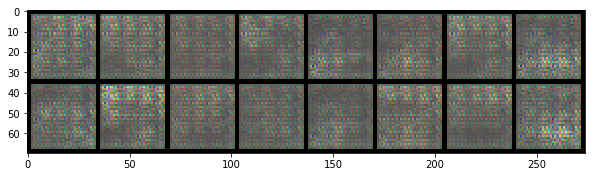

In [68]:
import matplotlib.pyplot as plt

filename = "fake_samples_epoch_008.png"

plt.figure(figsize=(10, 10))
plt.imshow( plt.imread(filename) )